In [1]:
import numpy as np
import copy
import torch
import itertools
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal, Normal
from torch.optim.lr_scheduler import LambdaLR, ConstantLR, CyclicLR
from torch.autograd import Variable
from scipy.optimize import root_scalar, shgo

device = "cpu"
default_tensor_type = torch.FloatTensor

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Problem Setting

The Objective of this notebook is to study the compromise Performance vs Robustness of Statistics over distributions of Rankings

We need to define an indexation order on $\mathfrak{S}_n$ in order to write the loss as a matrix in $\mathbb{R}^{n! \times n!}$ and distributions as vectors in $\mathbb{R}^{n!}$.

In [2]:
n_items = 4
all_ranks = list(itertools.permutations(list(np.arange(n_items))))
all_ranks = [np.array(elem) for elem in all_ranks]
torch_all_ranks = torch.from_numpy(np.asarray(all_ranks))

**DEFINITION:** A statistics over a distribution of rankings is a function $T:\Delta^{\mathfrak{S}_n} \to \mathfrak{S}_n$.

**PERFORMANCE** as defined by 
$$
p \mapsto \mathbb{E}_{Y\sim p}\left(\tau_K(Y, T(p))\right)
$$
where 
$\tau_K$ is the Kendall Tau:
$$
\tau_K(y, \sigma) = \sum_{i,j} \mathbb{1}\{\sigma^{-1}(i) < \sigma^{-1}(j)\}\mathbb{1}\{y^{-1}(i) > y^{-1}(j)\}
$$

In [3]:
def pairwise_matrix(p_torch, torch_all_ranks, n=4):
    M = torch.zeros(n,n)
    for i in range(n):
        for j in range(i+1,n):
            idxs = torch.tensor([torch.argwhere(rk == i).item() < torch.argwhere(rk == j).item() for rk in torch_all_ranks])
            val = torch.sum(p_torch[0,idxs]).item()
            M[i,j] = val
            M[j,i] = 1-val
    return M


def expected_kendall(P1, P2):
    return torch.norm(P1 * (1-P2), 1)
    #return torch.sum(torch.triu(P1,1)*torch.triu(1-P2,1) + torch.triu(P2,1)*torch.triu(1-P1,1))

**ROBUSTNESS** as defined by the "breakdown function" of T:
$$
\varepsilon^*(\delta,p,T) = \inf \left\{\varepsilon>0 : \sup_{||p-q|| \leq \varepsilon} \rho_{\tau_K}(T(p), T(q)) \geq \delta \right\}
$$
where
$$
\rho_{\tau_K} = H_K^{(1/2)}(\pi_1, \pi_2) := \frac{1}{2}\left(\max_{\sigma_1 \in \pi_1} \min_{\sigma_2 \in \pi_2} \tau_K(\sigma_1, \sigma_2) + \max_{\sigma_2 \in \pi_2} \min_{\sigma_1 \in \pi_1} \tau_K(\sigma_1, \sigma_2) \right)
$$
The difficulty with the computation of the breakdown function is that the underlying optimization cannot be performed directly.

In [4]:
def symmetrized_hausdorff_on_kendall(P1, P2):
    return torch.norm(torch.triu(P1,1) - torch.triu(P2,1), 1)

$$
\tilde{\rho}_{\tau_K} = H_K^{dis}(\pi_1, \pi_2) := \max_{\sigma_2 \in \pi_2} \min_{\sigma_1 \in \pi_1} \tau_K(\sigma_1, \sigma_2)
$$

In [5]:
def disymmetrized_hausdorff_on_kendall(P1, P2):
    # If P2 is included in P1
    if (P1[P1 != 1/2] == P2[P1 != 1/2]).all():
        return torch.tensor(0.0)
    # If P1 is included in P2
    elif (P1[P2 != 1/2] == P2[P2 != 1/2]).all():
        return 2*torch.norm(torch.triu(P1,1) - torch.triu(P2,1), 1)
    else:
        idxs = torch.argwhere(P1 == 1/2)
        v = torch.sum(P2 == 1/2)/2
        idxs2 = torch.argwhere(P2 == 1/2)
        P1[[idxs[:, 0], idxs[:, 1]]] = 0
        P2[[idxs[:, 0], idxs[:, 1]]] = 0
        P1[[idxs2[:, 0], idxs2[:, 1]]] = 0
        P2[[idxs2[:, 0], idxs2[:, 1]]] = 0
        return torch.norm(torch.triu(P1,1) - torch.triu(P2,1), 1) + v

# Computing the breakdown function

We approximate the computation of $\varepsilon^*$ in the following way:

1. We find a distribution $\tilde q_{\varepsilon,\delta, p, T}$ that is a solution of the smoothed problem:
$$
\tilde q_{\varepsilon, p, T} = \arg\sup_{||p-q|| \leq \varepsilon} \phi(p,q)
$$
where $\phi(\cdot,q) = \rho_{\tau_K}(T(\cdot), T(q)) \star k(\cdot)$ with $k$ being a smoothing convolution kernel, here a multivariate Gaussian.
2. We approximate $\varepsilon^*$ by
$$
\tilde\varepsilon(\delta,p,T) = \inf \left\{\varepsilon>0 : \rho_{\tau_K}\left(T(p), T(\tilde q_{\varepsilon, p, T})\right) \geq \delta \right\}
$$

### Computing $\phi$

A method for smoothing a bivariate function $m:{\cal Y}\times {\cal X} \to \mathbb{R}$ on its second argument using a mean convolution with kernel $k$.

$$
\tilde m(y, x) = (m(y,\cdot)\star k)(x)
$$

In [6]:
def smooth_pg_2(m, k_x):
    r"""
    Smooth a metric $m$ by convolution with a kernel $k_x$ centered in $x$.
    $$\tilde{m}(y,x) = \int m(y,u) k_x(u) du$$
    As the gradient is not available in closed-form, the loss build is a policy gradient loss, that leads to a noisy but
    unbiased estimate of the gradient of $\tilde{m}$.
    $$g_x(y,u) = \log(k_x(u)) f(y,u) ~~~~\text{for}~~~ u\sim k_x$$
    :param m: function to be smoothed
    :param k_x: function $x\mapsto k$ where $k$ is a kernel centered in $x$
    :return: $g_x(y,u)$ for $u\sim k_x$
    """
    def smoothed_m_pg(y, x):
        k = k_x(x)
        batch_size = torch.Size()
        if len(y.size()) > 1:
            batch_size = y.size()[:-1]
        u = k.sample(batch_size).to(device).type(default_tensor_type)
        loss = k.log_prob(u) * m(y,u)
        return loss
    
    return smoothed_m_pg

In [7]:
def monte_carlo_phi(p, q, dist_Tp_Tq, std_dev_=0.00001, nb_simu=50):
    kernel_conv = lambda _s: MultivariateNormal(_s, std_dev_*torch.eye(_s.size()[-1]))
    rhos = list()
    for i in range(nb_simu):
        q2 = kernel_conv(q.float()).sample(torch.Size())
        rho = dist_Tp_Tq(p, q2.unsqueeze(0)).detach().numpy().item()
        rhos.append(rho)
    rho_final = np.mean(rhos)
    #std_rho = np.std(rhos)
    #print(f"Monte carlo phi: std = {std_rho}")
    return torch.tensor(rho_final)

In [8]:
class NewPhi(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """
    def __init__(self):
        self.name = "New Phi class"

    @staticmethod
    def forward(ctx, input_q2, input_backward, p_torch, dist_Tp_Tq, std_dev_, nb_simu):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        ctx.save_for_backward(input_backward)
        monte_carlo_val = monte_carlo_phi(p_torch, input_q2, dist_Tp_Tq, std_dev_=std_dev_, nb_simu=nb_simu)
        return monte_carlo_val

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        back_,  = ctx.saved_tensors
        return back_ * grad_output, None, None, None, None, None

In [ ]:
s = torch.rand([24], requires_grad=True)
q = softplus(s)/torch.sum(softplus(s))
print(q)

kernel_conv = lambda _s: MultivariateNormal(_s, 1.0*torch.eye(_s.size()[-1]))

smooth_pg_2(dist_Tp_Tq, kernel_conv)(p_torch, q)

### Computing $\tilde q_{\varepsilon,\delta, p, T}$

Remember we want to compute
$$
\tilde q_{\varepsilon, p, T} = \arg\sup_{||p-q|| \leq \varepsilon} \phi(p,q)
$$
Practically, we solved the Lagrangian relaxation of this
$$
\tilde q_{\lambda, p, T} = \arg\sup_q \phi(p,q) - \lambda ||p-q||
$$

### WARNING

Here we use "smooth_pg_2", which approximates THE GRADIENT of phi, and then we call backward on that --> redondancy ??

In [9]:
def torch_optim_attack_relaxed(dist_Tp_Tq, p_torch, reg, epochs, std_dev=0.01, lr=0.01):
    r"""
    :param method: $\tau_K(T(p), T(q))$
    :param reg: $\lambda$
    :param epochs: limit on the number of optimization iterations
    """
    p_torch2 = p_torch.detach().clone()
    p_torch2.requires_grad = False
    softplus = torch.nn.Softplus(beta=1, threshold=20)
    kernel_conv = lambda _s: MultivariateNormal(_s, std_dev*torch.eye(_s.size()[-1])) # $x\mapsto k_x(.)$
    smoothed_dist_Tp_Tq = lambda p, q: smooth_pg_2(dist_Tp_Tq, kernel_conv)(p, q)     # $\phi(.,.)$
    
    s_ = p_torch[0,:].detach().clone().to(device).type(default_tensor_type)
    s_.requires_grad = True
    optimizer = torch.optim.SGD([s_], lr=0.01, momentum=0.9)
    scheduler = CyclicLR(optimizer, 0.01, 1.0, step_size_down=50, cycle_momentum=False)

    for epoch in range(epochs):
        optimizer.zero_grad()
        q = softplus(s_)/torch.sum(softplus(s_))                                   # projection $\sum = 1$
        
        # Decrease the approximation error over time
        kernel_conv = lambda _s: MultivariateNormal(_s, std_dev*(10/(10+epoch))*torch.eye(_s.size()[-1])) # $x\mapsto k_x(.)$
        smoothed_dist_Tp_Tq = lambda p, q: smooth_pg_2(dist_Tp_Tq, kernel_conv)(p, q)     # $\phi(.,.)$
        
        loss = -smoothed_dist_Tp_Tq(p_torch2, q) + reg*(torch.norm(p_torch2-q, 1))     # Lagrangian relaxation of the objective
        loss.backward()
        optimizer.step()
        scheduler.step()
        

    return q

### Computing $
\tilde\varepsilon(\delta,p,T) = \inf \left\{\varepsilon>0 : \rho_{\tau_K}\left(T(p), T(\tilde q_{\varepsilon, p, T})\right) \geq \delta \right\}
$

First strategy: using $\rho_{\tau_K}$ in the evaluation of the breakdown point. Cons: piecewise-constant function, unstable results in the end.

Second strategy: using $\phi$ (the smoothed version of $\rho_{\tau_K}$). Cons: it seems the results are weird.

#### Monte-Carlo estimation of rho when using $\phi$

$\phi(p,q) = \rho_{\tau_K}(T(p), T(q)) \star k(p) = \int_u \rho_{\tau_K}(T(u), T(q)) \times k(p-u) du = \int_u \rho_{\tau_K}(T(u), T(q)) \times k_p(u) du = \mathbb{E}_{p' \sim k_p}(\rho_{\tau_K}(T(p'), T(q)))$ 

In [ ]:
# Get the optimal q
q = torch_optim_attack_relaxed(dist_Tp_Tq, p_torch, 10, epochs, std_dev=10, lr=0.01)

# Real result of rho(T(p), T(q))
print("Real result:", torch_dist_maxpair(p_torch, torch.unsqueeze(q,0), torch_all_ranks, threshold=threshold).detach().numpy())

# Defining phi
std_dev_ = 0.005
kernel_conv = lambda _s: MultivariateNormal(_s, std_dev_*torch.eye(_s.size()[-1])) # $x\mapsto k_x(.)$

# A large number of evaluations of phi
nb_simu = 10000
rhos = list()
for i in range(nb_simu):
    if i % 1000 == 0:
        print(f"simu nb {i}")
    p2 = kernel_conv(p_torch.float().squeeze(0)).sample(torch.Size())
    rho = dist_Tp_Tq(p2.unsqueeze(0), q.unsqueeze(0)).detach().numpy().item()
    rhos.append(rho)

# Mean approximation of phi
print(f"Mean = {np.mean(rhos)}")

# Plot
plt.hist(rhos, density=True, bins=25)
plt.show()

#### Implementation of the function to compute the breakdown point.

We want to solve the following pb:

$$\inf_{\varepsilon \geq 0} \varepsilon \text{ s.t. } \sup_{||p-q|| \leq \varepsilon} \rho_T(p,q) \geq \delta$$

This problem is equivalent to the following one, based one Lagrange relaxation:

$$ \inf_{\varepsilon \geq 0} \, \sup_{\lambda \geq 0} \, \inf_{q \in \Delta} \, \sup_{\alpha \geq 0} \, \, \varepsilon + \lambda \delta - \lambda \rho_T(p,q) + \alpha \lambda ||p-q|| - \lambda \alpha \varepsilon $$

To make it easy to follow, here is what each variable is controling:

1) $q$ is the attacking probability vector, which should not be too far from $p$, but change statistics $T$

2) $\varepsilon$ is the attack budget (the breakdown point) controling the perturbation from $q$

3) $\lambda$ controls that the statistics $T$ is indeed broken by at least $\delta$ by $q$

4) $\alpha$ controls that $q$ is indeed closer than $\varepsilon$ from $p$

In [32]:
def subsample_fct(vect, time=10):
    l = len(vect)
    res = vect[0:l:time]
    return res

def approximate_breakdown_function(delta, dist_Tp_Tq, p_torch, epochs=150000, std_dev=0.01, lr=0.01, maxiter=10, max_reg=10., eval_strat="real"):
    if False:
        def _rho_minus_delta(_reg):
            q = torch_optim_attack_relaxed(dist_Tp_Tq, p_torch, _reg, epochs, std_dev=std_dev, lr=lr)
            if eval_strat == "real":
                rho = torch_dist_maxpair(p_torch, torch.unsqueeze(q,0), torch_all_ranks, threshold=threshold).detach().numpy()
            elif eval_strat == "smoothed":
                std_dev_ = 0.005
                nb_simu = 25000
                kernel_conv = lambda _s: MultivariateNormal(_s, std_dev_*torch.eye(_s.size()[-1])) # $x\mapsto k_x(.)$
                rhos = list()
                for i in range(nb_simu):
                    p2 = kernel_conv(p_torch.float().squeeze(0)).sample(torch.Size())
                    rho = dist_Tp_Tq(p2.unsqueeze(0), q.unsqueeze(0)).detach().numpy().item()
                    rhos.append(rho)
                rho = np.mean(rhos)
            else:
                print("Evaluation strategy not implemented")
            print(f"rho = {rho} and rho - delta = {rho - delta}")
            return rho - delta

        res = root_scalar(_rho_minus_delta, bracket=[1e-8, max_reg], x0=0.5, x1=2.5, xtol=None, rtol=None, maxiter=maxiter)
        q = torch_optim_attack_relaxed(dist_Tp_Tq, p_torch, res.root, epochs, std_dev=std_dev, lr=lr)
        return torch.norm(p_torch - torch.unsqueeze(q,0),1).detach().numpy()
    
    else:
        softplus = torch.nn.Softplus(beta=1, threshold=20)
        #q = torch_optim_attack_relaxed(dist_Tp_Tq, p_torch, epochs=20, std_dev=std_dev, reg=10, lr=0.01)
        q2 = p_torch.detach().clone().squeeze(0) #q.detach().clone() #
        q2.requires_grad = True
        s_ = torch.log(q2)[:].detach().clone().to(device).type(default_tensor_type)
        s_.requires_grad = True

        epsilon_ = torch.tensor(1.0, requires_grad=True)
        eta_ = torch.tensor(10.0, requires_grad=True)
        alpha_ = torch.tensor(10.0, requires_grad=True)
        qs_ = list()
        qs_total_ = list()
        epsilons_ = list()
        etas_ = list()
        alphas_ = list()

        mean_epsilons_ = list()
        mean_etas_ = list()
        mean_alphas_ = list()
        mean_qs_ = list()

        phis_ = list()
        losses = list()

        lr_list = list()

        optimizer_q2 = torch.optim.Adam([s_], lr=lr, betas=(0.9, 0.999), weight_decay=0.01)
        optimizer_eta = torch.optim.Adam([eta_], lr=lr, betas=(0.9, 0.999), weight_decay=0.01, maximize=True)
        optimizer_epsilon = torch.optim.Adam([epsilon_], lr=lr, betas=(0.9, 0.999), weight_decay=0.01)
        optimizer_alpha = torch.optim.Adam([alpha_], lr=lr, betas=(0.9, 0.999), weight_decay=0.01, maximize=True)


        scale_fct_ = lambda x: 0.5**x
        scheduler_q2 = torch.optim.lr_scheduler.CyclicLR(optimizer_q2, lr, 10, step_size_up=3000, mode='exp_range', gamma=0.8, cycle_momentum=False, scale_mode='cycle', scale_fn=scale_fct_)
        scheduler_eta = torch.optim.lr_scheduler.CyclicLR(optimizer_eta, lr, 10, step_size_up=3000, mode='exp_range', gamma=0.8, cycle_momentum=False, scale_mode='cycle', scale_fn=scale_fct_)
        scheduler_epsilon = torch.optim.lr_scheduler.CyclicLR(optimizer_epsilon, lr, 10, step_size_up=3000, mode='exp_range', gamma=0.8, cycle_momentum=False, scale_mode='cycle', scale_fn=scale_fct_)
        scheduler_alpha = torch.optim.lr_scheduler.CyclicLR(optimizer_alpha, lr, 10, step_size_up=3000, mode='exp_range', gamma=0.8, cycle_momentum=False, scale_mode='cycle', scale_fn=scale_fct_)

        for epoch in range(epochs):
            try:
                kernel_conv = lambda _s: MultivariateNormal(_s, 1/np.sqrt(1+epoch)*torch.eye(_s.size()[-1]))
                q2 = softplus(s_)/torch.sum(softplus(s_))
                res = smooth_pg_2(dist_Tp_Tq, kernel_conv)(p_torch, q2)
                res.backward(retain_graph=True)
                grad_data = s_.grad.data.detach().clone()
                Phi_ = NewPhi.apply
                phi_ = Phi_(q2, grad_data, p_torch, dist_Tp_Tq, 1/np.sqrt(1+epoch), 1)

                optimizer_q2.zero_grad()
                optimizer_eta.zero_grad()
                optimizer_epsilon.zero_grad()
                optimizer_alpha.zero_grad()

                loss = torch.exp(epsilon_) + softplus(eta_)/softplus(alpha_)*delta - softplus(eta_)/softplus(alpha_)*phi_ + softplus(eta_)*torch.norm(p_torch - torch.unsqueeze(q2,0),1) - softplus(eta_)*softplus(epsilon_)

                loss.backward()
                torch.nn.utils.clip_grad_value_(s_, 1)
                torch.nn.utils.clip_grad_value_(epsilon_, 1)
                torch.nn.utils.clip_grad_value_(eta_, 1)
                torch.nn.utils.clip_grad_value_(alpha_, 1)
                optimizer_q2.step()
                optimizer_eta.step()
                optimizer_epsilon.step()
                optimizer_alpha.step()

                scheduler_q2.step()
                scheduler_eta.step()
                scheduler_epsilon.step()
                scheduler_alpha.step()
                if epoch % (epochs/100) == 0:
                    print(f"epoch {epoch}: \n \t epsilon_={softplus(epsilon_)} and grad = {-epsilon_.grad.data} and lr = {optimizer_epsilon.param_groups[0]['lr']} \n \t eta_={softplus(eta_)} and grad = {eta_.grad.data} and lr = {optimizer_eta.param_groups[0]['lr']} \n \t alpha_={softplus(alpha_)} and grad = {alpha_.grad.data} and lr = {optimizer_alpha.param_groups[0]['lr']} \n \t s_={s_}\n \t q2={q2} and sum={torch.sum(q2)} and grad = {-s_.grad.data} and lr = {optimizer_q2.param_groups[0]['lr']} \n \t phi = {phi_} and std_dev = {1.0/(1+epoch)}")
                losses.append(loss.detach().item())
                qs_total_.append(q2.detach().numpy())
                qs_.append(q2[0].detach().item())
                epsilons_.append(torch.exp(epsilon_).detach().item())
                etas_.append(torch.exp(eta_).detach().item())
                alphas_.append(torch.exp(alpha_).detach().item())
                phis_.append(phi_.item())
                lr_list.append(optimizer_epsilon.param_groups[0]['lr'])

                mean_qs_.append(np.mean(qs_total_[-50000:], axis=0))
                mean_epsilons_.append(np.mean(epsilons_[-50000:]))
                mean_etas_.append(np.mean(etas_[-50000:]))
                mean_alphas_.append(np.mean(alphas_[-50000:]))
            except:
                print(f"Something went wrong")
                print(f"epoch {epoch}: \n \t epsilon_={softplus(epsilon_)} and grad = {-epsilon_.grad.data} and lr = {optimizer_epsilon.param_groups[0]['lr']} \n \t eta_={softplus(eta_)} and grad = {eta_.grad.data} and lr = {optimizer_eta.param_groups[0]['lr']} \n \t alpha_={softplus(alpha_)} and grad = {alpha_.grad.data} and lr = {optimizer_alpha.param_groups[0]['lr']} \n \t s_={s_}\n \t q2={q2} and sum={torch.sum(q2)} and grad = {-s_.grad.data} and lr = {optimizer_q2.param_groups[0]['lr']} \n \t phi = {phi_} and std_dev = {1.0/(1+epoch)}")
                break
            
        f, ax = plt.subplots(2,3, figsize=(15, 8))
        ax[0,0].plot(qs_)
        ax[0,0].set_title(f"First value of q")

        ax[0,1].plot(phis_)
        ax[0,1].set_title(f"Phi")

        ax[0,2].plot(epsilons_)
        ax[0,2].set_title(f"Epsilon")

        #ax[1,0].plot(lambdas_)
        #ax[1,0].set_title(f"Lambda")
        ax[1,0].plot(etas_)
        ax[1,0].set_title(f"Eta")

        ax[1,1].plot(alphas_)
        ax[1,1].set_title(f"Alpha")

        ax[1,2].plot(losses)
        ax[1,2].set_title(f"Loss")
        plt.show()
        
        print("\n \n")
        time_fct = 100
        x_axis_val = subsample_fct(np.linspace(0,len(mean_epsilons_),len(mean_epsilons_)), time=time_fct)
        f, ax = plt.subplots(2,3, figsize=(15, 8))

        mean_qs_subsample = subsample_fct(mean_qs_, time_fct)
        mean_qs1_ = [torch.norm(p_torch - torch.tensor(mean_q_), 1) for mean_q_ in mean_qs_subsample] #[mean_q_[0] for mean_q_ in mean_qs_]
        ax[0,0].plot(x_axis_val, mean_qs1_)
        ax[0,0].set_title(f"Norm of the difference between p and q")

        Phi_ = NewPhi.apply
        mean_phis_ = [Phi_(torch.tensor(mean_q_), grad_data, p_torch, dist_Tp_Tq, 0.1/(1+epoch), 10) for mean_q_ in mean_qs_subsample]
        ax[0,1].plot(x_axis_val, mean_phis_)
        ax[0,1].set_title(f"Phi")

        ax[0,2].plot(x_axis_val, subsample_fct(mean_epsilons_, time_fct))
        ax[0,2].set_title(f"Epsilon")

        #ax[1,0].plot(x_axis_val, subsample_fct(mean_lambdas_, time_fct))
        #ax[1,0].set_title(f"Lambda")
        ax[1,0].plot(x_axis_val, subsample_fct(mean_etas_, time_fct))
        ax[1,0].set_title(f"Eta")

        ax[1,1].plot(x_axis_val, subsample_fct(mean_alphas_, time_fct))
        ax[1,1].set_title(f"Alpha")

        ax[1,2].plot(x_axis_val, subsample_fct(losses, time_fct))
        ax[1,2].set_title(f"Loss")
        plt.plot()

        return losses, qs_, epsilons_, etas_, alphas_, s_, mean_qs_, mean_epsilons_, mean_etas_, mean_alphas_
    

### Warning :

You need to compile cells that follows this one (and the 3 following) first (I now, this does not make any sense). Please compile everything under "Family of distribution" and "Statistics under study" first.

In [ ]:
w = np.array([25, 8, 3, 2.5])
p = proba_plackett_luce(w, all_ranks)
p_torch = torch.from_numpy(p)
delta = 1
threshold = None
method_ = erm
softplus = torch.nn.Softplus(beta=1, threshold=20)
def torch_dist_maxpair(p_torch1, p_torch2, torch_all_ranks, threshold):
    R1 = method_(p_torch1, torch_all_ranks, n=4)#, threshold=threshold)
    R2 = method_(p_torch2, torch_all_ranks, n=4)#, threshold=threshold)
    return symmetrized_hausdorff_on_kendall(R1, R2)

method = torch_dist_maxpair
dist_Tp_Tq = lambda _p,_q: method(_p, _q, torch_all_ranks, threshold=threshold)

#q = torch_optim_attack_relaxed(dist_Tp_Tq, p_torch, 10, 20, std_dev=0.001, lr=0.01)
q2 = p_torch.detach().clone().squeeze(0) #q.detach().clone()
q2.requires_grad = True
s_ = torch.log(q2)[:].detach().clone().to(device).type(default_tensor_type)
print(s_.shape)
s_.requires_grad = True

epsilon_ = torch.tensor(2.0, requires_grad=True)
lambda_ = torch.tensor(2.0, requires_grad=True)
alpha_ = torch.tensor(3.0, requires_grad=True)
qs_ = list()
qs_total_ = list()
epsilons_ = list()
lambdas_ = list()
alphas_ = list()

mean_epsilons_ = list()
mean_lambdas_ = list()
mean_alphas_ = list()
mean_qs_ = list()

phis_ = list()
losses = list()

optimizer_q2 = torch.optim.Adam([s_], lr=10, betas=(0.9, 0.999), weight_decay=0.001)
optimizer_lambda = torch.optim.Adam([lambda_], lr=0.01, betas=(0.9, 0.999), weight_decay=0.001, maximize=True)
optimizer_epsilon = torch.optim.Adam([epsilon_], lr=0.1, betas=(0.9, 0.999), weight_decay=0.001)
optimizer_alpha = torch.optim.Adam([alpha_], lr=0.01, betas=(0.9, 0.999), weight_decay=0.001, maximize=True)

lambda_scheduler = lambda coef: lambda epoch: coef/np.sqrt(1+epoch) if epoch <= 5000 else 1/np.sqrt(1+5000)
scheduler_q2 = torch.optim.lr_scheduler.LambdaLR(optimizer_q2, lr_lambda=lambda_scheduler(1)) #.ReduceLROnPlateau(optimizer_q2, patience=10000, factor=0.75, verbose=True, mode="max")
scheduler_lambda = torch.optim.lr_scheduler.LambdaLR(optimizer_lambda, lr_lambda=lambda_scheduler(10)) #.ReduceLROnPlateau(optimizer_lambda, patience=10000, factor=0.75, verbose=True)
scheduler_epsilon = torch.optim.lr_scheduler.LambdaLR(optimizer_epsilon, lr_lambda=lambda_scheduler(1)) #.ReduceLROnPlateau(optimizer_epsilon, patience=10000, factor=0.75, verbose=True, mode="max")
scheduler_alpha = torch.optim.lr_scheduler.LambdaLR(optimizer_alpha, lr_lambda=lambda_scheduler(10)) #.ReduceLROnPlateau(optimizer_alpha, patience=10000, factor=0.75, verbose=True)

#scheduler_q2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_q2, patience=50, factor=0.95, verbose=True, mode="max")
#scheduler_lambda = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_lambda, patience=50, factor=0.85, verbose=True, mode="min")
#scheduler_epsilon = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_epsilon, patience=50, factor=0.95, verbose=True, mode="max")
#scheduler_alpha = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_alpha, patience=50, factor=0.5, verbose=True, mode="min")

for epoch in range(100):
    kernel_conv = lambda _s: MultivariateNormal(_s, 1/np.sqrt(1+epoch)*torch.eye(_s.size()[-1]))
    q2 = softplus(s_)/torch.sum(softplus(s_))
    res = smooth_pg_2(dist_Tp_Tq, kernel_conv)(p_torch, q2)
    res.backward(retain_graph=True)
    grad_data = s_.grad.data.detach().clone()
    Phi_ = NewPhi.apply
    phi_ = Phi_(q2, grad_data, p_torch, dist_Tp_Tq, 0.1/(1+epoch), 3)
    
    optimizer_q2.zero_grad()
    optimizer_lambda.zero_grad()
    optimizer_epsilon.zero_grad()
    optimizer_alpha.zero_grad()
    
    loss = torch.exp(epsilon_) + softplus(lambda_)*delta - softplus(lambda_)*phi_ + softplus(lambda_)*softplus(alpha_)*torch.norm(p_torch - torch.unsqueeze(q2,0),1) - softplus(lambda_)*softplus(alpha_)*softplus(epsilon_)
    
    loss.backward()
    optimizer_q2.step()
    optimizer_lambda.step()
    optimizer_epsilon.step()
    optimizer_alpha.step()
    
    scheduler_q2.step()#(loss.detach().item())
    scheduler_lambda.step()#(loss.detach().item())
    scheduler_epsilon.step()#(loss.detach().item())
    scheduler_alpha.step()#(loss.detach().item())
    if epoch % 10 == 0:
        print(f"epoch {epoch}: \n \t epsilon_={torch.exp(epsilon_)} and grad = {-epsilon_.grad.data} and lr = {optimizer_epsilon.param_groups[0]['lr']} \n \t lambda_={torch.exp(lambda_)} and grad = {lambda_.grad.data} and lr = {optimizer_lambda.param_groups[0]['lr']} \n \t alpha_={torch.exp(alpha_)} and grad = {alpha_.grad.data} and lr = {optimizer_alpha.param_groups[0]['lr']} \n \t s_={s_}\n \t q2={q2} and sum={torch.sum(q2)} and grad = {-s_.grad.data} and lr = {optimizer_q2.param_groups[0]['lr']} \n \t phi = {phi_} and std_dev = {1.0/(1+epoch)}")
    losses.append(loss.detach().item())
    qs_total_.append(q2.detach().numpy())
    qs_.append(q2[0].detach().item())
    epsilons_.append(torch.exp(epsilon_).detach().item())
    lambdas_.append(torch.exp(lambda_).detach().item())
    alphas_.append(torch.exp(alpha_).detach().item())
    phis_.append(phi_.item())
    
    mean_qs_.append(np.mean(qs_total_, axis=0))
    mean_epsilons_.append(np.mean(epsilons_))
    mean_lambdas_.append(np.mean(lambdas_))
    mean_alphas_.append(np.mean(alphas_))
    

In [ ]:
w = np.array([25, 8, 3, 2.5])
p = proba_plackett_luce(w, all_ranks)
p_torch = torch.from_numpy(p)
delta = 1
threshold = None
method_ = erm
softplus = torch.nn.Softplus(beta=1, threshold=20)
def torch_dist_maxpair(p_torch1, p_torch2, torch_all_ranks, threshold):
    R1 = method_(p_torch1, torch_all_ranks, n=4)#, threshold=threshold)
    R2 = method_(p_torch2, torch_all_ranks, n=4)#, threshold=threshold)
    return symmetrized_hausdorff_on_kendall(R1, R2)

method = torch_dist_maxpair
dist_Tp_Tq = lambda _p,_q: method(_p, _q, torch_all_ranks, threshold=threshold)

#q = torch_optim_attack_relaxed(dist_Tp_Tq, p_torch, 10, 20, std_dev=0.001, lr=0.01)
q2 = p_torch.detach().clone().squeeze(0) #q.detach().clone() #
q2.requires_grad = True
s_ = torch.log(q2)[:].detach().clone().to(device).type(default_tensor_type)
print(s_.shape)
s_.requires_grad = True

epsilon_ = torch.tensor(1.0, requires_grad=True)
eta_ = torch.tensor(10.0, requires_grad=True)
alpha_ = torch.tensor(10.0, requires_grad=True)
qs_ = list()
qs_total_ = list()
epsilons_ = list()
etas_ = list()
alphas_ = list()

mean_epsilons_ = list()
mean_etas_ = list()
mean_alphas_ = list()
mean_qs_ = list()

phis_ = list()
losses = list()

lr_list = list()

optimizer_q2 = torch.optim.Adam([s_], lr=0.01, betas=(0.9, 0.999), weight_decay=0.01)
optimizer_eta = torch.optim.Adam([eta_], lr=0.01, betas=(0.9, 0.999), weight_decay=0.01, maximize=True)
optimizer_epsilon = torch.optim.Adam([epsilon_], lr=0.01, betas=(0.9, 0.999), weight_decay=0.01)
optimizer_alpha = torch.optim.Adam([alpha_], lr=0.01, betas=(0.9, 0.999), weight_decay=0.01, maximize=True)


scale_fct_ = lambda x: 0.5**x
scheduler_q2 = torch.optim.lr_scheduler.CyclicLR(optimizer_q2, 0.01, 50, step_size_up=3000, mode='exp_range', gamma=0.8, cycle_momentum=False, scale_mode='cycle', scale_fn=scale_fct_)
scheduler_eta = torch.optim.lr_scheduler.CyclicLR(optimizer_eta, 0.01, 50, step_size_up=3000, mode='exp_range', gamma=0.8, cycle_momentum=False, scale_mode='cycle', scale_fn=scale_fct_)
scheduler_epsilon = torch.optim.lr_scheduler.CyclicLR(optimizer_epsilon, 0.01, 50, step_size_up=3000, mode='exp_range', gamma=0.8, cycle_momentum=False, scale_mode='cycle', scale_fn=scale_fct_)
scheduler_alpha = torch.optim.lr_scheduler.CyclicLR(optimizer_alpha, 0.01, 50, step_size_up=3000, mode='exp_range', gamma=0.8, cycle_momentum=False, scale_mode='cycle', scale_fn=scale_fct_)

#lambda_scheduler = lambda coef: lambda epoch: coef/np.sqrt(1+epoch) if epoch <= 25000 else 1/np.sqrt(1+25000)
#scheduler_q2 = torch.optim.lr_scheduler.LambdaLR(optimizer_q2, lr_lambda=lambda_scheduler(1)) #.ReduceLROnPlateau(optimizer_q2, patience=10000, factor=0.75, verbose=True, mode="max")
#scheduler_eta = torch.optim.lr_scheduler.LambdaLR(optimizer_eta, lr_lambda=lambda_scheduler(1)) #.ReduceLROnPlateau(optimizer_lambda, patience=10000, factor=0.75, verbose=True)
#scheduler_epsilon = torch.optim.lr_scheduler.LambdaLR(optimizer_epsilon, lr_lambda=lambda_scheduler(1)) #.ReduceLROnPlateau(optimizer_epsilon, patience=10000, factor=0.75, verbose=True, mode="max")
#scheduler_alpha = torch.optim.lr_scheduler.LambdaLR(optimizer_alpha, lr_lambda=lambda_scheduler(1)) #.ReduceLROnPlateau(optimizer_alpha, patience=10000, factor=0.75, verbose=True)

#scheduler_q2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_q2, patience=50, factor=0.95, verbose=True, mode="max")
#scheduler_lambda = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_lambda, patience=50, factor=0.85, verbose=True, mode="min")
#scheduler_epsilon = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_epsilon, patience=50, factor=0.95, verbose=True, mode="max")
#scheduler_alpha = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_alpha, patience=50, factor=0.5, verbose=True, mode="min")

for epoch in range(100):
    kernel_conv = lambda _s: MultivariateNormal(_s, 1/np.sqrt(1+epoch)*torch.eye(_s.size()[-1]))
    q2 = softplus(s_)/torch.sum(softplus(s_))
    res = smooth_pg_2(dist_Tp_Tq, kernel_conv)(p_torch, q2)
    res.backward(retain_graph=True)
    grad_data = s_.grad.data.detach().clone()
    Phi_ = NewPhi.apply
    phi_ = Phi_(q2, grad_data, p_torch, dist_Tp_Tq, 1/np.sqrt(1+epoch), 1)
    
    optimizer_q2.zero_grad()
    optimizer_eta.zero_grad()
    optimizer_epsilon.zero_grad()
    optimizer_alpha.zero_grad()
    
    loss = torch.exp(epsilon_) + softplus(eta_)/softplus(alpha_)*delta - softplus(eta_)/softplus(alpha_)*phi_ + softplus(eta_)*torch.norm(p_torch - torch.unsqueeze(q2,0),1) - softplus(eta_)*softplus(epsilon_)
    
    loss.backward()
    torch.nn.utils.clip_grad_value_(s_, 1)
    torch.nn.utils.clip_grad_value_(epsilon_, 1)
    torch.nn.utils.clip_grad_value_(eta_, 1)
    torch.nn.utils.clip_grad_value_(alpha_, 1)
    optimizer_q2.step()
    optimizer_eta.step()
    optimizer_epsilon.step()
    optimizer_alpha.step()
    
    scheduler_q2.step()#(loss.detach().item())
    scheduler_eta.step()#(loss.detach().item())
    scheduler_epsilon.step()#(loss.detach().item())
    scheduler_alpha.step()#(loss.detach().item())
    if epoch % 10 == 0:
        print(f"epoch {epoch}: \n \t epsilon_={softplus(epsilon_)} and grad = {-epsilon_.grad.data} and lr = {optimizer_epsilon.param_groups[0]['lr']} \n \t eta_={softplus(eta_)} and grad = {eta_.grad.data} and lr = {optimizer_eta.param_groups[0]['lr']} \n \t alpha_={softplus(alpha_)} and grad = {alpha_.grad.data} and lr = {optimizer_alpha.param_groups[0]['lr']} \n \t s_={s_}\n \t q2={q2} and sum={torch.sum(q2)} and grad = {-s_.grad.data} and lr = {optimizer_q2.param_groups[0]['lr']} \n \t phi = {phi_} and std_dev = {1.0/(1+epoch)}")
    losses.append(loss.detach().item())
    qs_total_.append(q2.detach().numpy())
    qs_.append(q2[0].detach().item())
    epsilons_.append(torch.exp(epsilon_).detach().item())
    etas_.append(torch.exp(eta_).detach().item())
    alphas_.append(torch.exp(alpha_).detach().item())
    phis_.append(phi_.item())
    lr_list.append(optimizer_epsilon.param_groups[0]['lr'])
    
    mean_qs_.append(np.mean(qs_total_[-50000:], axis=0))
    mean_epsilons_.append(np.mean(epsilons_[-50000:]))
    mean_etas_.append(np.mean(etas_[-50000:]))
    mean_alphas_.append(np.mean(alphas_[-50000:]))

In [ ]:
print(epsilons_[-1])
print(etas_[-1])
#print(lambdas_[-1])
print(alphas_[-1])
print(qs_[-1])

plt.plot(lr_list)
plt.show()
lr_list[-1]

In [ ]:
f, ax = plt.subplots(2,3, figsize=(15, 8))

l_ = 10000

ax[0,0].plot(qs_[-l_:])
ax[0,0].set_title(f"First value of q")

ax[0,1].plot(phis_[-l_:])
ax[0,1].set_title(f"Phi")

ax[0,2].plot(epsilons_[-l_:])
ax[0,2].set_title(f"Epsilon")

#ax[1,0].plot(lambdas_)
#ax[1,0].set_title(f"Lambda")
ax[1,0].plot(etas_[-l_:])
ax[1,0].set_title(f"Eta")

ax[1,1].plot(alphas_[-l_:])
ax[1,1].set_title(f"Alpha")

ax[1,2].plot(losses[-l_:])
ax[1,2].set_title(f"Loss")


In [ ]:
def subsample_fct(vect, time=10):
    l = len(vect)
    res = vect[0:l:time]
    return res
time_fct = 10

x_axis_val = subsample_fct(np.linspace(0,len(mean_epsilons_),len(mean_epsilons_)), time=time_fct)

f, ax = plt.subplots(2,3, figsize=(15, 8))

mean_qs_subsample = subsample_fct(mean_qs_, time_fct)
mean_qs1_ = [torch.norm(p_torch - torch.tensor(mean_q_), 1) for mean_q_ in mean_qs_subsample] #[mean_q_[0] for mean_q_ in mean_qs_]
ax[0,0].plot(x_axis_val, mean_qs1_)
ax[0,0].set_title(f"Norm of the difference between p and q")

Phi_ = NewPhi.apply
mean_phis_ = [Phi_(torch.tensor(mean_q_), grad_data, p_torch, dist_Tp_Tq, 0.1/(1+epoch), 10) for mean_q_ in mean_qs_subsample]
ax[0,1].plot(x_axis_val, mean_phis_)
ax[0,1].set_title(f"Phi")

ax[0,2].plot(x_axis_val, subsample_fct(mean_epsilons_, time_fct))
ax[0,2].set_title(f"Epsilon")

#ax[1,0].plot(x_axis_val, subsample_fct(mean_lambdas_, time_fct))
#ax[1,0].set_title(f"Lambda")
ax[1,0].plot(x_axis_val, subsample_fct(mean_etas_, time_fct))
ax[1,0].set_title(f"Eta")

ax[1,1].plot(x_axis_val, subsample_fct(mean_alphas_, time_fct))
ax[1,1].set_title(f"Alpha")

ax[1,2].plot(x_axis_val, subsample_fct(losses, time_fct))
ax[1,2].set_title(f"Loss")


In [ ]:
print(mean_qs_subsample[-1])
print(mean_epsilons_[-1])
print(Phi_(torch.tensor(mean_qs_subsample[-1]), grad_data, p_torch, dist_Tp_Tq, 0.001, 100))
print(erm(torch.tensor(mean_qs_subsample[-1]).unsqueeze(0), torch_all_ranks, n=4))

In [ ]:
print(p_torch)
print(q2)
print(torch.norm(p_torch.squeeze(0)-q2, 1))
print(erm(q2.unsqueeze(0), torch_all_ranks, n=4))

In [ ]:
phi_smooth = phis_[-1] #monte_carlo_phi(p_torch, q2, dist_Tp_Tq, nb_simu=100, std_dev_=0.0001).item()
myres = delta - np.asarray(alphas_)*np.asarray(epsilons_) + np.asarray(alphas_)*torch.norm(p_torch.squeeze(0)-q2, 1).item() - phi_smooth

plt.plot(myres)
plt.show()

print(myres[-1])
print((np.asarray(alphas_)*np.asarray(epsilons_))[-1])
print((np.asarray(alphas_)*torch.norm(p_torch.squeeze(0)-q2, 1).item())[-1])
print(f"phi = {dist_Tp_Tq(p_torch, q2.unsqueeze(0))} vs phi_smooth = {phi_smooth}")
print(q2)


# Family of distribution

The Plackett-Luce model is a parametric family of distributions over permutations:
$$
\mathbb{P}\left(\sigma | w\right) = \prod_{r=1}^n \frac{w_{\sigma(r)}}{\sum_{k\geq r}w_{\sigma(k)}}
$$

In [12]:
def proba_plackett_luce(w, all_ranks, n_items=4):
    list_proba = list()

    for sigma in all_ranks:
        val_ = list()
        for r in range(n_items):
            num_ = w[sigma[r]]
            denom_ = 0
            for s in range(r, n_items):
                v_ = w[sigma[s]]
                denom_ += v_
            val_.append(num_/denom_)
        proba_ = np.prod(val_)
        list_proba.append(proba_)
    return np.matrix(list_proba)

# Statistics under study

### MaxPair

Todo: add a description

In [13]:
def _maxpair(P, threshold = 0.):
    s = torch.sum(1*(P > 0.5)+1/2*(P == 0.5), axis=1)
    sigma = torch.argsort(-s)
    M = P[np.ix_(sigma,sigma)]
    
    idxs = torch.argwhere(M>1/2+threshold)
    for idx in idxs:
        M[:idx[0]+1,idx[1]] = 1
        M[idx[1],:idx[0]+1] = 0

    m = torch.max(torch.abs(M-0.5)*(M!=0.5)*(torch.abs(M-0.5) <= threshold))
    while m > 0:
        i,j = torch.argwhere(np.abs(M-0.5) == m)[0,0], torch.argwhere(np.abs(M-0.5) == m)[0,1]
        if i <= j:
            idx_tomerge1, idx_tomerge2 = i, j+1
        elif i > j:
            idx_tomerge1, idx_tomerge2 = j, i+1
        M = torch_merge_idx(M, torch.arange(idx_tomerge1,idx_tomerge2))
        m = torch.max(np.abs(M - 0.5) * (M != 0.5) * (torch.abs(M - 0.5) <= threshold))
    return M[np.ix_(torch.argsort(sigma), torch.argsort(sigma))]

def maxpair(p, torch_all_ranks, n=4, threshold = 0.):
    P = pairwise_matrix(p, torch_all_ranks=torch_all_ranks, n=n)
    return _maxpair(P, threshold = threshold)

### Merge

Todo: add a description

In [14]:
def torch_merge_idx(M, idx):
    # i,j \notin idx -> P_ij = M_ij
    # i \in idx, j \notin idx -> P_ij = \max_{k\in idx} M_kj
    # i \notin idx, j \in idx -> P_ij = \max_{k\in idx} M_ik
    # i,j \in idx -> P_ij = 0.5
    P = M
    for i in torch.arange(M.shape[0]):
        m = torch.max(M[i, idx])
        for j in idx:
            P[i,j] = m
    for j in torch.arange(M.shape[0]):
        m = torch.max(M[idx, j])
        for i in idx:
            P[i,j] = m
    for i in idx:
        for j in idx:
            P[i,j] = 0.5
    PTRIU = torch.triu(P, 0)
    P = PTRIU + torch.tril(1 - PTRIU.T, -1)
    return P

def merge(p, torch_all_ranks, threshold=0, n=4):
    P = pairwise_matrix(p, torch_all_ranks=torch_all_ranks, n=n)
    cont = True
    while cont:
        P_mod = torch.abs(torch.triu(P,1)-torch.tensor(0.5))
        m = torch.min(torch.abs(torch.triu(P,1)-torch.tensor(0.5)))
        if m == 0.0 or m > threshold:
            cont = False
        else:
            idxs = torch.argwhere(P_mod == m)
            idxs = idxs.reshape(torch.prod(torch.tensor(idxs.shape)))
            P = torch_merge_idx(P, idxs)
    return P

### ERM

Todo: add a description

In [15]:
def erm(p, torch_all_ranks, n=4):
    P = pairwise_matrix(p, torch_all_ranks=torch_all_ranks, n=n)
    return torch.round(P)

### Depth

Todo: add a description

Only available for n=4 items

In [16]:
def kendall_tau(sigma1, sigma2):
    n = sigma1.size()[-1]
    sigma1_inv = torch.argsort(sigma1, dim=-1)
    sigma2_inv = torch.argsort(sigma2, dim=-1)
    sigma1_pairs = (sigma1_inv.unsqueeze(dim=-1) > sigma1_inv.unsqueeze(dim=-2)).float()
    sigma2_pairs = (sigma2_inv.unsqueeze(dim=-1) > sigma2_inv.unsqueeze(dim=-2)).float()
    return torch.sum(torch.abs(sigma1_pairs-sigma2_pairs), dim=[-2,-1]).double()/2 #/(n*(n-1))

def kendall_matrix(torch_all_ranks):
    K = torch.zeros(len(torch_all_ranks),len(torch_all_ranks))
    for i, rank1 in enumerate(torch_all_ranks):
        for j, rank2 in enumerate(torch_all_ranks):
            K[i,j] = kendall_tau(rank1,rank2)
    return K.double()

def get_all_buckets(torch_all_ranks, n=4):
    list_bucket = list()

    for rank1 in torch_all_ranks:
        for rank2 in torch_all_ranks:
            if kendall_tau(rank1,rank2) == 1.0:
                list_bucket.append( [rank1,rank2] )
    
    for i in np.arange(n):
        temp_ranks = list()
        for rank in torch_all_ranks:
            if rank[3] == i:
                temp_ranks.append(rank)
        list_bucket.append(temp_ranks)
        
    list_bucket.append([torch.tensor([0,1,2,3]), torch.tensor([0,1,3,2]),torch.tensor([1,0,2,3]),torch.tensor([1,0,3,2])])
    list_bucket.append([torch.tensor([0,2,1,3]), torch.tensor([0,2,3,1]),torch.tensor([2,0,1,3]),torch.tensor([2,0,3,1])])
    list_bucket.append([torch.tensor([0,3,1,2]), torch.tensor([0,3,2,1]),torch.tensor([3,0,1,2]),torch.tensor([3,0,2,1])])
    list_bucket.append([torch.tensor([1,2,0,3]), torch.tensor([1,2,3,0]),torch.tensor([2,1,0,3]),torch.tensor([2,1,3,0])]) 
    list_bucket.append([torch.tensor([1,3,0,2]), torch.tensor([1,3,2,0]),torch.tensor([3,1,0,2]),torch.tensor([3,1,2,0])])
    list_bucket.append([torch.tensor([2,3,0,1]), torch.tensor([2,3,1,0]),torch.tensor([3,2,0,1]),torch.tensor([3,2,1,0])])

    list_bucket.append(torch_all_ranks)
    for rank in torch_all_ranks:
        list_bucket.append(list([rank]))
    
    return list_bucket

def bucket_distrib(torch_all_ranks, list_bucket):
    l_ = list()
    div = len(list_bucket)
    for a_ in torch_all_ranks:
        count = 0
        for b_ in list_bucket:
            count += 1
            if (b_ == a_).all():
                l_.append(1.0/div)
                count += 1
                continue
        if count == div:
            l_.append(0)
    return torch.tensor(l_).double()

def depth_metric_optim(p, K, list_bucket, torch_all_ranks, norm="l1", printer=False):
    n_ranks_to_test = len(list_bucket)
    val = torch.inf
    for i, bucket in enumerate(list_bucket):
        q = bucket_distrib(torch_all_ranks, bucket)
        if norm == "l1":
            val_ = torch.norm(torch.matmul(p.double(),K) - torch.matmul(q.double(),K), 1)
        elif norm == "l2":
            val_ = torch.norm(torch.matmul(p.double(),K) - torch.matmul(q.double(),K), 2)**2
        if printer:
            print(f"val: {val_} for {bucket}")
        if val_ <= val:
            best_distrib = q
            val = val_
    return best_distrib, val

def depth(p, torch_all_ranks, norm="l1", printer=False):
    list_bucket = get_all_buckets(torch_all_ranks, n=4)
    K = kendall_matrix(torch_all_ranks)
    q, val = depth_metric_optim(p, K, list_bucket, torch_all_ranks, norm=norm, printer=printer)
    Q = pairwise_matrix(q.unsqueeze(0), torch_all_ranks=torch_all_ranks, n=4)
    return Q  
    

### Wasserstein

Todo: add a description

In [17]:
from scipy import optimize
from math import factorial

def wasserstein_dist(p, q, K, n=4):
    nsize = factorial(n)
    K_bis = K.view(nsize*nsize)
    
    for i in range(nsize):
        A_ = [0]*nsize*i + [1]*nsize + [0]*nsize*(nsize-i-1)
        if i == 0:
            A = torch.tensor(A_).reshape(1,nsize*nsize)
        else:
            A = torch.cat((A, torch.tensor(A_).reshape(1,nsize*nsize)))
    for i in range(nsize):
        A_ = ([0]*i + [1] + [0]*(nsize-i-1))*nsize
        A = torch.cat((A, torch.tensor(A_).reshape(1,nsize*nsize)))
    
    b = torch.cat((p, q), 1)
    
    optim_val = optimize.linprog(K_bis, A_eq=A, b_eq=b, bounds=(0,1))
    return optim_val.fun

def wasserstein_(myp, torch_all_ranks, n=4, printer=False):
    list_bucket = get_all_buckets(torch_all_ranks, n=4)
    K = kendall_matrix(torch_all_ranks)
    val = torch.inf
    for i, bucket in enumerate(list_bucket):
        q = bucket_distrib(torch_all_ranks, bucket)
        if len(q.shape) < 2:
            q = q.unsqueeze(0)
        val_ = wasserstein_dist(myp, q, K, n=n)
        #if printer:
        print(f"WASS i = {i} --> val: {val_} for {bucket} / q = {q} and p = {myp}")
        if val_ <= val:
            best_distrib = q
            val = val_
    print(f"END WASSERSTEIN_ with {val_} and {best_distrib}")
    return best_distrib, val

def wasserstein(myp, torch_all_ranks, n=4):
    print(f"CALL TO WASSERSTEIN")
    q, val = wasserstein_(myp, torch_all_ranks, n=n, printer=False)
    Q = pairwise_matrix(q, torch_all_ranks=torch_all_ranks, n=n)
    print(f"END OF CALL TO WASSERSTEIN")
    return Q

# Simulations

## Checking the converge of the optimization of the attack

In [ ]:
w = np.array([25, 8, 3, 2.5])
p = proba_plackett_luce(w, all_ranks)
p_torch = torch.from_numpy(p)

torch_all_ranks = torch.from_numpy(np.asarray(all_ranks))
P = pairwise_matrix(p_torch, torch_all_ranks, n=4)

method_ = maxpair #depth
def torch_dist_maxpair(p_torch1, p_torch2, torch_all_ranks, threshold):
    R1 = method_(p_torch1, torch_all_ranks, n=4, threshold=threshold)
    R2 = method_(p_torch2, torch_all_ranks, n=4, threshold=threshold)
    return symmetrized_hausdorff_on_kendall(R1, R2)

method = torch_dist_maxpair

epochs = 1000
threshold = 0.0

dist_Tp_Tq = lambda _p,_q: method(_p, _q, torch_all_ranks, threshold=threshold)

softplus = torch.nn.Softplus(beta=1, threshold=20)
kernel_conv = lambda _s: MultivariateNormal(_s, 0.1*torch.eye(_s.size()[-1])) # $x\mapsto k_x(.)$
smoothed_dist_Tp_Tq = lambda p, q: smooth_pg_2(dist_Tp_Tq, kernel_conv)(p, q)     # $\phi(.,.)$

s_ = p_torch[0,:].detach().clone().to(device).type(default_tensor_type)
s_.requires_grad = True
optimizer = torch.optim.SGD([s_], lr=0.01, momentum=0.9)
scheduler = CyclicLR(optimizer, 0.01, 1.0, step_size_down=50, cycle_momentum=False)

losses = []
noreglosses = []
metrics = []
for epoch in range(epochs):
    optimizer.zero_grad()
    q = softplus(s_)/torch.sum(softplus(s_))                                      # projection $\sum = 1$
    
    kernel_conv = lambda _s: MultivariateNormal(_s, (10/(10+epoch))*torch.eye(_s.size()[-1])) # $x\mapsto k_x(.)$
    smoothed_dist_Tp_Tq = lambda p, q: smooth_pg_2(dist_Tp_Tq, kernel_conv)(p, q)     # $\phi(.,.)$

    loss = -smoothed_dist_Tp_Tq(p_torch, q) + 2.5*(torch.norm(p_torch-q, 1))      # Lagrangian relaxation of the objective
    loss.backward()
    optimizer.step()
    scheduler.step()
    losses.append(loss.detach().numpy())
    noreglosses.append(smoothed_dist_Tp_Tq(p_torch, q).detach().numpy())
    metrics.append(dist_Tp_Tq(p_torch, torch.unsqueeze(q,0)).detach().numpy())

In [ ]:
def movingaverage(interval, window_size=10):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')
    
plt.plot(movingaverage(np.ravel(losses)/100), 'b')
plt.plot(movingaverage(-np.ravel(noreglosses)/100), 'r')
plt.plot(np.ravel(metrics), 'g')
#plt.yscale('log')

After some tests, it seems using a plain SGD with cyclic stepsize is a good way to handle the specific landscape of the objective that alternates between plateau and sharp slopes.

**However**, the optimization does not seems satisfactory yet, as highlighted by the following experiments that shows the estimate of $\tilde \varepsilon$ as a function of $\delta$ is not monotonous.

**Hypothesis**: As we are looking for the minimal budget $\varepsilon^*$ that allows to break the statistic $T$ by at least $\delta$, it means that, for an $\varepsilon$ close to $\varepsilon^*$, most of the feasible attacks $\tilde q$ break the statistic $T$ by **strictly less** than $\delta$. At the limit of $\varepsilon \to \varepsilon^*_+$, only the optimal attack breaks the statistic by $\delta$, which explains that even assymptotically during the optimization (see figure above), the value of $\delta$ is not fully stable.

## Studying the computation of $
\tilde\varepsilon(\delta,p,T)$

In [ ]:
w = np.array([25, 8, 3, 2.5])
p = proba_plackett_luce(w, all_ranks)
p_torch = torch.from_numpy(p)

torch_all_ranks = torch.from_numpy(np.asarray(all_ranks))
P = pairwise_matrix(p_torch, torch_all_ranks, n=4)
dist = "erm"

def torch_dist(dist, p_torch1, p_torch2, torch_all_ranks, threshold, dist_type_sym=True):
    if dist == "erm":
        R1 = erm(p_torch1, torch_all_ranks, n=4)
        R2 = erm(p_torch2, torch_all_ranks, n=4)
    elif dist == "maxpair":
        R1 = maxpair(p_torch1, torch_all_ranks, n=4, threshold=threshold)
        R2 = maxpair(p_torch2, torch_all_ranks, n=4, threshold=threshold)
    elif dist == "merge":
        R1 = merge(p_torch1, torch_all_ranks, threshold=threshold, n=4)
        R2 = merge(p_torch2, torch_all_ranks, threshold=threshold, n=4)
    elif dist == "depth":
        R1 = depth(p_torch1, torch_all_ranks, norm="l1", printer=False)
        R2 = depth(p_torch2, torch_all_ranks, norm="l1", printer=False)
    elif dist == "wasserstein":
        R1 = wasserstein(p_torch1, torch_all_ranks, n=4)
        R2 = wasserstein(p_torch2, torch_all_ranks, n=4)
    if dist_type_sym:
        return symmetrized_hausdorff_on_kendall(R1, R2)
    else:
        return disymmetrized_hausdorff_on_kendall(R1, R2)

method = torch_dist

epochs = 4000
threshold = 0.0

dist_Tp_Tq = lambda _p,_q: method(dist, _p, _q, torch_all_ranks, threshold=threshold)

delta = 1.0
losses, epsilons, q2 = approximate_breakdown_function(delta, dist_Tp_Tq, p_torch, epochs=epochs, std_dev=0.1, lr=0.01, max_reg=10, maxiter=11, eval_strat="smoothed")
#eps = losses[-1]

plt.plot(losses)
plt.show()

print("EPS(DELTA="+str(delta)+"):", epsilons[-1])

#regs = np.linspace(0., 4, 21)
#q_list = [torch_optim_attack_relaxed(dist_Tp_Tq, p_torch, reg, epochs, std_dev=10, lr=0.01) for reg in regs]

In [ ]:
print(p_torch)
print(q2)
print(torch.norm(p_torch - q2, 1))

erm(q2.unsqueeze(0), torch_all_ranks, n=4)

In [ ]:
eps_list = [torch.norm(p_torch - torch.unsqueeze(_q,0),1).detach().numpy() for _q in q_list]
delta_list = [dist_Tp_Tq(p_torch, torch.unsqueeze(_q,0)) for _q in q_list]

**SANITY CHECK:** The attack budget $\varepsilon$ is a (decreasing) function of the Lagrange parameter $\lambda$.

In [ ]:
plt.plot(regs, eps_list)
plt.title(f"Attack budget (eps) as a function of regularization")
plt.xlabel(f"Regularization")
plt.ylabel(f"Attack budget (eps)")
plt.show()

**SANITY CHECK:** The attack is stronger for lower Lagrange variable values.

In [ ]:
plt.plot(regs, delta_list)
plt.title(f"Loss as a function of regularization")
plt.xlabel(f"Regularization")
plt.ylabel(f"Loss")
plt.show()

**RESULT:** $\varepsilon^*(\delta,p,T)$ (lower is better)

In [ ]:
plt.plot(delta_list, eps_list)
plt.title(f"Loss as a function of attack budget (eps)")
plt.xlabel(f"Attack budget (eps)")
plt.ylabel(f"Loss")
plt.show()

## Performance vs Robustness profile

**WARNING** The following cell takes a lot of time. It's still not finalized as the computation of $\tilde\varepsilon$ is not yet reliable.

In [37]:
dist = "erm"
w = np.array([25, 8, 3, 2.5])
delta = 1
epochs = 150000 #True val is 150000
thresholds_ = np.linspace(0., 0.5, 11)

def launch_exp(dist, w, delta, thresholds_, epochs):
    p = proba_plackett_luce(w, all_ranks)
    p_torch = torch.from_numpy(p)
    torch_all_ranks = torch.from_numpy(np.asarray(all_ranks))
    P = pairwise_matrix(p_torch, torch_all_ranks, n=4)

    def torch_dist(dist, p_torch1, p_torch2, torch_all_ranks, threshold, dist_type_sym=True):
        if dist == "erm":
            R1 = erm(p_torch1, torch_all_ranks, n=4)
            R2 = erm(p_torch2, torch_all_ranks, n=4)
        elif dist == "maxpair":
            R1 = maxpair(p_torch1, torch_all_ranks, n=4, threshold=threshold)
            R2 = maxpair(p_torch2, torch_all_ranks, n=4, threshold=threshold)
        elif dist == "merge":
            R1 = merge(p_torch1, torch_all_ranks, threshold=threshold, n=4)
            R2 = merge(p_torch2, torch_all_ranks, threshold=threshold, n=4)
        elif dist == "depth":
            R1 = depth(p_torch1, torch_all_ranks, norm="l1", printer=False)
            R2 = depth(p_torch2, torch_all_ranks, norm="l1", printer=False)
        elif dist == "wasserstein":
            R1 = wasserstein(p_torch1, torch_all_ranks, n=4)
            R2 = wasserstein(p_torch2, torch_all_ranks, n=4)
        if dist_type_sym:
            return symmetrized_hausdorff_on_kendall(R1, R2)
        else:
            return disymmetrized_hausdorff_on_kendall(R1, R2)

    eps_list1 = []
    eps_list2 = []
    perf_list = []
    if dist in ["erm", "depth", "wasserstein"]:
        thresholds = [0]
    elif dist in ["maxpair", "merge"]:
        thresholds = thresholds_
    for threshold in thresholds:
        if threshold >= 0.4:
            div_ = 10
        else:
            div_ = 1
        print(f"\n \t EXP THRESHOLD {threshold} \n \n \n")
        dist_Tp_Tq = lambda _p,_q: torch_dist(dist, _p, _q, torch_all_ranks, threshold=threshold)
        losses, qs_, epsilons, etas, alphas, s_, mean_qs, mean_epsilons, mean_etas, mean_alphas = approximate_breakdown_function(delta-1e-6, dist_Tp_Tq, p_torch, epochs=epochs, std_dev=0.0001, lr=0.01/div_, maxiter=21, eval_strat="smoothed")
        q2 = mean_qs[-1]
        eps_list1.append(mean_epsilons[-1])
        eps_list2.append(torch.norm(p_torch - torch.tensor(q2).unsqueeze(0), 1))
        if dist == "erm":
            Ptilde = erm(p_torch, torch_all_ranks, n=4)
        elif dist == "maxpair":
            Ptilde = maxpair(p_torch, torch_all_ranks, n=4, threshold=threshold)
        elif dist == "merge":
            Ptilde = merge(p_torch, torch_all_ranks, threshold=threshold, n=4)
        elif dist == "depth":
            Ptilde = depth(p_torch, torch_all_ranks, norm="l1", printer=False)
        elif dist == "wasserstein":
            Ptilde = wasserstein(p_torch, torch_all_ranks, n=4)
        exp_kendall = expected_kendall(Ptilde, P).detach().item()
        perf_list.append(exp_kendall)
            
    
    return perf_list, eps_list1, eps_list2


 	 EXP THRESHOLD 0 
 
 

epoch 0: 
 	 epsilon_=1.3205820322036743 and grad = 1.0 and lr = 0.011664999999999816 
 	 eta_=9.990045547485352 and grad = -1.0 and lr = 0.011664999999999816 
 	 alpha_=10.010045051574707 and grad = 1.0 and lr = 0.011664999999999816 
 	 s_=tensor([-1.5512, -1.7335, -2.2178, -3.3809, -2.4466, -3.4275, -2.3862, -2.5685,
        -3.9956, -6.2782, -4.1960, -6.2962, -3.1846, -4.3478, -4.1474, -6.4300,
        -5.4729, -6.6124, -3.4275, -4.4083, -4.3618, -6.4620, -5.4869, -6.6263],
       requires_grad=True)
 	 q2=tensor([0.2011, 0.1701, 0.1101, 0.0356, 0.0885, 0.0341, 0.0937, 0.0787, 0.0194,
        0.0020, 0.0159, 0.0019, 0.0432, 0.0137, 0.0167, 0.0017, 0.0044, 0.0014,
        0.0341, 0.0129, 0.0135, 0.0016, 0.0043, 0.0014],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 1.0000,  1.0000, -0.7682, -0.2721, -0.6935, -0.2559, -0.6763, -0.6206,
        -0.1450, -0.0149, -0.1223, -0.0146, -0.3305, -0.1040, -0.1271, -0.0128,
        -0.0334, -0.0107, -0

epoch 1200: 
 	 epsilon_=0.0287050548940897 and grad = -0.023299623280763626 and lr = 2.009664999999999 
 	 eta_=0.03053968958556652 and grad = -0.029699187725782394 and lr = 2.009664999999999 
 	 alpha_=1.1524808406829834 and grad = 0.035540543496608734 and lr = 2.009664999999999 
 	 s_=tensor([ 0.8599, -0.3483, -0.0944,  0.0472, -0.0676, -0.1296,  0.1017,  0.0679,
         0.0558, -0.3480, -0.1459, -0.1134, -0.0229, -0.1626, -0.0915, -0.0974,
        -0.0207, -0.2053,  0.0362, -0.0747, -0.0320, -0.0798, -0.1630, -0.1641],
       requires_grad=True)
 	 q2=tensor([0.0841, 0.0341, 0.0415, 0.0430, 0.0420, 0.0384, 0.0470, 0.0428, 0.0429,
        0.0375, 0.0379, 0.0373, 0.0427, 0.0360, 0.0401, 0.0374, 0.0402, 0.0364,
        0.0441, 0.0409, 0.0415, 0.0382, 0.0348, 0.0391],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 2.3852e-03,  1.1483e-03,  9.0509e-04, -6.1781e-04,  1.0764e-03,
        -1.3641e-04,  1.6800e-03,  2.0299e-03,  7.2875e-04, -1.4123e-03,
     

epoch 2250: 
 	 epsilon_=0.03503171354532242 and grad = -0.034347984939813614 and lr = 3.7579149999999997 
 	 eta_=0.030894946306943893 and grad = 0.025010915473103523 and lr = 3.7579149999999997 
 	 alpha_=5.132449626922607 and grad = 1.280568540096283e-09 and lr = 3.7579149999999997 
 	 s_=tensor([ 0.2223,  0.3455,  0.3703, -0.0970,  0.3149, -0.0893,  0.3452,  0.3084,
        -0.1719, -0.2750, -0.1410, -0.3098,  0.1274, -0.1565, -0.1038, -0.2537,
        -0.0813, -0.1771, -0.1090, -0.2238, -0.1522, -0.0875, -0.2174, -0.2001],
       requires_grad=True)
 	 q2=tensor([0.0491, 0.0536, 0.0546, 0.0398, 0.0526, 0.0403, 0.0536, 0.0524, 0.0375,
        0.0335, 0.0387, 0.0331, 0.0471, 0.0380, 0.0395, 0.0353, 0.0390, 0.0374,
        0.0397, 0.0344, 0.0382, 0.0395, 0.0369, 0.0367],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 0.0012,  0.0015,  0.0016, -0.0004,  0.0016, -0.0007,  0.0013,  0.0014,
        -0.0006, -0.0005, -0.0006, -0.0005, -0.0005, -0.0007, -0.00

epoch 3300: 
 	 epsilon_=0.09633880853652954 and grad = -0.006178312003612518 and lr = 4.503835 
 	 eta_=0.39578595757484436 and grad = -0.5529559254646301 and lr = 4.503835 
 	 alpha_=6.065794467926025 and grad = 0.2784554064273834 and lr = 4.503835 
 	 s_=tensor([ 1.3327,  2.6274,  1.8237, -0.6429,  1.4560, -0.4235,  1.7424,  0.8157,
        -1.1962, -1.8584, -1.0762, -0.8366, -0.3174, -1.7384, -1.3345, -0.7005,
        -1.9483, -0.2296, -0.4161, -1.5469, -1.1162, -1.8540, -1.9493, -0.9659],
       requires_grad=True)
 	 q2=tensor([0.0765, 0.1319, 0.1160, 0.0289, 0.0927, 0.0304, 0.1093, 0.0710, 0.0172,
        0.0112, 0.0194, 0.0299, 0.0328, 0.0138, 0.0172, 0.0315, 0.0103, 0.0443,
        0.0335, 0.0142, 0.0194, 0.0097, 0.0103, 0.0284],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0511,  0.0797, -0.0512,  0.0275, -0.0347,  0.0322, -0.0585,  0.0768,
         0.0186, -0.0082, -0.0132, -0.0174,  0.0217, -0.0108, -0.0112, -0.0188,
        -0.0082, -0.0316, -0.0156, -0

epoch 4350: 
 	 epsilon_=0.020863952115178108 and grad = -0.009528215043246746 and lr = 2.7555850000000013 
 	 eta_=0.7436662316322327 and grad = 0.1156095489859581 and lr = 2.7555850000000013 
 	 alpha_=4.684391498565674 and grad = 0.02298741787672043 and lr = 2.7555850000000013 
 	 s_=tensor([ 1.2619,  1.2301,  1.1190, -0.2321,  1.1494, -0.3707,  1.2968,  0.7696,
        -0.7927, -0.5755, -0.7889, -0.8528, -0.0096, -0.7659, -0.8245, -0.7554,
        -0.6440, -0.8295, -0.3268, -0.7740, -0.7856, -0.7111, -0.6815, -0.8687],
       requires_grad=True)
 	 q2=tensor([0.0879, 0.0839, 0.0820, 0.0372, 0.0891, 0.0318, 0.0941, 0.0704, 0.0236,
        0.0290, 0.0239, 0.0228, 0.0428, 0.0247, 0.0230, 0.0251, 0.0279, 0.0238,
        0.0343, 0.0239, 0.0237, 0.0263, 0.0267, 0.0222],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0385,  0.0351,  0.0280, -0.0123, -0.0251,  0.0165, -0.0193,  0.0273,
        -0.0084, -0.0084, -0.0067, -0.0080, -0.0078, -0.0084, -0.0076, -0.0070,
       

epoch 5550: 
 	 epsilon_=0.037293098866939545 and grad = -0.03262515738606453 and lr = 0.7575849999999997 
 	 eta_=0.12667812407016754 and grad = 0.034736517816782 and lr = 0.7575849999999997 
 	 alpha_=3.8355300426483154 and grad = 0.01842990145087242 and lr = 0.7575849999999997 
 	 s_=tensor([ 0.2318,  0.2213,  0.5446, -0.1788,  0.4405, -0.2073,  0.4347,  0.5221,
        -0.2901, -0.1768, -0.1842, -0.1514,  0.0046, -0.2143, -0.2514, -0.1442,
        -0.1109, -0.0730, -0.1911, -0.1834, -0.1501, -0.1459, -0.1466, -0.1061],
       requires_grad=True)
 	 q2=tensor([0.0484, 0.0477, 0.0592, 0.0368, 0.0554, 0.0361, 0.0553, 0.0585, 0.0339,
        0.0373, 0.0368, 0.0379, 0.0418, 0.0362, 0.0349, 0.0381, 0.0391, 0.0403,
        0.0363, 0.0369, 0.0378, 0.0381, 0.0382, 0.0392],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 0.0062,  0.0029,  0.0060, -0.0028,  0.0081, -0.0027,  0.0069,  0.0031,
        -0.0025, -0.0024, -0.0021, -0.0031,  0.0048, -0.0020, -0.0017, -

epoch 6750: 
 	 epsilon_=0.054592691361904144 and grad = -0.030200980603694916 and lr = 0.635207500000001 
 	 eta_=0.528735339641571 and grad = 0.09938032925128937 and lr = 0.635207500000001 
 	 alpha_=4.413426399230957 and grad = 2.2351741790771484e-08 and lr = 0.635207500000001 
 	 s_=tensor([ 1.8968,  2.2420,  1.3746, -0.2711,  1.0214, -0.3409,  1.2141,  0.9359,
        -0.8760, -1.0181, -1.0074, -0.9893,  0.0133, -0.9949, -1.0096, -1.0169,
        -0.9796, -0.9896, -0.3112, -1.0076, -0.9757, -1.0069, -0.9786, -1.0335],
       requires_grad=True)
 	 q2=tensor([0.1227, 0.1404, 0.0960, 0.0346, 0.0775, 0.0313, 0.0863, 0.0760, 0.0206,
        0.0182, 0.0184, 0.0188, 0.0415, 0.0186, 0.0183, 0.0183, 0.0188, 0.0187,
        0.0323, 0.0184, 0.0189, 0.0184, 0.0189, 0.0180],
       grad_fn=<DivBackward0>) and sum=0.9999998807907104 and grad = tensor([ 0.0044,  0.0084,  0.0232, -0.0172,  0.0165,  0.0069,  0.0177,  0.0061,
        -0.0118, -0.0098, -0.0098, -0.0100,  0.0119, -0.0110, -0.0097, -

epoch 7800: 
 	 epsilon_=3.32694673538208 and grad = 1.0 and lr = 1.5093325000000002 
 	 eta_=5.398514270782471 and grad = -1.0 and lr = 1.5093325000000002 
 	 alpha_=0.35448139905929565 and grad = 1.0 and lr = 1.5093325000000002 
 	 s_=tensor([ 4.0673,  4.2456,  2.0109, -0.3372,  1.4090, -0.4845,  1.3584,  1.2942,
        -0.8752, -2.8534, -1.1331, -2.8358,  0.5085, -1.1639, -0.7516, -2.7544,
        -2.7100, -2.8991,  0.0751, -1.1780, -0.9455, -2.8557, -2.6027, -2.8545],
       requires_grad=True)
 	 q2=tensor([0.1978, 0.2236, 0.0939, 0.0243, 0.0751, 0.0346, 0.0663, 0.0918, 0.0195,
        0.0032, 0.0170, 0.0033, 0.0346, 0.0143, 0.0211, 0.0036, 0.0034, 0.0031,
        0.0286, 0.0142, 0.0171, 0.0032, 0.0032, 0.0032],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.1573, -0.1580,  0.1089,  0.0810,  0.2517, -0.1148,  0.1331, -0.2086,
        -0.1046, -0.0175, -0.0738, -0.0179,  0.1055, -0.0662, -0.0886, -0.0193,
         0.0175, -0.0166,  0.0926, -0.0655, -0.0771, -0.01

epoch 8850: 
 	 epsilon_=2.746584186752443e-07 and grad = -1.8510486654577107e-07 and lr = 2.383457499999999 
 	 eta_=2.806161774060456e-07 and grad = 1.7433839616387559e-07 and lr = 2.383457499999999 
 	 alpha_=0.27845361828804016 and grad = 3.979039320256561e-13 and lr = 2.383457499999999 
 	 s_=tensor([-1.5157, -1.5752, -0.8638, -0.4096, -0.6568, -0.4255, -0.7140, -0.5418,
         0.2990, -0.5329,  0.0231, -0.5635, -0.3800,  0.1948,  0.0171, -0.5473,
        -0.1168, -0.5736, -0.4117, -0.0062,  0.2656, -0.5767, -0.3188, -0.5652],
       requires_grad=True)
 	 q2=tensor([0.0166, 0.0140, 0.0290, 0.0419, 0.0333, 0.0389, 0.0272, 0.0354, 0.0643,
        0.0376, 0.0551, 0.0366, 0.0409, 0.0662, 0.0548, 0.0371, 0.0536, 0.0360,
        0.0404, 0.0583, 0.0647, 0.0354, 0.0460, 0.0365],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 8.2599e-10, -1.9075e-09,  8.5706e-10, -2.3900e-08,  1.8203e-08,
        -8.2706e-09,  9.7547e-09,  1.4192e-08,  2.1190e-09, -1.3349e-08,
         3

epoch 9900: 
 	 epsilon_=0.7303211092948914 and grad = -1.0 and lr = 1.7574175000000016 
 	 eta_=0.2496292144060135 and grad = -0.42286017537117004 and lr = 1.7574175000000016 
 	 alpha_=5.040775299072266 and grad = 2.9802322387695312e-08 and lr = 1.7574175000000016 
 	 s_=tensor([ 4.6760,  2.5675,  1.6037,  0.0562,  1.4392, -0.2463,  1.6769,  0.3400,
        -0.6805, -1.3507, -0.8475, -1.4496,  0.2695, -1.0983, -0.6661, -1.3890,
        -1.5163, -1.4277, -0.1677, -1.0895, -1.4120, -1.4000, -1.4086, -1.3955],
       requires_grad=True)
 	 q2=tensor([0.2268, 0.1436, 0.0934, 0.0361, 0.0903, 0.0269, 0.0959, 0.0444, 0.0212,
        0.0095, 0.0153, 0.0089, 0.0430, 0.0122, 0.0179, 0.0093, 0.0083, 0.0089,
        0.0334, 0.0156, 0.0117, 0.0091, 0.0090, 0.0092],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-0.0242,  0.0453,  0.0406, -0.0121, -0.0196,  0.0200, -0.0200,  0.0282,
        -0.0082, -0.0041, -0.0063, -0.0039, -0.0136,  0.0104, -0.0072, -0.0040,
        -0.0036, -0.0

epoch 10950: 
 	 epsilon_=0.11040302366018295 and grad = 0.08179808408021927 and lr = 0.8832925000000004 
 	 eta_=2.1044652462005615 and grad = -0.4071342945098877 and lr = 0.8832925000000004 
 	 alpha_=3.4231953620910645 and grad = 0.32120367884635925 and lr = 0.8832925000000004 
 	 s_=tensor([ 2.9131,  2.4344,  1.7773, -0.3833,  1.0421, -0.2641,  1.2007,  0.8157,
        -0.9052, -1.5406, -1.3596, -1.6646, -0.0327, -1.4434, -1.1973, -1.7111,
        -1.6044, -1.7061, -0.3674, -1.4236, -1.3392, -1.6887, -1.5896, -1.5661],
       requires_grad=True)
 	 q2=tensor([0.1608, 0.1318, 0.1093, 0.0367, 0.0816, 0.0325, 0.0935, 0.0724, 0.0229,
        0.0142, 0.0152, 0.0126, 0.0449, 0.0143, 0.0169, 0.0121, 0.0137, 0.0123,
        0.0335, 0.0143, 0.0150, 0.0121, 0.0139, 0.0134],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 0.0761,  0.0759,  0.0976, -0.0555,  0.0892,  0.0384, -0.1027,  0.0650,
        -0.0451, -0.0282, -0.0335, -0.0262, -0.0802, -0.0281, -0.0347, -

epoch 12000: 
 	 epsilon_=0.03817150369286537 and grad = -0.028016958385705948 and lr = 0.010416250000000508 
 	 eta_=0.29171913862228394 and grad = 0.26663264632225037 and lr = 0.010416250000000508 
 	 alpha_=2.926131248474121 and grad = -0.03212267532944679 and lr = 0.010416250000000508 
 	 s_=tensor([ 1.0788,  1.0902,  0.2964, -0.1426,  0.7127,  0.1986,  0.7947,  0.3992,
        -0.2481, -0.2360, -0.1963, -0.1313,  0.2956, -0.1741, -0.2594, -0.2069,
        -0.0529, -0.2185, -0.1858, -0.2115, -0.2279, -0.1674, -0.1586, -0.2482],
       requires_grad=True)
 	 q2=tensor([0.0758, 0.0763, 0.0471, 0.0345, 0.0615, 0.0441, 0.0646, 0.0504, 0.0319,
        0.0322, 0.0332, 0.0348, 0.0471, 0.0337, 0.0316, 0.0329, 0.0369, 0.0326,
        0.0334, 0.0328, 0.0324, 0.0339, 0.0341, 0.0319],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 8.0146e-03,  1.5823e-02,  1.4829e-02, -2.9371e-03,  7.9377e-03,
        -9.1820e-03,  1.2794e-03,  1.6498e-02,  1.4593e-03, -1.8953e-03,
        -4.8

epoch 13050: 
 	 epsilon_=0.04304586723446846 and grad = -0.02642396092414856 and lr = 0.4474787500000001 
 	 eta_=0.4217239320278168 and grad = -0.14757215976715088 and lr = 0.4474787500000001 
 	 alpha_=3.9895927906036377 and grad = 0.1031230241060257 and lr = 0.4474787500000001 
 	 s_=tensor([ 0.7795,  0.9685,  1.0524, -0.2237,  0.9440, -0.3359,  0.9070,  0.9620,
        -0.4616, -0.5428, -0.5401, -0.5158,  0.0187, -0.4763, -0.4882, -0.4494,
        -0.4778, -0.4479, -0.2905, -0.4530, -0.5243, -0.4643, -0.3698, -0.4346],
       requires_grad=True)
 	 q2=tensor([0.0677, 0.0755, 0.0786, 0.0347, 0.0742, 0.0319, 0.0728, 0.0749, 0.0300,
        0.0281, 0.0281, 0.0286, 0.0418, 0.0295, 0.0292, 0.0300, 0.0295, 0.0302,
        0.0332, 0.0302, 0.0284, 0.0298, 0.0323, 0.0306],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0157,  0.0167,  0.0169, -0.0110,  0.0165,  0.0096,  0.0163,  0.0165,
        -0.0098, -0.0093, -0.0093, -0.0095,  0.0117, -0.0097, -0.0096, -0.0098,
      

epoch 14250: 
 	 epsilon_=5.124386370880529e-05 and grad = -4.100913065485656e-05 and lr = 0.9469787500000005 
 	 eta_=0.00014668115181848407 and grad = 0.0003527308290358633 and lr = 0.9469787500000005 
 	 alpha_=0.6551477313041687 and grad = -0.0001320115552516654 and lr = 0.9469787500000005 
 	 s_=tensor([-0.9234, -0.6710, -0.9370,  0.1722, -0.2325, -0.0542, -0.6029, -0.4222,
         0.3334,  0.6690,  0.4509,  0.8150,  0.1755,  0.4419,  0.5772,  0.7937,
         0.8152,  0.7015,  0.0513,  0.3934,  0.4967,  0.8214,  0.7457,  0.8145],
       requires_grad=True)
 	 q2=tensor([0.0189, 0.0224, 0.0157, 0.0383, 0.0286, 0.0320, 0.0215, 0.0250, 0.0428,
        0.0552, 0.0438, 0.0574, 0.0395, 0.0445, 0.0486, 0.0569, 0.0571, 0.0558,
        0.0348, 0.0430, 0.0465, 0.0571, 0.0561, 0.0584],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([-7.9736e-07,  3.3882e-06,  3.4245e-06,  3.5362e-06, -5.0478e-07,
         1.5421e-06,  7.2669e-07,  8.2387e-06,  6.5562e-06, -4.28

epoch 15300: 
 	 epsilon_=0.006010426674038172 and grad = -0.004197227768599987 and lr = 1.13345875 
 	 eta_=0.004385765176266432 and grad = 0.01030773390084505 and lr = 1.13345875 
 	 alpha_=0.41436320543289185 and grad = -0.005821666214615107 and lr = 1.13345875 
 	 s_=tensor([ 1.2914e-02, -7.8280e-02, -5.7566e-02,  8.5761e-02, -2.3273e-03,
         2.3837e-02,  1.0173e-01,  8.1193e-06, -7.2774e-02, -1.1017e-04,
        -9.9754e-02,  2.2608e-01,  3.3950e-02,  1.8407e-01,  8.6149e-02,
         2.0323e-01,  1.7823e-01,  2.5616e-02, -2.4372e-02,  9.9406e-02,
         2.6825e-02,  2.4942e-01,  1.8260e-01,  1.5048e-01],
       requires_grad=True)
 	 q2=tensor([0.0382, 0.0357, 0.0367, 0.0426, 0.0393, 0.0410, 0.0417, 0.0392, 0.0372,
        0.0413, 0.0369, 0.0475, 0.0411, 0.0456, 0.0415, 0.0470, 0.0450, 0.0422,
        0.0382, 0.0426, 0.0402, 0.0480, 0.0454, 0.0458],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 1.1846e-04,  1.7580e-04,  2.3051e-04, -9.3272e-

epoch 16350: 
 	 epsilon_=0.18711329996585846 and grad = -0.16906476020812988 and lr = 0.6963962500000004 
 	 eta_=0.2548741102218628 and grad = -0.25757473707199097 and lr = 0.6963962500000004 
 	 alpha_=4.338382720947266 and grad = 0.0727849155664444 and lr = 0.6963962500000004 
 	 s_=tensor([ 2.7854,  2.1995,  1.8427, -0.3256,  1.0810, -0.2263,  1.2959,  1.0559,
        -0.8564, -0.8316, -0.9525, -1.0902, -0.0195, -1.0428, -0.9907, -1.0041,
        -1.0880, -0.9019, -0.2540, -0.8955, -0.9611, -1.0793, -1.0422, -0.8949],
       requires_grad=True)
 	 q2=tensor([0.1639, 0.1317, 0.1092, 0.0294, 0.0735, 0.0310, 0.0861, 0.0780, 0.0199,
        0.0169, 0.0181, 0.0139, 0.0395, 0.0164, 0.0163, 0.0148, 0.0141, 0.0160,
        0.0318, 0.0172, 0.0176, 0.0140, 0.0145, 0.0164],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0157,  0.0123,  0.0085,  0.0042,  0.0084,  0.0046,  0.0044, -0.0216,
        -0.0088, -0.0066, -0.0076, -0.0062,  0.0050, -0.0067, -0.0062, -0.0061,
       

epoch 17400: 
 	 epsilon_=0.03846794366836548 and grad = -0.028900811448693275 and lr = 0.2593337499999997 
 	 eta_=0.2880467176437378 and grad = 0.05784359574317932 and lr = 0.2593337499999997 
 	 alpha_=3.074838399887085 and grad = 0.027344072237610817 and lr = 0.2593337499999997 
 	 s_=tensor([ 0.8637,  0.8473,  0.9196, -0.3204,  0.8610, -0.3598,  0.7313,  0.9025,
        -0.4607, -0.6260, -0.4903, -0.5373, -0.0348, -0.4387, -0.5273, -0.6015,
        -0.4952, -0.6544, -0.3603, -0.5529, -0.4946, -0.6576, -0.5183, -0.5164],
       requires_grad=True)
 	 q2=tensor([0.0751, 0.0744, 0.0776, 0.0340, 0.0752, 0.0331, 0.0696, 0.0776, 0.0312,
        0.0268, 0.0303, 0.0295, 0.0425, 0.0315, 0.0294, 0.0275, 0.0303, 0.0263,
        0.0332, 0.0290, 0.0303, 0.0263, 0.0298, 0.0295],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 0.0141,  0.0140,  0.0143,  0.0084,  0.0141, -0.0056,  0.0135, -0.0098,
        -0.0054, -0.0048, -0.0053, -0.0052, -0.0068, -0.0054, -0.0051,

epoch 18600: 
 	 epsilon_=0.04061318561434746 and grad = -0.022741492837667465 and lr = 0.13508312499999983 
 	 eta_=0.4755205512046814 and grad = 0.25237640738487244 and lr = 0.13508312499999983 
 	 alpha_=3.58109974861145 and grad = -0.03523622080683708 and lr = 0.13508312499999983 
 	 s_=tensor([ 1.2252,  1.2796,  1.3314, -0.3071,  1.1302, -0.3755,  1.1331,  0.8974,
        -0.6860, -0.8763, -0.7368, -0.8357, -0.0325, -0.8451, -0.7804, -0.8699,
        -0.8337, -0.8159, -0.3848, -0.8472, -0.8697, -0.8643, -0.8524, -0.8450],
       requires_grad=True)
 	 q2=tensor([0.0920, 0.0936, 0.0963, 0.0343, 0.0890, 0.0330, 0.0869, 0.0771, 0.0258,
        0.0220, 0.0250, 0.0227, 0.0422, 0.0228, 0.0241, 0.0220, 0.0228, 0.0233,
        0.0325, 0.0228, 0.0224, 0.0222, 0.0222, 0.0227],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 0.0232,  0.0288,  0.0304,  0.0106, -0.0365, -0.0158,  0.0317,  0.0023,
        -0.0103, -0.0102, -0.0129, -0.0079, -0.0130, -0.0104, -0.008

epoch 19800: 
 	 epsilon_=0.1958720088005066 and grad = -0.07470858097076416 and lr = 0.38483312500000005 
 	 eta_=0.8694460988044739 and grad = -1.0 and lr = 0.38483312500000005 
 	 alpha_=2.308854103088379 and grad = 0.9473037719726562 and lr = 0.38483312500000005 
 	 s_=tensor([ 3.1207,  3.4163,  2.0266, -0.2512,  0.8965, -0.2325,  1.8560,  0.9649,
        -1.3287, -1.6617, -1.0933, -1.4773, -0.0809, -0.6559, -1.0283, -1.7106,
        -1.5962, -1.5135, -0.3637, -1.1834, -0.8525, -1.6777, -1.7191, -1.6717],
       requires_grad=True)
 	 q2=tensor([0.1706, 0.1702, 0.1095, 0.0308, 0.0706, 0.0338, 0.0994, 0.0740, 0.0133,
        0.0084, 0.0132, 0.0102, 0.0365, 0.0246, 0.0153, 0.0078, 0.0089, 0.0100,
        0.0319, 0.0141, 0.0209, 0.0087, 0.0088, 0.0083],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0050,  0.0746, -0.0212,  0.0084,  0.0281, -0.0286, -0.0676,  0.0613,
         0.0078, -0.0143,  0.0096, -0.0166,  0.0087, -0.0276,  0.0057, -0.0146,
        -0.0139, -0.0

epoch 21000: 
 	 epsilon_=0.030735591426491737 and grad = -0.029848946258425713 and lr = 0.6341668749999998 
 	 eta_=0.009022451005876064 and grad = 0.002110331319272518 and lr = 0.6341668749999998 
 	 alpha_=4.048237323760986 and grad = 0.0013234999496489763 and lr = 0.6341668749999998 
 	 s_=tensor([-0.0084,  0.0504, -0.2935, -0.1201, -0.1716,  0.1520, -0.0753,  0.1015,
         0.0422,  0.0260,  0.1523, -0.3016, -0.0627, -0.1533,  0.0641,  0.1644,
        -0.1299, -0.1033,  0.1816, -0.1998, -0.1718, -0.3051,  0.1288, -0.2490],
       requires_grad=True)
 	 q2=tensor([0.0429, 0.0439, 0.0351, 0.0391, 0.0384, 0.0478, 0.0407, 0.0459, 0.0446,
        0.0439, 0.0479, 0.0339, 0.0411, 0.0386, 0.0448, 0.0482, 0.0395, 0.0396,
        0.0491, 0.0370, 0.0393, 0.0355, 0.0471, 0.0360],
       grad_fn=<DivBackward0>) and sum=0.9999998807907104 and grad = tensor([ 3.8860e-04,  2.9134e-04,  2.9491e-04, -2.1066e-04,  2.7535e-04,
        -1.1410e-04,  4.2025e-04,  2.3528e-04, -1.5030e-04, -1.0357e-04,

epoch 22050: 
 	 epsilon_=0.06469030678272247 and grad = -0.05308672785758972 and lr = 0.415635625 
 	 eta_=0.32056963443756104 and grad = -0.042557768523693085 and lr = 0.415635625 
 	 alpha_=4.0511555671691895 and grad = 0.019465934485197067 and lr = 0.415635625 
 	 s_=tensor([ 2.5810,  2.2989,  1.6614, -0.2128,  1.1910, -0.3088,  1.3179,  0.9790,
        -0.9518, -1.5675, -1.1502, -1.5870,  0.0393, -1.0561, -1.0931, -1.5732,
        -1.6161, -1.6081, -0.2989, -1.0978, -0.9908, -1.5807, -1.6013, -1.6043],
       requires_grad=True)
 	 q2=tensor([0.1599, 0.1445, 0.1087, 0.0348, 0.0867, 0.0325, 0.0920, 0.0769, 0.0192,
        0.0107, 0.0160, 0.0106, 0.0425, 0.0173, 0.0170, 0.0107, 0.0103, 0.0104,
        0.0331, 0.0166, 0.0182, 0.0106, 0.0104, 0.0104],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 0.0057,  0.0106,  0.0172, -0.0128,  0.0070,  0.0054,  0.0121,  0.0093,
        -0.0079, -0.0047, -0.0067, -0.0047, -0.0154, -0.0078, -0.0070, -0.0045,
        

epoch 23100: 
 	 epsilon_=0.03491120785474777 and grad = -0.027936208993196487 and lr = 0.1971043750000002 
 	 eta_=0.22776976227760315 and grad = 0.17944785952568054 and lr = 0.1971043750000002 
 	 alpha_=3.1522111892700195 and grad = -0.02077971212565899 and lr = 0.1971043750000002 
 	 s_=tensor([ 1.0610e+00,  7.7975e-01,  8.3833e-01, -2.6548e-01,  7.9082e-01,
        -3.3189e-01,  7.8081e-01,  7.4369e-01, -4.6535e-01, -4.0448e-01,
        -4.6260e-01, -4.1544e-01, -6.1772e-04, -4.7435e-01, -4.6054e-01,
        -4.1705e-01, -4.2050e-01, -4.4583e-01, -3.2849e-01, -4.4512e-01,
        -4.4143e-01, -3.9655e-01, -4.0590e-01, -4.1410e-01],
       requires_grad=True)
 	 q2=tensor([0.0826, 0.0706, 0.0729, 0.0344, 0.0704, 0.0327, 0.0704, 0.0687, 0.0294,
        0.0309, 0.0295, 0.0306, 0.0419, 0.0293, 0.0295, 0.0306, 0.0305, 0.0299,
        0.0328, 0.0299, 0.0300, 0.0311, 0.0309, 0.0307],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 1.5159e-02,  2.6995e-03, -1.5736e-03, -6.0

epoch 24150: 
 	 epsilon_=0.0665985494852066 and grad = -0.02173437550663948 and lr = 0.025713437499999797 
 	 eta_=0.7273591756820679 and grad = -0.07273997366428375 and lr = 0.025713437499999797 
 	 alpha_=3.3812127113342285 and grad = 0.06196943297982216 and lr = 0.025713437499999797 
 	 s_=tensor([ 2.0625,  2.2900,  1.6463, -0.2624,  1.1811, -0.3230,  1.3003,  0.9640,
        -1.0137, -1.2565, -1.2419, -1.2439,  0.0045, -1.2562, -1.1913, -1.2571,
        -1.2527, -1.2507, -0.3208, -1.2461, -1.2385, -1.2551, -1.2437, -1.2378],
       requires_grad=True)
 	 q2=tensor([0.1313, 0.1438, 0.1095, 0.0343, 0.0869, 0.0328, 0.0927, 0.0772, 0.0186,
        0.0151, 0.0153, 0.0153, 0.0418, 0.0151, 0.0160, 0.0151, 0.0151, 0.0152,
        0.0327, 0.0152, 0.0153, 0.0151, 0.0153, 0.0153],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0032,  0.0099,  0.0290,  0.0071,  0.0329, -0.0261,  0.0158,  0.0157,
        -0.0176, -0.0145, -0.0143, -0.0149,  0.0135, -0.0145, -0.0150, -0.0144,


epoch 25200: 
 	 epsilon_=0.05636124312877655 and grad = -0.02410106360912323 and lr = 0.13497906250000025 
 	 eta_=0.6196858882904053 and grad = -0.15567421913146973 and lr = 0.13497906250000025 
 	 alpha_=3.4679064750671387 and grad = 0.0991957038640976 and lr = 0.13497906250000025 
 	 s_=tensor([ 1.8965,  1.9314,  1.6256, -0.2626,  1.1469, -0.3244,  1.2472,  0.8669,
        -1.0123, -1.0537, -1.1112, -1.0315, -0.0390, -1.0888, -1.0380, -1.0690,
        -1.0537, -1.0700, -0.3114, -1.0900, -1.0806, -1.0548, -1.0434, -1.0593],
       requires_grad=True)
 	 q2=tensor([0.1221, 0.1244, 0.1100, 0.0343, 0.0866, 0.0327, 0.0902, 0.0733, 0.0186,
        0.0182, 0.0173, 0.0185, 0.0409, 0.0177, 0.0184, 0.0180, 0.0182, 0.0179,
        0.0327, 0.0176, 0.0178, 0.0182, 0.0184, 0.0181],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0285,  0.0103, -0.0344,  0.0155,  0.0178,  0.0139,  0.0193,  0.0235,
        -0.0130, -0.0132, -0.0117, -0.0122,  0.0083, -0.0106, -0.0124, -0.0109,
   

epoch 26400: 
 	 epsilon_=0.03560769557952881 and grad = -0.03122081607580185 and lr = 0.2598540624999998 
 	 eta_=0.14800871908664703 and grad = 0.15537641942501068 and lr = 0.2598540624999998 
 	 alpha_=2.4170937538146973 and grad = -0.022022917866706848 and lr = 0.2598540624999998 
 	 s_=tensor([ 0.7414,  0.6219,  0.4921, -0.1813,  0.3699, -0.2096,  0.3716,  0.4296,
        -0.2204, -0.2478, -0.2217, -0.1767,  0.0115, -0.1754, -0.2369, -0.2534,
        -0.1819, -0.2554, -0.1843, -0.2057, -0.2245, -0.3061, -0.1229, -0.2053],
       requires_grad=True)
 	 q2=tensor([0.0681, 0.0633, 0.0583, 0.0365, 0.0537, 0.0357, 0.0537, 0.0557, 0.0354,
        0.0347, 0.0354, 0.0367, 0.0419, 0.0367, 0.0349, 0.0345, 0.0364, 0.0344,
        0.0364, 0.0358, 0.0352, 0.0330, 0.0381, 0.0358],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 0.0084,  0.0088,  0.0070, -0.0025,  0.0064, -0.0025,  0.0086,  0.0017,
        -0.0018, -0.0013, -0.0028, -0.0051, -0.0043, -0.0026, -0.001

epoch 27450: 
 	 epsilon_=0.03840360417962074 and grad = -0.03144913539290428 and lr = 0.2752553124999998 
 	 eta_=0.19878193736076355 and grad = 0.015853706747293472 and lr = 0.2752553124999998 
 	 alpha_=3.3452541828155518 and grad = 0.035665929317474365 and lr = 0.2752553124999998 
 	 s_=tensor([ 0.5671,  0.6403,  0.6176, -0.2455,  0.6704, -0.2889,  0.6358,  0.8894,
        -0.3164, -0.2957, -0.3060, -0.3064,  0.0092, -0.3865, -0.2303, -0.3305,
        -0.3844, -0.2620, -0.2236, -0.3058, -0.2381, -0.2231, -0.3377, -0.2681],
       requires_grad=True)
 	 q2=tensor([0.0605, 0.0631, 0.0624, 0.0348, 0.0643, 0.0337, 0.0629, 0.0730, 0.0329,
        0.0335, 0.0333, 0.0332, 0.0418, 0.0313, 0.0352, 0.0326, 0.0313, 0.0344,
        0.0354, 0.0333, 0.0350, 0.0354, 0.0325, 0.0342],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 0.0094,  0.0096,  0.0095, -0.0041,  0.0097, -0.0040,  0.0096,  0.0104,
        -0.0039, -0.0040, -0.0040, -0.0039, -0.0047, -0.0038, -0.004

epoch 28650: 
 	 epsilon_=0.08427053689956665 and grad = -0.036713581532239914 and lr = 0.15038031250000022 
 	 eta_=0.6329852342605591 and grad = -0.07962089776992798 and lr = 0.15038031250000022 
 	 alpha_=3.7774200439453125 and grad = 0.04407685995101929 and lr = 0.15038031250000022 
 	 s_=tensor([ 2.8899,  2.0477,  1.5370, -0.2626,  1.1698, -0.3200,  1.2238,  0.8566,
        -1.0058, -1.4093, -1.2061, -1.3433, -0.0168, -1.3191, -1.1578, -1.3965,
        -1.3845, -1.4105, -0.3073, -1.4093, -1.3970, -1.4497, -1.3459, -1.3738],
       requires_grad=True)
 	 q2=tensor([0.1787, 0.1300, 0.1039, 0.0344, 0.0867, 0.0327, 0.0885, 0.0737, 0.0188,
        0.0130, 0.0158, 0.0138, 0.0413, 0.0143, 0.0164, 0.0131, 0.0133, 0.0130,
        0.0327, 0.0131, 0.0132, 0.0125, 0.0138, 0.0134],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0170,  0.0159,  0.0148, -0.0261,  0.0138,  0.0076,  0.0139,  0.0127,
        -0.0160, -0.0116, -0.0137, -0.0122,  0.0090, -0.0126, -0.0142, -0.0117,
 

epoch 29850: 
 	 epsilon_=0.0908578559756279 and grad = -0.020820416510105133 and lr = 0.025505312500000096 
 	 eta_=0.852815568447113 and grad = 0.23273363709449768 and lr = 0.025505312500000096 
 	 alpha_=3.126891613006592 and grad = -0.08363229036331177 and lr = 0.025505312500000096 
 	 s_=tensor([ 2.5094,  2.2571,  1.6167, -0.2818,  1.1630, -0.3344,  1.2973,  0.9481,
        -1.0280, -1.4321, -1.2526, -1.4447, -0.0040, -1.3929, -1.1950, -1.4134,
        -1.4299, -1.4245, -0.3324, -1.4257, -1.4118, -1.4192, -1.4648, -1.4178],
       requires_grad=True)
 	 q2=tensor([0.1567, 0.1432, 0.1088, 0.0341, 0.0867, 0.0327, 0.0926, 0.0770, 0.0186,
        0.0130, 0.0152, 0.0128, 0.0420, 0.0134, 0.0159, 0.0132, 0.0130, 0.0131,
        0.0328, 0.0131, 0.0132, 0.0131, 0.0126, 0.0131],
       grad_fn=<DivBackward0>) and sum=0.9999998807907104 and grad = tensor([ 0.0242,  0.0273,  0.0074,  0.0077,  0.0257,  0.0100,  0.0228,  0.0150,
         0.0055, -0.0152, -0.0175, -0.0159, -0.0343, -0.0169,  0.0

epoch 30900: 
 	 epsilon_=0.07442163676023483 and grad = -0.030202653259038925 and lr = 0.0568801562499999 
 	 eta_=0.6451004147529602 and grad = -0.0686635673046112 and lr = 0.0568801562499999 
 	 alpha_=3.504639148712158 and grad = 0.05218160152435303 and lr = 0.0568801562499999 
 	 s_=tensor([ 2.1237,  2.2690,  1.5982, -0.2740,  1.1343, -0.3409,  1.2557,  0.9194,
        -1.0359, -1.2943, -1.2571, -1.3156, -0.0184, -1.2888, -1.1707, -1.2933,
        -1.3267, -1.2575, -0.3369, -1.2740, -1.2762, -1.2680, -1.3150, -1.2699],
       requires_grad=True)
 	 q2=tensor([0.1359, 0.1440, 0.1092, 0.0344, 0.0860, 0.0327, 0.0919, 0.0769, 0.0185,
        0.0148, 0.0153, 0.0146, 0.0420, 0.0149, 0.0164, 0.0149, 0.0144, 0.0154,
        0.0327, 0.0151, 0.0151, 0.0152, 0.0146, 0.0152],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0270,  0.0264,  0.0098, -0.0248,  0.0109,  0.0092,  0.0152,  0.0130,
         0.0055, -0.0126, -0.0122, -0.0124, -0.0304, -0.0129, -0.0150, -0.0123,
      

epoch 32100: 
 	 epsilon_=0.04770761355757713 and grad = -0.02835231088101864 and lr = 0.11931765624999995 
 	 eta_=0.4464839994907379 and grad = -0.08282016217708588 and lr = 0.11931765624999995 
 	 alpha_=3.566133499145508 and grad = 0.06712763756513596 and lr = 0.11931765624999995 
 	 s_=tensor([ 1.5390,  1.3095,  1.5015, -0.3016,  1.1270, -0.3707,  1.2171,  0.8661,
        -0.8740, -0.9077, -0.9847, -0.9130, -0.0677, -0.9544, -0.9158, -0.9188,
        -0.9338, -0.9314, -0.3830, -0.8935, -0.9829, -0.9431, -0.9357, -0.9316],
       requires_grad=True)
 	 q2=tensor([0.1082, 0.0956, 0.1065, 0.0343, 0.0876, 0.0327, 0.0917, 0.0762, 0.0221,
        0.0214, 0.0199, 0.0212, 0.0412, 0.0206, 0.0213, 0.0211, 0.0206, 0.0209,
        0.0326, 0.0217, 0.0201, 0.0207, 0.0208, 0.0208],
       grad_fn=<DivBackward0>) and sum=0.9999998807907104 and grad = tensor([ 0.0162,  0.0201,  0.0408,  0.0027, -0.0323,  0.0067,  0.0039,  0.0108,
        -0.0105, -0.0106, -0.0095, -0.0105,  0.0156, -0.0128, -0.009

epoch 33300: 
 	 epsilon_=0.06232786178588867 and grad = -0.0274881012737751 and lr = 0.15043234375 
 	 eta_=0.6035001873970032 and grad = 0.27131325006484985 and lr = 0.15043234375 
 	 alpha_=3.4696128368377686 and grad = -0.048575509339571 and lr = 0.15043234375 
 	 s_=tensor([ 1.6257,  1.3192,  1.6384, -0.2987,  1.1689, -0.3469,  1.2066,  0.8808,
        -0.8921, -1.0302, -0.8684, -0.9865, -0.0318, -0.9236, -0.8714, -0.9021,
        -0.9731, -0.8981, -0.3436, -0.8136, -0.9521, -0.9355, -0.9333, -0.9903],
       requires_grad=True)
 	 q2=tensor([0.1096, 0.0945, 0.1121, 0.0344, 0.0872, 0.0331, 0.0894, 0.0756, 0.0213,
        0.0189, 0.0216, 0.0197, 0.0415, 0.0206, 0.0217, 0.0210, 0.0200, 0.0213,
        0.0328, 0.0226, 0.0202, 0.0207, 0.0206, 0.0195],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0154,  0.0282, -0.0477, -0.0154,  0.0503, -0.0152,  0.0353,  0.0246,
        -0.0131, -0.0089, -0.0099, -0.0096,  0.0131, -0.0095, -0.0131, -0.0133,
        -0.0111, -0.010

epoch 34500: 
 	 epsilon_=0.05011414363980293 and grad = -0.026070447638630867 and lr = 0.08799484374999993 
 	 eta_=0.5264489650726318 and grad = 0.08709067851305008 and lr = 0.08799484374999993 
 	 alpha_=3.3256096839904785 and grad = 4.470348358154297e-08 and lr = 0.08799484374999993 
 	 s_=tensor([ 2.1857,  2.3520,  1.2549, -0.2480,  1.0698, -0.3255,  1.2623,  0.9502,
        -1.0045, -1.0561, -1.1483, -1.0523, -0.0378, -1.1032, -1.1555, -1.2195,
        -1.0613, -1.0278, -0.3029, -1.2787, -1.1464, -1.0323, -1.0576, -1.0488],
       requires_grad=True)
 	 q2=tensor([0.1388, 0.1471, 0.0904, 0.0344, 0.0806, 0.0326, 0.0896, 0.0762, 0.0186,
        0.0175, 0.0164, 0.0176, 0.0398, 0.0169, 0.0163, 0.0152, 0.0174, 0.0177,
        0.0330, 0.0146, 0.0162, 0.0178, 0.0175, 0.0178],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0009, -0.0147,  0.0253, -0.0189,  0.0495,  0.0121,  0.0334,  0.0045,
        -0.0126, -0.0088, -0.0091, -0.0105,  0.0124, -0.0098, -0.0105, -0.0111,


epoch 35700: 
 	 epsilon_=0.06887926161289215 and grad = -0.027077149599790573 and lr = 0.02555734374999988 
 	 eta_=0.6670271158218384 and grad = 0.22430568933486938 and lr = 0.02555734374999988 
 	 alpha_=3.246570110321045 and grad = -0.06062352657318115 and lr = 0.02555734374999988 
 	 s_=tensor([ 2.2229,  2.2414,  1.6292, -0.2649,  1.1606, -0.3247,  1.1992,  0.9581,
        -1.0127, -1.2791, -1.2454, -1.2305, -0.0042, -1.2676, -1.1837, -1.2628,
        -1.2279, -1.2208, -0.3205, -1.2937, -1.2507, -1.2165, -1.2527, -1.2119],
       requires_grad=True)
 	 q2=tensor([0.1401, 0.1410, 0.1091, 0.0341, 0.0860, 0.0327, 0.0884, 0.0771, 0.0186,
        0.0147, 0.0152, 0.0154, 0.0416, 0.0149, 0.0161, 0.0150, 0.0155, 0.0155,
        0.0328, 0.0145, 0.0152, 0.0156, 0.0151, 0.0157],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-0.0138,  0.0288,  0.0542,  0.0088,  0.0450,  0.0113, -0.0569,  0.0028,
         0.0046, -0.0062, -0.0124, -0.0125, -0.0002, -0.0127, -0.0114, -0.0140,
  

epoch 36750: 
 	 epsilon_=0.0600256584584713 and grad = -0.02965676784515381 and lr = 0.029537734375000034 
 	 eta_=0.5514304041862488 and grad = -0.16341665387153625 and lr = 0.029537734375000034 
 	 alpha_=3.4307785034179688 and grad = 0.09201342612504959 and lr = 0.029537734375000034 
 	 s_=tensor([ 2.0056,  2.0245,  1.6220, -0.2629,  1.1364, -0.3267,  1.2846,  0.9238,
        -1.0134, -1.1665, -1.1392, -1.1419, -0.0240, -1.1435, -1.1218, -1.1336,
        -1.1368, -1.1435, -0.3261, -1.1336, -1.1266, -1.1453, -1.1522, -1.1500],
       requires_grad=True)
 	 q2=tensor([0.1289, 0.1295, 0.1090, 0.0345, 0.0859, 0.0328, 0.0924, 0.0761, 0.0187,
        0.0164, 0.0168, 0.0167, 0.0414, 0.0166, 0.0171, 0.0168, 0.0168, 0.0168,
        0.0329, 0.0169, 0.0170, 0.0168, 0.0166, 0.0165],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0182,  0.0175,  0.0173, -0.0203,  0.0159,  0.0086,  0.0156,  0.0146,
        -0.0124, -0.0111, -0.0113, -0.0113,  0.0102, -0.0112, -0.0115, -0.0113,


epoch 37800: 
 	 epsilon_=0.057752903550863266 and grad = -0.028860140591859818 and lr = 0.05685414062500001 
 	 eta_=0.5499394536018372 and grad = 0.09325750172138214 and lr = 0.05685414062500001 
 	 alpha_=3.391021728515625 and grad = 4.842877388000488e-08 and lr = 0.05685414062500001 
 	 s_=tensor([ 2.0527,  1.7992,  1.5917, -0.2789,  1.1513, -0.3317,  1.2899,  0.9585,
        -1.0009, -1.0601, -1.1187, -1.0626, -0.0096, -1.1138, -1.1030, -1.0554,
        -1.1020, -1.1189, -0.3268, -1.0846, -1.1007, -1.1326, -1.0708, -1.1066],
       requires_grad=True)
 	 q2=tensor([0.1314, 0.1188, 0.1069, 0.0341, 0.0860, 0.0326, 0.0930, 0.0774, 0.0190,
        0.0179, 0.0171, 0.0176, 0.0419, 0.0171, 0.0173, 0.0180, 0.0173, 0.0172,
        0.0329, 0.0175, 0.0173, 0.0166, 0.0177, 0.0173],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 0.0541,  0.0099,  0.0037,  0.0158,  0.0322,  0.0135, -0.0554,  0.0162,
        -0.0107, -0.0092, -0.0103, -0.0059, -0.0178, -0.0094, -0.

epoch 38850: 
 	 epsilon_=0.0849502831697464 and grad = -0.021109819412231445 and lr = 0.08417054687499997 
 	 eta_=0.8383316397666931 and grad = 0.24026022851467133 and lr = 0.08417054687499997 
 	 alpha_=3.115427255630493 and grad = -0.07946939766407013 and lr = 0.08417054687499997 
 	 s_=tensor([ 2.0838,  2.7360,  1.5923, -0.2828,  1.0683, -0.3633,  0.8613,  0.8488,
        -1.0166, -1.4488, -1.2781, -1.4297, -0.0711, -1.3645, -1.2296, -1.4047,
        -1.4200, -1.4026, -0.3638, -1.3912, -1.3820, -1.3448, -1.4154, -1.4167],
       requires_grad=True)
 	 q2=tensor([0.1366, 0.1760, 0.1091, 0.0348, 0.0854, 0.0325, 0.0759, 0.0749, 0.0193,
        0.0133, 0.0155, 0.0130, 0.0412, 0.0141, 0.0159, 0.0137, 0.0137, 0.0136,
        0.0327, 0.0139, 0.0139, 0.0143, 0.0134, 0.0134],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-0.0052, -0.1102,  0.1127, -0.0108,  0.0502,  0.0114,  0.0067,  0.0551,
        -0.0118, -0.0145, -0.0189, -0.0119,  0.0192, -0.0085,  0.0167, -0.0092,
   

epoch 40050: 
 	 epsilon_=0.05534452572464943 and grad = -0.030136749148368835 and lr = 0.060704453125 
 	 eta_=0.49751928448677063 and grad = -0.012112192809581757 and lr = 0.060704453125 
 	 alpha_=3.6171929836273193 and grad = 0.03745635971426964 and lr = 0.060704453125 
 	 s_=tensor([ 1.7881,  2.1982,  1.3815, -0.2641,  1.1796, -0.3093,  1.2982,  0.9908,
        -0.9755, -1.0155, -1.0038, -1.0858,  0.0279, -0.9987, -1.0389, -1.0203,
        -1.0307, -1.0734, -0.2983, -0.9898, -1.0001, -1.0765, -0.9924, -1.0051],
       requires_grad=True)
 	 q2=tensor([0.1155, 0.1375, 0.0949, 0.0339, 0.0855, 0.0327, 0.0916, 0.0771, 0.0190,
        0.0186, 0.0184, 0.0174, 0.0420, 0.0187, 0.0179, 0.0184, 0.0183, 0.0174,
        0.0327, 0.0188, 0.0186, 0.0176, 0.0189, 0.0188],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0094,  0.0158,  0.0176,  0.0062,  0.0174,  0.0074,  0.0116,  0.0203,
        -0.0110, -0.0089, -0.0103, -0.0112, -0.0283, -0.0127, -0.0107, -0.0101,
        -0.011

epoch 41250: 
 	 epsilon_=0.059238363057374954 and grad = -0.028486616909503937 and lr = 0.02948570312499997 
 	 eta_=0.5666486620903015 and grad = -0.16755086183547974 and lr = 0.02948570312499997 
 	 alpha_=3.362565040588379 and grad = 0.09754513949155807 and lr = 0.02948570312499997 
 	 s_=tensor([ 1.6801,  2.2190,  1.5912, -0.2811,  1.1648, -0.3353,  1.2749,  0.9298,
        -1.0270, -1.1452, -1.0944, -1.1317, -0.0107, -1.1451, -1.0722, -1.1463,
        -1.1151, -1.1426, -0.3342, -1.1642, -1.1076, -1.1276, -1.1488, -1.1615],
       requires_grad=True)
 	 q2=tensor([0.1123, 0.1410, 0.1082, 0.0344, 0.0874, 0.0327, 0.0922, 0.0767, 0.0186,
        0.0168, 0.0176, 0.0170, 0.0418, 0.0168, 0.0179, 0.0168, 0.0172, 0.0169,
        0.0329, 0.0165, 0.0174, 0.0171, 0.0168, 0.0167],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0178,  0.0190,  0.0175, -0.0206,  0.0165,  0.0088,  0.0165,  0.0152,
        -0.0126, -0.0115, -0.0120, -0.0117,  0.0107, -0.0115, -0.0122, -0.0115,
 

epoch 42450: 
 	 epsilon_=0.06767258048057556 and grad = -0.025982819497585297 and lr = 0.0158665234375001 
 	 eta_=0.6747444868087769 and grad = 0.23189905285835266 and lr = 0.0158665234375001 
 	 alpha_=3.080606698989868 and grad = -0.06743800640106201 and lr = 0.0158665234375001 
 	 s_=tensor([ 2.1102e+00,  2.2807e+00,  1.6474e+00, -2.7571e-01,  1.1693e+00,
        -3.2249e-01,  1.2791e+00,  9.5568e-01, -1.0152e+00, -1.2622e+00,
        -1.2396e+00, -1.2780e+00,  1.6781e-03, -1.2898e+00, -1.1918e+00,
        -1.2876e+00, -1.2811e+00, -1.2671e+00, -3.2570e-01, -1.2597e+00,
        -1.2783e+00, -1.2652e+00, -1.2714e+00, -1.2683e+00],
       requires_grad=True)
 	 q2=tensor([0.1341, 0.1438, 0.1099, 0.0342, 0.0869, 0.0329, 0.0921, 0.0774, 0.0187,
        0.0151, 0.0153, 0.0148, 0.0419, 0.0147, 0.0160, 0.0147, 0.0148, 0.0150,
        0.0328, 0.0151, 0.0148, 0.0150, 0.0149, 0.0150],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 0.0368,  0.0290,  0.0406,  0.

epoch 43500: 
 	 epsilon_=0.07733353227376938 and grad = -0.024619366973638535 and lr = 0.02952472656250002 
 	 eta_=0.7519159317016602 and grad = 0.23952728509902954 and lr = 0.02952472656250002 
 	 alpha_=3.0939528942108154 and grad = -0.07411074638366699 and lr = 0.02952472656250002 
 	 s_=tensor([ 2.0832,  2.3410,  1.6090, -0.2891,  1.1590, -0.3320,  1.2531,  0.9353,
        -1.0131, -1.3033, -1.2444, -1.3271, -0.0250, -1.3035, -1.2017, -1.3208,
        -1.3039, -1.3133, -0.3350, -1.2919, -1.3233, -1.3178, -1.3231, -1.3342],
       requires_grad=True)
 	 q2=tensor([0.1343, 0.1482, 0.1097, 0.0341, 0.0873, 0.0329, 0.0916, 0.0772, 0.0188,
        0.0147, 0.0154, 0.0144, 0.0415, 0.0147, 0.0160, 0.0145, 0.0147, 0.0145,
        0.0330, 0.0149, 0.0144, 0.0145, 0.0144, 0.0143],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0172,  0.0327,  0.0055,  0.0114,  0.0265, -0.0279,  0.0159,  0.0248,
        -0.0182, -0.0138, -0.0149, -0.0135,  0.0149, -0.0142, -0.0154, -0.0142,
 

epoch 44550: 
 	 epsilon_=0.07000167667865753 and grad = -0.025724243372678757 and lr = 0.043182929687499934 
 	 eta_=0.6948090195655823 and grad = 0.23785865306854248 and lr = 0.043182929687499934 
 	 alpha_=3.2319812774658203 and grad = -0.06265837699174881 and lr = 0.043182929687499934 
 	 s_=tensor([ 1.9444,  2.2613,  1.6295, -0.2808,  1.1541, -0.3380,  1.2377,  0.8935,
        -1.0235, -1.2726, -1.1965, -1.2134, -0.0144, -1.2003, -1.1477, -1.2168,
        -1.1971, -1.2564, -0.3357, -1.2333, -1.2159, -1.2500, -1.2413, -1.2682],
       requires_grad=True)
 	 q2=tensor([0.1257, 0.1432, 0.1098, 0.0343, 0.0868, 0.0327, 0.0914, 0.0758, 0.0188,
        0.0152, 0.0162, 0.0161, 0.0420, 0.0163, 0.0169, 0.0160, 0.0163, 0.0155,
        0.0328, 0.0158, 0.0161, 0.0155, 0.0155, 0.0152],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0151,  0.0371,  0.0145,  0.0048,  0.0221,  0.0100,  0.0051,  0.0175,
        -0.0176, -0.0144, -0.0140, -0.0146, -0.0284, -0.0146, -0.0145, -0.0150

epoch 45750: 
 	 epsilon_=0.07882611453533173 and grad = -0.022526070475578308 and lr = 0.03925457031249999 
 	 eta_=0.7856286764144897 and grad = 0.24885974824428558 and lr = 0.03925457031249999 
 	 alpha_=2.9139747619628906 and grad = -0.08655742555856705 and lr = 0.03925457031249999 
 	 s_=tensor([ 2.3045,  2.3998,  1.5588, -0.2802,  1.1228, -0.3431,  1.2040,  0.9148,
        -1.0339, -1.3174, -1.2528, -1.3822, -0.0146, -1.3760, -1.1951, -1.3405,
        -1.3572, -1.3633, -0.3432, -1.3761, -1.3663, -1.3451, -1.4184, -1.3609],
       requires_grad=True)
 	 q2=tensor([0.1462, 0.1514, 0.1069, 0.0345, 0.0855, 0.0327, 0.0893, 0.0763, 0.0185,
        0.0145, 0.0153, 0.0138, 0.0417, 0.0137, 0.0160, 0.0142, 0.0140, 0.0139,
        0.0326, 0.0138, 0.0139, 0.0141, 0.0133, 0.0139],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 0.0189,  0.0190,  0.0172, -0.0319,  0.0155,  0.0086,  0.0158,  0.0147,
         0.0056, -0.0157, -0.0164, -0.0150,  0.0104, -0.0149, -0.0

epoch 46950: 
 	 epsilon_=0.08268902450799942 and grad = -0.024606972932815552 and lr = 0.023645195312499902 
 	 eta_=0.7762619853019714 and grad = 0.2343403846025467 and lr = 0.023645195312499902 
 	 alpha_=3.0256781578063965 and grad = -0.08104100078344345 and lr = 0.023645195312499902 
 	 s_=tensor([ 2.4317,  2.2181,  1.6064, -0.2874,  1.1259, -0.3460,  1.2177,  0.8821,
        -1.0385, -1.3940, -1.2530, -1.3964, -0.0255, -1.4113, -1.1993, -1.3584,
        -1.4059, -1.4090, -0.3619, -1.4156, -1.4326, -1.3943, -1.4111, -1.4205],
       requires_grad=True)
 	 q2=tensor([0.1549, 0.1421, 0.1099, 0.0343, 0.0869, 0.0329, 0.0907, 0.0757, 0.0186,
        0.0136, 0.0155, 0.0136, 0.0418, 0.0134, 0.0162, 0.0140, 0.0134, 0.0134,
        0.0325, 0.0133, 0.0132, 0.0136, 0.0134, 0.0133],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0268,  0.0249,  0.0138,  0.0105,  0.0169, -0.0318,  0.0166,  0.0077,
        -0.0188, -0.0154, -0.0165, -0.0150,  0.0149, -0.0147, -0.0172, -0.0163,

epoch 48000: 
 	 epsilon_=0.12684808671474457 and grad = -0.020688608288764954 and lr = 0.010006503906250009 
 	 eta_=0.9630633592605591 and grad = 0.3073161542415619 and lr = 0.010006503906250009 
 	 alpha_=2.121894121170044 and grad = -0.1880653202533722 and lr = 0.010006503906250009 
 	 s_=tensor([ 2.3198,  2.7079,  1.5657, -0.2720,  1.1710, -0.3278,  1.2579,  0.9498,
        -1.0218, -1.5403, -1.2492, -1.5200, -0.0076, -1.4239, -1.1989, -1.5543,
        -1.5488, -1.5319, -0.3320, -1.4825, -1.4361, -1.5247, -1.5321, -1.5467],
       requires_grad=True)
 	 q2=tensor([0.1462, 0.1678, 0.1063, 0.0343, 0.0872, 0.0328, 0.0911, 0.0773, 0.0186,
        0.0118, 0.0152, 0.0119, 0.0418, 0.0131, 0.0160, 0.0116, 0.0117, 0.0118,
        0.0328, 0.0124, 0.0129, 0.0119, 0.0119, 0.0117],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 0.0188,  0.0483,  0.0114,  0.0045,  0.0178,  0.0097,  0.0067,  0.0280,
        -0.0221, -0.0161, -0.0212, -0.0158,  0.0001, -0.0175, -0.0

epoch 49050: 
 	 epsilon_=0.08531395345926285 and grad = -0.02434111386537552 and lr = 0.016835605468749966 
 	 eta_=0.7903528213500977 and grad = -0.5487925410270691 and lr = 0.016835605468749966 
 	 alpha_=2.7029812335968018 and grad = 0.30349409580230713 and lr = 0.016835605468749966 
 	 s_=tensor([ 2.4453,  2.2826,  1.5850, -0.2764,  1.1523, -0.3363,  1.1870,  0.9351,
        -1.0281, -1.3831, -1.2545, -1.3676, -0.0158, -1.3770, -1.1989, -1.3639,
        -1.3783, -1.3584, -0.3361, -1.3575, -1.3462, -1.3782, -1.3599, -1.3694],
       requires_grad=True)
 	 q2=tensor([0.1534, 0.1442, 0.1074, 0.0343, 0.0868, 0.0327, 0.0882, 0.0769, 0.0186,
        0.0137, 0.0152, 0.0138, 0.0417, 0.0137, 0.0160, 0.0139, 0.0137, 0.0139,
        0.0328, 0.0139, 0.0140, 0.0137, 0.0139, 0.0138],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 0.0041,  0.0165,  0.0233,  0.0066,  0.0161,  0.0105,  0.0144,  0.0113,
        -0.0196, -0.0152,  0.0055, -0.0155,  0.0020, -0.0160, -0.

epoch 50100: 
 	 epsilon_=0.09588757902383804 and grad = -0.02326008677482605 and lr = 0.023664707031249996 
 	 eta_=0.8456851840019226 and grad = -0.16747930645942688 and lr = 0.023664707031249996 
 	 alpha_=2.7326858043670654 and grad = 0.1057426705956459 and lr = 0.023664707031249996 
 	 s_=tensor([ 2.1338,  2.6395,  1.5768, -0.2820,  1.1450, -0.3446,  1.2669,  0.9127,
        -1.0426, -1.4875, -1.2564, -1.4997, -0.0205, -1.4223, -1.2073, -1.4603,
        -1.4948, -1.4858, -0.3543, -1.4229, -1.4190, -1.5155, -1.4852, -1.4592],
       requires_grad=True)
 	 q2=tensor([0.1377, 0.1660, 0.1083, 0.0345, 0.0871, 0.0329, 0.0928, 0.0770, 0.0186,
        0.0124, 0.0154, 0.0123, 0.0419, 0.0132, 0.0160, 0.0127, 0.0123, 0.0125,
        0.0325, 0.0132, 0.0133, 0.0121, 0.0125, 0.0128],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0274,  0.0286,  0.0254, -0.0310,  0.0233, -0.0302,  0.0239,  0.0230,
        -0.0189, -0.0133, -0.0160, -0.0132, -0.0360, -0.0140, -0.0167, -0.0136,


epoch 51150: 
 	 epsilon_=0.09955782443284988 and grad = -0.022947631776332855 and lr = 0.02852962890624998 
 	 eta_=0.8579614758491516 and grad = 0.03731822967529297 and lr = 0.02852962890624998 
 	 alpha_=2.6092488765716553 and grad = 1.2665987014770508e-07 and lr = 0.02852962890624998 
 	 s_=tensor([ 2.4951,  2.3668,  1.6299, -0.2823,  1.1454, -0.3344,  1.2692,  0.9162,
        -1.0300, -1.4877, -1.2502, -1.5205, -0.0150, -1.3945, -1.1888, -1.4861,
        -1.5373, -1.5041, -0.3373, -1.4232, -1.3677, -1.5033, -1.4887, -1.5230],
       requires_grad=True)
 	 q2=tensor([0.1569, 0.1495, 0.1099, 0.0342, 0.0866, 0.0329, 0.0923, 0.0760, 0.0187,
        0.0123, 0.0154, 0.0120, 0.0418, 0.0134, 0.0162, 0.0124, 0.0118, 0.0122,
        0.0327, 0.0131, 0.0136, 0.0122, 0.0123, 0.0119],
       grad_fn=<DivBackward0>) and sum=0.9999998807907104 and grad = tensor([ 0.0126,  0.0281,  0.0377,  0.0066,  0.0229, -0.0281,  0.0114,  0.0253,
        -0.0212, -0.0134, -0.0167, -0.0129, -0.0333, -0.0151, -0

epoch 52200: 
 	 epsilon_=0.07225199043750763 and grad = -0.02521669492125511 and lr = 0.02170052734375002 
 	 eta_=0.7155646681785583 and grad = 0.07777310907840729 and lr = 0.02170052734375002 
 	 alpha_=2.9871397018432617 and grad = 8.195638656616211e-08 and lr = 0.02170052734375002 
 	 s_=tensor([ 2.0844,  2.2202,  1.6261, -0.2710,  1.1747, -0.3313,  1.2650,  0.9296,
        -1.0259, -1.2710, -1.2520, -1.2674, -0.0155, -1.2530, -1.2002, -1.2466,
        -1.2444, -1.2560, -0.3339, -1.2876, -1.2669, -1.2716, -1.2326, -1.2453],
       requires_grad=True)
 	 q2=tensor([0.1336, 0.1411, 0.1097, 0.0343, 0.0877, 0.0330, 0.0918, 0.0767, 0.0186,
        0.0151, 0.0153, 0.0151, 0.0417, 0.0153, 0.0160, 0.0155, 0.0155, 0.0153,
        0.0328, 0.0148, 0.0151, 0.0151, 0.0156, 0.0155],
       grad_fn=<DivBackward0>) and sum=0.9999998807907104 and grad = tensor([ 0.0365,  0.0193,  0.0340,  0.0118, -0.0430, -0.0226,  0.0147,  0.0087,
        -0.0160, -0.0132, -0.0128, -0.0132,  0.0221, -0.0125, -0.0

epoch 53400: 
 	 epsilon_=0.11207202076911926 and grad = -0.022344492375850677 and lr = 0.013895839843749978 
 	 eta_=0.9083398580551147 and grad = 0.28609126806259155 and lr = 0.013895839843749978 
 	 alpha_=2.2865467071533203 and grad = -0.15672379732131958 and lr = 0.013895839843749978 
 	 s_=tensor([ 2.3520,  2.6012,  1.6240, -0.2797,  1.1467, -0.3440,  1.2455,  0.9109,
        -1.0298, -1.5523, -1.2555, -1.5408, -0.0154, -1.4350, -1.2031, -1.5459,
        -1.5397, -1.5544, -0.3383, -1.4892, -1.4364, -1.5456, -1.5483, -1.5287],
       requires_grad=True)
 	 q2=tensor([0.1491, 0.1628, 0.1098, 0.0343, 0.0867, 0.0326, 0.0914, 0.0760, 0.0185,
        0.0117, 0.0153, 0.0118, 0.0418, 0.0131, 0.0160, 0.0118, 0.0118, 0.0117,
        0.0328, 0.0124, 0.0130, 0.0118, 0.0118, 0.0120],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-0.0023,  0.0379, -0.0112,  0.0080,  0.0116,  0.0145,  0.0319,  0.0459,
         0.0078, -0.0133, -0.0182, -0.0132, -0.0393, -0.0178, -0.0216, -0.0163

epoch 54450: 
 	 epsilon_=0.08339796960353851 and grad = -0.023988626897335052 and lr = 0.01146663085937499 
 	 eta_=0.7873568534851074 and grad = -0.15183870494365692 and lr = 0.01146663085937499 
 	 alpha_=2.615467071533203 and grad = 0.10648240149021149 and lr = 0.01146663085937499 
 	 s_=tensor([ 2.0978e+00,  2.6050e+00,  1.6279e+00, -2.6445e-01,  1.1814e+00,
        -3.3278e-01,  1.3026e+00,  9.2253e-01, -1.0192e+00, -1.3809e+00,
        -1.2407e+00, -1.3557e+00, -1.7585e-03, -1.3896e+00, -1.1898e+00,
        -1.3913e+00, -1.3638e+00, -1.3815e+00, -3.2547e-01, -1.3746e+00,
        -1.3771e+00, -1.3697e+00, -1.3862e+00, -1.3848e+00],
       requires_grad=True)
 	 q2=tensor([0.1334, 0.1613, 0.1088, 0.0344, 0.0874, 0.0325, 0.0930, 0.0757, 0.0186,
        0.0135, 0.0153, 0.0138, 0.0418, 0.0134, 0.0160, 0.0134, 0.0137, 0.0135,
        0.0328, 0.0136, 0.0136, 0.0136, 0.0135, 0.0135],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 0.0388,  0.0257,  0.0124, 

epoch 55500: 
 	 epsilon_=0.09578587114810944 and grad = -0.022313527762889862 and lr = 0.014881181640625005 
 	 eta_=0.8539419174194336 and grad = 0.04162716865539551 and lr = 0.014881181640625005 
 	 alpha_=2.660508632659912 and grad = 1.1920928955078125e-07 and lr = 0.014881181640625005 
 	 s_=tensor([ 2.4852,  2.3095,  1.5980, -0.2867,  1.1584, -0.3398,  1.2636,  0.9234,
        -1.0348, -1.4639, -1.2590, -1.4686, -0.0169, -1.3760, -1.2042, -1.4951,
        -1.4734, -1.4885, -0.3416, -1.4530, -1.4463, -1.4942, -1.4580, -1.4550],
       requires_grad=True)
 	 q2=tensor([0.1566, 0.1468, 0.1086, 0.0342, 0.0874, 0.0328, 0.0923, 0.0768, 0.0186,
        0.0127, 0.0152, 0.0126, 0.0418, 0.0138, 0.0160, 0.0124, 0.0126, 0.0124,
        0.0327, 0.0128, 0.0129, 0.0124, 0.0128, 0.0128],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 0.0348,  0.0107,  0.0219,  0.0061,  0.0212, -0.0330,  0.0157,  0.0252,
        -0.0220, -0.0160, -0.0206, -0.0143,  0.0033, -0.0160, 

epoch 56550: 
 	 epsilon_=0.14017121493816376 and grad = -0.01787787675857544 and lr = 0.01829573242187498 
 	 eta_=1.0154579877853394 and grad = 0.007344454526901245 and lr = 0.01829573242187498 
 	 alpha_=2.32062029838562 and grad = 1.7881393432617188e-07 and lr = 0.01829573242187498 
 	 s_=tensor([ 2.3001,  2.6700,  1.5714, -0.2956,  1.1597, -0.3425,  1.2597,  0.9338,
        -1.0357, -1.5700, -1.2622, -1.5441, -0.0312, -1.4045, -1.2104, -1.6128,
        -1.5852, -1.5536, -0.3430, -1.4889, -1.4202, -1.5619, -1.5513, -1.5898],
       requires_grad=True)
 	 q2=tensor([0.1464, 0.1669, 0.1075, 0.0340, 0.0874, 0.0327, 0.0924, 0.0775, 0.0186,
        0.0116, 0.0152, 0.0118, 0.0413, 0.0134, 0.0159, 0.0112, 0.0115, 0.0117,
        0.0327, 0.0124, 0.0133, 0.0117, 0.0118, 0.0114],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0233,  0.0245,  0.0210,  0.0110,  0.0196,  0.0106,  0.0200, -0.0706,
         0.0070, -0.0168,  0.0057, -0.0170,  0.0127, -0.0191,  0.0059, -0.0162,
 

epoch 57600: 
 	 epsilon_=0.11939055472612381 and grad = -0.020985595881938934 and lr = 0.017801435546875004 
 	 eta_=0.9434436559677124 and grad = 0.02619314193725586 and lr = 0.017801435546875004 
 	 alpha_=2.4977197647094727 and grad = 1.4901161193847656e-07 and lr = 0.017801435546875004 
 	 s_=tensor([ 2.0983,  2.7073,  1.6218, -0.2886,  1.1609, -0.3522,  1.2255,  0.9369,
        -1.0389, -1.4850, -1.2524, -1.5091, -0.0207, -1.4338, -1.2030, -1.4538,
        -1.4926, -1.5375, -0.3439, -1.4711, -1.4444, -1.4343, -1.5176, -1.5351],
       requires_grad=True)
 	 q2=tensor([0.1357, 0.1693, 0.1107, 0.0342, 0.0876, 0.0326, 0.0908, 0.0774, 0.0185,
        0.0124, 0.0153, 0.0122, 0.0419, 0.0130, 0.0160, 0.0127, 0.0124, 0.0120,
        0.0328, 0.0127, 0.0129, 0.0130, 0.0120, 0.0119],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 0.0748,  0.0474, -0.0940,  0.0230, -0.0260,  0.0083,  0.0103,  0.0369,
         0.0122, -0.0121, -0.0149, -0.0130, -0.0290,  0.0078,

epoch 58800: 
 	 epsilon_=0.09231299161911011 and grad = -0.02312622219324112 and lr = 0.013899091796875016 
 	 eta_=0.8347142338752747 and grad = 0.04557739198207855 and lr = 0.013899091796875016 
 	 alpha_=2.2357802391052246 and grad = 1.4901161193847656e-07 and lr = 0.013899091796875016 
 	 s_=tensor([ 2.2626e+00,  2.5638e+00,  1.6535e+00, -2.6238e-01,  1.1784e+00,
        -3.2170e-01,  1.2602e+00,  9.5154e-01, -1.0183e+00, -1.4597e+00,
        -1.2428e+00, -1.4532e+00,  2.7907e-04, -1.4058e+00, -1.1938e+00,
        -1.4290e+00, -1.4106e+00, -1.4125e+00, -3.2368e-01, -1.4120e+00,
        -1.3980e+00, -1.4327e+00, -1.4444e+00, -1.4548e+00],
       requires_grad=True)
 	 q2=tensor([0.1421, 0.1589, 0.1099, 0.0343, 0.0871, 0.0328, 0.0912, 0.0771, 0.0186,
        0.0126, 0.0153, 0.0127, 0.0418, 0.0132, 0.0159, 0.0129, 0.0131, 0.0131,
        0.0328, 0.0131, 0.0133, 0.0129, 0.0127, 0.0127],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 0.0255,  0.0257,  0.0

epoch 59850: 
 	 epsilon_=0.11920665204524994 and grad = -0.020489759743213654 and lr = 0.010484541015625003 
 	 eta_=0.9427708983421326 and grad = 0.022824913263320923 and lr = 0.010484541015625003 
 	 alpha_=2.391134023666382 and grad = 1.4901161193847656e-07 and lr = 0.010484541015625003 
 	 s_=tensor([ 2.2373,  2.6110,  1.6129, -0.2853,  1.1446, -0.3471,  1.2678,  0.9318,
        -1.0386, -1.5660, -1.2686, -1.5265, -0.0303, -1.4200, -1.2121, -1.5501,
        -1.5261, -1.5279, -0.3474, -1.4903, -1.4485, -1.5315, -1.5678, -1.5537],
       requires_grad=True)
 	 q2=tensor([0.1433, 0.1646, 0.1099, 0.0344, 0.0871, 0.0328, 0.0927, 0.0775, 0.0186,
        0.0117, 0.0152, 0.0121, 0.0415, 0.0133, 0.0160, 0.0118, 0.0121, 0.0120,
        0.0328, 0.0125, 0.0129, 0.0120, 0.0116, 0.0118],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 0.0293,  0.0305,  0.0263, -0.0358,  0.0257, -0.0345,  0.0249, -0.0600,
         0.0085, -0.0143,  0.0073, -0.0147,  0.0158, -0.0160,

epoch 60900: 
 	 epsilon_=0.06928116828203201 and grad = -0.026035461574792862 and lr = 0.011465004882812506 
 	 eta_=0.6815299987792969 and grad = -0.10449986159801483 and lr = 0.011465004882812506 
 	 alpha_=2.8120651245117188 and grad = 0.08117032051086426 and lr = 0.011465004882812506 
 	 s_=tensor([ 1.9461,  2.5059,  1.6143, -0.2644,  1.1734, -0.3237,  1.2914,  0.9593,
        -1.0178, -1.2855, -1.2421, -1.2481, -0.0063, -1.2967, -1.1931, -1.2774,
        -1.2961, -1.2811, -0.3260, -1.2834, -1.2995, -1.2766, -1.2781, -1.2639],
       requires_grad=True)
 	 q2=tensor([0.1252, 0.1558, 0.1081, 0.0344, 0.0869, 0.0328, 0.0925, 0.0774, 0.0186,
        0.0147, 0.0153, 0.0152, 0.0416, 0.0146, 0.0160, 0.0148, 0.0146, 0.0148,
        0.0327, 0.0147, 0.0145, 0.0149, 0.0148, 0.0150],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0061,  0.0245,  0.0456, -0.0240,  0.0407, -0.0185, -0.0030, -0.0109,
         0.0005, -0.0166, -0.0157, -0.0116,  0.0099, -0.0092, -0.0148, -0.0129

epoch 62100: 
 	 epsilon_=0.07338986545801163 and grad = -0.026165731251239777 and lr = 0.013416176757812499 
 	 eta_=0.7025516033172607 and grad = -0.8439882397651672 and lr = 0.013416176757812499 
 	 alpha_=2.797311782836914 and grad = 0.4242427945137024 and lr = 0.013416176757812499 
 	 s_=tensor([ 2.0938,  2.5335,  1.6044, -0.2662,  1.1680, -0.3280,  1.2592,  0.9458,
        -1.0207, -1.3544, -1.2509, -1.3578, -0.0056, -1.3511, -1.1985, -1.3485,
        -1.3439, -1.3487, -0.3318, -1.3760, -1.3432, -1.3376, -1.3282, -1.3394],
       requires_grad=True)
 	 q2=tensor([0.1337, 0.1580, 0.1081, 0.0344, 0.0869, 0.0328, 0.0912, 0.0771, 0.0186,
        0.0139, 0.0152, 0.0138, 0.0418, 0.0139, 0.0160, 0.0139, 0.0140, 0.0140,
        0.0327, 0.0136, 0.0140, 0.0141, 0.0142, 0.0141],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 0.0236,  0.0245,  0.0221, -0.0252,  0.0202, -0.0246,  0.0206,  0.0191,
        -0.0155, -0.0120, -0.0130, -0.0119, -0.0290, -0.0120, -0.0

epoch 63150: 
 	 epsilon_=0.11282769590616226 and grad = -0.021304063498973846 and lr = 0.014632407226562495 
 	 eta_=0.918710470199585 and grad = 0.2730851173400879 and lr = 0.014632407226562495 
 	 alpha_=2.460658073425293 and grad = -0.1382140815258026 and lr = 0.014632407226562495 
 	 s_=tensor([ 2.1065,  2.7448,  1.6221, -0.2800,  1.1554, -0.3412,  1.2280,  0.9368,
        -1.0314, -1.4882, -1.2514, -1.5261, -0.0196, -1.4071, -1.2095, -1.5649,
        -1.5012, -1.4989, -0.3436, -1.4946, -1.4470, -1.4905, -1.5467, -1.5094],
       requires_grad=True)
 	 q2=tensor([0.1359, 0.1712, 0.1098, 0.0343, 0.0873, 0.0327, 0.0906, 0.0773, 0.0186,
        0.0125, 0.0153, 0.0120, 0.0419, 0.0134, 0.0160, 0.0116, 0.0123, 0.0124,
        0.0328, 0.0124, 0.0129, 0.0125, 0.0118, 0.0123],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0056,  0.0168,  0.0410,  0.0132,  0.0131,  0.0100,  0.0450,  0.0255,
        -0.0227, -0.0165, -0.0183, -0.0160, -0.0451, -0.0171, -0.0206, -0.0144,
  

epoch 64200: 
 	 epsilon_=0.11095462739467621 and grad = -0.021526329219341278 and lr = 0.012925131835937506 
 	 eta_=0.9106338620185852 and grad = 0.26096034049987793 and lr = 0.012925131835937506 
 	 alpha_=2.627103567123413 and grad = -0.12244892865419388 and lr = 0.012925131835937506 
 	 s_=tensor([ 2.2658,  2.5438,  1.6168, -0.2782,  1.1509, -0.3449,  1.2643,  0.9303,
        -1.0333, -1.5027, -1.2571, -1.4931, -0.0215, -1.4218, -1.1995, -1.4701,
        -1.4954, -1.4883, -0.3368, -1.4919, -1.4285, -1.4906, -1.4721, -1.4561],
       requires_grad=True)
 	 q2=tensor([0.1441, 0.1597, 0.1097, 0.0344, 0.0870, 0.0326, 0.0923, 0.0769, 0.0186,
        0.0123, 0.0153, 0.0124, 0.0416, 0.0132, 0.0161, 0.0126, 0.0124, 0.0124,
        0.0329, 0.0124, 0.0131, 0.0124, 0.0126, 0.0128],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 0.0668,  0.0057,  0.0156, -0.0358,  0.0105,  0.0048,  0.0190,  0.0269,
        -0.0222, -0.0153, -0.0189, -0.0157,  0.0179, -0.0174, -0

epoch 65250: 
 	 epsilon_=0.10039389133453369 and grad = -0.022885151207447052 and lr = 0.011217856445312499 
 	 eta_=0.8662639856338501 and grad = 0.04110066592693329 and lr = 0.011217856445312499 
 	 alpha_=2.3508493900299072 and grad = 1.4901161193847656e-07 and lr = 0.011217856445312499 
 	 s_=tensor([ 2.1518,  2.6459,  1.6275, -0.2789,  1.1576, -0.3315,  1.2910,  0.9412,
        -1.0223, -1.4285, -1.2504, -1.4380, -0.0058, -1.4141, -1.1995, -1.4542,
        -1.4533, -1.4422, -0.3283, -1.4373, -1.4165, -1.4471, -1.4561, -1.4443],
       requires_grad=True)
 	 q2=tensor([0.1367, 0.1642, 0.1097, 0.0341, 0.0867, 0.0328, 0.0929, 0.0769, 0.0186,
        0.0130, 0.0152, 0.0129, 0.0418, 0.0132, 0.0160, 0.0127, 0.0127, 0.0128,
        0.0328, 0.0129, 0.0131, 0.0128, 0.0127, 0.0128],
       grad_fn=<DivBackward0>) and sum=0.9999998807907104 and grad = tensor([ 0.0377,  0.0207,  0.0110,  0.0140,  0.0227, -0.0355,  0.0210,  0.0164,
         0.0054, -0.0153, -0.0169, -0.0153, -0.0447, -0.0158,

epoch 66300: 
 	 epsilon_=0.07776366919279099 and grad = -0.025113482028245926 and lr = 0.010244709472656245 
 	 eta_=0.745374858379364 and grad = 0.06485537439584732 and lr = 0.010244709472656245 
 	 alpha_=2.8049476146698 and grad = 8.940696716308594e-08 and lr = 0.010244709472656245 
 	 s_=tensor([ 2.1253e+00,  2.4288e+00,  1.6409e+00, -2.6657e-01,  1.1699e+00,
        -3.2493e-01,  1.2611e+00,  9.6190e-01, -1.0146e+00, -1.3083e+00,
        -1.2487e+00, -1.3489e+00, -7.6525e-04, -1.3376e+00, -1.1870e+00,
        -1.3223e+00, -1.3043e+00, -1.3462e+00, -3.2191e-01, -1.3251e+00,
        -1.3174e+00, -1.3397e+00, -1.3317e+00, -1.3115e+00],
       requires_grad=True)
 	 q2=tensor([0.1350, 0.1518, 0.1095, 0.0344, 0.0869, 0.0328, 0.0913, 0.0776, 0.0187,
        0.0144, 0.0152, 0.0139, 0.0418, 0.0140, 0.0160, 0.0143, 0.0145, 0.0140,
        0.0329, 0.0142, 0.0143, 0.0140, 0.0141, 0.0143],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0166,  0.0270,  0.0764, -0.0375,  0.01

epoch 67350: 
 	 epsilon_=0.09410049021244049 and grad = -0.023048430681228638 and lr = 0.01109834716796875 
 	 eta_=0.843418300151825 and grad = 0.0443899929523468 and lr = 0.01109834716796875 
 	 alpha_=2.5890157222747803 and grad = 1.1920928955078125e-07 and lr = 0.01109834716796875 
 	 s_=tensor([ 2.3361,  2.4260,  1.6196, -0.2788,  1.1632, -0.3442,  1.2816,  0.9442,
        -1.0252, -1.4460, -1.2539, -1.4351, -0.0221, -1.4174, -1.1967, -1.4595,
        -1.4480, -1.4385, -0.3373, -1.4633, -1.4174, -1.4924, -1.4435, -1.4276],
       requires_grad=True)
 	 q2=tensor([0.1477, 0.1525, 0.1095, 0.0342, 0.0872, 0.0326, 0.0928, 0.0774, 0.0186,
        0.0129, 0.0152, 0.0130, 0.0415, 0.0131, 0.0160, 0.0128, 0.0129, 0.0130,
        0.0328, 0.0127, 0.0132, 0.0124, 0.0129, 0.0131],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0271,  0.0139,  0.0116,  0.0040,  0.0195,  0.0062,  0.0255, -0.0015,
        -0.0228, -0.0166,  0.0041, -0.0155,  0.0053, -0.0166, -0.0185, -0.0172,
 

epoch 68400: 
 	 epsilon_=0.09617160260677338 and grad = -0.022748462855815887 and lr = 0.011951984863281253 
 	 eta_=0.8533512949943542 and grad = 0.03948366641998291 and lr = 0.011951984863281253 
 	 alpha_=2.471679210662842 and grad = 1.4901161193847656e-07 and lr = 0.011951984863281253 
 	 s_=tensor([ 2.3838,  2.4785,  1.5888, -0.2746,  1.1582, -0.3347,  1.2727,  0.9232,
        -1.0301, -1.4600, -1.2571, -1.4656, -0.0137, -1.4150, -1.2005, -1.5012,
        -1.4826, -1.4794, -0.3332, -1.4842, -1.4229, -1.4812, -1.5008, -1.4709],
       requires_grad=True)
 	 q2=tensor([0.1502, 0.1557, 0.1079, 0.0344, 0.0871, 0.0328, 0.0924, 0.0765, 0.0185,
        0.0127, 0.0152, 0.0126, 0.0417, 0.0132, 0.0160, 0.0122, 0.0124, 0.0125,
        0.0329, 0.0124, 0.0132, 0.0124, 0.0122, 0.0126],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0255,  0.0257,  0.0232, -0.0328,  0.0213, -0.0317,  0.0218,  0.0200,
         0.0074, -0.0142, -0.0167, -0.0141,  0.0139, -0.0147, -0.0175, -0.013

epoch 69450: 
 	 epsilon_=0.09696941822767258 and grad = -0.021934591233730316 and lr = 0.012072307128906253 
 	 eta_=0.8647008538246155 and grad = 0.2943054735660553 and lr = 0.012072307128906253 
 	 alpha_=2.339556932449341 and grad = -0.14177313446998596 and lr = 0.012072307128906253 
 	 s_=tensor([ 2.3920,  2.3646,  1.6561, -0.2596,  1.1911, -0.3209,  1.2983,  0.9570,
        -1.0127, -1.4238, -1.2419, -1.3763,  0.0046, -1.3841, -1.1871, -1.4032,
        -1.3868, -1.4022, -0.3186, -1.4236, -1.4048, -1.4169, -1.4135, -1.3705],
       requires_grad=True)
 	 q2=tensor([0.1489, 0.1474, 0.1100, 0.0344, 0.0874, 0.0328, 0.0924, 0.0771, 0.0186,
        0.0129, 0.0153, 0.0135, 0.0417, 0.0134, 0.0160, 0.0132, 0.0134, 0.0132,
        0.0328, 0.0130, 0.0132, 0.0130, 0.0131, 0.0136],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0192,  0.0530, -0.0396, -0.0300,  0.0389, -0.0259,  0.0231,  0.0224,
        -0.0178, -0.0129, -0.0151, -0.0123,  0.0171, -0.0127,  0.0087, -0.0126,


epoch 70500: 
 	 epsilon_=0.11316673457622528 and grad = -0.021657541394233704 and lr = 0.011218669433593748 
 	 eta_=0.9171810746192932 and grad = 0.02828623354434967 and lr = 0.011218669433593748 
 	 alpha_=2.3071670532226562 and grad = 1.4901161193847656e-07 and lr = 0.011218669433593748 
 	 s_=tensor([ 2.2700,  2.6198,  1.6242, -0.2760,  1.1342, -0.3358,  1.2771,  0.9342,
        -1.0240, -1.4928, -1.2563, -1.5406, -0.0175, -1.4143, -1.2007, -1.5094,
        -1.4988, -1.4939, -0.3382, -1.4944, -1.4406, -1.4971, -1.5014, -1.4912],
       requires_grad=True)
 	 q2=tensor([0.1440, 0.1632, 0.1097, 0.0344, 0.0859, 0.0328, 0.0925, 0.0770, 0.0187,
        0.0124, 0.0152, 0.0118, 0.0416, 0.0132, 0.0160, 0.0121, 0.0123, 0.0123,
        0.0327, 0.0123, 0.0129, 0.0123, 0.0122, 0.0124],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0253,  0.0260,  0.0233, -0.0356,  0.0212, -0.0344,  0.0219,  0.0201,
        -0.0218, -0.0152, -0.0184, -0.0146,  0.0140, -0.0162, -0.0191, -0.01

epoch 71700: 
 	 epsilon_=0.08637510985136032 and grad = -0.023772381246089935 and lr = 0.010243083496093753 
 	 eta_=0.8026264905929565 and grad = -0.40030717849731445 and lr = 0.010243083496093753 
 	 alpha_=2.450739860534668 and grad = 0.24381333589553833 and lr = 0.010243083496093753 
 	 s_=tensor([ 2.0505,  2.7069,  1.6326, -0.2716,  1.1684, -0.3302,  1.2490,  0.9499,
        -1.0253, -1.4378, -1.2508, -1.4197, -0.0092, -1.4097, -1.1981, -1.4202,
        -1.4270, -1.4383, -0.3336, -1.4208, -1.4239, -1.4310, -1.4297, -1.4113],
       requires_grad=True)
 	 q2=tensor([0.1315, 0.1678, 0.1097, 0.0343, 0.0872, 0.0328, 0.0910, 0.0774, 0.0186,
        0.0129, 0.0152, 0.0131, 0.0418, 0.0132, 0.0160, 0.0131, 0.0131, 0.0129,
        0.0328, 0.0131, 0.0131, 0.0130, 0.0130, 0.0132],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0330,  0.0367, -0.0050,  0.0115,  0.0102, -0.0269,  0.0123,  0.0051,
        -0.0170, -0.0143, -0.0181, -0.0143,  0.0077, -0.0139, -0.0162, -0.0146,

epoch 72750: 
 	 epsilon_=0.10160915553569794 and grad = -0.02241930365562439 and lr = 0.010305277099609376 
 	 eta_=0.8765839338302612 and grad = 0.2820090651512146 and lr = 0.010305277099609376 
 	 alpha_=2.4397361278533936 and grad = -0.13470496237277985 and lr = 0.010305277099609376 
 	 s_=tensor([ 2.3461,  2.4060,  1.6291, -0.2700,  1.1747, -0.3263,  1.2861,  0.9495,
        -1.0231, -1.4580, -1.2556, -1.4297, -0.0044, -1.4044, -1.1952, -1.4389,
        -1.4577, -1.4207, -0.3306, -1.4205, -1.4251, -1.4256, -1.4342, -1.4312],
       requires_grad=True)
 	 q2=tensor([0.1474, 0.1509, 0.1093, 0.0343, 0.0874, 0.0329, 0.0927, 0.0773, 0.0186,
        0.0127, 0.0152, 0.0130, 0.0418, 0.0133, 0.0160, 0.0129, 0.0127, 0.0132,
        0.0328, 0.0132, 0.0131, 0.0131, 0.0130, 0.0130],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 0.0048,  0.0306,  0.0213,  0.0119,  0.0158, -0.0383,  0.0064,  0.0245,
         0.0023, -0.0155, -0.0178, -0.0164,  0.0207, -0.0169, -0.

epoch 73950: 
 	 epsilon_=0.09260241687297821 and grad = -0.023154303431510925 and lr = 0.010793070068359374 
 	 eta_=0.8351161479949951 and grad = 0.04414647817611694 and lr = 0.010793070068359374 
 	 alpha_=2.3513755798339844 and grad = 1.341104507446289e-07 and lr = 0.010793070068359374 
 	 s_=tensor([ 2.2356,  2.5921,  1.6217, -0.2684,  1.1681, -0.3326,  1.2913,  0.9234,
        -1.0211, -1.4611, -1.2524, -1.4572, -0.0047, -1.4172, -1.1955, -1.4493,
        -1.4738, -1.4561, -0.3292, -1.4357, -1.4319, -1.4292, -1.4379, -1.4410],
       requires_grad=True)
 	 q2=tensor([0.1413, 0.1611, 0.1090, 0.0344, 0.0870, 0.0327, 0.0929, 0.0761, 0.0186,
        0.0126, 0.0152, 0.0127, 0.0418, 0.0131, 0.0160, 0.0128, 0.0125, 0.0127,
        0.0328, 0.0129, 0.0129, 0.0130, 0.0129, 0.0129],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 0.0286,  0.0295,  0.0265, -0.0295,  0.0242,  0.0134, -0.0530,  0.0228,
        -0.0181, -0.0129, -0.0152, -0.0129,  0.0159, -0.0134, 

epoch 75150: 
 	 epsilon_=0.11376301199197769 and grad = -0.021492227911949158 and lr = 0.011158101806640624 
 	 eta_=0.9221923351287842 and grad = 0.2983843684196472 and lr = 0.011158101806640624 
 	 alpha_=2.264756679534912 and grad = -0.1609835922718048 and lr = 0.011158101806640624 
 	 s_=tensor([ 2.2993,  2.5539,  1.6121, -0.2732,  1.1799, -0.3299,  1.2844,  0.9215,
        -1.0252, -1.4676, -1.2499, -1.4377, -0.0077, -1.4261, -1.1973, -1.4648,
        -1.5062, -1.4703, -0.3311, -1.4214, -1.4001, -1.4417, -1.4759, -1.4742],
       requires_grad=True)
 	 q2=tensor([0.1450, 0.1592, 0.1084, 0.0342, 0.0874, 0.0328, 0.0925, 0.0761, 0.0186,
        0.0126, 0.0152, 0.0129, 0.0417, 0.0131, 0.0160, 0.0126, 0.0122, 0.0125,
        0.0328, 0.0131, 0.0133, 0.0128, 0.0125, 0.0125],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 0.0224,  0.0229,  0.0205,  0.0107,  0.0189, -0.0363,  0.0193,  0.0177,
        -0.0227, -0.0161, -0.0193, -0.0165,  0.0124, -0.0167, -0.0

epoch 76200: 
 	 epsilon_=0.11477426439523697 and grad = -0.02130812406539917 and lr = 0.010731282958984376 
 	 eta_=0.9284700155258179 and grad = 0.3467984199523926 and lr = 0.010731282958984376 
 	 alpha_=1.8534480333328247 and grad = -0.22822901606559753 and lr = 0.010731282958984376 
 	 s_=tensor([ 2.5168,  2.4799,  1.6282, -0.2718,  1.1619, -0.3324,  1.2946,  0.9354,
        -1.0234, -1.5611, -1.2540, -1.5544, -0.0084, -1.4157, -1.1947, -1.5691,
        -1.5605, -1.5681, -0.3305, -1.4900, -1.4367, -1.5453, -1.5615, -1.5525],
       requires_grad=True)
 	 q2=tensor([0.1572, 0.1548, 0.1094, 0.0343, 0.0868, 0.0327, 0.0929, 0.0768, 0.0186,
        0.0115, 0.0152, 0.0116, 0.0418, 0.0131, 0.0160, 0.0115, 0.0115, 0.0114,
        0.0328, 0.0123, 0.0129, 0.0117, 0.0115, 0.0116],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 0.0226,  0.0226,  0.0206,  0.0114,  0.0187,  0.0104,  0.0193,  0.0177,
         0.0066, -0.0150,  0.0055, -0.0151, -0.0429, -0.0169, -0.

epoch 77250: 
 	 epsilon_=0.15588797628879547 and grad = -0.018990010023117065 and lr = 0.010304464111328125 
 	 eta_=1.036681890487671 and grad = -0.35095083713531494 and lr = 0.010304464111328125 
 	 alpha_=1.8607045412063599 and grad = 0.2537024915218353 and lr = 0.010304464111328125 
 	 s_=tensor([ 2.2729,  2.6874,  1.6163, -0.2766,  1.1546, -0.3388,  1.2506,  0.9452,
        -1.0292, -1.5469, -1.2606, -1.5523, -0.0118, -1.4306, -1.2049, -1.5743,
        -1.5369, -1.5694, -0.3373, -1.4843, -1.4451, -1.5627, -1.5565, -1.5686],
       requires_grad=True)
 	 q2=tensor([0.1445, 0.1673, 0.1094, 0.0344, 0.0869, 0.0328, 0.0916, 0.0774, 0.0186,
        0.0118, 0.0152, 0.0117, 0.0419, 0.0131, 0.0160, 0.0114, 0.0119, 0.0115,
        0.0328, 0.0124, 0.0129, 0.0116, 0.0116, 0.0115],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([-0.0650,  0.1461,  0.0337, -0.0385,  0.0373,  0.0070, -0.0340,  0.0222,
         0.0100, -0.0166, -0.0020, -0.0158, -0.0534, -0.0202, -0.

epoch 78300: 
 	 epsilon_=0.14718112349510193 and grad = -0.017960727214813232 and lr = 0.010061177368164061 
 	 eta_=1.028045415878296 and grad = 0.3387047350406647 and lr = 0.010061177368164061 
 	 alpha_=1.9011152982711792 and grad = -0.24051731824874878 and lr = 0.010061177368164061 
 	 s_=tensor([ 2.2906,  2.6725,  1.5978, -0.2786,  1.1603, -0.3396,  1.2778,  0.9407,
        -1.0300, -1.5751, -1.2522, -1.5567, -0.0140, -1.4265, -1.2048, -1.5698,
        -1.5634, -1.5579, -0.3361, -1.4952, -1.4366, -1.5726, -1.5814, -1.5726],
       requires_grad=True)
 	 q2=tensor([0.1453, 0.1668, 0.1085, 0.0343, 0.0872, 0.0327, 0.0928, 0.0775, 0.0186,
        0.0115, 0.0153, 0.0116, 0.0418, 0.0131, 0.0160, 0.0115, 0.0116, 0.0116,
        0.0328, 0.0123, 0.0130, 0.0115, 0.0114, 0.0115],
       grad_fn=<DivBackward0>) and sum=0.9999998211860657 and grad = tensor([ 0.0475,  0.0076,  0.0387,  0.0178,  0.0005,  0.0046,  0.0561, -0.0800,
         0.0077, -0.0183, -0.0181, -0.0179,  0.0246, -0.0194,  0.

epoch 79350: 
 	 epsilon_=0.21260106563568115 and grad = -0.011772260069847107 and lr = 0.010274586791992188 
 	 eta_=1.1714317798614502 and grad = -0.04233521223068237 and lr = 0.010274586791992188 
 	 alpha_=0.8987528085708618 and grad = 7.748603820800781e-07 and lr = 0.010274586791992188 
 	 s_=tensor([ 2.6255,  2.4379,  1.6436, -0.2589,  1.1897, -0.3187,  1.3161,  0.9661,
        -1.0140, -1.5582, -1.2444, -1.5922, -0.0322, -1.4062, -1.1870, -1.5718,
        -1.5633, -1.6055, -0.3199, -1.4819, -1.4212, -1.5995, -1.5605, -1.5509],
       requires_grad=True)
 	 q2=tensor([0.1619, 0.1514, 0.1091, 0.0344, 0.0874, 0.0328, 0.0933, 0.0774, 0.0186,
        0.0115, 0.0152, 0.0111, 0.0408, 0.0132, 0.0160, 0.0113, 0.0114, 0.0110,
        0.0328, 0.0123, 0.0130, 0.0111, 0.0115, 0.0115],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0446,  0.0379,  0.0343, -0.0382,  0.0415,  0.0199, -0.0695,  0.0318,
        -0.0239, -0.0157, -0.0200, -0.0153,  0.0258, -0.0178, -0.0210, -0.01

epoch 80400: 
 	 epsilon_=0.6366722583770752 and grad = -0.004311740398406982 and lr = 0.010487996215820314 
 	 eta_=1.8815973997116089 and grad = 1.0 and lr = 0.010487996215820314 
 	 alpha_=0.05807293578982353 and grad = -1.0 and lr = 0.010487996215820314 
 	 s_=tensor([ 2.3923,  2.9565,  1.3857, -0.1336,  1.2698, -0.2055,  1.1210,  1.0134,
        -0.9655, -1.5949, -1.1794, -1.3465,  0.0464, -1.0476, -1.0592, -1.3993,
        -1.3088, -1.4605, -0.1681, -1.2149, -1.0394, -1.6409, -0.6690, -1.3166],
       requires_grad=True)
 	 q2=tensor([0.1413, 0.1715, 0.0918, 0.0358, 0.0866, 0.0340, 0.0799, 0.0754, 0.0183,
        0.0105, 0.0152, 0.0132, 0.0409, 0.0171, 0.0170, 0.0125, 0.0135, 0.0119,
        0.0348, 0.0147, 0.0171, 0.0100, 0.0235, 0.0135],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 1.0000, -0.3397,  0.0370,  0.0592, -1.0000, -1.0000,  0.6174, -0.1922,
         0.2187,  0.2499,  0.0739,  0.0587, -0.5394,  0.0574, -0.2775,  0.1580,
         0.1883,  0.2515,  0.8

epoch 81600: 
 	 epsilon_=0.20974022150039673 and grad = -0.015949249267578125 and lr = 0.010487589721679689 
 	 eta_=1.1485410928726196 and grad = 0.0947880744934082 and lr = 0.010487589721679689 
 	 alpha_=0.1122952476143837 and grad = 9.5367431640625e-06 and lr = 0.010487589721679689 
 	 s_=tensor([ 1.9452,  2.8863,  1.2905, -0.0310,  1.3788, -0.1321,  0.7809,  1.1029,
        -0.8683, -1.4243, -0.8037, -0.9313,  0.1582, -1.2497, -1.0318, -1.2449,
        -0.9561, -0.3598, -0.1518, -0.7500, -0.7323, -0.9897, -0.3975, -0.2786],
       requires_grad=True)
 	 q2=tensor([0.1123, 0.1589, 0.0829, 0.0366, 0.0866, 0.0340, 0.0625, 0.0750, 0.0189,
        0.0116, 0.0200, 0.0179, 0.0419, 0.0136, 0.0165, 0.0137, 0.0176, 0.0286,
        0.0334, 0.0209, 0.0212, 0.0171, 0.0278, 0.0304],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-0.0657,  0.0032,  0.1473,  0.0115, -0.0883, -0.0246, -0.0351,  0.1718,
        -0.0093, -0.0090, -0.0162, -0.0158,  0.0447, -0.0090, -0.0124, -0.0136,


epoch 82800: 
 	 epsilon_=0.09299170225858688 and grad = -0.024081170558929443 and lr = 0.010243693237304688 
 	 eta_=0.8256815671920776 and grad = -1.0 and lr = 0.010243693237304688 
 	 alpha_=0.3295762836933136 and grad = 1.0 and lr = 0.010243693237304688 
 	 s_=tensor([ 1.7600,  3.0291,  1.3809, -0.1787,  1.2792, -0.2415,  1.1331,  1.0353,
        -0.9383, -1.2415, -1.1713, -1.1772,  0.0833, -1.2117, -1.1187, -1.2155,
        -1.1675, -0.7406, -0.2424, -1.0695, -1.0284, -1.0836, -0.8563, -0.5795],
       requires_grad=True)
 	 q2=tensor([0.1087, 0.1744, 0.0908, 0.0344, 0.0863, 0.0328, 0.0800, 0.0758, 0.0187,
        0.0144, 0.0153, 0.0152, 0.0417, 0.0147, 0.0160, 0.0147, 0.0153, 0.0221,
        0.0328, 0.0167, 0.0173, 0.0165, 0.0200, 0.0252],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 0.0332, -0.0056,  0.0350, -0.0240,  0.0407, -0.0245,  0.0387,  0.0244,
        -0.0157, -0.0120, -0.0137, -0.0133,  0.0128, -0.0131, -0.0141, -0.0131,
        -0.0139

epoch 84000: 
 	 epsilon_=0.2495020031929016 and grad = -0.01265135407447815 and lr = 0.010000101623535157 
 	 eta_=1.2239727973937988 and grad = -1.0 and lr = 0.010000101623535157 
 	 alpha_=0.26097023487091064 and grad = 1.0 and lr = 0.010000101623535157 
 	 s_=tensor([ 1.6155,  2.8613,  1.6497, -0.2265,  1.2320, -0.2932,  1.3307,  1.0032,
        -0.9718, -1.3555, -1.1896, -1.3043, -0.0248, -1.2779, -1.1596, -1.2955,
        -1.3003, -1.1495, -0.2961, -1.2681, -1.2832, -1.1972, -1.1306, -1.0812],
       requires_grad=True)
 	 q2=tensor([0.1059, 0.1723, 0.1076, 0.0345, 0.0877, 0.0329, 0.0924, 0.0777, 0.0189,
        0.0135, 0.0157, 0.0142, 0.0402, 0.0145, 0.0161, 0.0143, 0.0142, 0.0162,
        0.0328, 0.0146, 0.0144, 0.0156, 0.0165, 0.0172],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.1655, -0.4228,  0.1227,  0.1208,  0.2241, -0.0020,  0.1368, -0.0379,
        -0.0332, -0.0237, -0.0173, -0.0218, -0.0059, -0.0133,  0.0168, -0.0092,
         0.0152, -0.0272,  0.06

epoch 85200: 
 	 epsilon_=0.3221254050731659 and grad = -0.00973096489906311 and lr = 0.010122049865722656 
 	 eta_=1.3468679189682007 and grad = 1.0 and lr = 0.010122049865722656 
 	 alpha_=0.16502726078033447 and grad = -1.0 and lr = 0.010122049865722656 
 	 s_=tensor([ 1.2966,  2.8898,  1.7357, -0.2059,  1.2560, -0.2918,  1.3213,  0.9876,
        -0.9770, -1.3847, -1.2211, -1.1835,  0.0300, -1.2357, -1.1660, -1.1578,
        -1.2805, -1.1277, -0.3070, -1.3021, -1.1651, -0.9401, -1.1895, -0.9978],
       requires_grad=True)
 	 q2=tensor([0.0907, 0.1733, 0.1119, 0.0351, 0.0885, 0.0328, 0.0919, 0.0768, 0.0188,
        0.0132, 0.0152, 0.0157, 0.0418, 0.0150, 0.0160, 0.0161, 0.0144, 0.0165,
        0.0325, 0.0142, 0.0160, 0.0194, 0.0157, 0.0185],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-1.0000,  0.8053, -0.1615, -0.1660,  0.6010, -0.1704, -0.4939,  0.6096,
         0.0470, -0.0756,  0.0231,  0.0715,  0.0625,  0.0311, -0.0153, -0.0072,
         0.0107, -0.0830, -0.13

epoch 86400: 
 	 epsilon_=0.22899594902992249 and grad = -0.011510148644447327 and lr = 0.010243998107910157 
 	 eta_=1.1998687982559204 and grad = -1.0 and lr = 0.010243998107910157 
 	 alpha_=0.18126586079597473 and grad = 1.0 and lr = 0.010243998107910157 
 	 s_=tensor([ 1.2076,  2.9809,  1.5803, -0.1278,  1.2678, -0.1175,  1.4169,  1.1163,
        -0.9303, -1.1901, -1.0946, -1.0568,  0.0972, -1.2657, -1.0948, -1.1654,
        -1.1285, -0.9482, -0.2216, -1.2006, -1.2285, -1.0654, -0.6126, -0.3424],
       requires_grad=True)
 	 q2=tensor([0.0824, 0.1702, 0.0992, 0.0354, 0.0851, 0.0358, 0.0919, 0.0785, 0.0187,
        0.0149, 0.0162, 0.0168, 0.0417, 0.0140, 0.0162, 0.0153, 0.0158, 0.0184,
        0.0330, 0.0148, 0.0144, 0.0166, 0.0244, 0.0301],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.1614, -0.1842, -0.1180,  0.0724,  0.1563,  0.2224,  0.0906, -0.1772,
        -0.0327, -0.0189, -0.0142, -0.0252,  0.0997, -0.0218, -0.0267, -0.0827,
         0.0238,  0.0079,  0.

epoch 87600: 
 	 epsilon_=0.10252036154270172 and grad = -0.020677529275417328 and lr = 0.010243794860839844 
 	 eta_=0.8978502750396729 and grad = 0.08973896503448486 and lr = 0.010243794860839844 
 	 alpha_=0.404451459646225 and grad = 1.9073486328125e-06 and lr = 0.010243794860839844 
 	 s_=tensor([ 1.2081,  2.8868,  1.6934, -0.2552,  1.2190, -0.2870,  1.3400,  1.0137,
        -0.9831, -1.2491, -1.1661, -1.1373,  0.0437, -1.2477, -1.1217, -1.1305,
        -1.1725, -1.0790, -0.2810, -1.1544, -1.1819, -1.1162, -1.0986, -0.9549],
       requires_grad=True)
 	 q2=tensor([0.0865, 0.1730, 0.1096, 0.0338, 0.0871, 0.0330, 0.0925, 0.0779, 0.0187,
        0.0148, 0.0160, 0.0164, 0.0421, 0.0149, 0.0166, 0.0165, 0.0159, 0.0172,
        0.0331, 0.0161, 0.0157, 0.0167, 0.0169, 0.0192],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-0.0096,  0.1794,  0.2136, -0.0124, -0.1850, -0.0372, -0.0874,  0.0216,
        -0.0211, -0.0273,  0.0047, -0.0037, -0.0781, -0.0268, -0.0316, -0.0118,


epoch 88800: 
 	 epsilon_=0.356134295463562 and grad = -0.0094834566116333 and lr = 0.010121846618652345 
 	 eta_=1.3946456909179688 and grad = -0.09632325172424316 and lr = 0.010121846618652345 
 	 alpha_=0.2232784926891327 and grad = 5.7220458984375e-06 and lr = 0.010121846618652345 
 	 s_=tensor([ 1.4514,  2.8975,  1.5912, -0.2565,  1.1693, -0.3459,  1.2397,  0.9078,
        -1.1359, -1.4544, -1.1412, -1.3059, -0.0117, -1.3765, -1.1619, -1.3045,
        -1.5106, -1.3729, -0.3440, -1.3870, -1.2509, -1.1669, -1.2050, -1.2503],
       requires_grad=True)
 	 q2=tensor([0.1019, 0.1807, 0.1087, 0.0350, 0.0883, 0.0327, 0.0915, 0.0762, 0.0171,
        0.0129, 0.0170, 0.0147, 0.0421, 0.0138, 0.0167, 0.0147, 0.0122, 0.0139,
        0.0327, 0.0137, 0.0154, 0.0166, 0.0161, 0.0154],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 0.3090, -0.0957,  0.1997, -0.0427,  0.0716, -0.0675, -0.1704,  0.1356,
        -0.0105, -0.0218, -0.0473, -0.0159, -0.1551, -0.0358, -0.03

epoch 90000: 
 	 epsilon_=0.3874395191669464 and grad = -0.011696010828018188 and lr = 0.010000050811767578 
 	 eta_=1.436525583267212 and grad = -0.1089639663696289 and lr = 0.010000050811767578 
 	 alpha_=0.14044512808322906 and grad = 1.049041748046875e-05 and lr = 0.010000050811767578 
 	 s_=tensor([ 1.5053,  2.9198,  1.7425, -0.2303,  1.2876, -0.2745,  1.2364,  0.9793,
        -0.9479, -1.4181, -1.0753, -1.2882,  0.0553, -1.1588, -0.9684, -1.4064,
        -1.3651, -1.1181, -0.2955, -0.9712, -1.1606, -1.2521, -1.0766, -0.8098],
       requires_grad=True)
 	 q2=tensor([0.0990, 0.1722, 0.1105, 0.0339, 0.0888, 0.0328, 0.0865, 0.0754, 0.0190,
        0.0125, 0.0171, 0.0141, 0.0418, 0.0158, 0.0186, 0.0127, 0.0132, 0.0164,
        0.0322, 0.0187, 0.0158, 0.0146, 0.0170, 0.0214],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([-7.0505e-01,  8.0479e-01, -7.6450e-01,  1.3591e-01,  1.7271e-01,
         1.7105e-01, -6.1238e-01,  1.0000e+00, -1.2740e-01,  2.5142e-0

epoch 91200: 
 	 epsilon_=0.2592845857143402 and grad = -0.009624868631362915 and lr = 0.010061024932861328 
 	 eta_=1.2541604042053223 and grad = 1.0 and lr = 0.010061024932861328 
 	 alpha_=0.16645050048828125 and grad = -1.0 and lr = 0.010061024932861328 
 	 s_=tensor([ 1.5530,  2.9479,  1.6468, -0.1283,  1.2878, -0.2218,  1.4557,  1.0876,
        -0.9242, -1.1801, -0.9446, -1.1593,  0.0949, -1.0603, -1.0009, -1.1094,
        -1.0982, -1.0278, -0.2045, -1.3060, -1.1485, -1.0318, -1.1665, -0.7825],
       requires_grad=True)
 	 q2=tensor([0.0977, 0.1681, 0.1021, 0.0354, 0.0858, 0.0329, 0.0932, 0.0772, 0.0187,
        0.0150, 0.0184, 0.0153, 0.0415, 0.0167, 0.0175, 0.0160, 0.0161, 0.0171,
        0.0334, 0.0134, 0.0154, 0.0170, 0.0152, 0.0211],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 0.4038, -0.5625, -0.1436,  0.0339,  0.0146,  0.2079,  0.0491,  0.2272,
         0.0194,  0.0232,  0.0017,  0.0485,  0.0992, -0.0275,  0.0105, -0.0175,
         0.0128

epoch 92250: 
 	 epsilon_=0.22551126778125763 and grad = -0.013804316520690918 and lr = 0.010114377288818359 
 	 eta_=1.1850597858428955 and grad = -0.009037017822265625 and lr = 0.010114377288818359 
 	 alpha_=0.2027512639760971 and grad = 5.245208740234375e-06 and lr = 0.010114377288818359 
 	 s_=tensor([ 1.6185,  2.9671,  1.7056, -0.2201,  1.2430, -0.2862,  1.3333,  1.0087,
        -0.9867, -1.4290, -1.2133, -1.4059,  0.0358, -1.3208, -1.1564, -1.3240,
        -1.2472, -1.1961, -0.2787, -1.3253, -1.3066, -1.2664, -0.9992, -1.0623],
       requires_grad=True)
 	 q2=tensor([0.1051, 0.1764, 0.1094, 0.0344, 0.0875, 0.0328, 0.0915, 0.0772, 0.0185,
        0.0125, 0.0152, 0.0128, 0.0416, 0.0138, 0.0160, 0.0138, 0.0148, 0.0155,
        0.0330, 0.0138, 0.0140, 0.0145, 0.0184, 0.0174],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([-0.0923, -0.1141, -0.1213, -0.0224,  0.2052,  0.0451,  0.1826,  0.1189,
         0.0159, -0.0125, -0.0051, -0.0103, -0.0216, -0.0164

epoch 93450: 
 	 epsilon_=0.22555525600910187 and grad = -0.011025413870811462 and lr = 0.01012951919555664 
 	 eta_=1.1991477012634277 and grad = 1.0 and lr = 0.01012951919555664 
 	 alpha_=0.1675601750612259 and grad = -1.0 and lr = 0.01012951919555664 
 	 s_=tensor([ 1.4513,  3.0728,  1.5951, -0.1441,  1.3966, -0.1213,  1.2785,  1.1506,
        -0.9108, -1.2453, -1.0258, -1.0311,  0.1462, -1.1959, -1.0740, -1.3852,
        -1.2324, -1.0661, -0.2646, -1.1887, -0.8049, -0.9502, -0.8777, -0.1286],
       requires_grad=True)
 	 q2=tensor([0.0914, 0.1717, 0.0979, 0.0342, 0.0889, 0.0348, 0.0837, 0.0784, 0.0186,
        0.0139, 0.0168, 0.0167, 0.0421, 0.0145, 0.0161, 0.0122, 0.0140, 0.0161,
        0.0313, 0.0146, 0.0203, 0.0179, 0.0190, 0.0348],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 1.0000, -1.0000, -1.0000,  0.6410,  0.7515,  0.2941,  1.0000,  0.0056,
         0.2878,  0.2258,  0.1333,  0.3020,  0.7118,  0.2493,  0.0746,  0.1859,
         0.1927,  0.4008,  0.1999

epoch 94500: 
 	 epsilon_=0.15953074395656586 and grad = -0.01622164249420166 and lr = 0.01007616683959961 
 	 eta_=1.0639824867248535 and grad = 0.06186413764953613 and lr = 0.01007616683959961 
 	 alpha_=0.27824437618255615 and grad = 3.0994415283203125e-06 and lr = 0.01007616683959961 
 	 s_=tensor([ 1.5111,  2.8320,  1.7586, -0.1560,  1.2999, -0.2406,  1.4215,  1.0638,
        -0.9167, -1.1596, -1.1555, -1.0600,  0.1014, -1.2388, -1.1130, -1.2341,
        -1.1650, -1.0833, -0.2262, -1.1252, -1.0898, -1.1139, -1.0438, -0.7242],
       requires_grad=True)
 	 q2=tensor([0.0968, 0.1636, 0.1086, 0.0349, 0.0872, 0.0328, 0.0926, 0.0769, 0.0190,
        0.0154, 0.0155, 0.0168, 0.0421, 0.0144, 0.0161, 0.0144, 0.0154, 0.0165,
        0.0332, 0.0159, 0.0164, 0.0161, 0.0170, 0.0224],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-0.3467, -0.4406, -0.1904,  0.0915,  0.2997,  0.1274,  0.7288,  0.0650,
        -0.0986, -0.0341,  0.0073, -0.0190,  0.2798,  0.0379, -0.0168, -0.0358,

epoch 95700: 
 	 epsilon_=0.5768143534660339 and grad = -0.00014102458953857422 and lr = 0.01001519271850586 
 	 eta_=1.7767854928970337 and grad = 1.0 and lr = 0.01001519271850586 
 	 alpha_=0.0891859382390976 and grad = -1.0 and lr = 0.01001519271850586 
 	 s_=tensor([ 1.8591,  2.9194,  1.6766, -0.1125,  1.3299, -0.1866,  1.2213,  1.1422,
        -0.8044, -0.9768, -1.0909, -1.3135,  0.1185, -1.0624, -1.0553, -1.0196,
        -1.0918, -1.0657, -0.1984, -0.7920, -0.7956, -0.7223, -0.8936, -0.6596],
       requires_grad=True)
 	 q2=tensor([0.1084, 0.1608, 0.0999, 0.0345, 0.0846, 0.0326, 0.0801, 0.0768, 0.0200,
        0.0173, 0.0156, 0.0129, 0.0409, 0.0161, 0.0161, 0.0166, 0.0156, 0.0160,
        0.0324, 0.0202, 0.0201, 0.0214, 0.0185, 0.0226],
       grad_fn=<DivBackward0>) and sum=0.9999998807907104 and grad = tensor([-0.2556,  1.0000, -0.6435, -0.2058, -0.7215,  0.2750, -0.7048,  0.9404,
        -0.0724, -0.0358, -0.0663, -0.0084,  0.1391,  0.0212,  0.0015,  0.0512,
        -0.0918, 

epoch 96900: 
 	 epsilon_=0.1672574132680893 and grad = -0.018822968006134033 and lr = 0.010022890701293946 
 	 eta_=1.0580965280532837 and grad = 0.09142088890075684 and lr = 0.010022890701293946 
 	 alpha_=0.1737057864665985 and grad = 5.7220458984375e-06 and lr = 0.010022890701293946 
 	 s_=tensor([ 1.6656,  2.9376,  1.8057, -0.0505,  1.4137, -0.1586,  1.1210,  1.1976,
        -0.8685, -1.1622, -1.0832, -1.1056,  0.1664, -1.0576, -0.9805, -1.1425,
        -1.1459, -0.9864, -0.1595, -1.0681, -0.9373, -0.3792, -0.7636, -0.1167],
       requires_grad=True)
 	 q2=tensor([0.0977, 0.1589, 0.1040, 0.0355, 0.0867, 0.0328, 0.0747, 0.0777, 0.0186,
        0.0145, 0.0155, 0.0152, 0.0414, 0.0158, 0.0169, 0.0147, 0.0147, 0.0168,
        0.0328, 0.0157, 0.0176, 0.0277, 0.0203, 0.0338],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-0.0706, -0.4640,  0.5524, -0.0047,  0.3115, -0.0310, -0.6282,  0.2386,
         0.0505,  0.0774, -0.0769, -0.0402, -0.0175,  0.0170, -0.0431, -0.0194,


epoch 97950: 
 	 epsilon_=0.14466068148612976 and grad = -0.01678045094013214 and lr = 0.010049566879272461 
 	 eta_=1.0297398567199707 and grad = 0.08032965660095215 and lr = 0.010049566879272461 
 	 alpha_=0.24028374254703522 and grad = 3.814697265625e-06 and lr = 0.010049566879272461 
 	 s_=tensor([ 1.6321,  2.8008,  1.8431, -0.1340,  1.3169, -0.1985,  1.4762,  1.1268,
        -0.9065, -1.1795, -1.1074, -1.0919,  0.1365, -1.1753, -1.0448, -1.2194,
        -1.2014, -0.9499, -0.2073, -1.0814, -0.9471, -0.6558, -1.0300, -0.5778],
       requires_grad=True)
 	 q2=tensor([0.0992, 0.1564, 0.1089, 0.0344, 0.0850, 0.0328, 0.0921, 0.0769, 0.0186,
        0.0147, 0.0156, 0.0158, 0.0419, 0.0147, 0.0165, 0.0142, 0.0144, 0.0179,
        0.0325, 0.0160, 0.0179, 0.0229, 0.0167, 0.0244],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([-1.0000,  0.4298,  0.1403, -0.0154,  0.5200, -0.0562, -0.3136,  0.6774,
        -0.0707, -0.0281,  0.0372, -0.0060, -0.6562,  0.0170,  0.

epoch 99000: 
 	 epsilon_=0.2700914144515991 and grad = -0.010033011436462402 and lr = 0.010076192245483399 
 	 eta_=1.268664002418518 and grad = 1.0 and lr = 0.010076192245483399 
 	 alpha_=0.23200282454490662 and grad = -1.0 and lr = 0.010076192245483399 
 	 s_=tensor([ 1.8503,  2.7695,  1.7301, -0.2084,  1.2488, -0.2735,  1.3803,  1.0173,
        -0.9648, -1.3805, -1.1999, -1.2787,  0.0540, -1.3686, -1.1421, -1.3266,
        -1.3169, -1.2705, -0.2619, -1.1958, -1.2812, -1.0748, -1.2731, -0.8848],
       requires_grad=True)
 	 q2=tensor([0.1155, 0.1637, 0.1096, 0.0344, 0.0869, 0.0327, 0.0928, 0.0767, 0.0187,
        0.0130, 0.0153, 0.0142, 0.0417, 0.0131, 0.0160, 0.0136, 0.0137, 0.0143,
        0.0331, 0.0153, 0.0142, 0.0170, 0.0143, 0.0200],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0236, -0.0173,  0.0461, -0.0275,  0.0998,  0.0368, -0.0123,  0.0425,
        -0.0262, -0.0169, -0.0189, -0.0197,  0.0040, -0.0172, -0.0238, -0.0187,
        -0.0175, -0.0171, -0.03

epoch 100200: 
 	 epsilon_=0.40469425916671753 and grad = -0.005406558513641357 and lr = 0.010045705184936523 
 	 eta_=1.4852012395858765 and grad = -0.0975346565246582 and lr = 0.010045705184936523 
 	 alpha_=0.12529374659061432 and grad = 1.049041748046875e-05 and lr = 0.010045705184936523 
 	 s_=tensor([ 1.8318,  2.6922,  1.7326,  0.0535,  1.3624,  0.0683,  1.2562,  1.1512,
        -0.7622, -1.2349, -1.0004, -1.1629,  0.0946, -1.2364, -0.9620, -1.1482,
        -1.2532, -0.9394, -0.2213, -1.2270, -0.9821, -0.9187, -1.1688, -0.8682],
       requires_grad=True)
 	 q2=tensor([0.1094, 0.1522, 0.1046, 0.0398, 0.0878, 0.0401, 0.0831, 0.0786, 0.0211,
        0.0140, 0.0173, 0.0150, 0.0410, 0.0141, 0.0178, 0.0152, 0.0138, 0.0182,
        0.0324, 0.0142, 0.0175, 0.0185, 0.0149, 0.0193],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-0.1866,  0.3890,  0.0431, -0.0540, -0.1772, -0.0261,  0.0097, -0.0135,
        -0.0222, -0.0188, -0.0236, -0.0228,  0.0133, -0.0205, -0.0246, -0.0

epoch 101250: 
 	 epsilon_=0.34149956703186035 and grad = -0.0077149271965026855 and lr = 0.010019029006958008 
 	 eta_=1.3796948194503784 and grad = 1.0 and lr = 0.010019029006958008 
 	 alpha_=0.1008865088224411 and grad = -1.0 and lr = 0.010019029006958008 
 	 s_=tensor([ 1.5696,  2.9372,  1.8074, -0.1512,  1.2985, -0.2020,  1.3499,  1.0896,
        -0.9367, -1.3294, -1.1574, -0.9832,  0.0585, -1.3393, -0.9842, -1.2310,
        -1.3054, -1.3173, -0.2477, -1.2043, -0.9749, -1.1200, -1.0078, -0.5896],
       requires_grad=True)
 	 q2=tensor([0.0991, 0.1680, 0.1103, 0.0349, 0.0866, 0.0337, 0.0887, 0.0777, 0.0186,
        0.0132, 0.0153, 0.0179, 0.0406, 0.0131, 0.0179, 0.0144, 0.0134, 0.0133,
        0.0324, 0.0148, 0.0180, 0.0159, 0.0175, 0.0247],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-0.7294,  1.0000, -0.9535, -0.3722, -0.2870, -0.2604,  1.0000, -0.8208,
        -0.1011, -0.0901,  0.0304, -0.1119,  0.1138, -0.1019, -0.1744, -0.1218,
        -0.0716, -0.0899,  0

epoch 102450: 
 	 epsilon_=0.2264403998851776 and grad = -0.015322104096412659 and lr = 0.010005729026794434 
 	 eta_=1.181677222251892 and grad = 1.0 and lr = 0.010005729026794434 
 	 alpha_=0.14447057247161865 and grad = -1.0 and lr = 0.010005729026794434 
 	 s_=tensor([ 1.5228,  3.0397,  1.8808, -0.1171,  1.3469, -0.1816,  1.3339,  1.1582,
        -0.8911, -1.3770, -1.1014, -0.8957,  0.1618, -1.2891, -0.9104, -1.1302,
        -1.1722, -1.0065, -0.1492, -1.0334, -0.9697, -0.9386, -1.0469, -0.4307],
       requires_grad=True)
 	 q2=tensor([0.0932, 0.1673, 0.1097, 0.0345, 0.0855, 0.0329, 0.0851, 0.0776, 0.0186,
        0.0122, 0.0155, 0.0186, 0.0421, 0.0132, 0.0183, 0.0152, 0.0146, 0.0169,
        0.0337, 0.0165, 0.0174, 0.0179, 0.0163, 0.0271],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.1483,  0.0406,  0.5887,  0.0253,  0.4498, -0.1906, -0.5729, -0.3036,
        -0.0032, -0.0301, -0.0873, -0.0681, -0.0219, -0.0329, -0.0238, -0.0232,
        -0.0039, -0.0099, -0.1

epoch 103650: 
 	 epsilon_=0.30611684918403625 and grad = -0.008219778537750244 and lr = 0.01002097255706787 
 	 eta_=1.3288850784301758 and grad = 1.0 and lr = 0.01002097255706787 
 	 alpha_=0.14349542558193207 and grad = -1.0 and lr = 0.01002097255706787 
 	 s_=tensor([ 1.3642,  3.0953,  1.8282, -0.1413,  1.3746, -0.1987,  1.3222,  1.1633,
        -0.8392, -1.2683, -1.0221, -1.0164,  0.1213, -1.2938, -1.0454, -1.1943,
        -1.2089, -1.1152, -0.1824, -1.0875, -0.7924, -0.9758, -0.9683, -0.5416],
       requires_grad=True)
 	 q2=tensor([0.0874, 0.1723, 0.1083, 0.0344, 0.0877, 0.0329, 0.0856, 0.0787, 0.0197,
        0.0136, 0.0168, 0.0170, 0.0414, 0.0133, 0.0166, 0.0145, 0.0143, 0.0155,
        0.0331, 0.0160, 0.0205, 0.0175, 0.0177, 0.0251],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-0.5118, -1.0000,  1.0000, -0.2314,  0.0343, -0.2769,  0.1268,  0.4998,
         0.0794,  0.0023,  0.1118, -0.0665,  0.0296, -0.0220, -0.1710,  0.0142,
         0.0214,  0.1391,  0.54

epoch 104850: 
 	 epsilon_=0.22037063539028168 and grad = -0.016435429453849792 and lr = 0.010036216087341308 
 	 eta_=1.1629961729049683 and grad = -1.0 and lr = 0.010036216087341308 
 	 alpha_=0.1579401046037674 and grad = 1.0 and lr = 0.010036216087341308 
 	 s_=tensor([ 1.4349,  2.9246,  1.7547, -0.0587,  1.5385,  0.0111,  1.2395,  1.2446,
        -0.7961, -1.1218, -1.0570, -0.9607,  0.1289, -0.7159, -0.8317, -0.9665,
        -0.9367, -0.3586, -0.1206, -0.4530, -0.8369, -0.4003, -0.5374, -0.5316],
       requires_grad=True)
 	 q2=tensor([0.0844, 0.1524, 0.0980, 0.0340, 0.0888, 0.0358, 0.0765, 0.0767, 0.0191,
        0.0144, 0.0153, 0.0166, 0.0389, 0.0204, 0.0185, 0.0165, 0.0169, 0.0271,
        0.0325, 0.0252, 0.0184, 0.0263, 0.0236, 0.0237],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-0.0561, -0.1986,  0.1536,  0.0185,  0.0882, -0.0124,  0.1107,  0.0667,
        -0.0129, -0.0130, -0.0127, -0.0132,  0.0574, -0.0130, -0.0124, -0.0146,
        -0.0124, -0.0244,  0.

epoch 106050: 
 	 epsilon_=0.22206224501132965 and grad = -0.01227693259716034 and lr = 0.010024758033752442 
 	 eta_=1.1872209310531616 and grad = 1.0 and lr = 0.010024758033752442 
 	 alpha_=0.21186339855194092 and grad = -1.0 and lr = 0.010024758033752442 
 	 s_=tensor([ 1.5466,  2.7900,  1.8658, -0.1379,  1.3767, -0.1925,  1.4288,  1.1380,
        -0.9010, -1.1631, -1.1386, -1.1308,  0.1283, -1.2226, -1.0815, -1.1796,
        -1.2552, -0.7993, -0.1920, -1.0510, -0.9044, -0.8501, -0.7583, -0.5534],
       requires_grad=True)
 	 q2=tensor([0.0951, 0.1557, 0.1099, 0.0342, 0.0876, 0.0329, 0.0898, 0.0774, 0.0186,
        0.0149, 0.0152, 0.0153, 0.0415, 0.0141, 0.0160, 0.0147, 0.0137, 0.0203,
        0.0329, 0.0164, 0.0186, 0.0195, 0.0210, 0.0249],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-0.1887,  0.4156, -0.0190, -0.0108, -0.1127, -0.1178,  0.3792, -0.6588,
        -0.0934, -0.0162, -0.0271, -0.0589,  0.0883, -0.0312, -0.0041, -0.0153,
         0.0049,  0.0084,  0.

epoch 107250: 
 	 epsilon_=0.29635587334632874 and grad = -0.01073312759399414 and lr = 0.010009514503479004 
 	 eta_=1.3026914596557617 and grad = 1.0 and lr = 0.010009514503479004 
 	 alpha_=0.19426342844963074 and grad = -1.0 and lr = 0.010009514503479004 
 	 s_=tensor([ 1.4769,  2.9732,  1.7463, -0.2090,  1.2829, -0.2455,  1.4019,  1.0477,
        -0.8218, -1.3111, -1.1312, -1.3314,  0.0727, -1.3523, -1.0593, -1.2552,
        -1.0662, -0.9993, -0.2866, -1.2534, -1.1798, -1.2150, -1.1569, -0.9964],
       requires_grad=True)
 	 q2=tensor([0.0964, 0.1733, 0.1093, 0.0341, 0.0876, 0.0331, 0.0930, 0.0773, 0.0209,
        0.0137, 0.0160, 0.0134, 0.0419, 0.0132, 0.0171, 0.0144, 0.0170, 0.0180,
        0.0321, 0.0144, 0.0154, 0.0149, 0.0157, 0.0180],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0822,  0.0261, -0.0209,  0.0477,  0.0259, -0.0528, -0.0497,  0.0998,
        -0.0135, -0.0145, -0.0195, -0.0160, -0.0619, -0.0146, -0.0150, -0.0143,
        -0.0197, -0.0227,  0.

epoch 108450: 
 	 epsilon_=0.3017260730266571 and grad = -0.015117108821868896 and lr = 0.010002864513397217 
 	 eta_=1.29230535030365 and grad = -1.0 and lr = 0.010002864513397217 
 	 alpha_=0.15459957718849182 and grad = 1.0 and lr = 0.010002864513397217 
 	 s_=tensor([ 1.2476,  2.9454,  1.8234, -0.1962,  1.3043, -0.2292,  1.2805,  1.1780,
        -0.9568, -1.3138, -1.1770, -1.1351,  0.0883, -1.2302, -1.0143, -1.0675,
        -1.1813, -1.0311, -0.2370, -1.0816, -1.0687, -0.8677, -0.7226, -0.8615],
       requires_grad=True)
 	 q2=tensor([0.0847, 0.1691, 0.1113, 0.0338, 0.0871, 0.0331, 0.0861, 0.0816, 0.0184,
        0.0134, 0.0152, 0.0157, 0.0417, 0.0144, 0.0174, 0.0166, 0.0151, 0.0172,
        0.0328, 0.0165, 0.0167, 0.0198, 0.0223, 0.0199],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.1134,  1.0000, -0.2873, -0.0185, -1.0000, -0.4006, -0.1423,  0.0447,
        -0.1203, -0.0087, -0.1596,  0.0119, -0.0878, -0.0037,  0.0458, -0.0199,
         0.0583,  0.0735,  0.11

epoch 109650: 
 	 epsilon_=0.19223104417324066 and grad = -0.014753594994544983 and lr = 0.010010486278533936 
 	 eta_=1.1287237405776978 and grad = 1.0 and lr = 0.010010486278533936 
 	 alpha_=0.21160678565502167 and grad = -1.0 and lr = 0.010010486278533936 
 	 s_=tensor([ 1.2273,  3.0497,  1.7895, -0.2165,  1.3739, -0.2233,  1.3947,  1.0961,
        -0.9300, -1.2236, -1.0640, -1.1986,  0.1136, -1.1072, -1.1013, -1.1763,
        -1.2926, -0.9557, -0.2393, -0.9758, -1.1053, -0.9783, -0.8107, -0.6983],
       requires_grad=True)
 	 q2=tensor([0.0830, 0.1730, 0.1086, 0.0330, 0.0894, 0.0328, 0.0904, 0.0773, 0.0186,
        0.0144, 0.0166, 0.0147, 0.0420, 0.0160, 0.0160, 0.0150, 0.0136, 0.0182,
        0.0324, 0.0179, 0.0160, 0.0179, 0.0206, 0.0226],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-0.1309,  0.3060, -0.1714,  0.0216, -0.0017,  0.0375, -0.2339,  0.1479,
        -0.0267, -0.0212, -0.0070,  0.0030, -0.0042, -0.0132, -0.0108, -0.0133,
        -0.0140, -0.0134,  0

epoch 110850: 
 	 epsilon_=0.3331054151058197 and grad = -0.013154357671737671 and lr = 0.010018108043670655 
 	 eta_=1.3505817651748657 and grad = 1.0 and lr = 0.010018108043670655 
 	 alpha_=0.15201406180858612 and grad = -1.0 and lr = 0.010018108043670655 
 	 s_=tensor([ 1.1323,  3.0974,  1.8150, -0.1803,  1.3715, -0.0277,  1.4372,  1.0946,
        -0.9300, -1.2074, -1.1409, -1.2149,  0.1708, -0.9691, -1.0865, -1.2526,
        -1.1038, -1.1138, -0.1862, -0.9560, -1.0161, -0.9649, -0.9882, -0.6497],
       requires_grad=True)
 	 q2=tensor([0.0779, 0.1739, 0.1088, 0.0335, 0.0884, 0.0376, 0.0913, 0.0766, 0.0184,
        0.0145, 0.0153, 0.0144, 0.0433, 0.0178, 0.0161, 0.0139, 0.0158, 0.0157,
        0.0334, 0.0180, 0.0171, 0.0178, 0.0175, 0.0232],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 2.8332e-01,  3.2796e-01, -1.6579e-01,  3.8709e-02, -1.7099e-01,
        -1.6092e-02, -5.2672e-01,  3.0275e-03,  4.2075e-02,  2.2217e-02,
         2.8839e-02, -1.1375e-03, -2.1154e-

epoch 112050: 
 	 epsilon_=0.20790685713291168 and grad = -0.012926965951919556 and lr = 0.010012379016876221 
 	 eta_=1.1632508039474487 and grad = 1.0 and lr = 0.010012379016876221 
 	 alpha_=0.2030445784330368 and grad = -1.0 and lr = 0.010012379016876221 
 	 s_=tensor([ 1.4859,  3.0529,  1.7886, -0.2187,  1.3106, -0.2524,  1.3820,  1.0880,
        -0.9359, -1.3010, -1.1394, -1.2086,  0.0735, -1.2791, -1.1225, -1.1730,
        -1.0998, -1.2858, -0.2380, -1.1613, -1.1381, -1.1571, -0.8579, -0.9778],
       requires_grad=True)
 	 q2=tensor([0.0958, 0.1753, 0.1099, 0.0333, 0.0877, 0.0325, 0.0908, 0.0780, 0.0187,
        0.0136, 0.0157, 0.0148, 0.0413, 0.0139, 0.0160, 0.0152, 0.0163, 0.0138,
        0.0329, 0.0154, 0.0157, 0.0155, 0.0200, 0.0181],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-0.4758, -0.0860, -0.0191,  0.0260,  0.1088,  0.0724,  0.1905, -0.1441,
         0.0373, -0.0130, -0.0234, -0.0106,  0.1758,  0.0210,  0.0376,  0.0167,
         0.0871, -0.0063,  0.

epoch 113250: 
 	 epsilon_=0.47378382086753845 and grad = -0.0057784318923950195 and lr = 0.010004757251739502 
 	 eta_=1.5916390419006348 and grad = -1.0 and lr = 0.010004757251739502 
 	 alpha_=0.09966140240430832 and grad = 1.0 and lr = 0.010004757251739502 
 	 s_=tensor([ 1.5634,  3.0403,  1.7856, -0.1797,  1.3465, -0.1866,  1.2337,  1.0940,
        -0.9695, -1.2755, -0.9435, -0.9741, -0.0718, -1.1610, -0.6228, -1.3093,
        -1.2025, -0.8431,  0.0242, -0.9772, -1.0741, -1.1478, -0.7661, -0.8513],
       requires_grad=True)
 	 q2=tensor([0.0965, 0.1699, 0.1066, 0.0333, 0.0867, 0.0331, 0.0818, 0.0761, 0.0176,
        0.0135, 0.0180, 0.0177, 0.0360, 0.0149, 0.0234, 0.0131, 0.0144, 0.0196,
        0.0387, 0.0176, 0.0161, 0.0151, 0.0209, 0.0195],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-1.0000, -1.0000,  1.0000,  0.4339, -1.0000,  0.4446,  1.0000, -0.9928,
         0.3764,  0.1056,  0.0645, -0.3107,  0.9985,  0.1299,  0.8837,  0.0127,
         0.1824,  0.5581,  

epoch 114300: 
 	 epsilon_=0.23439879715442657 and grad = -0.012785762548446655 and lr = 0.010000955896377563 
 	 eta_=1.2040549516677856 and grad = 1.0 and lr = 0.010000955896377563 
 	 alpha_=0.16677670180797577 and grad = -1.0 and lr = 0.010000955896377563 
 	 s_=tensor([ 1.5263,  3.0716,  1.8126, -0.1161,  1.3484, -0.2144,  1.4039,  1.1146,
        -0.9179, -1.4067, -1.0038, -1.2010,  0.1116, -1.2771, -1.0903, -1.2400,
        -1.0593, -1.0913, -0.1970, -0.8694, -1.1135, -1.1902, -1.0368, -0.6243],
       requires_grad=True)
 	 q2=tensor([0.0951, 0.1718, 0.1084, 0.0352, 0.0871, 0.0327, 0.0896, 0.0771, 0.0185,
        0.0121, 0.0173, 0.0145, 0.0414, 0.0136, 0.0160, 0.0140, 0.0165, 0.0160,
        0.0331, 0.0193, 0.0157, 0.0147, 0.0168, 0.0237],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0819,  0.0004, -0.1271, -0.0214,  0.1148,  0.0122,  0.1675, -0.0479,
         0.0092, -0.0186, -0.0213, -0.0227,  0.0355, -0.0194, -0.0265, -0.0204,
        -0.0259, -0.0198, -0

epoch 115350: 
 	 epsilon_=0.4661403298377991 and grad = -0.005166590213775635 and lr = 0.010004290418624879 
 	 eta_=1.5813754796981812 and grad = 1.0 and lr = 0.010004290418624879 
 	 alpha_=0.0983441025018692 and grad = -1.0 and lr = 0.010004290418624879 
 	 s_=tensor([ 1.5936,  2.9988,  1.6738, -0.2026,  1.2872, -0.2119,  1.3768,  1.0454,
        -0.8291, -1.3840, -0.9913, -1.2930,  0.0238, -1.2623, -1.1210, -1.4336,
        -1.4926, -1.0872, -0.2660, -1.0810, -1.3474, -0.9831, -1.1356, -0.6043],
       requires_grad=True)
 	 q2=tensor([0.1014, 0.1735, 0.1050, 0.0341, 0.0873, 0.0338, 0.0912, 0.0767, 0.0207,
        0.0128, 0.0179, 0.0138, 0.0401, 0.0142, 0.0161, 0.0122, 0.0116, 0.0166,
        0.0324, 0.0167, 0.0132, 0.0181, 0.0158, 0.0248],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 8.7734e-01, -6.5194e-01,  8.8824e-01,  2.8680e-01,  1.1088e-01,
         1.2721e-01, -6.1414e-01, -5.5489e-01,  4.2987e-02, -1.2837e-02,
        -4.6716e-02,  7.1550e

epoch 116400: 
 	 epsilon_=0.37689608335494995 and grad = -0.008243680000305176 and lr = 0.010007624940872192 
 	 eta_=1.429893970489502 and grad = -0.040734291076660156 and lr = 0.010007624940872192 
 	 alpha_=0.09028638154268265 and grad = 1.52587890625e-05 and lr = 0.010007624940872192 
 	 s_=tensor([ 1.6586e+00,  2.9806e+00,  1.6142e+00, -1.2973e-01,  1.3330e+00,
         1.6845e-03,  1.1668e+00,  1.1600e+00, -8.7263e-01, -1.4534e+00,
        -9.2775e-01, -8.2661e-01,  1.0061e-01, -1.1699e+00, -1.0153e+00,
        -1.1159e+00, -1.2094e+00, -7.7139e-01, -1.1746e-01, -4.9388e-01,
        -6.6355e-01, -8.8038e-01, -6.5535e-01, -4.6705e-01],
       requires_grad=True)
 	 q2=tensor([0.0980, 0.1619, 0.0961, 0.0337, 0.0837, 0.0370, 0.0770, 0.0767, 0.0186,
        0.0112, 0.0178, 0.0193, 0.0398, 0.0144, 0.0165, 0.0151, 0.0140, 0.0203,
        0.0341, 0.0254, 0.0223, 0.0185, 0.0224, 0.0260],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0596,  1.0000, -0.8697, -0.5640,  0

epoch 117450: 
 	 epsilon_=0.18615774810314178 and grad = -0.014216214418411255 and lr = 0.01000809494972229 
 	 eta_=1.1230928897857666 and grad = 1.0 and lr = 0.01000809494972229 
 	 alpha_=0.17132875323295593 and grad = -1.0 and lr = 0.01000809494972229 
 	 s_=tensor([ 1.4670,  3.1640,  1.6993, -0.1176,  1.4405, -0.1894,  1.2292,  1.1669,
        -0.8888, -1.3727, -1.1225, -0.9932,  0.1735, -1.2851, -1.0686, -1.0789,
        -1.1826, -0.9386, -0.1747, -0.3692, -1.1268, -1.0417, -0.8532, -0.3803],
       requires_grad=True)
 	 q2=tensor([0.0903, 0.1730, 0.1007, 0.0343, 0.0892, 0.0325, 0.0801, 0.0776, 0.0186,
        0.0122, 0.0152, 0.0170, 0.0423, 0.0132, 0.0159, 0.0158, 0.0144, 0.0178,
        0.0329, 0.0284, 0.0151, 0.0163, 0.0192, 0.0281],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([-0.0272, -0.6479,  0.7675, -0.3073, -0.0184, -0.1779,  0.3397,  0.0559,
         0.1484, -0.0292,  0.0777,  0.0904,  0.0399,  0.0033, -0.0128, -0.0380,
         0.0858,

epoch 118650: 
 	 epsilon_=0.22096069157123566 and grad = -0.0130852609872818 and lr = 0.01000428406715393 
 	 eta_=1.1808924674987793 and grad = 1.0 and lr = 0.01000428406715393 
 	 alpha_=0.21622897684574127 and grad = -1.0 and lr = 0.01000428406715393 
 	 s_=tensor([ 1.6229,  3.0266,  1.7442, -0.1813,  1.3258, -0.2569,  1.4163,  1.0659,
        -0.9455, -1.3468, -1.1313, -1.1203,  0.0849, -1.2479, -1.1176, -1.2944,
        -1.3099, -1.1908, -0.2074, -1.1121, -1.1709, -1.0828, -1.1483, -0.9397],
       requires_grad=True)
 	 q2=tensor([0.1018, 0.1736, 0.1075, 0.0342, 0.0882, 0.0324, 0.0923, 0.0770, 0.0185,
        0.0131, 0.0158, 0.0159, 0.0416, 0.0143, 0.0160, 0.0137, 0.0135, 0.0150,
        0.0336, 0.0161, 0.0153, 0.0165, 0.0156, 0.0186],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0373,  0.0260,  0.0322,  0.0186, -0.0523,  0.0182,  0.0240,  0.0316,
         0.0119, -0.0169, -0.0198, -0.0199,  0.0208, -0.0182, -0.0200, -0.0176,
        -0.0174, -0.0189, -0.0342

epoch 119700: 
 	 epsilon_=0.41112303733825684 and grad = -0.007127046585083008 and lr = 0.010000949544906617 
 	 eta_=1.4879926443099976 and grad = 1.0 and lr = 0.010000949544906617 
 	 alpha_=0.1053737923502922 and grad = -1.0 and lr = 0.010000949544906617 
 	 s_=tensor([ 1.5313,  2.9571,  1.8959, -0.0557,  1.4101, -0.1703,  1.4161,  1.1125,
        -0.8940, -1.5341, -0.9634, -0.8716,  0.0071, -1.1297, -0.8646, -1.2565,
        -1.3572, -1.1023, -0.1679, -0.9289, -1.0233, -0.9598, -1.1034, -0.7088],
       requires_grad=True)
 	 q2=tensor([0.0945, 0.1648, 0.1114, 0.0366, 0.0891, 0.0335, 0.0894, 0.0764, 0.0187,
        0.0107, 0.0177, 0.0191, 0.0381, 0.0153, 0.0191, 0.0137, 0.0125, 0.0157,
        0.0334, 0.0182, 0.0168, 0.0178, 0.0156, 0.0219],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([-3.1251e-01,  7.4931e-01, -7.9840e-01,  1.0276e-01,  1.1722e-01,
        -3.2420e-02,  5.5456e-01, -1.9996e-01, -6.1268e-02, -1.6095e-02,
        -3.9632e-02, -8.6024

epoch 120750: 
 	 epsilon_=0.29679226875305176 and grad = -0.010922908782958984 and lr = 0.01000119248867035 
 	 eta_=1.3025327920913696 and grad = -1.0 and lr = 0.01000119248867035 
 	 alpha_=0.12061188369989395 and grad = 1.0 and lr = 0.01000119248867035 
 	 s_=tensor([ 1.4168,  2.8947,  1.6839, -0.0911,  1.4342, -0.1446,  1.4473,  1.1320,
        -0.9189, -1.2168, -1.0383, -1.0276,  0.1438, -1.2233, -0.7722, -0.9098,
        -1.1052, -1.0978, -0.1586, -0.6880, -1.0471, -0.7708, -0.7078, -0.3649],
       requires_grad=True)
 	 q2=tensor([0.0879, 0.1587, 0.0998, 0.0349, 0.0886, 0.0336, 0.0892, 0.0760, 0.0181,
        0.0140, 0.0163, 0.0165, 0.0413, 0.0139, 0.0204, 0.0182, 0.0154, 0.0155,
        0.0331, 0.0219, 0.0162, 0.0205, 0.0216, 0.0284],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.2638, -0.0699, -0.0623, -0.0436,  0.1336, -0.0043,  0.0392, -0.1505,
         0.0189, -0.0153, -0.0188, -0.0164,  0.0500, -0.0152, -0.0235, -0.0175,
        -0.0144, -0.0182,  0.00

epoch 121950: 
 	 epsilon_=0.39570072293281555 and grad = -0.008746474981307983 and lr = 0.010003097929954529 
 	 eta_=1.4592976570129395 and grad = 1.0 and lr = 0.010003097929954529 
 	 alpha_=0.09769071638584137 and grad = -1.0 and lr = 0.010003097929954529 
 	 s_=tensor([ 1.4120,  3.0114,  1.6783, -0.1114,  1.3546,  0.0682,  1.3729,  1.2067,
        -0.8809, -1.3107, -1.0096, -1.1440,  0.1780, -1.2687, -0.8691, -1.1789,
        -0.9001, -1.2830, -0.1645, -1.0736, -1.0558, -0.5638, -0.8128, -0.6032],
       requires_grad=True)
 	 q2=tensor([0.0884, 0.1660, 0.1004, 0.0347, 0.0859, 0.0395, 0.0868, 0.0798, 0.0188,
        0.0129, 0.0169, 0.0150, 0.0426, 0.0134, 0.0190, 0.0145, 0.0185, 0.0133,
        0.0333, 0.0160, 0.0162, 0.0245, 0.0200, 0.0237],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-0.1606, -0.3016,  0.2764, -0.0315, -0.0521, -0.0305,  0.3659,  0.1697,
        -0.0098, -0.0093, -0.0102, -0.0102, -0.0060, -0.0093, -0.0107, -0.0098,
        -0.0103, -0.0097, -0

epoch 123150: 
 	 epsilon_=0.18978510797023773 and grad = -0.016589701175689697 and lr = 0.01000452383518219 
 	 eta_=1.1136258840560913 and grad = -1.0 and lr = 0.01000452383518219 
 	 alpha_=0.19262388348579407 and grad = 1.0 and lr = 0.01000452383518219 
 	 s_=tensor([ 1.5147,  2.8867,  1.6736, -0.1654,  1.3548, -0.2270,  1.4597,  1.1348,
        -0.9186, -1.1873, -1.1014, -1.2413,  0.1456, -1.2672, -1.0919, -1.2285,
        -1.2819, -0.5807, -0.2156, -0.9919, -1.0951, -0.6467, -1.0034, -0.6662],
       requires_grad=True)
 	 q2=tensor([0.0947, 0.1624, 0.1019, 0.0339, 0.0875, 0.0324, 0.0922, 0.0781, 0.0185,
        0.0147, 0.0159, 0.0140, 0.0425, 0.0137, 0.0160, 0.0142, 0.0135, 0.0246,
        0.0326, 0.0174, 0.0159, 0.0233, 0.0173, 0.0229],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([-6.0600e-01,  2.1644e-01,  5.7797e-01,  2.2682e-02,  3.4186e-01,
        -2.3045e-01, -4.1021e-01, -9.9322e-02,  1.1178e-01, -1.8288e-02,
        -7.4091e-02, -2.2660e-

epoch 124200: 
 	 epsilon_=0.26616987586021423 and grad = -0.013668090105056763 and lr = 0.010002856574058533 
 	 eta_=1.2475694417953491 and grad = 1.0 and lr = 0.010002856574058533 
 	 alpha_=0.18019233644008636 and grad = -1.0 and lr = 0.010002856574058533 
 	 s_=tensor([ 1.6694,  2.9169,  1.4987, -0.1275,  1.3639, -0.1888,  1.4847,  1.1440,
        -0.8915, -1.3454, -1.1309, -1.0603,  0.1261, -1.1793, -1.0739, -1.1794,
        -1.0041, -0.9186, -0.1561, -0.9095, -1.0843, -0.8292, -0.8437, -0.2762],
       requires_grad=True)
 	 q2=tensor([0.1003, 0.1616, 0.0925, 0.0344, 0.0866, 0.0328, 0.0919, 0.0773, 0.0187,
        0.0126, 0.0152, 0.0162, 0.0413, 0.0146, 0.0160, 0.0146, 0.0170, 0.0183,
        0.0337, 0.0184, 0.0159, 0.0197, 0.0195, 0.0308],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 0.0175,  0.0392,  0.0353, -0.0333,  0.0514, -0.0333,  0.0234,  0.0314,
        -0.0219, -0.0161, -0.0188, -0.0197,  0.0237, -0.0181, -0.0192, -0.0181,
        -0.02

epoch 125400: 
 	 epsilon_=0.40277424454689026 and grad = -0.00699499249458313 and lr = 0.010000951132774353 
 	 eta_=1.4735312461853027 and grad = -0.11554431915283203 and lr = 0.010000951132774353 
 	 alpha_=0.10814283043146133 and grad = 1.33514404296875e-05 and lr = 0.010000951132774353 
 	 s_=tensor([ 1.7775,  2.8404,  1.6911, -0.0618,  1.3096, -0.2581,  1.4835,  1.0734,
        -0.8345, -1.4568, -1.1013, -1.2945,  0.0098, -1.3302, -0.9608, -1.1985,
        -1.2100, -1.0474, -0.1793, -1.3235, -0.9511, -0.8953, -1.0802, -0.7867],
       requires_grad=True)
 	 q2=tensor([0.1081, 0.1621, 0.1040, 0.0369, 0.0864, 0.0321, 0.0943, 0.0764, 0.0202,
        0.0117, 0.0161, 0.0135, 0.0391, 0.0131, 0.0181, 0.0147, 0.0146, 0.0168,
        0.0339, 0.0132, 0.0183, 0.0191, 0.0163, 0.0209],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 0.3425, -0.6249,  0.1439,  0.0744,  0.2942, -0.0155,  0.1159,  0.2669,
        -0.0046, -0.0199, -0.0474, -0.0175, -0.0702, -0.0218,

epoch 126600: 
 	 epsilon_=0.24087020754814148 and grad = -0.012092888355255127 and lr = 0.010000477154254913 
 	 eta_=1.216294765472412 and grad = 1.0 and lr = 0.010000477154254913 
 	 alpha_=0.12585803866386414 and grad = -1.0 and lr = 0.010000477154254913 
 	 s_=tensor([ 1.2331,  3.0033,  1.3961, -0.1193,  1.4013, -0.1686,  1.4845,  1.2031,
        -0.8747, -1.2359, -1.0211, -1.0874,  0.1557, -0.8461, -1.0631, -0.9167,
        -1.0157, -0.5299, -0.0031, -0.9648, -0.3639, -0.7323, -0.9579, -0.4293],
       requires_grad=True)
 	 q2=tensor([0.0797, 0.1633, 0.0865, 0.0340, 0.0869, 0.0328, 0.0903, 0.0785, 0.0187,
        0.0137, 0.0165, 0.0156, 0.0414, 0.0191, 0.0159, 0.0180, 0.0165, 0.0248,
        0.0371, 0.0173, 0.0283, 0.0210, 0.0174, 0.0269],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([-0.3301,  0.5740,  0.3857, -0.1974, -0.5006, -0.0850,  0.2298,  0.1686,
        -0.1268, -0.0298, -0.0041, -0.0792, -0.0525,  0.0251, -0.1060, -0.1007,
        -0.058

epoch 127650: 
 	 epsilon_=0.07303237915039062 and grad = -0.025211147964000702 and lr = 0.010001310784816742 
 	 eta_=0.7178813815116882 and grad = 0.11704492568969727 and lr = 0.010001310784816742 
 	 alpha_=0.41569778323173523 and grad = 1.430511474609375e-06 and lr = 0.010001310784816742 
 	 s_=tensor([ 1.0250,  3.0050,  1.6325, -0.1567,  1.3321, -0.2185,  1.4472,  1.1038,
        -0.9201, -1.1548, -1.1037, -1.0771,  0.1138, -1.0509, -1.0437, -1.0633,
        -1.0672, -0.6771, -0.2219, -0.9770, -0.6299, -0.8793, -1.0392, -0.6633],
       requires_grad=True)
 	 q2=tensor([0.0741, 0.1700, 0.1009, 0.0344, 0.0872, 0.0328, 0.0923, 0.0774, 0.0187,
        0.0153, 0.0159, 0.0163, 0.0418, 0.0167, 0.0168, 0.0165, 0.0165, 0.0229,
        0.0328, 0.0178, 0.0238, 0.0193, 0.0169, 0.0231],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0137,  0.0467,  0.0463, -0.0261,  0.0124, -0.0254,  0.0129,  0.0076,
        -0.0144, -0.0119, -0.0128, -0.0132, -0.0318, -0.0140, -0.0129, -0.0

epoch 128850: 
 	 epsilon_=0.1019127145409584 and grad = -0.022700287401676178 and lr = 0.010002263505458832 
 	 eta_=0.8723413348197937 and grad = -0.606562614440918 and lr = 0.010002263505458832 
 	 alpha_=0.845878005027771 and grad = 0.698781430721283 and lr = 0.010002263505458832 
 	 s_=tensor([ 1.2153,  2.8956,  1.6861, -0.2405,  1.2150, -0.3016,  1.3341,  0.9897,
        -0.9990, -1.2306, -1.1773, -1.1777,  0.0239, -1.2216, -1.1696, -1.1704,
        -1.2104, -1.1342, -0.3023, -1.1412, -1.0949, -1.1486, -1.1421, -1.0998],
       requires_grad=True)
 	 q2=tensor([0.0874, 0.1749, 0.1100, 0.0344, 0.0873, 0.0328, 0.0930, 0.0773, 0.0186,
        0.0152, 0.0159, 0.0159, 0.0418, 0.0153, 0.0160, 0.0160, 0.0155, 0.0165,
        0.0328, 0.0164, 0.0171, 0.0163, 0.0164, 0.0170],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 0.0482,  0.0710, -0.0498, -0.0201,  0.0359, -0.0204, -0.0389,  0.0370,
         0.0151, -0.0108, -0.0112, -0.0110, -0.0222, -0.0106, -0.011

epoch 130050: 
 	 epsilon_=0.6116510629653931 and grad = 0.0008497238159179688 and lr = 0.010001547377109527 
 	 eta_=1.8447396755218506 and grad = 1.0 and lr = 0.010001547377109527 
 	 alpha_=0.15015211701393127 and grad = -1.0 and lr = 0.010001547377109527 
 	 s_=tensor([ 1.9783,  2.8994,  1.6752, -0.1942,  1.2223, -0.3106,  1.3655,  0.9925,
        -0.9982, -1.4786, -1.2183, -1.5258,  0.0288, -1.2992, -1.1224, -1.5229,
        -1.3821, -1.5539, -0.3242, -1.3078, -1.3960, -1.5601, -1.5311, -1.1817],
       requires_grad=True)
 	 q2=tensor([0.1246, 0.1745, 0.1092, 0.0355, 0.0876, 0.0325, 0.0941, 0.0773, 0.0185,
        0.0122, 0.0153, 0.0116, 0.0419, 0.0143, 0.0166, 0.0117, 0.0132, 0.0113,
        0.0322, 0.0141, 0.0131, 0.0113, 0.0116, 0.0158],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0454,  0.1807, -0.0954, -0.0350, -0.0603,  0.0330, -0.0692,  0.0546,
         0.0227, -0.0193, -0.0229, -0.0187, -0.0535, -0.0218, -0.0250, -0.0186,
        -0.0208, -0.0182,  0.

epoch 131250: 
 	 epsilon_=0.5732867121696472 and grad = -0.005543231964111328 and lr = 0.010000594656467438 
 	 eta_=1.7629061937332153 and grad = -1.0 and lr = 0.010000594656467438 
 	 alpha_=0.04060919210314751 and grad = 1.0 and lr = 0.010000594656467438 
 	 s_=tensor([ 1.7524,  2.4651,  1.5485, -0.3214,  1.2603, -0.1295,  1.3597,  1.0272,
        -0.9233, -1.3903, -1.0268, -1.2150,  0.0644, -1.1623, -1.0526, -1.3228,
        -1.4547, -1.0869, -0.2515, -1.0210, -0.9108, -0.9757, -0.9756, -0.7707],
       requires_grad=True)
 	 q2=tensor([0.1112, 0.1480, 0.1013, 0.0317, 0.0877, 0.0366, 0.0924, 0.0775, 0.0194,
        0.0129, 0.0178, 0.0151, 0.0422, 0.0158, 0.0174, 0.0137, 0.0122, 0.0169,
        0.0335, 0.0179, 0.0196, 0.0186, 0.0186, 0.0221],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-1.0000,  1.0000, -1.0000,  0.9826, -1.0000,  0.7758, -1.0000, -1.0000,
         0.6362,  0.2317,  0.5836,  0.6583,  1.0000, -0.5229, -0.5675, -0.0107,
        -0.1004, -0.0643,  1.

epoch 132450: 
 	 epsilon_=0.3846806287765503 and grad = -0.007862687110900879 and lr = 0.010000179032087326 
 	 eta_=1.444696068763733 and grad = -1.0 and lr = 0.010000179032087326 
 	 alpha_=0.0593951940536499 and grad = 1.0 and lr = 0.010000179032087326 
 	 s_=tensor([ 1.4307,  2.2635,  1.4552, -0.2568,  1.3351, -0.0965,  1.1607,  0.9683,
        -0.9762, -1.4774, -1.1777, -0.9841,  0.0161, -1.2144, -1.1542, -1.2580,
        -1.0370, -0.8218, -0.1166, -0.9777, -1.0014, -0.6280, -0.7788, -0.2717],
       requires_grad=True)
 	 q2=tensor([0.0963, 0.1382, 0.0974, 0.0335, 0.0918, 0.0378, 0.0839, 0.0755, 0.0187,
        0.0120, 0.0157, 0.0186, 0.0411, 0.0153, 0.0160, 0.0146, 0.0177, 0.0213,
        0.0372, 0.0187, 0.0183, 0.0250, 0.0221, 0.0332],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-1.0000,  0.1117,  1.0000, -0.6103,  1.0000,  0.6169, -1.0000,  1.0000,
        -0.2492, -0.1611, -0.0898, -0.2627, -0.0520,  0.0700, -0.0261, -0.1133,
        -0.1107, -0.3238, -0.09

epoch 133650: 
 	 epsilon_=0.07680552452802658 and grad = -0.025012832134962082 and lr = 0.01000065539240837 
 	 eta_=0.7423132658004761 and grad = 0.14851176738739014 and lr = 0.01000065539240837 
 	 alpha_=0.2912865877151489 and grad = 1.9073486328125e-06 and lr = 0.01000065539240837 
 	 s_=tensor([ 1.0744,  2.5250,  1.3514, -0.2183,  1.2449, -0.2356,  1.2052,  1.0008,
        -0.9740, -1.2129, -1.1051, -0.8933,  0.0446, -1.1818, -1.0835, -1.1089,
        -0.9710, -0.7033, -0.2807, -0.6706, -0.8724, -0.6992, -0.7732, -0.2636],
       requires_grad=True)
 	 q2=tensor([0.0797, 0.1515, 0.0921, 0.0344, 0.0872, 0.0339, 0.0855, 0.0765, 0.0186,
        0.0152, 0.0167, 0.0200, 0.0417, 0.0156, 0.0170, 0.0166, 0.0187, 0.0234,
        0.0328, 0.0240, 0.0203, 0.0235, 0.0221, 0.0332],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([-1.4943e-01,  4.2508e-02,  1.3280e-01, -1.2321e-01,  3.9577e-01,
         3.9248e-02, -8.2383e-02, -2.3283e-01, -1.8600e-02, -5.4268e-03,


epoch 134700: 
 	 epsilon_=0.07546281069517136 and grad = -0.025593727827072144 and lr = 0.010001072207689286 
 	 eta_=0.7256771326065063 and grad = 1.0 and lr = 0.010001072207689286 
 	 alpha_=0.501460611820221 and grad = -1.0 and lr = 0.010001072207689286 
 	 s_=tensor([ 1.1737,  2.4620,  1.5720, -0.2441,  1.2033, -0.3067,  1.3102,  0.9860,
        -0.9998, -1.1881, -1.0988, -1.0441,  0.0175, -1.1446, -1.1154, -1.1357,
        -1.0875, -0.9275, -0.3084, -0.9845, -1.0259, -0.9279, -0.9541, -0.6082],
       requires_grad=True)
 	 q2=tensor([0.0859, 0.1515, 0.1048, 0.0344, 0.0873, 0.0328, 0.0923, 0.0776, 0.0187,
        0.0158, 0.0171, 0.0180, 0.0418, 0.0165, 0.0169, 0.0166, 0.0173, 0.0198,
        0.0328, 0.0189, 0.0182, 0.0198, 0.0194, 0.0259],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.1372, -0.0207,  0.0310, -0.0351,  0.0320, -0.0127,  0.0006, -0.1046,
        -0.0116,  0.0019, -0.0071, -0.0020,  0.0325, -0.0062, -0.0079, -0.0087,
        -0.0046, -0.0121,  0.0

epoch 135750: 
 	 epsilon_=0.35290244221687317 and grad = -0.010567128658294678 and lr = 0.010000892778635025 
 	 eta_=1.3902256488800049 and grad = 1.0 and lr = 0.010000892778635025 
 	 alpha_=0.2650366723537445 and grad = -1.0 and lr = 0.010000892778635025 
 	 s_=tensor([ 1.4405,  2.8188,  1.5878, -0.3005,  1.1321, -0.3307,  1.2823,  0.9444,
        -1.0256, -1.3304, -1.2432, -1.3738, -0.0346, -1.2850, -1.1671, -1.3222,
        -1.3308, -1.2677, -0.3253, -1.2868, -1.1904, -1.1693, -1.2529, -1.0056],
       requires_grad=True)
 	 q2=tensor([0.1005, 0.1750, 0.1080, 0.0337, 0.0862, 0.0329, 0.0929, 0.0776, 0.0187,
        0.0143, 0.0154, 0.0137, 0.0412, 0.0149, 0.0165, 0.0144, 0.0143, 0.0151,
        0.0331, 0.0148, 0.0161, 0.0164, 0.0153, 0.0190],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.3977, -1.0000,  1.0000, -0.1689, -0.9653, -0.0494,  0.2289,  0.0327,
        -0.1107, -0.0244, -0.0691,  0.0208,  0.0867,  0.1361,  0.2015,  0.1122,
        -0.0336, -0.0073,  0.

epoch 136950: 
 	 epsilon_=0.604846179485321 and grad = -0.0011785030364990234 and lr = 0.01000041641831398 
 	 eta_=1.8276745080947876 and grad = -0.28625965118408203 and lr = 0.01000041641831398 
 	 alpha_=0.07278365641832352 and grad = 2.47955322265625e-05 and lr = 0.01000041641831398 
 	 s_=tensor([ 1.4411,  2.7568,  1.8114, -0.2226,  1.3394, -0.2319,  1.3474,  1.1552,
        -0.9576, -1.3483, -0.9710, -1.3159,  0.0732, -1.2334, -1.0653, -0.8610,
        -1.2555, -1.3126, -0.2493, -1.0352, -0.9045, -1.2455, -1.2790, -0.9752],
       requires_grad=True)
 	 q2=tensor([0.0947, 0.1613, 0.1124, 0.0337, 0.0900, 0.0334, 0.0904, 0.0819, 0.0185,
        0.0132, 0.0184, 0.0136, 0.0418, 0.0147, 0.0169, 0.0202, 0.0144, 0.0136,
        0.0330, 0.0174, 0.0195, 0.0145, 0.0141, 0.0184],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 1.0000,  1.0000,  0.9774, -0.2953,  0.9009, -0.7695, -1.0000, -1.0000,
        -0.0377, -0.1036, -0.0712, -0.1211, -0.7928, -0.0327, -0

epoch 138150: 
 	 epsilon_=0.21439813077449799 and grad = -0.014995485544204712 and lr = 0.010000029971003533 
 	 eta_=1.1603819131851196 and grad = 0.10213661193847656 and lr = 0.010000029971003533 
 	 alpha_=0.16924890875816345 and grad = 6.67572021484375e-06 and lr = 0.010000029971003533 
 	 s_=tensor([ 1.0601,  2.8821,  1.7476, -0.1237,  1.3074, -0.1983,  0.9191,  1.0806,
        -0.9098, -1.1901, -0.7743, -1.0016,  0.1301, -0.9312, -1.0566, -0.7257,
        -0.9979, -0.7708, -0.1800, -0.5432, -0.8456, -0.4899, -0.7803, -0.3944],
       requires_grad=True)
 	 q2=tensor([0.0747, 0.1616, 0.1048, 0.0348, 0.0851, 0.0330, 0.0690, 0.0755, 0.0187,
        0.0146, 0.0209, 0.0172, 0.0418, 0.0182, 0.0164, 0.0217, 0.0173, 0.0209,
        0.0335, 0.0252, 0.0197, 0.0263, 0.0208, 0.0283],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 4.8557e-01, -1.0000e+00,  1.0000e+00, -6.7968e-04, -1.0000e+00,
         1.5237e-01,  1.0000e+00,  6.4294e-01, -7.7028e-02,  3.7834e

epoch 139350: 
 	 epsilon_=0.25831499695777893 and grad = -0.011392474174499512 and lr = 0.010000268151164055 
 	 eta_=1.2470380067825317 and grad = 1.0 and lr = 0.010000268151164055 
 	 alpha_=0.2150140404701233 and grad = -1.0 and lr = 0.010000268151164055 
 	 s_=tensor([ 1.2772,  2.9530,  1.7326, -0.2188,  1.2676, -0.2378,  1.3435,  1.0041,
        -0.9668, -1.2736, -1.2055, -1.1543,  0.0558, -1.2835, -1.1268, -1.1975,
        -1.2525, -1.2037, -0.2720, -0.9808, -1.1768, -0.9522, -1.2160, -0.7723],
       requires_grad=True)
 	 q2=tensor([0.0882, 0.1742, 0.1099, 0.0342, 0.0880, 0.0338, 0.0914, 0.0761, 0.0187,
        0.0143, 0.0152, 0.0159, 0.0419, 0.0142, 0.0163, 0.0153, 0.0146, 0.0152,
        0.0327, 0.0185, 0.0156, 0.0189, 0.0150, 0.0220],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.6092,  0.0850, -0.5019, -0.3238, -1.0000, -0.0513,  0.2790,  0.8794,
         0.0816, -0.0688,  0.0868,  0.0060, -0.2687, -0.0196, -0.0374,  0.0139,
         0.0330,  0.0944,  0.

epoch 140550: 
 	 epsilon_=0.41763415932655334 and grad = -0.008281350135803223 and lr = 0.010000506331324578 
 	 eta_=1.4953598976135254 and grad = -1.0 and lr = 0.010000506331324578 
 	 alpha_=0.1140083596110344 and grad = 1.0 and lr = 0.010000506331324578 
 	 s_=tensor([ 1.4351,  2.9988,  1.7398, -0.1650,  1.2932, -0.1789,  1.4007,  1.0614,
        -0.9407, -1.3099, -0.7914, -1.3697,  0.1201, -1.3344, -1.0896, -1.3739,
        -1.2450, -1.0924, -0.1295, -1.1187, -1.0548, -0.8136, -1.0439, -0.9494],
       requires_grad=True)
 	 q2=tensor([0.0930, 0.1716, 0.1071, 0.0345, 0.0864, 0.0342, 0.0913, 0.0766, 0.0185,
        0.0135, 0.0210, 0.0128, 0.0425, 0.0132, 0.0163, 0.0127, 0.0142, 0.0163,
        0.0355, 0.0159, 0.0168, 0.0207, 0.0169, 0.0184],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([-0.7495,  1.0000, -1.0000, -0.3575,  1.0000,  0.1882, -0.0104, -0.0792,
         0.0171, -0.0267,  0.2815, -0.0916, -0.2195, -0.0233, -0.1711, -0.0500,
        -0.004

epoch 141600: 
 	 epsilon_=0.22580626606941223 and grad = -0.013599395751953125 and lr = 0.010000476161837578 
 	 eta_=1.1858733892440796 and grad = 0.036991119384765625 and lr = 0.010000476161837578 
 	 alpha_=0.16352826356887817 and grad = 7.152557373046875e-06 and lr = 0.010000476161837578 
 	 s_=tensor([ 1.4177,  3.1722,  1.6564, -0.0794,  1.3383, -0.2017,  1.4206,  1.1721,
        -0.8838, -1.2924, -1.0586, -0.9142,  0.1320, -1.1978, -1.0286, -1.0592,
        -0.9956, -1.0513, -0.1855, -1.1333, -0.9507, -0.7548, -1.0519, -0.4781],
       requires_grad=True)
 	 q2=tensor([0.0886, 0.1745, 0.0994, 0.0355, 0.0853, 0.0324, 0.0888, 0.0783, 0.0188,
        0.0132, 0.0162, 0.0183, 0.0413, 0.0143, 0.0166, 0.0161, 0.0171, 0.0163,
        0.0328, 0.0151, 0.0177, 0.0209, 0.0163, 0.0261],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.4354, -0.3411, -0.4611, -0.0371, -0.2168, -0.0384,  0.6120,  0.2144,
         0.0062, -0.0200, -0.0173, -0.0032,  0.1822,  0.0125,  0.0200,  0.

epoch 142800: 
 	 epsilon_=0.4118596017360687 and grad = -0.007594436407089233 and lr = 0.010000237981677056 
 	 eta_=1.4852080345153809 and grad = -0.06830549240112305 and lr = 0.010000237981677056 
 	 alpha_=0.11090270429849625 and grad = 1.33514404296875e-05 and lr = 0.010000237981677056 
 	 s_=tensor([ 1.3502,  2.9060,  1.9282, -0.1099,  1.4850, -0.1060,  1.5431,  1.1774,
        -0.7689, -1.1599, -0.7304, -0.8182,  0.2257, -0.8976, -0.9311, -0.9683,
        -1.2320, -0.6215, -0.0486, -1.1129, -1.0035, -0.3629, -0.7801, -0.4008],
       requires_grad=True)
 	 q2=tensor([0.0817, 0.1529, 0.1067, 0.0331, 0.0873, 0.0332, 0.0897, 0.0746, 0.0197,
        0.0142, 0.0203, 0.0189, 0.0420, 0.0177, 0.0172, 0.0167, 0.0133, 0.0223,
        0.0346, 0.0147, 0.0161, 0.0272, 0.0195, 0.0265],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.4386,  0.3271,  0.2909,  0.0933, -0.6920,  0.1556, -0.4666, -0.0985,
         0.0852, -0.0390,  0.1104, -0.0026, -0.4414,  0.0522, -0.0133,  0.00

epoch 144000: 
 	 epsilon_=0.10671685636043549 and grad = -0.021134600043296814 and lr = 0.010000000099241733 
 	 eta_=0.9057052135467529 and grad = 0.12123775482177734 and lr = 0.010000000099241733 
 	 alpha_=0.24951747059822083 and grad = 2.86102294921875e-06 and lr = 0.010000000099241733 
 	 s_=tensor([ 1.1866,  2.9767,  1.8856, -0.0869,  1.4410, -0.1420,  1.4566,  1.1947,
        -0.8652, -1.2449, -0.9817, -1.0217,  0.1826, -1.0959, -1.0405, -1.1255,
        -1.2244, -0.8514, -0.1422, -0.6688, -1.0696, -0.9243, -0.8034,  0.2022],
       requires_grad=True)
 	 q2=tensor([0.0768, 0.1602, 0.1073, 0.0344, 0.0875, 0.0330, 0.0882, 0.0773, 0.0186,
        0.0134, 0.0168, 0.0163, 0.0417, 0.0153, 0.0160, 0.0148, 0.0136, 0.0188,
        0.0330, 0.0219, 0.0156, 0.0177, 0.0196, 0.0423],
       grad_fn=<DivBackward0>) and sum=0.9999998807907104 and grad = tensor([ 3.4098e-01,  5.0535e-03, -6.8602e-01,  6.7047e-01,  2.5473e-01,
         2.5498e-01, -1.2108e-01, -7.1526e-01,  1.3202e-01,  2.3182e

epoch 145200: 
 	 epsilon_=0.29218897223472595 and grad = -0.008547216653823853 and lr = 0.010000119189321996 
 	 eta_=1.3076456785202026 and grad = 1.0 and lr = 0.010000119189321996 
 	 alpha_=0.17968639731407166 and grad = -1.0 and lr = 0.010000119189321996 
 	 s_=tensor([ 1.1552,  3.0164,  1.8063, -0.1267,  1.4422, -0.2066,  1.4911,  1.1178,
        -0.9111, -1.2851, -1.1173, -1.2671,  0.1329, -1.1688, -1.0129, -1.2233,
        -1.0682, -1.0813, -0.2115, -0.8521, -1.1942, -0.9738, -0.8229, -0.3142],
       requires_grad=True)
 	 q2=tensor([0.0786, 0.1685, 0.1076, 0.0348, 0.0911, 0.0327, 0.0933, 0.0770, 0.0186,
        0.0135, 0.0156, 0.0137, 0.0419, 0.0149, 0.0170, 0.0142, 0.0163, 0.0161,
        0.0326, 0.0196, 0.0146, 0.0177, 0.0201, 0.0302],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([-1.1803e-01, -3.1612e-02,  6.4183e-01, -1.7904e-01, -1.8042e-01,
         1.4026e-01,  1.8133e-02, -1.6235e-01, -6.2298e-03, -4.7871e-02,
        -1.0396e-02, -3.389

epoch 146400: 
 	 epsilon_=0.3174992799758911 and grad = -0.008035451173782349 and lr = 0.010000238279402256 
 	 eta_=1.346286416053772 and grad = 1.0 and lr = 0.010000238279402256 
 	 alpha_=0.17626142501831055 and grad = -1.0 and lr = 0.010000238279402256 
 	 s_=tensor([ 1.0053,  3.0092,  1.7439,  0.0210,  1.2915, -0.2588,  1.3763,  1.0732,
        -0.9342, -1.2619, -1.0739, -1.2355,  0.1140, -1.2366, -1.1376, -1.2102,
        -1.0064, -1.0560, -0.2214, -1.0740, -1.0810, -0.9115, -0.8174, -0.4517],
       requires_grad=True)
 	 q2=tensor([0.0743, 0.1726, 0.1075, 0.0397, 0.0865, 0.0322, 0.0904, 0.0772, 0.0187,
        0.0141, 0.0166, 0.0144, 0.0425, 0.0144, 0.0157, 0.0148, 0.0176, 0.0169,
        0.0332, 0.0166, 0.0165, 0.0191, 0.0207, 0.0278],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0276,  0.0360,  0.0908, -0.0441,  0.0627,  0.0219, -0.0485,  0.0574,
        -0.0247, -0.0196, -0.0222, -0.0201, -0.0526, -0.0199,  0.0120, -0.0204,
        -0.0234, -0.0230, -0.0

epoch 147600: 
 	 epsilon_=0.4169405698776245 and grad = -0.007250189781188965 and lr = 0.010000238080918789 
 	 eta_=1.4959254264831543 and grad = -1.0 and lr = 0.010000238080918789 
 	 alpha_=0.11997639387845993 and grad = 1.0 and lr = 0.010000238080918789 
 	 s_=tensor([ 1.0725,  3.0557,  1.8468,  0.0362,  1.4088, -0.1854,  1.4429,  1.1518,
        -0.8999, -1.3644, -1.0131, -0.8286,  0.2020, -0.9476, -0.9444, -1.1615,
        -1.1127, -0.8759, -0.1544, -0.8580, -0.9257, -0.8354, -1.1414, -0.6173],
       requires_grad=True)
 	 q2=tensor([0.0740, 0.1680, 0.1080, 0.0385, 0.0881, 0.0328, 0.0896, 0.0771, 0.0184,
        0.0123, 0.0168, 0.0197, 0.0434, 0.0178, 0.0178, 0.0148, 0.0154, 0.0189,
        0.0335, 0.0192, 0.0180, 0.0195, 0.0150, 0.0233],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 5.5327e-01, -8.5514e-01, -2.7555e-02, -2.0324e-01,  1.0000e+00,
         7.1327e-03, -2.5791e-01,  5.4734e-01,  5.4913e-02, -3.5360e-02,
         6.1986e-02,  6.1542e-02, -5.0857e-

epoch 148800: 
 	 epsilon_=0.3185529112815857 and grad = -0.010031372308731079 and lr = 0.010000118990838528 
 	 eta_=1.3392374515533447 and grad = 1.0 and lr = 0.010000118990838528 
 	 alpha_=0.1487365961074829 and grad = -1.0 and lr = 0.010000118990838528 
 	 s_=tensor([ 1.1278,  3.1282,  1.8587, -0.1109,  1.3767, -0.1573,  1.4223,  1.1088,
        -0.8849, -1.2537, -0.9271, -0.9984,  0.1258, -1.1576, -0.9931, -1.0857,
        -1.1337, -0.6684, -0.2125, -1.0606, -0.8686, -1.0176, -1.0852, -0.7491],
       requires_grad=True)
 	 q2=tensor([0.0770, 0.1734, 0.1096, 0.0351, 0.0876, 0.0338, 0.0897, 0.0764, 0.0190,
        0.0137, 0.0183, 0.0172, 0.0415, 0.0150, 0.0172, 0.0160, 0.0152, 0.0226,
        0.0324, 0.0162, 0.0191, 0.0169, 0.0160, 0.0212],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([-0.4994, -0.6992, -0.2076,  0.1748,  0.5843, -0.0960,  0.6183,  0.6584,
        -0.0681,  0.0349, -0.0245,  0.0201, -0.3686,  0.1064,  0.1342,  0.0110,
        -0.0069

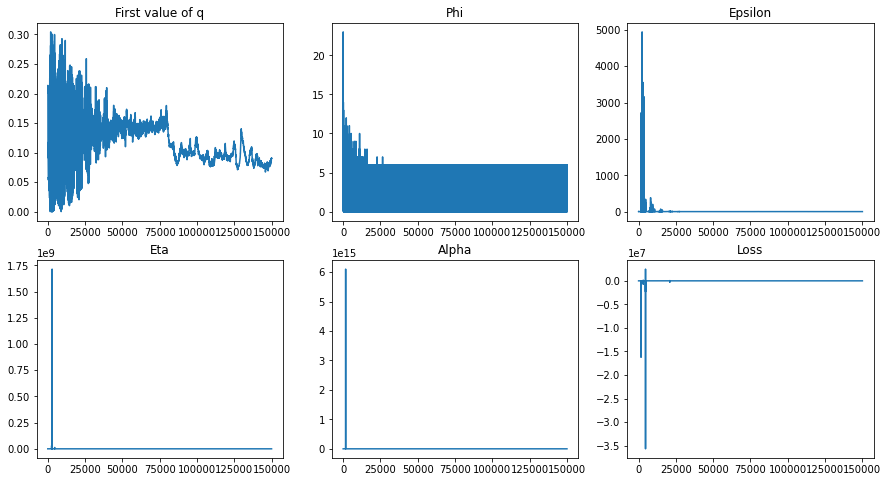

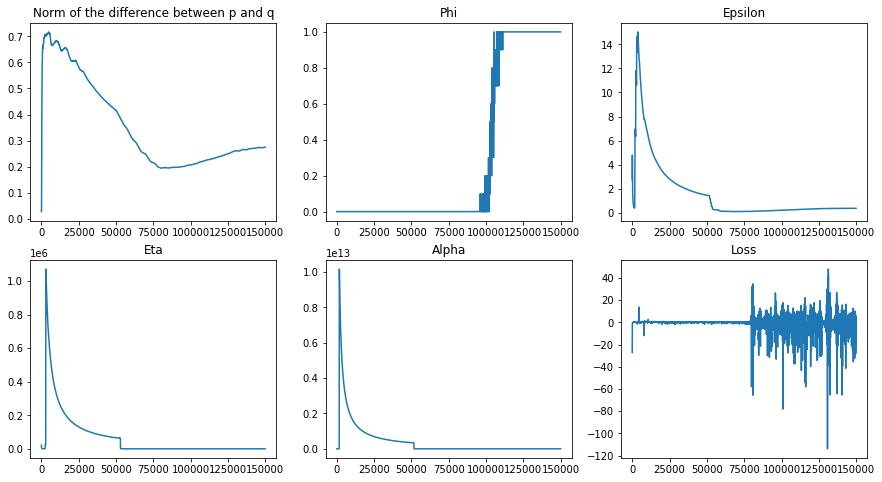

In [21]:
# ERM
dist = "erm"
perf_list_erm, eps_list_erm1, eps_list_erm2 = launch_exp(dist, w, delta, thresholds_, epochs)

perf_list = [1.4058440923690796] and eps_list1 = [0.3672927266523987] and eps_list2 = [tensor(0.2750, dtype=torch.float64)]


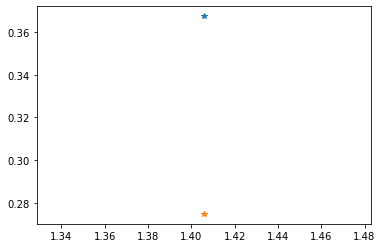

In [22]:
print(f"perf_list = {perf_list_erm} and eps_list1 = {eps_list_erm1} and eps_list2 = {eps_list_erm2}")

plt.plot(perf_list_erm, eps_list_erm1, '*')
plt.plot(perf_list_erm, eps_list_erm2, '*')
plt.show()


 	 EXP THRESHOLD 0 
 
 

epoch 0: 
 	 epsilon_=1.3205820322036743 and grad = 1.0 and lr = 0.011664999999999816 
 	 eta_=9.990045547485352 and grad = -1.0 and lr = 0.011664999999999816 
 	 alpha_=10.010045051574707 and grad = 0.14999260008335114 and lr = 0.011664999999999816 
 	 s_=tensor([-1.5512, -1.7335, -2.2178, -3.3809, -2.4466, -3.4275, -2.3862, -2.5685,
        -3.9956, -6.2782, -4.1960, -6.2962, -3.1846, -4.3478, -4.1474, -6.4300,
        -5.4729, -6.6124, -3.4275, -4.4083, -4.3618, -6.4620, -5.4869, -6.6263],
       requires_grad=True)
 	 q2=tensor([0.2011, 0.1701, 0.1101, 0.0356, 0.0885, 0.0341, 0.0937, 0.0787, 0.0194,
        0.0020, 0.0159, 0.0019, 0.0432, 0.0137, 0.0167, 0.0017, 0.0044, 0.0014,
        0.0341, 0.0129, 0.0135, 0.0016, 0.0043, 0.0014],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 1.0000,  1.0000, -0.8375, -0.2611, -0.7044, -0.2540, -0.6729, -0.5826,
        -0.1452, -0.0148, -0.1200, -0.0145, -0.3189, -0.1029, -0.1234, -0.0127,
        -0.0

epoch 10500: 
 	 epsilon_=0.07171513140201569 and grad = -0.059744346886873245 and lr = 1.257917499999999 
 	 eta_=0.12281806766986847 and grad = 0.029027510434389114 and lr = 1.257917499999999 
 	 alpha_=3.152608871459961 and grad = 0.017777740955352783 and lr = 1.257917499999999 
 	 s_=tensor([ 0.7190,  0.4095,  0.1781, -0.2007,  0.2686, -0.1735,  0.0759,  0.1874,
        -0.1709, -0.2219, -0.3523, -0.0540, -0.0368, -0.1552, -0.2023, -0.1609,
        -0.2701, -0.1050,  0.1095, -0.2192, -0.2587, -0.1288, -0.2893, -0.0619],
       requires_grad=True)
 	 q2=tensor([0.0694, 0.0568, 0.0478, 0.0369, 0.0502, 0.0391, 0.0444, 0.0479, 0.0387,
        0.0358, 0.0336, 0.0405, 0.0412, 0.0375, 0.0372, 0.0371, 0.0333, 0.0397,
        0.0466, 0.0357, 0.0356, 0.0402, 0.0345, 0.0402],
       grad_fn=<DivBackward0>) and sum=1.000000238418579 and grad = tensor([ 0.0089,  0.0039,  0.0038, -0.0018,  0.0076, -0.0035,  0.0045,  0.0033,
        -0.0024, -0.0017, -0.0029, -0.0016,  0.0033, -0.0017, -0.0016, -

epoch 21000: 
 	 epsilon_=0.014529779553413391 and grad = -0.012339239940047264 and lr = 0.6341668749999998 
 	 eta_=0.02380922995507717 and grad = -0.0070473006926476955 and lr = 0.6341668749999998 
 	 alpha_=2.7838780879974365 and grad = 0.009532718919217587 and lr = 0.6341668749999998 
 	 s_=tensor([-0.8902, -0.8029, -0.2156, -0.1666, -0.2903, -0.0312, -0.2194, -0.1130,
        -0.0095,  0.2758, -0.1400,  0.2921, -0.1160, -0.4088, -0.1080,  0.3035,
         0.2815,  0.3434, -0.0987, -0.3502, -0.2917,  0.2274,  0.2627,  0.3221],
       requires_grad=True)
 	 q2=tensor([0.0212, 0.0233, 0.0345, 0.0385, 0.0349, 0.0432, 0.0364, 0.0392, 0.0440,
        0.0539, 0.0385, 0.0542, 0.0393, 0.0319, 0.0414, 0.0543, 0.0528, 0.0539,
        0.0399, 0.0322, 0.0327, 0.0516, 0.0538, 0.0541],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 4.7347e-04,  9.4556e-04,  5.7838e-04, -9.2964e-04,  8.0325e-04,
        -1.3507e-04,  1.0644e-03,  1.2394e-03, -1.2641e-04, -1.1324e-03,
        -9.32

epoch 31500: 
 	 epsilon_=0.06424926966428757 and grad = -0.02594594657421112 and lr = 0.08809890625000007 
 	 eta_=0.6557919979095459 and grad = -0.12473329901695251 and lr = 0.08809890625000007 
 	 alpha_=3.404346466064453 and grad = 0.08161792159080505 and lr = 0.08809890625000007 
 	 s_=tensor([ 2.2218,  2.0432,  1.4882, -0.2616,  1.1842, -0.3166,  1.2960,  0.9280,
        -1.0074, -1.1479, -1.1540, -1.1617,  0.0140, -1.2059, -1.1837, -1.1650,
        -1.1609, -1.2005, -0.3447, -1.1876, -1.1845, -1.1686, -1.2048, -1.1963],
       requires_grad=True)
 	 q2=tensor([0.1405, 0.1305, 0.1026, 0.0347, 0.0870, 0.0330, 0.0922, 0.0776, 0.0188,
        0.0163, 0.0166, 0.0162, 0.0421, 0.0154, 0.0163, 0.0161, 0.0162, 0.0157,
        0.0326, 0.0159, 0.0160, 0.0163, 0.0156, 0.0158],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0333,  0.0316,  0.0247, -0.0196,  0.0209, -0.0179,  0.0215, -0.0335,
        -0.0116, -0.0108, -0.0113, -0.0107, -0.0230, -0.0106, -0.0111, -0.0105,
   

epoch 43500: 
 	 epsilon_=0.06096970662474632 and grad = -0.02775638923048973 and lr = 0.02952472656250002 
 	 eta_=0.5943995118141174 and grad = -0.09929195046424866 and lr = 0.02952472656250002 
 	 alpha_=3.4951765537261963 and grad = 0.07082770764827728 and lr = 0.02952472656250002 
 	 s_=tensor([ 1.9099,  1.9958,  1.6062, -0.2690,  1.1815, -0.3349,  1.2972,  0.9273,
        -1.0151, -1.1309, -1.1100, -1.1032, -0.0046, -1.1339, -1.1346, -1.1329,
        -1.1182, -1.1722, -0.3329, -1.1279, -1.0869, -1.1085, -1.1196, -1.1422],
       requires_grad=True)
 	 q2=tensor([0.1241, 0.1286, 0.1087, 0.0343, 0.0874, 0.0328, 0.0929, 0.0765, 0.0187,
        0.0170, 0.0172, 0.0174, 0.0420, 0.0169, 0.0169, 0.0169, 0.0171, 0.0162,
        0.0329, 0.0170, 0.0176, 0.0171, 0.0171, 0.0167],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 0.0136, -0.0113,  0.0269,  0.0148,  0.0343, -0.0189,  0.0311,  0.0250,
        -0.0106, -0.0117, -0.0124, -0.0095, -0.0188, -0.0115, -0.01

epoch 54000: 
 	 epsilon_=0.06585608422756195 and grad = -0.026934146881103516 and lr = 0.010003251953125004 
 	 eta_=0.6451427936553955 and grad = -0.125456765294075 and lr = 0.010003251953125004 
 	 alpha_=3.3164479732513428 and grad = 0.08471454679965973 and lr = 0.010003251953125004 
 	 s_=tensor([ 1.9970e+00,  2.0512e+00,  1.6272e+00, -2.6764e-01,  1.1665e+00,
        -3.2790e-01,  1.2977e+00,  9.5304e-01, -1.0125e+00, -1.1732e+00,
        -1.1701e+00, -1.1706e+00, -9.5096e-04, -1.1545e+00, -1.1581e+00,
        -1.1740e+00, -1.1551e+00, -1.1381e+00, -3.2717e-01, -1.1548e+00,
        -1.1694e+00, -1.1650e+00, -1.1551e+00, -1.1379e+00],
       requires_grad=True)
 	 q2=tensor([0.1283, 0.1312, 0.1091, 0.0343, 0.0867, 0.0328, 0.0929, 0.0773, 0.0187,
        0.0162, 0.0163, 0.0163, 0.0418, 0.0166, 0.0165, 0.0163, 0.0165, 0.0168,
        0.0328, 0.0165, 0.0163, 0.0164, 0.0165, 0.0168],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 0.0526, -0.0099,  0.0225

epoch 64500: 
 	 epsilon_=0.06304901093244553 and grad = -0.02736755833029747 and lr = 0.012437338867187498 
 	 eta_=0.6173229813575745 and grad = -0.11844502389431 and lr = 0.012437338867187498 
 	 alpha_=3.4166691303253174 and grad = 0.07672260701656342 and lr = 0.012437338867187498 
 	 s_=tensor([ 2.0768,  1.9998,  1.6285, -0.2791,  1.1652, -0.3456,  1.2813,  0.9448,
        -1.0301, -1.1835, -1.1769, -1.2029, -0.0115, -1.2085, -1.1754, -1.2048,
        -1.1512, -1.2247, -0.3360, -1.2102, -1.2169, -1.1738, -1.1646, -1.1806],
       requires_grad=True)
 	 q2=tensor([0.1334, 0.1295, 0.1100, 0.0342, 0.0873, 0.0326, 0.0929, 0.0774, 0.0186,
        0.0162, 0.0163, 0.0159, 0.0418, 0.0159, 0.0163, 0.0159, 0.0167, 0.0156,
        0.0328, 0.0158, 0.0158, 0.0164, 0.0165, 0.0162],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 0.0451,  0.0306, -0.0388,  0.0258,  0.0539,  0.0077, -0.0419,  0.0061,
        -0.0087, -0.0071, -0.0085, -0.0085, -0.0160, -0.0099, -0.00

epoch 75000: 
 	 epsilon_=0.0616585835814476 and grad = -0.027536414563655853 and lr = 0.011219075927734374 
 	 eta_=0.6024479866027832 and grad = -0.036680757999420166 and lr = 0.011219075927734374 
 	 alpha_=3.4295103549957275 and grad = 0.049585890024900436 and lr = 0.011219075927734374 
 	 s_=tensor([ 1.9747,  1.8985,  1.6324, -0.2688,  1.1704, -0.3273,  1.2888,  0.9517,
        -1.0196, -1.1256, -1.0949, -1.1120, -0.0028, -1.1021, -1.1259, -1.1211,
        -1.1396, -1.1021, -0.3275, -1.1306, -1.1321, -1.1188, -1.0847, -1.1120],
       requires_grad=True)
 	 q2=tensor([0.1270, 0.1233, 0.1093, 0.0343, 0.0871, 0.0328, 0.0926, 0.0773, 0.0186,
        0.0171, 0.0175, 0.0172, 0.0418, 0.0174, 0.0170, 0.0170, 0.0168, 0.0174,
        0.0328, 0.0170, 0.0169, 0.0172, 0.0176, 0.0172],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 0.0120,  0.0025,  0.0168,  0.0145,  0.0458, -0.0235, -0.0006,  0.0172,
         0.0045, -0.0179, -0.0143, -0.0118,  0.0033, -0.0133, 

epoch 85500: 
 	 epsilon_=0.0631391629576683 and grad = -0.02731340378522873 and lr = 0.010152536926269532 
 	 eta_=0.617664635181427 and grad = 0.08745437860488892 and lr = 0.010152536926269532 
 	 alpha_=3.406113624572754 and grad = 5.587935447692871e-08 and lr = 0.010152536926269532 
 	 s_=tensor([ 2.0222e+00,  2.0532e+00,  1.6145e+00, -2.6777e-01,  1.1720e+00,
        -3.2455e-01,  1.2986e+00,  9.5613e-01, -1.0205e+00, -1.1341e+00,
        -1.1646e+00, -1.1684e+00,  3.0537e-04, -1.1709e+00, -1.1567e+00,
        -1.1657e+00, -1.1711e+00, -1.1573e+00, -3.2557e-01, -1.1574e+00,
        -1.1550e+00, -1.1590e+00, -1.1592e+00, -1.1951e+00],
       requires_grad=True)
 	 q2=tensor([0.1297, 0.1313, 0.1083, 0.0343, 0.0870, 0.0328, 0.0930, 0.0772, 0.0186,
        0.0168, 0.0164, 0.0163, 0.0418, 0.0163, 0.0165, 0.0163, 0.0163, 0.0165,
        0.0328, 0.0165, 0.0165, 0.0165, 0.0165, 0.0159],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([-0.0040,  0.0134,  0.0258,

epoch 96000: 
 	 epsilon_=0.062055498361587524 and grad = -0.027381740510463715 and lr = 0.01000002540588379 
 	 eta_=0.610167384147644 and grad = 0.22494369745254517 and lr = 0.01000002540588379 
 	 alpha_=3.4095458984375 and grad = -0.05062707141041756 and lr = 0.01000002540588379 
 	 s_=tensor([ 2.0457,  1.9501,  1.6213, -0.2630,  1.1671, -0.3291,  1.2966,  0.9579,
        -1.0059, -1.1477, -1.1382, -1.1499, -0.0027, -1.1304, -1.1088, -1.1606,
        -1.1553, -1.1454, -0.3277, -1.1493, -1.1555, -1.1048, -1.1514, -1.1092],
       requires_grad=True)
 	 q2=tensor([0.1306, 0.1256, 0.1087, 0.0344, 0.0867, 0.0327, 0.0927, 0.0775, 0.0188,
        0.0166, 0.0168, 0.0166, 0.0417, 0.0169, 0.0172, 0.0165, 0.0165, 0.0166,
        0.0328, 0.0166, 0.0165, 0.0172, 0.0166, 0.0172],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0193,  0.0207,  0.0171, -0.0201,  0.0183,  0.0139,  0.0404, -0.0578,
        -0.0085, -0.0110, -0.0117, -0.0143,  0.0210, -0.0114, -0.0104, -0.0125,
    

epoch 106500: 
 	 epsilon_=0.05850132927298546 and grad = -0.028308305889368057 and lr = 0.010019041709899902 
 	 eta_=0.5622406601905823 and grad = -0.0930074155330658 and lr = 0.010019041709899902 
 	 alpha_=3.4787588119506836 and grad = 0.06769943237304688 and lr = 0.010019041709899902 
 	 s_=tensor([ 1.9508e+00,  1.9255e+00,  1.6431e+00, -2.6070e-01,  1.1876e+00,
        -3.2273e-01,  1.2956e+00,  9.6253e-01, -1.0122e+00, -1.1066e+00,
        -1.1062e+00, -1.0925e+00,  1.2755e-03, -1.1215e+00, -1.0996e+00,
        -1.1150e+00, -1.0740e+00, -1.1040e+00, -3.2216e-01, -1.0937e+00,
        -1.1001e+00, -1.0997e+00, -1.1111e+00, -1.1000e+00],
       requires_grad=True)
 	 q2=tensor([0.1252, 0.1240, 0.1094, 0.0344, 0.0874, 0.0328, 0.0923, 0.0773, 0.0186,
        0.0172, 0.0171, 0.0174, 0.0417, 0.0170, 0.0173, 0.0171, 0.0176, 0.0172,
        0.0328, 0.0174, 0.0173, 0.0172, 0.0171, 0.0173],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0237,  0.0284,  0.0064, -0.0194,  0

epoch 117000: 
 	 epsilon_=0.07145337015390396 and grad = -0.026082657277584076 and lr = 0.010009524030685425 
 	 eta_=0.6974719166755676 and grad = -0.16128967702388763 and lr = 0.010009524030685425 
 	 alpha_=3.2646775245666504 and grad = 0.09457075595855713 and lr = 0.010009524030685425 
 	 s_=tensor([ 2.1686,  2.2260,  1.6040, -0.2820,  1.1564, -0.3361,  1.2780,  0.9399,
        -1.0250, -1.3155, -1.2614, -1.3130, -0.0179, -1.3087, -1.1888, -1.2923,
        -1.2929, -1.2766, -0.3384, -1.3234, -1.2926, -1.2918, -1.3154, -1.3362],
       requires_grad=True)
 	 q2=tensor([0.1388, 0.1422, 0.1089, 0.0343, 0.0873, 0.0329, 0.0929, 0.0773, 0.0187,
        0.0145, 0.0152, 0.0145, 0.0418, 0.0146, 0.0162, 0.0148, 0.0148, 0.0150,
        0.0328, 0.0144, 0.0148, 0.0148, 0.0145, 0.0142],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 0.0293,  0.0199,  0.0239,  0.0084,  0.0238, -0.0261,  0.0013,  0.0243,
        -0.0168, -0.0134, -0.0143, -0.0145,  0.0059, -0.0128, 

epoch 127500: 
 	 epsilon_=0.07327304035425186 and grad = -0.02588954195380211 and lr = 0.010001191694736481 
 	 eta_=0.711453914642334 and grad = 0.23237937688827515 and lr = 0.010001191694736481 
 	 alpha_=3.1732592582702637 and grad = -0.06750326603651047 and lr = 0.010001191694736481 
 	 s_=tensor([ 2.1434,  2.2273,  1.6271, -0.2762,  1.1682, -0.3309,  1.2779,  0.9392,
        -1.0257, -1.2752, -1.2513, -1.2924, -0.0084, -1.2759, -1.1959, -1.2743,
        -1.2778, -1.2838, -0.3335, -1.2879, -1.2745, -1.2959, -1.2968, -1.2596],
       requires_grad=True)
 	 q2=tensor([0.1368, 0.1414, 0.1097, 0.0343, 0.0873, 0.0329, 0.0926, 0.0771, 0.0186,
        0.0149, 0.0153, 0.0147, 0.0418, 0.0149, 0.0160, 0.0149, 0.0149, 0.0148,
        0.0328, 0.0148, 0.0149, 0.0147, 0.0146, 0.0151],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0241,  0.0164, -0.0042,  0.0058,  0.0066, -0.0210,  0.0369,  0.0202,
        -0.0179, -0.0138, -0.0156, -0.0136,  0.0125, -0.0138, -0.0165, -0.0138,

epoch 138000: 
 	 epsilon_=0.06886997818946838 and grad = -0.026349443942308426 and lr = 0.010000000198483468 
 	 eta_=0.6754838824272156 and grad = 0.15788288414478302 and lr = 0.010000000198483468 
 	 alpha_=3.2010128498077393 and grad = -0.031514693051576614 and lr = 0.010000000198483468 
 	 s_=tensor([ 2.0649e+00,  2.1790e+00,  1.6414e+00, -2.6356e-01,  1.1841e+00,
        -3.2824e-01,  1.2923e+00,  9.5241e-01, -1.0117e+00, -1.1833e+00,
        -1.2274e+00, -1.2099e+00,  5.4165e-04, -1.2310e+00, -1.1868e+00,
        -1.2492e+00, -1.1990e+00, -1.1931e+00, -3.2082e-01, -1.2140e+00,
        -1.2256e+00, -1.2151e+00, -1.1938e+00, -1.2011e+00],
       requires_grad=True)
 	 q2=tensor([0.1315, 0.1377, 0.1094, 0.0343, 0.0874, 0.0327, 0.0926, 0.0770, 0.0187,
        0.0161, 0.0155, 0.0157, 0.0417, 0.0154, 0.0160, 0.0152, 0.0159, 0.0160,
        0.0328, 0.0156, 0.0155, 0.0157, 0.0159, 0.0158],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 0.0221,  0.0543,  0.

epoch 148500: 
 	 epsilon_=0.05992425978183746 and grad = -0.028023384511470795 and lr = 0.010000148763358594 
 	 eta_=0.5802945494651794 and grad = -0.09757378697395325 and lr = 0.010000148763358594 
 	 alpha_=3.4546988010406494 and grad = 0.07084821909666061 and lr = 0.010000148763358594 
 	 s_=tensor([ 1.8826,  2.0259,  1.6222, -0.2615,  1.1820, -0.3207,  1.2915,  0.9658,
        -1.0117, -1.1087, -1.1047, -1.1034,  0.0033, -1.1079, -1.1059, -1.0770,
        -1.0938, -1.1071, -0.3217, -1.1295, -1.0992, -1.0984, -1.1139, -1.1126],
       requires_grad=True)
 	 q2=tensor([0.1217, 0.1291, 0.1084, 0.0343, 0.0872, 0.0328, 0.0922, 0.0776, 0.0187,
        0.0171, 0.0172, 0.0172, 0.0417, 0.0172, 0.0172, 0.0176, 0.0174, 0.0171,
        0.0328, 0.0168, 0.0173, 0.0173, 0.0171, 0.0170],
       grad_fn=<DivBackward0>) and sum=0.9999998807907104 and grad = tensor([ 0.0277,  0.0199,  0.0218,  0.0121,  0.0203, -0.0168,  0.0212, -0.0300,
        -0.0107, -0.0108, -0.0104, -0.0102,  0.0114, -0.0110, 

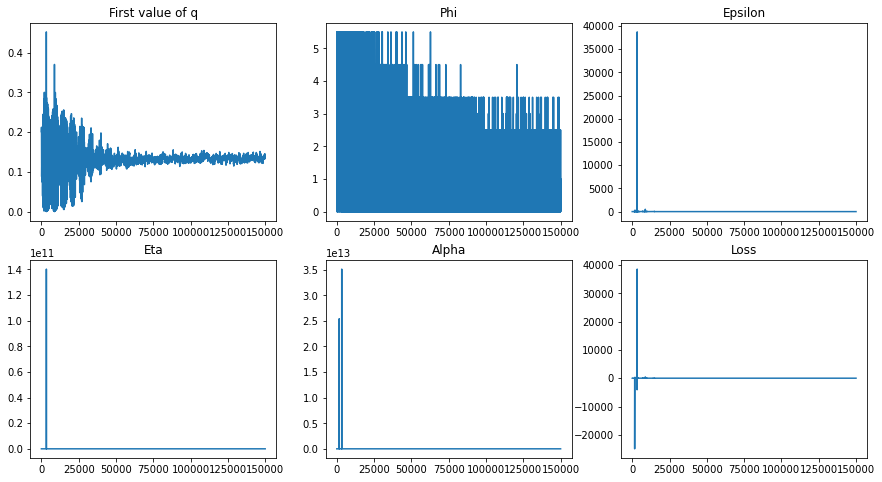

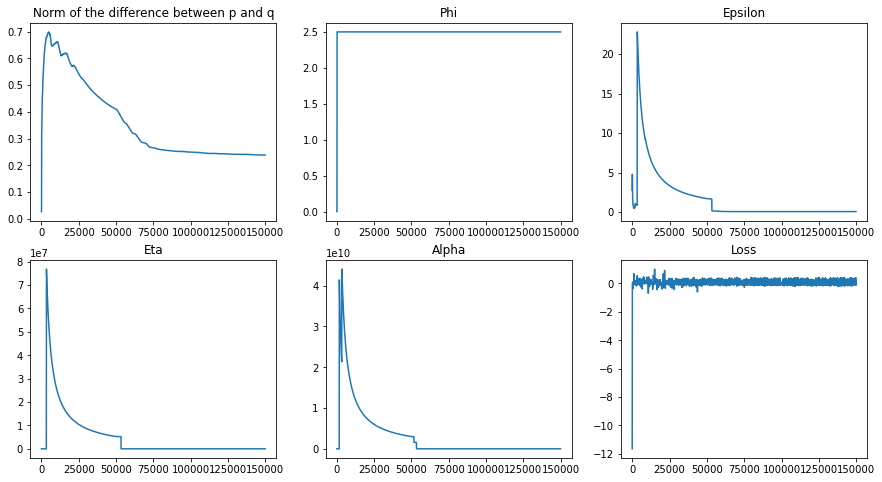

In [46]:
# Depth
dist = "depth"
perf_list_depth, eps_list_depth1, eps_list_depth2 = launch_exp(dist, w, delta, thresholds_, epochs)

perf_list = [1.4512985944747925] and eps_list1 = [0.06936287783324718] and eps_list2 = [tensor(0.2385, dtype=torch.float64)]


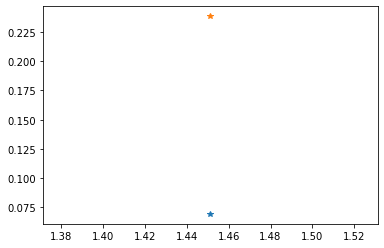

In [49]:
print(f"perf_list = {perf_list_depth} and eps_list1 = {eps_list_depth1} and eps_list2 = {eps_list_depth2}")
plt.plot(perf_list_depth, eps_list_depth1, '*')
plt.plot(perf_list_depth, eps_list_depth2, '*')
plt.show()


 	 EXP THRESHOLD 0.0 
 
 

epoch 0: 
 	 epsilon_=1.3205820322036743 and grad = 1.0 and lr = 0.011664999999999816 
 	 eta_=9.990045547485352 and grad = -1.0 and lr = 0.011664999999999816 
 	 alpha_=9.990045547485352 and grad = -0.09999489784240723 and lr = 0.011664999999999816 
 	 s_=tensor([-1.5512, -1.7335, -2.2178, -3.3809, -2.4466, -3.4275, -2.3862, -2.5685,
        -3.9956, -6.2782, -4.1960, -6.2962, -3.1846, -4.3478, -4.1474, -6.4300,
        -5.4729, -6.6124, -3.4275, -4.4083, -4.3618, -6.4620, -5.4869, -6.6263],
       requires_grad=True)
 	 q2=tensor([0.2011, 0.1701, 0.1101, 0.0356, 0.0885, 0.0341, 0.0937, 0.0787, 0.0194,
        0.0020, 0.0159, 0.0019, 0.0432, 0.0137, 0.0167, 0.0017, 0.0044, 0.0014,
        0.0341, 0.0129, 0.0135, 0.0016, 0.0043, 0.0014],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 1.0000,  1.0000, -0.8023, -0.2470, -0.6394, -0.2344, -0.6243, -0.5397,
        -0.1383, -0.0141, -0.1124, -0.0139, -0.2958, -0.0962, -0.1211, -0.0121,
        -0

epoch 10500: 
 	 epsilon_=2.775791108433623e-05 and grad = -2.1682875740225427e-05 and lr = 1.257917499999999 
 	 eta_=1.1070401342294645e-05 and grad = -5.310354481480317e-06 and lr = 1.257917499999999 
 	 alpha_=1.7641384601593018 and grad = 6.001298061164562e-06 and lr = 1.257917499999999 
 	 s_=tensor([-0.7895, -0.2177, -0.5647, -0.1384, -0.5431, -0.1481, -0.4007, -0.2724,
         0.0968,  0.7089,  0.1896,  0.7194, -0.1525,  0.0784,  0.1022,  0.7211,
         0.6259,  0.7261, -0.0900,  0.1489,  0.1371,  0.7049,  0.6294,  0.7288],
       requires_grad=True)
 	 q2=tensor([0.0205, 0.0347, 0.0239, 0.0328, 0.0241, 0.0324, 0.0278, 0.0304, 0.0391,
        0.0583, 0.0416, 0.0586, 0.0338, 0.0399, 0.0387, 0.0587, 0.0556, 0.0589,
        0.0354, 0.0408, 0.0415, 0.0579, 0.0559, 0.0589],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 1.7814e-07,  3.1090e-07,  2.5467e-07,  3.5010e-07,  2.2199e-07,
         1.5113e-07,  2.1793e-07,  2.7332e-07, -1.0399e-07, -8.8032

epoch 21000: 
 	 epsilon_=0.05423558130860329 and grad = -0.01345156505703926 and lr = 0.6341668749999998 
 	 eta_=0.7826212048530579 and grad = 0.3484465479850769 and lr = 0.6341668749999998 
 	 alpha_=4.084178447723389 and grad = -0.053692080080509186 and lr = 0.6341668749999998 
 	 s_=tensor([ 1.5875,  1.0346,  2.2502, -0.4394,  0.9671, -0.4989,  1.4979,  0.8019,
        -1.1587, -1.3435, -1.3323, -1.3064, -0.1542, -1.0765, -1.1195, -1.2874,
        -1.2536, -1.2679, -0.4775, -1.1662, -1.1747, -1.3940, -1.4713, -1.4058],
       requires_grad=True)
 	 q2=tensor([0.1037, 0.0793, 0.1545, 0.0314, 0.0843, 0.0343, 0.1118, 0.0735, 0.0181,
        0.0167, 0.0148, 0.0181, 0.0404, 0.0237, 0.0210, 0.0180, 0.0186, 0.0181,
        0.0338, 0.0201, 0.0196, 0.0153, 0.0156, 0.0153],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0474,  0.0450, -0.0393,  0.0211,  0.0365, -0.0194, -0.0434,  0.0382,
         0.0136, -0.0108,  0.0116, -0.0104,  0.0257, -0.0124, -0.0122, -0.0106,
      

epoch 31500: 
 	 epsilon_=0.04478705674409866 and grad = -0.03303104266524315 and lr = 0.08809890625000007 
 	 eta_=0.2893482744693756 and grad = -0.0489407479763031 and lr = 0.08809890625000007 
 	 alpha_=3.2001254558563232 and grad = 0.05476721003651619 and lr = 0.08809890625000007 
 	 s_=tensor([ 1.4305,  1.3834,  1.0849, -0.2423,  1.0789, -0.2949,  1.0845,  0.9599,
        -0.7092, -0.6480, -0.6913, -0.6460,  0.0235, -0.6691, -0.7005, -0.6622,
        -0.6366, -0.6512, -0.2937, -0.6765, -0.6423, -0.6393, -0.6596, -0.6489],
       requires_grad=True)
 	 q2=tensor([0.0979, 0.0957, 0.0816, 0.0342, 0.0813, 0.0330, 0.0816, 0.0759, 0.0236,
        0.0249, 0.0239, 0.0250, 0.0418, 0.0244, 0.0237, 0.0246, 0.0251, 0.0249,
        0.0329, 0.0243, 0.0250, 0.0251, 0.0247, 0.0249],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0125,  0.0124,  0.0116,  0.0068,  0.0116, -0.0080,  0.0116,  0.0112,
        -0.0062, -0.0065, -0.0063, -0.0065, -0.0096, -0.0064, -0.0062, -0.0064,
   

epoch 43500: 
 	 epsilon_=0.07595314085483551 and grad = -0.025747250765562057 and lr = 0.02952472656250002 
 	 eta_=0.7272046804428101 and grad = 0.0715705007314682 and lr = 0.02952472656250002 
 	 alpha_=2.899005889892578 and grad = 8.940696716308594e-08 and lr = 0.02952472656250002 
 	 s_=tensor([ 2.2625,  2.2293,  1.6150, -0.2627,  1.1796, -0.3135,  1.3078,  0.9430,
        -1.0065, -1.3056, -1.2217, -1.2789,  0.0079, -1.2938, -1.1854, -1.2709,
        -1.2383, -1.2730, -0.3170, -1.2869, -1.2898, -1.2407, -1.2766, -1.2709],
       requires_grad=True)
 	 q2=tensor([0.1419, 0.1402, 0.1076, 0.0343, 0.0866, 0.0330, 0.0930, 0.0763, 0.0186,
        0.0144, 0.0155, 0.0147, 0.0418, 0.0145, 0.0160, 0.0148, 0.0153, 0.0149,
        0.0329, 0.0146, 0.0146, 0.0152, 0.0147, 0.0148],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 0.0297,  0.0291,  0.0265,  0.0144,  0.0243, -0.0230, -0.0435,  0.0234,
        -0.0146, -0.0116, -0.0124, -0.0118,  0.0161, -0.0117, -0.01

epoch 54000: 
 	 epsilon_=0.10326126217842102 and grad = -0.022632203996181488 and lr = 0.010003251953125004 
 	 eta_=0.8775297999382019 and grad = -0.7266189455986023 and lr = 0.010003251953125004 
 	 alpha_=2.2990007400512695 and grad = 0.4499816596508026 and lr = 0.010003251953125004 
 	 s_=tensor([ 2.3105,  2.5107,  1.6219, -0.2720,  1.1572, -0.3346,  1.2909,  0.9493,
        -1.0224, -1.4661, -1.2555, -1.4671, -0.0038, -1.4221, -1.1948, -1.4661,
        -1.4711, -1.4587, -0.3304, -1.4554, -1.4316, -1.4496, -1.4877, -1.4572],
       requires_grad=True)
 	 q2=tensor([0.1458, 0.1568, 0.1093, 0.0343, 0.0866, 0.0327, 0.0929, 0.0773, 0.0186,
        0.0126, 0.0152, 0.0126, 0.0419, 0.0131, 0.0160, 0.0126, 0.0125, 0.0127,
        0.0328, 0.0127, 0.0129, 0.0128, 0.0124, 0.0127],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 0.0223,  0.0227,  0.0205,  0.0107,  0.0187,  0.0103,  0.0192,  0.0177,
        -0.0216, -0.0153, -0.0180, -0.0153, -0.0409, -0.0158, -0.

epoch 64500: 
 	 epsilon_=0.09643877297639847 and grad = -0.023252218961715698 and lr = 0.012437338867187498 
 	 eta_=0.8494368195533752 and grad = 0.270269513130188 and lr = 0.012437338867187498 
 	 alpha_=2.5625295639038086 and grad = -0.11957935243844986 and lr = 0.012437338867187498 
 	 s_=tensor([ 2.2129,  2.4411,  1.5988, -0.2849,  1.1520, -0.3460,  1.2648,  0.9307,
        -1.0342, -1.4145, -1.2635, -1.4268, -0.0252, -1.4289, -1.2107, -1.4325,
        -1.4239, -1.4278, -0.3467, -1.4310, -1.4316, -1.4187, -1.4255, -1.4288],
       requires_grad=True)
 	 q2=tensor([0.1419, 0.1546, 0.1092, 0.0344, 0.0874, 0.0328, 0.0927, 0.0774, 0.0186,
        0.0133, 0.0152, 0.0132, 0.0417, 0.0132, 0.0160, 0.0131, 0.0132, 0.0132,
        0.0328, 0.0131, 0.0131, 0.0133, 0.0132, 0.0132],
       grad_fn=<DivBackward0>) and sum=1.000000238418579 and grad = tensor([ 0.0135,  0.0352,  0.0416, -0.0312,  0.0202,  0.0182,  0.0217, -0.0437,
        -0.0200, -0.0137, -0.0184, -0.0128,  0.0060, -0.0153, -0.0

epoch 76500: 
 	 epsilon_=0.3125890791416168 and grad = -0.008817672729492188 and lr = 0.010609334716796875 
 	 eta_=1.3369078636169434 and grad = -1.0 and lr = 0.010609334716796875 
 	 alpha_=0.11907844990491867 and grad = 1.0 and lr = 0.010609334716796875 
 	 s_=tensor([ 1.5109,  2.9320,  1.8603, -0.1465,  1.3673, -0.2186,  1.4709,  1.0859,
        -0.8199, -1.3411, -0.9381, -1.1562,  0.1381, -1.1527, -1.0774, -1.3110,
        -1.2969, -1.0873, -0.2037, -1.0995, -0.9678, -0.9200, -0.7078, -0.1263],
       requires_grad=True)
 	 q2=tensor([0.0927, 0.1618, 0.1086, 0.0338, 0.0864, 0.0320, 0.0911, 0.0746, 0.0198,
        0.0126, 0.0179, 0.0149, 0.0415, 0.0149, 0.0159, 0.0130, 0.0131, 0.0158,
        0.0323, 0.0156, 0.0175, 0.0182, 0.0218, 0.0342],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-0.4608,  0.4619,  0.3340,  0.0240, -0.3376, -0.0040, -0.1541, -0.0491,
        -0.0230, -0.0190, -0.0301, -0.0162,  0.1612, -0.0134,  0.0077, -0.0223,
        -0.0235, -0.0172,  0.0

epoch 88500: 
 	 epsilon_=0.15820953249931335 and grad = -0.016457319259643555 and lr = 0.010152333679199219 
 	 eta_=1.0606889724731445 and grad = 1.0 and lr = 0.010152333679199219 
 	 alpha_=0.2460462599992752 and grad = -1.0 and lr = 0.010152333679199219 
 	 s_=tensor([ 1.4944,  3.0753,  1.5347, -0.1230,  1.4061, -0.1956,  1.4894,  1.1440,
        -0.9058, -1.0333, -0.9263, -1.0808,  0.1417, -1.1641, -1.0663, -1.1268,
        -1.1223, -1.0072, -0.1952, -0.9433, -0.9192, -0.7921, -1.1136, -0.7881],
       requires_grad=True)
 	 q2=tensor([0.0927, 0.1706, 0.0945, 0.0346, 0.0888, 0.0328, 0.0925, 0.0777, 0.0186,
        0.0166, 0.0182, 0.0160, 0.0419, 0.0149, 0.0162, 0.0153, 0.0154, 0.0170,
        0.0328, 0.0180, 0.0184, 0.0204, 0.0155, 0.0205],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.1247, -0.0240,  0.2212, -0.0106, -0.1075, -0.0300, -0.0650,  0.0247,
         0.0227, -0.0060, -0.0328, -0.0071,  0.0348, -0.0205, -0.0025, -0.0022,
        -0.0256, -0.0137, -0.0

epoch 99000: 
 	 epsilon_=0.5083010792732239 and grad = -0.0017982125282287598 and lr = 0.010076192245483399 
 	 eta_=1.658585548400879 and grad = -0.18497848510742188 and lr = 0.010076192245483399 
 	 alpha_=0.04992520809173584 and grad = 3.0517578125e-05 and lr = 0.010076192245483399 
 	 s_=tensor([ 1.3703,  3.0317,  1.6903, -0.1169,  1.2875, -0.1872,  1.2953,  1.1367,
        -0.9179, -1.3505, -0.9710, -1.2036,  0.1480, -1.1035, -1.0831, -1.5325,
        -1.0968, -0.8974, -0.1036, -1.0983, -1.2358, -0.6962, -0.8941, -0.5477],
       requires_grad=True)
 	 q2=tensor([0.0888, 0.1714, 0.1035, 0.0354, 0.0853, 0.0336, 0.0856, 0.0787, 0.0187,
        0.0128, 0.0178, 0.0146, 0.0429, 0.0159, 0.0162, 0.0109, 0.0160, 0.0191,
        0.0359, 0.0160, 0.0142, 0.0225, 0.0191, 0.0254],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 1.0000, -1.0000, -0.6163,  1.0000, -1.0000,  0.9702,  1.0000,  1.0000,
        -0.1195,  0.0493,  0.1138,  0.0211, -0.1489,  0.0829,  0.2

epoch 109500: 
 	 epsilon_=0.6557638645172119 and grad = 0.0016276836395263672 and lr = 0.010009533557891847 
 	 eta_=1.928295373916626 and grad = -0.2673530578613281 and lr = 0.010009533557891847 
 	 alpha_=0.028793318197131157 and grad = 7.62939453125e-05 and lr = 0.010009533557891847 
 	 s_=tensor([ 1.7872,  2.7385,  1.2947, -0.1672,  1.0313, -0.0554,  0.9474,  1.2449,
        -0.9583, -0.8186, -0.9392, -1.1665,  0.0542, -0.9281, -0.8408, -1.3550,
        -1.0440, -0.9634, -0.1169, -1.1340, -0.7860, -0.8870, -0.7275, -0.8380],
       requires_grad=True)
 	 q2=tensor([0.1103, 0.1592, 0.0872, 0.0348, 0.0760, 0.0377, 0.0725, 0.0851, 0.0184,
        0.0207, 0.0187, 0.0154, 0.0409, 0.0190, 0.0204, 0.0130, 0.0171, 0.0184,
        0.0361, 0.0158, 0.0213, 0.0196, 0.0223, 0.0204],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([-1.0000, -1.0000,  1.0000, -0.5943, -1.0000,  1.0000, -1.0000, -1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000, -1.0000,  1.

epoch 120000: 
 	 epsilon_=0.2259906679391861 and grad = -0.01369619369506836 and lr = 0.010000001587867737 
 	 eta_=1.1866414546966553 and grad = 1.0 and lr = 0.010000001587867737 
 	 alpha_=0.1549312174320221 and grad = -1.0 and lr = 0.010000001587867737 
 	 s_=tensor([ 0.9047,  2.9448,  1.8068, -0.1381,  1.3593, -0.2178,  1.1269,  1.0962,
        -0.9387, -1.2769, -1.0769, -1.1433,  0.1063, -0.8354, -1.1040, -1.2857,
        -0.9224, -0.9228, -0.2071, -0.9993, -0.8717, -0.7944, -0.3836, -0.3199],
       requires_grad=True)
 	 q2=tensor([0.0693, 0.1669, 0.1091, 0.0349, 0.0885, 0.0329, 0.0785, 0.0771, 0.0184,
        0.0137, 0.0163, 0.0154, 0.0417, 0.0201, 0.0160, 0.0136, 0.0187, 0.0186,
        0.0332, 0.0175, 0.0195, 0.0208, 0.0290, 0.0304],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 0.1812,  0.4332, -0.1199, -0.0822, -0.0765, -0.1019, -0.1496, -0.1591,
        -0.0108, -0.0613, -0.0529,  0.0060,  0.0677, -0.0750, -0.0076, -0.0314,
        -0.0014,

epoch 130500: 
 	 epsilon_=0.16742229461669922 and grad = -0.016174331307411194 and lr = 0.010001190106868745 
 	 eta_=1.078751564025879 and grad = 1.0 and lr = 0.010001190106868745 
 	 alpha_=0.16142338514328003 and grad = -1.0 and lr = 0.010001190106868745 
 	 s_=tensor([ 1.7290,  2.7304,  1.4487, -0.1025,  1.4619, -0.1307,  1.1970,  1.2321,
        -0.8506, -1.2762, -1.0820, -0.9614,  0.2149, -1.0081, -1.0362, -0.9725,
        -0.7711, -0.5077, -0.1249, -1.0933, -0.7941, -0.2029, -0.5192,  0.0083],
       requires_grad=True)
 	 q2=tensor([0.0991, 0.1462, 0.0869, 0.0337, 0.0874, 0.0330, 0.0764, 0.0779, 0.0186,
        0.0129, 0.0153, 0.0169, 0.0422, 0.0163, 0.0159, 0.0168, 0.0199, 0.0247,
        0.0331, 0.0151, 0.0195, 0.0313, 0.0244, 0.0365],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 0.1052,  0.1145, -0.0044,  0.0205,  0.0511, -0.0043, -0.1229, -0.0291,
        -0.0123, -0.0118, -0.0179, -0.0169, -0.0553, -0.0147,  0.0107, -0.0161,
        -0.014

epoch 142500: 
 	 epsilon_=0.556816816329956 and grad = -0.007050514221191406 and lr = 0.010000297526717185 
 	 eta_=1.730002522468567 and grad = -0.20173072814941406 and lr = 0.010000297526717185 
 	 alpha_=0.04083976522088051 and grad = 4.57763671875e-05 and lr = 0.010000297526717185 
 	 s_=tensor([ 1.2895,  2.5108,  1.3212, -0.2440,  1.0966, -0.1821,  1.2205,  0.9392,
        -0.8321, -1.4270, -0.9535, -1.1830, -0.0613, -1.2839, -1.2243, -1.5860,
        -1.2492, -1.1962, -0.0761, -1.0606, -0.7658, -0.9813, -1.0595, -0.6030],
       requires_grad=True)
 	 q2=tensor([0.0934, 0.1576, 0.0948, 0.0352, 0.0843, 0.0369, 0.0902, 0.0773, 0.0220,
        0.0131, 0.0198, 0.0163, 0.0404, 0.0149, 0.0157, 0.0113, 0.0154, 0.0161,
        0.0400, 0.0181, 0.0232, 0.0194, 0.0182, 0.0266],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.2597, -1.0000,  0.5723,  0.7016,  1.0000,  0.2067,  0.0417,  1.0000,
         0.4584,  0.4221,  0.1091, -0.4743, -1.0000,  0.5285, -0.2794,  0.1667,
 

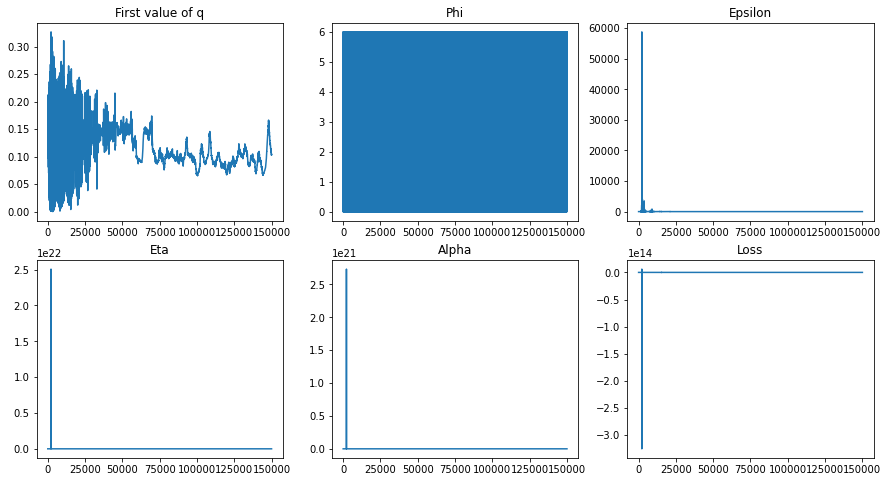


 


 	 EXP THRESHOLD 0.05 
 
 

epoch 0: 
 	 epsilon_=1.3205820322036743 and grad = 1.0 and lr = 0.011664999999999816 
 	 eta_=9.990045547485352 and grad = -1.0 and lr = 0.011664999999999816 
 	 alpha_=10.010045051574707 and grad = 0.24998760223388672 and lr = 0.011664999999999816 
 	 s_=tensor([-1.5512, -1.7335, -2.2178, -3.3809, -2.4466, -3.4275, -2.3862, -2.5685,
        -3.9956, -6.2782, -4.1960, -6.2962, -3.1846, -4.3478, -4.1474, -6.4300,
        -5.4729, -6.6124, -3.4275, -4.4083, -4.3618, -6.4620, -5.4869, -6.6263],
       requires_grad=True)
 	 q2=tensor([0.2011, 0.1701, 0.1101, 0.0356, 0.0885, 0.0341, 0.0937, 0.0787, 0.0194,
        0.0020, 0.0159, 0.0019, 0.0432, 0.0137, 0.0167, 0.0017, 0.0044, 0.0014,
        0.0341, 0.0129, 0.0135, 0.0016, 0.0043, 0.0014],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 1.0000,  1.0000, -0.8036, -0.2542, -0.6335, -0.2469, -0.6860, -0.5421,
        -0.1438, -0.0145, -0.1174, -0.0142, -0.3078, -0.1005, -0.1228, -0.0124,
     

epoch 10500: 
 	 epsilon_=0.7212319374084473 and grad = -1.0 and lr = 1.257917499999999 
 	 eta_=0.06265012919902802 and grad = -0.23944731056690216 and lr = 1.257917499999999 
 	 alpha_=5.570228099822998 and grad = 0.003792352508753538 and lr = 1.257917499999999 
 	 s_=tensor([ 3.8747,  3.0137,  2.1275, -0.0039,  1.5982, -0.1666,  1.0637,  1.0975,
        -0.4039, -1.9911, -0.9499, -1.9186,  0.3909, -1.0343, -0.7034, -1.9424,
        -1.8158, -1.8837, -0.0736, -1.1003, -0.5571, -1.9092, -1.6912, -1.9040],
       requires_grad=True)
 	 q2=tensor([0.2006, 0.1586, 0.1144, 0.0344, 0.0849, 0.0291, 0.0767, 0.0741, 0.0236,
        0.0052, 0.0151, 0.0056, 0.0420, 0.0139, 0.0188, 0.0053, 0.0062, 0.0057,
        0.0347, 0.0130, 0.0202, 0.0055, 0.0068, 0.0054],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0094,  0.0060, -0.0048, -0.0082,  0.0025,  0.0047,  0.0044,  0.0020,
        -0.0053, -0.0015,  0.0028, -0.0016, -0.0080, -0.0033, -0.0045, -0.0014,
        -0.0017, -0.0015

epoch 21000: 
 	 epsilon_=0.08568228781223297 and grad = 0.0682872086763382 and lr = 0.6341668749999998 
 	 eta_=2.112936019897461 and grad = -0.8035385012626648 and lr = 0.6341668749999998 
 	 alpha_=4.5957183837890625 and grad = 0.48684775829315186 and lr = 0.6341668749999998 
 	 s_=tensor([ 2.9214,  3.2247,  1.5753, -0.0210,  1.2666, -0.2371,  1.2741,  1.0274,
        -0.7302, -1.5115, -1.2264, -1.2702, -0.0471, -1.2919, -1.2732, -1.5254,
        -1.7919, -1.7650, -0.2829, -1.1341, -1.4049, -1.8211, -1.6007, -1.3796],
       requires_grad=True)
 	 q2=tensor([0.1495, 0.1618, 0.1115, 0.0342, 0.0790, 0.0320, 0.0900, 0.0714, 0.0209,
        0.0131, 0.0136, 0.0161, 0.0388, 0.0157, 0.0162, 0.0131, 0.0094, 0.0104,
        0.0345, 0.0181, 0.0143, 0.0094, 0.0122, 0.0147],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 0.0551,  0.1119, -0.1291,  0.0471,  0.0637,  0.0413,  0.0468, -0.0008,
        -0.0491, -0.0330,  0.0151, -0.0355,  0.0486, -0.0373, -0.0380, -0.

epoch 33000: 
 	 epsilon_=0.13042674958705902 and grad = -0.0457402840256691 and lr = 0.16604171874999996 
 	 eta_=0.77629154920578 and grad = -0.4667050540447235 and lr = 0.16604171874999996 
 	 alpha_=3.0723202228546143 and grad = 0.21429336071014404 and lr = 0.16604171874999996 
 	 s_=tensor([ 3.0788,  2.4390,  1.3844, -0.2949,  0.9679, -0.4070,  1.1076,  0.9278,
        -1.0098, -1.5227, -1.2478, -1.5718, -0.0870, -1.3921, -1.2024, -1.5934,
        -1.6171, -1.5511, -0.3677, -1.4983, -1.4132, -1.7295, -1.7255, -1.5440],
       requires_grad=True)
 	 q2=tensor([0.1905, 0.1561, 0.0986, 0.0334, 0.0797, 0.0315, 0.0854, 0.0769, 0.0193,
        0.0115, 0.0157, 0.0112, 0.0394, 0.0132, 0.0161, 0.0108, 0.0106, 0.0114,
        0.0318, 0.0128, 0.0131, 0.0098, 0.0099, 0.0113],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 0.0235,  0.0095,  0.0177,  0.0080,  0.0097,  0.0077,  0.0188,  0.0045,
        -0.0219, -0.0144, -0.0187, -0.0140,  0.0068, -0.0158, -0.0190, 

epoch 45000: 
 	 epsilon_=0.07325013726949692 and grad = -0.02566058188676834 and lr = 0.04901042968749999 
 	 eta_=0.7092545032501221 and grad = -0.20061707496643066 and lr = 0.04901042968749999 
 	 alpha_=2.793992519378662 and grad = 0.1284162849187851 and lr = 0.04901042968749999 
 	 s_=tensor([ 2.5121e+00,  2.0962e+00,  1.5792e+00, -2.5948e-01,  1.1658e+00,
        -3.1572e-01,  1.1816e+00,  9.6558e-01, -9.9368e-01, -1.2721e+00,
        -1.2041e+00, -1.2646e+00,  1.0746e-03, -1.3309e+00, -1.1828e+00,
        -1.2709e+00, -1.2410e+00, -1.2708e+00, -3.2925e-01, -1.2795e+00,
        -1.2510e+00, -1.2851e+00, -1.2663e+00, -1.2865e+00],
       requires_grad=True)
 	 q2=tensor([0.1554, 0.1331, 0.1059, 0.0344, 0.0866, 0.0329, 0.0868, 0.0771, 0.0189,
        0.0148, 0.0157, 0.0149, 0.0416, 0.0140, 0.0161, 0.0148, 0.0152, 0.0148,
        0.0326, 0.0148, 0.0152, 0.0147, 0.0149, 0.0147],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0261,  0.0179,  0.0220, -0.0272,  0.0104,

epoch 55500: 
 	 epsilon_=0.08574140816926956 and grad = -0.024734199047088623 and lr = 0.014881181640625005 
 	 eta_=0.788445234298706 and grad = -0.2827068567276001 and lr = 0.014881181640625005 
 	 alpha_=2.543762683868408 and grad = 0.16928237676620483 and lr = 0.014881181640625005 
 	 s_=tensor([ 2.6170,  2.4129,  1.6929, -0.2327,  1.2263, -0.2949,  1.3419,  1.0007,
        -0.9920, -1.4871, -1.2221, -1.4826,  0.0325, -1.3926, -1.1673, -1.4753,
        -1.4721, -1.4540, -0.2949, -1.4463, -1.4075, -1.4732, -1.4790, -1.4646],
       requires_grad=True)
 	 q2=tensor([0.1584, 0.1472, 0.1097, 0.0344, 0.0874, 0.0328, 0.0927, 0.0774, 0.0186,
        0.0120, 0.0152, 0.0121, 0.0418, 0.0131, 0.0160, 0.0121, 0.0122, 0.0124,
        0.0328, 0.0125, 0.0129, 0.0122, 0.0121, 0.0122],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0267,  0.0181,  0.0136, -0.0249,  0.0301,  0.0143,  0.0299, -0.0482,
         0.0099, -0.0111, -0.0145, -0.0123,  0.0102, -0.0139,  0.0052, -0.0133,
 

epoch 67500: 
 	 epsilon_=1.2222511768341064 and grad = 0.010340452194213867 and lr = 0.011220295410156251 
 	 eta_=3.4083828926086426 and grad = -0.83892822265625 and lr = 0.011220295410156251 
 	 alpha_=0.005608102772384882 and grad = 0.0006103515625 and lr = 0.011220295410156251 
 	 s_=tensor([ 2.5652,  1.6081,  1.4706, -0.0389,  1.0812, -0.1343,  1.1686,  0.8327,
        -0.7320, -1.1729, -0.9128, -1.4084,  0.0922, -0.7082, -0.9985, -1.0276,
        -1.0730, -0.6600, -0.1175, -0.5169, -1.0605, -0.7213, -0.8918, -0.9378],
       requires_grad=True)
 	 q2=tensor([0.1503, 0.1019, 0.0955, 0.0384, 0.0781, 0.0358, 0.0818, 0.0679, 0.0223,
        0.0154, 0.0192, 0.0124, 0.0422, 0.0228, 0.0178, 0.0174, 0.0167, 0.0237,
        0.0362, 0.0266, 0.0169, 0.0226, 0.0195, 0.0188],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([-1., -1., -1., -1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1., -1.,  1.,
         1., -1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.]) and lr = 0.01

epoch 79500: 
 	 epsilon_=0.0591970831155777 and grad = -0.028520796447992325 and lr = 0.010305073852539063 
 	 eta_=0.562755823135376 and grad = -1.0 and lr = 0.010305073852539063 
 	 alpha_=0.07461107522249222 and grad = 1.0 and lr = 0.010305073852539063 
 	 s_=tensor([ 1.3883,  0.7170,  1.1400,  0.8951,  0.4496,  0.2132,  0.6881,  0.3445,
        -0.4661, -0.6955, -0.3144, -0.5801,  0.1925, -0.3164, -0.6543, -0.5428,
        -0.2858,  0.0992, -0.0883, -0.2036, -0.3485, -0.7491, -0.0298,  0.0268],
       requires_grad=True)
 	 q2=tensor([0.0892, 0.0617, 0.0785, 0.0686, 0.0522, 0.0446, 0.0606, 0.0487, 0.0270,
        0.0224, 0.0303, 0.0246, 0.0439, 0.0303, 0.0232, 0.0254, 0.0310, 0.0412,
        0.0360, 0.0330, 0.0296, 0.0214, 0.0376, 0.0391],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-0.0197, -0.1439,  0.1434, -0.0834,  0.0804, -0.0112,  0.0717, -0.0391,
        -0.0055, -0.0056,  0.0767, -0.0338, -0.0228, -0.0003, -0.0020,  0.0145,
        -0.0041,  0.0031,  0.01

epoch 91500: 
 	 epsilon_=0.035287607461214066 and grad = -0.03326021879911423 and lr = 0.010076268463134766 
 	 eta_=0.07661786675453186 and grad = -0.04691040515899658 and lr = 0.010076268463134766 
 	 alpha_=1.1214529275894165 and grad = 0.061559952795505524 and lr = 0.010076268463134766 
 	 s_=tensor([ 1.3399,  0.6249,  0.7509,  0.1961,  0.6101,  0.2638,  0.7075,  0.2134,
        -0.5316, -0.5154, -0.3491, -0.5556,  0.1368, -0.1437, -0.2674, -0.3731,
        -0.1622, -0.1386,  0.0701, -0.3641, -0.2872, -0.2525, -0.3898, -0.2171],
       requires_grad=True)
 	 q2=tensor([0.0899, 0.0602, 0.0650, 0.0455, 0.0597, 0.0477, 0.0634, 0.0461, 0.0264,
        0.0268, 0.0305, 0.0259, 0.0437, 0.0357, 0.0325, 0.0300, 0.0352, 0.0358,
        0.0417, 0.0302, 0.0320, 0.0329, 0.0296, 0.0338],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 1.0280e-02,  4.2128e-03,  1.2948e-03,  1.4361e-03,  1.0709e-03,
        -1.5836e-03,  1.1482e-03,  3.3212e-03, -2.8895e-03,  1.0606e

epoch 103500: 
 	 epsilon_=0.03437807038426399 and grad = -0.03353060036897659 and lr = 0.010019067115783691 
 	 eta_=0.042743925005197525 and grad = -0.1252988874912262 and lr = 0.010019067115783691 
 	 alpha_=1.1802321672439575 and grad = 0.0957607701420784 and lr = 0.010019067115783691 
 	 s_=tensor([ 0.7639,  0.6270,  0.4337,  0.4002,  0.4151,  0.1066,  0.1908,  0.2859,
        -0.1227, -0.4901, -0.5001, -0.2678, -0.0246, -0.1708, -0.1156, -0.1411,
        -0.1126,  0.1518,  0.0101, -0.3096, -0.1865, -0.1414, -0.0923,  0.1874],
       requires_grad=True)
 	 q2=tensor([0.0659, 0.0607, 0.0537, 0.0525, 0.0530, 0.0430, 0.0456, 0.0487, 0.0364,
        0.0275, 0.0273, 0.0327, 0.0391, 0.0352, 0.0366, 0.0359, 0.0367, 0.0444,
        0.0401, 0.0316, 0.0347, 0.0359, 0.0373, 0.0455],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([-1.8754e-03,  2.6591e-03, -1.2634e-04, -4.0311e-04,  3.5839e-03,
        -3.4967e-03,  3.5325e-03,  3.4370e-03,  6.4283e-04,  1.4147e-0

epoch 115500: 
 	 epsilon_=0.13231295347213745 and grad = -0.01863587647676468 and lr = 0.010004766778945923 
 	 eta_=0.9924659132957458 and grad = -0.012113973498344421 and lr = 0.010004766778945923 
 	 alpha_=3.3548429012298584 and grad = 0.1270991414785385 and lr = 0.010004766778945923 
 	 s_=tensor([ 1.1189,  1.0664,  1.0422, -0.2201,  1.1741, -0.2806,  1.0204,  0.9075,
        -0.5349, -0.5894, -0.5636, -0.5441,  0.0471, -0.4865, -0.5357, -0.5334,
        -0.4798, -0.4292, -0.2810, -0.4802, -0.5219, -0.4927, -0.5290, -0.3941],
       requires_grad=True)
 	 q2=tensor([0.0816, 0.0794, 0.0783, 0.0343, 0.0840, 0.0328, 0.0773, 0.0726, 0.0269,
        0.0258, 0.0263, 0.0267, 0.0418, 0.0280, 0.0269, 0.0269, 0.0281, 0.0293,
        0.0328, 0.0281, 0.0272, 0.0278, 0.0270, 0.0301],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0232, -0.0230,  0.0387,  0.0188,  0.0636,  0.0347,  0.0577,  0.0065,
        -0.0263, -0.0225, -0.0230, -0.0315, -0.0510, -0.0157, -0.0258, -0.0222

epoch 127500: 
 	 epsilon_=0.2875438332557678 and grad = -0.011205345392227173 and lr = 0.010001191694736481 
 	 eta_=1.2932571172714233 and grad = 0.6599658727645874 and lr = 0.010001191694736481 
 	 alpha_=0.9268503189086914 and grad = -0.8955681920051575 and lr = 0.010001191694736481 
 	 s_=tensor([ 2.7617,  2.6894,  1.6358, -0.2367,  1.2212, -0.2921,  1.3047,  0.9584,
        -0.9890, -1.6592, -1.2209, -1.6621,  0.0353, -1.3908, -1.1650, -1.6593,
        -1.6497, -1.6450, -0.2924, -1.4583, -1.4052, -1.6645, -1.6494, -1.6334],
       requires_grad=True)
 	 q2=tensor([0.1659, 0.1620, 0.1067, 0.0342, 0.0870, 0.0328, 0.0908, 0.0755, 0.0186,
        0.0103, 0.0152, 0.0102, 0.0418, 0.0131, 0.0160, 0.0102, 0.0103, 0.0104,
        0.0328, 0.0123, 0.0129, 0.0102, 0.0103, 0.0105],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0368,  0.0379,  0.0282,  0.0062, -0.0021, -0.0430,  0.0527, -0.0144,
         0.0010, -0.0218,  0.0047, -0.0203, -0.0745,  0.0063, -0.0324, -0.0214,


epoch 139500: 
 	 epsilon_=1.649949550628662 and grad = 0.014707565307617188 and lr = 0.01000029792368412 
 	 eta_=5.226812362670898 and grad = 1.0 and lr = 0.01000029792368412 
 	 alpha_=7.439756882376969e-05 and grad = -1.0 and lr = 0.01000029792368412 
 	 s_=tensor([ 1.7749,  1.8533,  1.2298,  0.2242,  0.8204,  0.0986,  1.0730,  0.4688,
        -0.6267, -1.2663, -0.8905, -1.3179,  0.1561, -0.7609, -0.3418, -1.1121,
        -0.9805, -1.0098, -0.2437, -1.0372, -0.9867, -1.0708, -1.0207, -0.9580],
       requires_grad=True)
 	 q2=tensor([0.1173, 0.1214, 0.0903, 0.0493, 0.0719, 0.0451, 0.0830, 0.0580, 0.0260,
        0.0151, 0.0209, 0.0144, 0.0471, 0.0233, 0.0326, 0.0172, 0.0194, 0.0188,
        0.0351, 0.0184, 0.0193, 0.0179, 0.0187, 0.0197],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 1.,  1., -1.,  1.,  1.,  1., -1.,  1., -1., -1., -1.,  1., -1., -1.,
        -1.,  1., -1.,  1., -1., -1., -1., -1., -1.,  1.]) and lr = 0.01000029792368412 
 	 phi = 0.

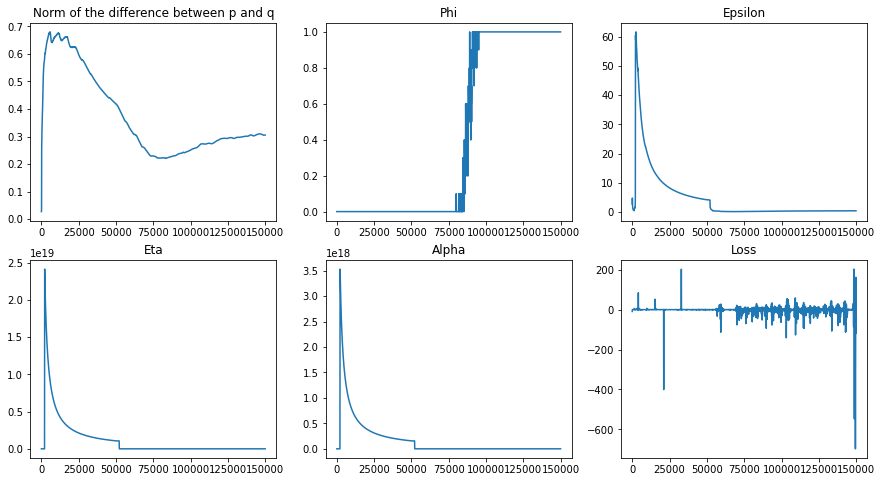

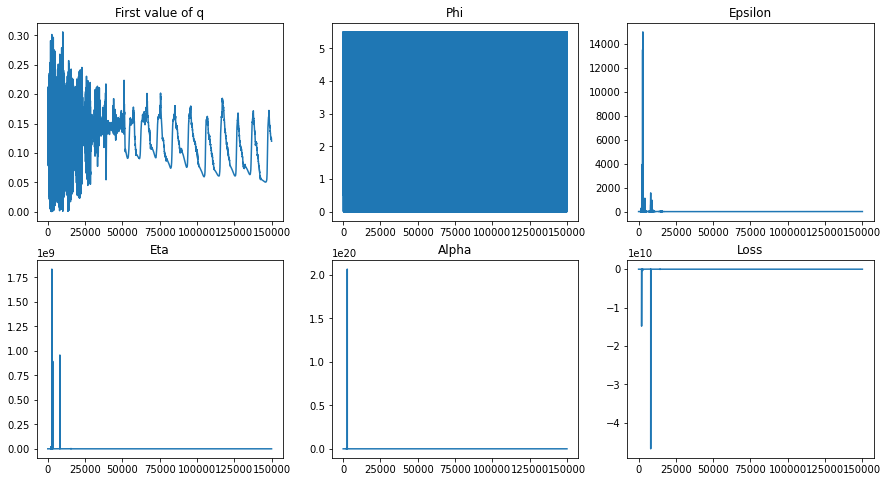


 


 	 EXP THRESHOLD 0.1 
 
 

epoch 0: 
 	 epsilon_=1.3205820322036743 and grad = 1.0 and lr = 0.011664999999999816 
 	 eta_=9.990045547485352 and grad = -1.0 and lr = 0.011664999999999816 
 	 alpha_=9.990045547485352 and grad = -0.04999740049242973 and lr = 0.011664999999999816 
 	 s_=tensor([-1.5512, -1.7335, -2.2178, -3.3809, -2.4466, -3.4275, -2.3862, -2.5685,
        -3.9956, -6.2782, -4.1960, -6.2962, -3.1846, -4.3478, -4.1474, -6.4300,
        -5.4729, -6.6124, -3.4275, -4.4083, -4.3618, -6.4620, -5.4869, -6.6263],
       requires_grad=True)
 	 q2=tensor([0.2011, 0.1701, 0.1101, 0.0356, 0.0885, 0.0341, 0.0937, 0.0787, 0.0194,
        0.0020, 0.0159, 0.0019, 0.0432, 0.0137, 0.0167, 0.0017, 0.0044, 0.0014,
        0.0341, 0.0129, 0.0135, 0.0016, 0.0043, 0.0014],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 1.0000,  1.0000, -0.7775, -0.2542, -0.6520, -0.2465, -0.6576, -0.5529,
        -0.1423, -0.0145, -0.1154, -0.0142, -0.3023, -0.1010, -0.1240, -0.0124,
      

epoch 10500: 
 	 epsilon_=0.03436318412423134 and grad = -0.03605367988348007 and lr = 1.257917499999999 
 	 eta_=0.08987250179052353 and grad = 0.016596240922808647 and lr = 1.257917499999999 
 	 alpha_=3.0004734992980957 and grad = 0.009557676501572132 and lr = 1.257917499999999 
 	 s_=tensor([ 1.3296,  1.3815,  0.8116, -0.2615,  0.4084, -0.2793,  0.7776,  0.7532,
        -0.6296, -0.5038, -0.5911, -0.4554, -0.2617, -0.4319, -0.6836, -0.4756,
        -0.4559, -0.4717, -0.3063, -0.5245, -0.3870, -0.4363, -0.4728, -0.4576],
       requires_grad=True)
 	 q2=tensor([0.1029, 0.1069, 0.0763, 0.0357, 0.0565, 0.0338, 0.0721, 0.0709, 0.0244,
        0.0268, 0.0249, 0.0280, 0.0356, 0.0276, 0.0230, 0.0275, 0.0278, 0.0276,
        0.0334, 0.0254, 0.0287, 0.0286, 0.0276, 0.0281],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0040,  0.0054,  0.0046, -0.0025,  0.0038, -0.0012,  0.0043,  0.0011,
        -0.0014, -0.0024, -0.0021, -0.0019,  0.0014, -0.0024, -0.0018, -0.0023,
      

epoch 21000: 
 	 epsilon_=0.34624168276786804 and grad = -0.2419750690460205 and lr = 0.6341668749999998 
 	 eta_=0.6606684923171997 and grad = -0.1472335010766983 and lr = 0.6341668749999998 
 	 alpha_=4.7768449783325195 and grad = 0.01580324023962021 and lr = 0.6341668749999998 
 	 s_=tensor([ 3.5036,  3.3055,  1.4413, -0.1894,  1.4534, -0.2972,  1.2658,  0.7820,
        -0.8229, -1.0207, -1.1250, -1.0206,  0.1772, -1.1534, -0.9639, -0.9841,
        -0.9814, -0.9410, -0.0078, -1.1341, -1.3725, -0.9922, -0.9216, -0.9108],
       requires_grad=True)
 	 q2=tensor([0.1772, 0.1656, 0.0856, 0.0308, 0.0843, 0.0300, 0.0775, 0.0596, 0.0169,
        0.0156, 0.0140, 0.0156, 0.0411, 0.0126, 0.0167, 0.0158, 0.0159, 0.0163,
        0.0343, 0.0138, 0.0112, 0.0159, 0.0165, 0.0170],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 0.0142,  0.0141,  0.0121,  0.0068,  0.0120,  0.0068,  0.0116,  0.0103,
         0.0042, -0.0165,  0.0036, -0.0165,  0.0085,  0.0033, -0.0175, -

epoch 33000: 
 	 epsilon_=0.2378176897764206 and grad = 0.020681262016296387 and lr = 0.16604171874999996 
 	 eta_=1.3363689184188843 and grad = -1.0 and lr = 0.16604171874999996 
 	 alpha_=0.05062277615070343 and grad = 1.0 and lr = 0.16604171874999996 
 	 s_=tensor([ 2.9027e+00,  3.6923e-03,  1.7511e+00,  1.2693e+00,  4.0162e+00,
        -5.3063e-01, -7.0850e-02,  3.0921e+00, -8.8592e-01, -1.4773e+00,
        -1.0403e+00, -4.6532e-01,  2.7571e+00, -1.5380e+00,  2.7719e+00,
        -7.3395e-02,  3.2879e+00, -3.5277e-01, -5.0578e-01, -1.0338e+00,
        -6.6337e-01, -1.5223e+00, -9.1443e-01,  1.2470e+00],
       requires_grad=True)
 	 q2=tensor([0.0998, 0.0237, 0.0611, 0.0534, 0.1317, 0.0174, 0.0218, 0.1067, 0.0112,
        0.0068, 0.0099, 0.0171, 0.0947, 0.0064, 0.0898, 0.0223, 0.1042, 0.0177,
        0.0163, 0.0100, 0.0136, 0.0064, 0.0113, 0.0468],
       grad_fn=<DivBackward0>) and sum=0.9999998807907104 and grad = tensor([ 0.1991,  0.4022,  0.7173, -1.0000,  0.4032, -0.5423,  0.09

epoch 43500: 
 	 epsilon_=0.08461619913578033 and grad = -0.025797054171562195 and lr = 0.02952472656250002 
 	 eta_=0.7679034471511841 and grad = -0.1576332002878189 and lr = 0.02952472656250002 
 	 alpha_=2.5696749687194824 and grad = 0.1082829162478447 and lr = 0.02952472656250002 
 	 s_=tensor([ 2.2901,  2.4476,  1.5765, -0.2725,  1.1563, -0.3352,  1.2644,  0.9419,
        -1.0245, -1.4013, -1.2582, -1.4185, -0.0088, -1.3987, -1.2003, -1.3893,
        -1.4056, -1.4057, -0.3332, -1.4106, -1.3968, -1.4115, -1.4002, -1.4008],
       requires_grad=True)
 	 q2=tensor([0.1451, 0.1536, 0.1073, 0.0343, 0.0867, 0.0328, 0.0918, 0.0774, 0.0186,
        0.0134, 0.0152, 0.0132, 0.0418, 0.0134, 0.0160, 0.0135, 0.0133, 0.0133,
        0.0328, 0.0132, 0.0134, 0.0132, 0.0134, 0.0134],
       grad_fn=<DivBackward0>) and sum=0.9999998807907104 and grad = tensor([ 0.0023,  0.0481,  0.0084,  0.0137,  0.0197,  0.0147,  0.0186, -0.0151,
        -0.0149, -0.0162,  0.0040, -0.0150, -0.0312, -0.0117, -0.018

epoch 54000: 
 	 epsilon_=0.13563314080238342 and grad = -0.019245892763137817 and lr = 0.010003251953125004 
 	 eta_=0.9947699904441833 and grad = 0.1764785796403885 and lr = 0.010003251953125004 
 	 alpha_=1.8874142169952393 and grad = -0.11791320890188217 and lr = 0.010003251953125004 
 	 s_=tensor([ 2.6519,  2.3076,  1.6300, -0.2700,  1.1735, -0.3313,  1.2763,  0.9421,
        -1.0243, -1.5472, -1.2549, -1.5484, -0.0090, -1.4206, -1.2006, -1.5552,
        -1.5560, -1.5370, -0.3297, -1.4796, -1.4401, -1.5757, -1.5570, -1.5366],
       requires_grad=True)
 	 q2=tensor([0.1649, 0.1457, 0.1096, 0.0344, 0.0874, 0.0328, 0.0922, 0.0772, 0.0186,
        0.0117, 0.0152, 0.0117, 0.0418, 0.0131, 0.0160, 0.0116, 0.0116, 0.0118,
        0.0328, 0.0124, 0.0129, 0.0114, 0.0116, 0.0118],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 0.0187,  0.0358,  0.0242, -0.0407,  0.0098,  0.0142,  0.0329,  0.0327,
        -0.0228, -0.0150,  0.0076, -0.0156, -0.0471, -0.0164,  0

epoch 66000: 
 	 epsilon_=0.03553374484181404 and grad = -0.033195480704307556 and lr = 0.010000812988281252 
 	 eta_=0.08527689427137375 and grad = -0.14249591529369354 and lr = 0.010000812988281252 
 	 alpha_=0.8452363014221191 and grad = 0.13637295365333557 and lr = 0.010000812988281252 
 	 s_=tensor([ 1.5874,  1.0380,  1.0401,  0.2796,  0.5509,  0.1978,  0.5748,  0.5359,
        -0.4734, -0.8653, -0.2665, -0.8092,  0.0933, -0.2541, -0.2738, -0.4675,
        -0.2225,  0.0405,  0.1028, -0.5967, -0.3383, -0.3554, -0.6396, -0.4841],
       requires_grad=True)
 	 q2=tensor([0.1001, 0.0757, 0.0758, 0.0476, 0.0568, 0.0450, 0.0576, 0.0562, 0.0273,
        0.0198, 0.0321, 0.0208, 0.0418, 0.0324, 0.0319, 0.0275, 0.0332, 0.0403,
        0.0421, 0.0248, 0.0304, 0.0300, 0.0239, 0.0271],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0103,  0.0036,  0.0014, -0.0044,  0.0056, -0.0025, -0.0008,  0.0071,
        -0.0030, -0.0013, -0.0018, -0.0011, -0.0027, -0.0006, -0.0013, -0.003

epoch 78000: 
 	 epsilon_=0.037086550146341324 and grad = -0.03274635598063469 and lr = 0.010000203247070313 
 	 eta_=0.13841259479522705 and grad = 0.1273876577615738 and lr = 0.010000203247070313 
 	 alpha_=1.9555160999298096 and grad = -0.015503892675042152 and lr = 0.010000203247070313 
 	 s_=tensor([ 0.8283,  0.6139,  0.7004, -0.0667,  0.5690, -0.1415,  0.4926,  0.3482,
        -0.3488, -0.3273, -0.2382, -0.3175,  0.0245, -0.1822, -0.2777, -0.3139,
        -0.2055, -0.2206, -0.1357, -0.1717, -0.3102, -0.3181, -0.1981, -0.1286],
       requires_grad=True)
 	 q2=tensor([0.0706, 0.0620, 0.0654, 0.0391, 0.0603, 0.0370, 0.0575, 0.0523, 0.0316,
        0.0322, 0.0344, 0.0324, 0.0418, 0.0359, 0.0334, 0.0325, 0.0353, 0.0349,
        0.0372, 0.0362, 0.0326, 0.0324, 0.0355, 0.0374],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([-0.0083,  0.0010,  0.0019,  0.0002,  0.0096, -0.0047,  0.0195,  0.0170,
        -0.0044, -0.0024, -0.0045, -0.0007, -0.0010, -0.0104, 

epoch 90000: 
 	 epsilon_=0.18005013465881348 and grad = -0.01697877049446106 and lr = 0.010000050811767578 
 	 eta_=1.0960057973861694 and grad = -0.014459013938903809 and lr = 0.010000050811767578 
 	 alpha_=2.3476157188415527 and grad = 1.9371509552001953e-07 and lr = 0.010000050811767578 
 	 s_=tensor([ 2.6016,  2.5603,  1.7417, -0.2043,  1.2677, -0.2659,  1.3874,  1.0397,
        -0.9652, -1.4594, -1.1957, -1.4613,  0.0642, -1.3673, -1.1412, -1.4515,
        -1.4416, -1.4041, -0.2645, -1.4342, -1.3834, -1.4463, -1.4591, -1.4327],
       requires_grad=True)
 	 q2=tensor([0.1539, 0.1517, 0.1095, 0.0343, 0.0873, 0.0328, 0.0928, 0.0774, 0.0186,
        0.0120, 0.0152, 0.0120, 0.0418, 0.0131, 0.0160, 0.0121, 0.0122, 0.0127,
        0.0328, 0.0123, 0.0129, 0.0122, 0.0120, 0.0123],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 0.0186,  0.0076,  0.0693,  0.0185,  0.0160,  0.0112,  0.0249,  0.0294,
        -0.0267, -0.0175, -0.0198, -0.0175, -0.0451, -0.0176

epoch 102000: 
 	 epsilon_=0.9162713885307312 and grad = 0.003651738166809082 and lr = 0.010000012702941895 
 	 eta_=2.505521059036255 and grad = -1.0 and lr = 0.010000012702941895 
 	 alpha_=0.0012583271600306034 and grad = 1.0 and lr = 0.010000012702941895 
 	 s_=tensor([ 2.2255,  1.5595,  1.4788,  0.0254,  0.9667,  0.1001,  0.8249,  0.8077,
        -0.6662, -1.3758, -0.9548, -1.0205,  0.5806, -0.7557, -0.8605, -1.1267,
        -1.1443, -0.9148, -0.2215, -0.8678, -1.0027, -1.0990, -1.0658, -1.0557],
       requires_grad=True)
 	 q2=tensor([0.1375, 0.1033, 0.0995, 0.0417, 0.0761, 0.0440, 0.0702, 0.0695, 0.0245,
        0.0133, 0.0192, 0.0182, 0.0606, 0.0227, 0.0208, 0.0166, 0.0163, 0.0199,
        0.0348, 0.0207, 0.0184, 0.0170, 0.0175, 0.0176],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 1.,  1., -1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,
        -1.,  1., -1., -1., -1.,  1.,  1., -1.,  1., -1.]) and lr = 0.010000012702941895 
 	 phi = 3.5 and std_

epoch 114000: 
 	 epsilon_=0.03777420148253441 and grad = -0.03257490694522858 and lr = 0.010000003175735473 
 	 eta_=0.15977197885513306 and grad = -0.3183354139328003 and lr = 0.010000003175735473 
 	 alpha_=0.9074937701225281 and grad = 0.28945091366767883 and lr = 0.010000003175735473 
 	 s_=tensor([ 1.2244,  1.3762,  1.4628,  0.2931,  0.8073,  0.0099,  0.8338,  0.6305,
        -0.5644, -0.7471, -0.7072, -0.5025,  0.2319,  0.0451, -0.0653, -0.5933,
         0.1039, -0.0322, -0.1542, -0.1902, -0.4265, -0.4129, -0.3584, -0.1724],
       requires_grad=True)
 	 q2=tensor([0.0785, 0.0849, 0.0886, 0.0451, 0.0623, 0.0370, 0.0633, 0.0560, 0.0239,
        0.0205, 0.0212, 0.0251, 0.0432, 0.0379, 0.0350, 0.0233, 0.0396, 0.0359,
        0.0328, 0.0319, 0.0266, 0.0269, 0.0281, 0.0324],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-0.0064,  0.0111, -0.0013, -0.0044, -0.0083, -0.0028,  0.0174, -0.0030,
         0.0006, -0.0053, -0.0069,  0.0029, -0.0055,  0.0006,  0.0032, -0.0023

epoch 126000: 
 	 epsilon_=0.23241589963436127 and grad = -0.013315781950950623 and lr = 0.010000000793933869 
 	 eta_=1.1986982822418213 and grad = 0.22955437004566193 and lr = 0.010000000793933869 
 	 alpha_=3.1863818168640137 and grad = -0.112877756357193 and lr = 0.010000000793933869 
 	 s_=tensor([ 2.3540,  2.0488,  1.7857, -0.1816,  1.3038, -0.2435,  1.4208,  1.0723,
        -0.9460, -1.1310, -1.1474, -1.1357,  0.0880, -1.0845, -1.1118, -1.0946,
        -1.0991, -1.0710, -0.2432, -1.1173, -1.1131, -1.1121, -1.0799, -1.0571],
       requires_grad=True)
 	 q2=tensor([0.1384, 0.1228, 0.1099, 0.0344, 0.0875, 0.0328, 0.0927, 0.0774, 0.0186,
        0.0159, 0.0156, 0.0158, 0.0418, 0.0165, 0.0161, 0.0164, 0.0163, 0.0167,
        0.0328, 0.0160, 0.0161, 0.0161, 0.0166, 0.0169],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0556,  0.0658, -0.0558, -0.0336, -0.0639,  0.0287,  0.0476,  0.0480,
         0.0191, -0.0178, -0.0163, -0.0173,  0.0367, -0.0180, -0.0171, -0.0171,

epoch 138000: 
 	 epsilon_=1.243288516998291 and grad = 0.006661415100097656 and lr = 0.010000000198483468 
 	 eta_=3.4757256507873535 and grad = 1.0 and lr = 0.010000000198483468 
 	 alpha_=0.00036231332342140377 and grad = -1.0 and lr = 0.010000000198483468 
 	 s_=tensor([ 2.3376,  1.6680,  1.2371, -0.0392,  0.9839, -0.2419,  1.1504,  0.7438,
        -0.6008, -1.4021, -0.9253, -1.1815,  0.0624, -0.9349, -0.9639, -1.3146,
        -1.1573, -1.1831, -0.2929, -1.0623, -1.0806, -1.2907, -1.2007, -1.1413],
       requires_grad=True)
 	 q2=tensor([0.1498, 0.1136, 0.0920, 0.0415, 0.0802, 0.0357, 0.0879, 0.0698, 0.0269,
        0.0136, 0.0206, 0.0165, 0.0446, 0.0204, 0.0199, 0.0147, 0.0168, 0.0165,
        0.0344, 0.0183, 0.0180, 0.0150, 0.0162, 0.0171],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 1., -1., -1.,  1.,  1.,  1., -1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1., -1., -1.,  1., -1.,  1.,  1.]) and lr = 0.010000000198483468 
 	 phi = 0.5 and std

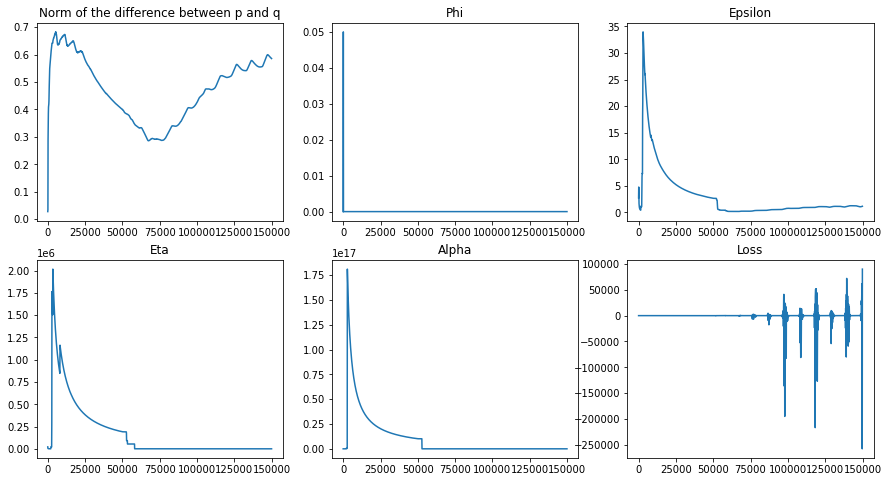

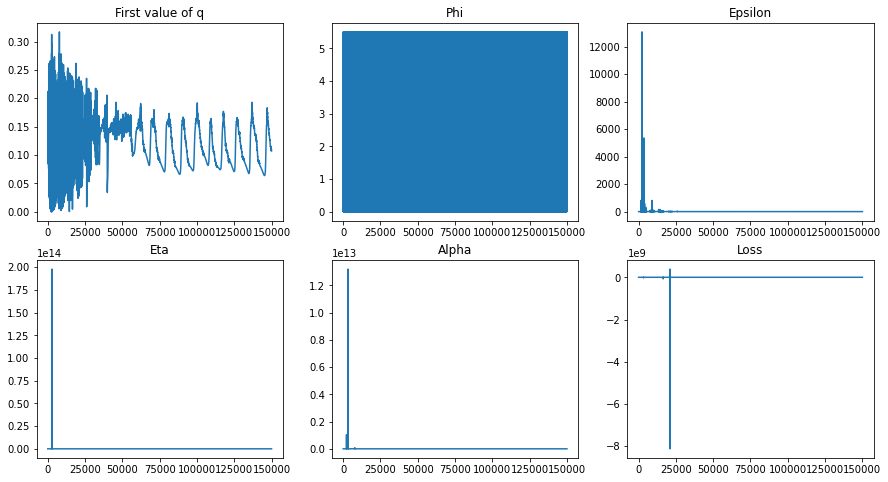


 


 	 EXP THRESHOLD 0.15000000000000002 
 
 

epoch 0: 
 	 epsilon_=1.3205820322036743 and grad = 1.0 and lr = 0.011664999999999816 
 	 eta_=9.990045547485352 and grad = -1.0 and lr = 0.011664999999999816 
 	 alpha_=10.010045051574707 and grad = 0.14999260008335114 and lr = 0.011664999999999816 
 	 s_=tensor([-1.5512, -1.7335, -2.2178, -3.3809, -2.4466, -3.4275, -2.3862, -2.5685,
        -3.9956, -6.2782, -4.1960, -6.2962, -3.1846, -4.3478, -4.1474, -6.4300,
        -5.4729, -6.6124, -3.4275, -4.4083, -4.3618, -6.4620, -5.4869, -6.6263],
       requires_grad=True)
 	 q2=tensor([0.2011, 0.1701, 0.1101, 0.0356, 0.0885, 0.0341, 0.0937, 0.0787, 0.0194,
        0.0020, 0.0159, 0.0019, 0.0432, 0.0137, 0.0167, 0.0017, 0.0044, 0.0014,
        0.0341, 0.0129, 0.0135, 0.0016, 0.0043, 0.0014],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 1.0000,  1.0000, -0.7667, -0.2447, -0.6612, -0.2365, -0.5800, -0.5110,
        -0.1373, -0.0141, -0.1158, -0.0139, -0.2997, -0.0979, -0.1205,

epoch 10500: 
 	 epsilon_=0.06267333775758743 and grad = 0.10284662246704102 and lr = 1.257917499999999 
 	 eta_=2.999539613723755 and grad = -0.2956145107746124 and lr = 1.257917499999999 
 	 alpha_=7.4020795822143555 and grad = 0.23129044473171234 and lr = 1.257917499999999 
 	 s_=tensor([ 3.5019,  3.3921,  2.6175,  0.1658,  1.2281, -0.1159,  1.1534,  0.9273,
        -1.2689, -1.9323, -1.4143, -1.9091,  0.2143, -1.4834, -1.4170, -1.9361,
        -1.8155, -2.0347, -0.1685, -1.5877, -1.5077, -1.8268, -1.5369, -2.0755],
       requires_grad=True)
 	 q2=tensor([0.1557, 0.1512, 0.1447, 0.0401, 0.0916, 0.0328, 0.0821, 0.0710, 0.0141,
        0.0095, 0.0133, 0.0098, 0.0389, 0.0126, 0.0124, 0.0093, 0.0105, 0.0088,
        0.0339, 0.0116, 0.0138, 0.0105, 0.0136, 0.0083],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 0.1218,  0.1237, -0.1772, -0.1061, -0.1599,  0.0610,  0.1094,  0.0959,
         0.0305, -0.0319,  0.0301, -0.0327,  0.0672,  0.0282,  0.0273, -0.03

epoch 21000: 
 	 epsilon_=0.001648062956519425 and grad = -0.0021647901739925146 and lr = 0.6341668749999998 
 	 eta_=0.002111844951286912 and grad = -0.00199826224707067 and lr = 0.6341668749999998 
 	 alpha_=3.448540449142456 and grad = 0.0008862819522619247 and lr = 0.6341668749999998 
 	 s_=tensor([ 1.7722,  1.6248,  1.3556, -0.3016,  0.4791,  0.0652,  1.2119,  0.4858,
        -0.1792, -0.6041, -0.3757, -0.2479,  0.1038, -0.7211, -0.4271, -1.0317,
        -0.5298, -0.6466, -0.1163, -0.7844, -0.5757, -0.0152, -0.2237, -0.6806],
       requires_grad=True)
 	 q2=tensor([0.1156, 0.1077, 0.0924, 0.0307, 0.0557, 0.0404, 0.0852, 0.0557, 0.0326,
        0.0212, 0.0277, 0.0281, 0.0419, 0.0207, 0.0265, 0.0149, 0.0225, 0.0204,
        0.0351, 0.0195, 0.0234, 0.0336, 0.0286, 0.0199],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 3.8197e-05,  1.4313e-04,  1.1295e-04,  2.7407e-05,  7.9988e-05,
        -9.2222e-05,  1.9105e-04,  1.0903e-04, -6.0030e-05, -4.9529e-05,
        -5.61

epoch 31500: 
 	 epsilon_=0.05756261572241783 and grad = -0.030259065330028534 and lr = 0.08809890625000007 
 	 eta_=0.5528076887130737 and grad = 0.2212335169315338 and lr = 0.08809890625000007 
 	 alpha_=2.8732213973999023 and grad = -0.0628136545419693 and lr = 0.08809890625000007 
 	 s_=tensor([ 2.4649,  2.2241,  1.5854, -0.2345,  1.0490, -0.2662,  1.2966,  0.8977,
        -0.9560, -1.1042, -1.1329, -1.1247,  0.0191, -1.1949, -1.1514, -1.1215,
        -1.1305, -1.1373, -0.3096, -1.3189, -1.3007, -1.0984, -1.1084, -1.2587],
       requires_grad=True)
 	 q2=tensor([0.1509, 0.1382, 0.1043, 0.0340, 0.0796, 0.0334, 0.0903, 0.0726, 0.0189,
        0.0165, 0.0163, 0.0163, 0.0415, 0.0153, 0.0160, 0.0163, 0.0161, 0.0161,
        0.0323, 0.0137, 0.0139, 0.0167, 0.0165, 0.0143],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0152,  0.0149,  0.0137,  0.0073,  0.0122, -0.0207,  0.0130,  0.0117,
        -0.0132, -0.0117, -0.0116, -0.0116,  0.0086, -0.0110, -0.0115, -0.0116,
   

epoch 42000: 
 	 epsilon_=0.10162296146154404 and grad = -0.021373309195041656 and lr = 0.010013007812500016 
 	 eta_=0.8873371481895447 and grad = 0.15801914036273956 and lr = 0.010013007812500016 
 	 alpha_=2.455996513366699 and grad = -0.06693876534700394 and lr = 0.010013007812500016 
 	 s_=tensor([ 2.5701,  2.2415,  1.6127, -0.2719,  1.1552, -0.3364,  1.2775,  0.9460,
        -1.0264, -1.4709, -1.2481, -1.4751, -0.0087, -1.4168, -1.2030, -1.4906,
        -1.4751, -1.4866, -0.3317, -1.4619, -1.4279, -1.4705, -1.4424, -1.4619],
       requires_grad=True)
 	 q2=tensor([0.1607, 0.1425, 0.1090, 0.0344, 0.0867, 0.0328, 0.0927, 0.0775, 0.0186,
        0.0125, 0.0153, 0.0125, 0.0418, 0.0132, 0.0160, 0.0123, 0.0125, 0.0124,
        0.0329, 0.0126, 0.0131, 0.0126, 0.0129, 0.0127],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0371,  0.0247,  0.0236,  0.0117,  0.0231,  0.0124,  0.0264, -0.0612,
        -0.0194, -0.0145, -0.0170, -0.0136,  0.0115, -0.0144,  0.0071, -0.0143,

epoch 54000: 
 	 epsilon_=0.11968488246202469 and grad = -0.022403448820114136 and lr = 0.010003251953125004 
 	 eta_=0.9283632040023804 and grad = -0.5241315364837646 and lr = 0.010003251953125004 
 	 alpha_=2.205082893371582 and grad = 0.3415842056274414 and lr = 0.010003251953125004 
 	 s_=tensor([ 2.4190,  2.4193,  1.6047, -0.2777,  1.1543, -0.3413,  1.2825,  0.9292,
        -1.0316, -1.4918, -1.2635, -1.5030, -0.0129, -1.3922, -1.2053, -1.5294,
        -1.4803, -1.4927, -0.3389, -1.4962, -1.4406, -1.4855, -1.4954, -1.4703],
       requires_grad=True)
 	 q2=tensor([0.1524, 0.1527, 0.1091, 0.0343, 0.0869, 0.0327, 0.0931, 0.0769, 0.0186,
        0.0124, 0.0152, 0.0123, 0.0418, 0.0135, 0.0160, 0.0120, 0.0125, 0.0124,
        0.0328, 0.0123, 0.0129, 0.0124, 0.0123, 0.0126],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 0.0393,  0.0097, -0.0183,  0.0260,  0.0112,  0.0080, -0.0400,  0.0393,
         0.0084, -0.0132, -0.0179, -0.0155,  0.0283, -0.0158, -0.0

epoch 64500: 
 	 epsilon_=0.10929064452648163 and grad = -0.021838024258613586 and lr = 0.012437338867187498 
 	 eta_=0.9031068682670593 and grad = 0.16167818009853363 and lr = 0.012437338867187498 
 	 alpha_=2.3295648097991943 and grad = -0.07506617158651352 and lr = 0.012437338867187498 
 	 s_=tensor([ 2.5222,  2.2926,  1.6295, -0.2806,  1.1668, -0.3324,  1.2803,  0.9372,
        -1.0274, -1.4875, -1.2607, -1.4613, -0.0160, -1.4204, -1.1988, -1.4978,
        -1.4659, -1.4609, -0.3369, -1.4807, -1.4377, -1.4764, -1.4757, -1.4608],
       requires_grad=True)
 	 q2=tensor([0.1578, 0.1451, 0.1098, 0.0342, 0.0874, 0.0328, 0.0927, 0.0770, 0.0186,
        0.0124, 0.0152, 0.0127, 0.0416, 0.0132, 0.0160, 0.0123, 0.0126, 0.0127,
        0.0327, 0.0125, 0.0130, 0.0125, 0.0125, 0.0127],
       grad_fn=<DivBackward0>) and sum=0.9999998807907104 and grad = tensor([ 0.0314,  0.0455, -0.0150,  0.0071,  0.0023,  0.0106,  0.0098, -0.0080,
         0.0036, -0.0166,  0.0046, -0.0168,  0.0092, -0.0193, -

epoch 75000: 
 	 epsilon_=0.09063774347305298 and grad = -0.023320697247982025 and lr = 0.011219075927734374 
 	 eta_=0.8238611817359924 and grad = -0.8426922559738159 and lr = 0.011219075927734374 
 	 alpha_=1.8946101665496826 and grad = 0.5875874757766724 and lr = 0.011219075927734374 
 	 s_=tensor([ 2.3963,  2.3933,  1.6399, -0.2604,  1.1745, -0.3231,  1.3050,  0.9432,
        -1.0137, -1.4238, -1.2425, -1.4152,  0.0049, -1.4055, -1.1874, -1.4027,
        -1.3934, -1.3923, -0.3190, -1.4494, -1.4271, -1.4306, -1.4251, -1.3759],
       requires_grad=True)
 	 q2=tensor([0.1495, 0.1493, 0.1093, 0.0343, 0.0868, 0.0328, 0.0929, 0.0764, 0.0186,
        0.0130, 0.0153, 0.0131, 0.0419, 0.0132, 0.0160, 0.0132, 0.0133, 0.0133,
        0.0329, 0.0127, 0.0129, 0.0129, 0.0130, 0.0136],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([-0.0016,  0.0038,  0.0411,  0.0264,  0.0160,  0.0102,  0.0277,  0.0381,
        -0.0191, -0.0124, -0.0121, -0.0152, -0.0235, -0.0150, -0.

epoch 87000: 
 	 epsilon_=0.7190059423446655 and grad = 0.0002371072769165039 and lr = 0.010304768981933594 
 	 eta_=2.049593210220337 and grad = -1.0 and lr = 0.010304768981933594 
 	 alpha_=0.015235410071909428 and grad = 1.0 and lr = 0.010304768981933594 
 	 s_=tensor([ 2.1230,  2.0533,  1.6807, -0.0889,  1.1550, -0.2179,  1.0805,  0.5992,
        -0.9063, -1.4459, -0.9548, -1.4335,  0.0849, -0.9030, -0.8248, -1.0282,
        -1.0206, -0.6847, -0.3109, -1.0376, -1.0521, -1.0405, -0.9220, -0.6882],
       requires_grad=True)
 	 q2=tensor([0.1309, 0.1272, 0.1085, 0.0380, 0.0835, 0.0345, 0.0804, 0.0607, 0.0198,
        0.0124, 0.0191, 0.0125, 0.0431, 0.0199, 0.0213, 0.0179, 0.0180, 0.0239,
        0.0321, 0.0178, 0.0175, 0.0177, 0.0196, 0.0238],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 1.0000, -1.0000, -1.0000,  1.0000,  1.0000,  1.0000, -1.0000, -0.8202,
         1.0000,  1.0000, -1.0000, -1.0000,  1.0000, -0.1620, -1.0000, -1.0000,
         1.0000,  1.0000,  1.0

epoch 99000: 
 	 epsilon_=0.05234631896018982 and grad = -0.02911447547376156 and lr = 0.010076192245483399 
 	 eta_=0.48266059160232544 and grad = 0.12943610548973083 and lr = 0.010076192245483399 
 	 alpha_=0.7501258254051208 and grad = 4.76837158203125e-07 and lr = 0.010076192245483399 
 	 s_=tensor([ 1.6104,  1.9005,  1.7716, -0.1770,  1.2728, -0.2388,  1.1297,  0.8181,
        -0.8108, -0.9539, -0.9308, -0.8938,  0.0911, -0.8130, -0.4772, -0.7389,
        -0.7356, -0.7296, -0.2360, -0.8074, -0.8671, -0.6962, -0.6567, -0.7287],
       requires_grad=True)
 	 q2=tensor([0.1012, 0.1151, 0.1089, 0.0344, 0.0858, 0.0328, 0.0796, 0.0668, 0.0208,
        0.0184, 0.0188, 0.0194, 0.0418, 0.0207, 0.0273, 0.0220, 0.0221, 0.0222,
        0.0329, 0.0208, 0.0198, 0.0228, 0.0236, 0.0222],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-0.0134,  0.0301,  0.0188,  0.0036, -0.0006,  0.0065,  0.0327,  0.0452,
        -0.0088, -0.0111, -0.0111, -0.0131, -0.0022, -0.0173, -0.0107, -0.0053

epoch 111000: 
 	 epsilon_=0.2125416100025177 and grad = -0.01469351351261139 and lr = 0.01001904806137085 
 	 eta_=1.1608965396881104 and grad = -0.052889347076416016 and lr = 0.01001904806137085 
 	 alpha_=1.2855397462844849 and grad = 5.364418029785156e-07 and lr = 0.01001904806137085 
 	 s_=tensor([ 2.4889e+00,  2.6538e+00,  1.6308e+00, -2.6355e-01,  1.1810e+00,
        -3.2359e-01,  1.2822e+00,  9.5673e-01, -1.0190e+00, -1.6389e+00,
        -1.2479e+00, -1.6370e+00, -1.2216e-03, -1.4156e+00, -1.1934e+00,
        -1.6352e+00, -1.6229e+00, -1.6309e+00, -3.2551e-01, -1.4846e+00,
        -1.4313e+00, -1.6375e+00, -1.6287e+00, -1.6166e+00],
       requires_grad=True)
 	 q2=tensor([0.1545, 0.1640, 0.1090, 0.0343, 0.0872, 0.0328, 0.0921, 0.0773, 0.0186,
        0.0107, 0.0152, 0.0107, 0.0417, 0.0131, 0.0160, 0.0107, 0.0109, 0.0108,
        0.0328, 0.0123, 0.0129, 0.0107, 0.0108, 0.0109],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.2937, -0.1271,  0.1102,  0.0565,  0.

epoch 121500: 
 	 epsilon_=0.7507778406143188 and grad = 0.001100778579711914 and lr = 0.010002383389472961 
 	 eta_=2.115741729736328 and grad = -1.0 and lr = 0.010002383389472961 
 	 alpha_=0.011309728026390076 and grad = 1.0 and lr = 0.010002383389472961 
 	 s_=tensor([ 2.5013,  2.0024,  1.6798, -0.0130,  1.0676, -0.2446,  0.8701,  0.6162,
        -0.6390, -1.0211, -0.7540, -1.0716, -0.0111, -0.8583, -0.5738, -1.0488,
        -0.8057, -0.6847,  0.0948, -1.0091, -0.7788, -1.1236, -0.8786, -0.8374],
       requires_grad=True)
 	 q2=tensor([0.1446, 0.1193, 0.1037, 0.0385, 0.0762, 0.0324, 0.0683, 0.0587, 0.0237,
        0.0172, 0.0216, 0.0165, 0.0385, 0.0198, 0.0250, 0.0168, 0.0207, 0.0229,
        0.0416, 0.0174, 0.0212, 0.0158, 0.0194, 0.0201],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 1., -1., -1., -1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1., -1., -1.,  1., -1., -1.,  1.,  1.]) and lr = 0.010002383389472961 
 	 phi 

epoch 133500: 
 	 epsilon_=0.06595729291439056 and grad = -0.026654120534658432 and lr = 0.01000059584736824 
 	 eta_=0.650738000869751 and grad = -0.10826748609542847 and lr = 0.01000059584736824 
 	 alpha_=1.8049054145812988 and grad = 0.16691096127033234 and lr = 0.01000059584736824 
 	 s_=tensor([ 1.7827,  1.4762,  1.3640, -0.2145,  1.2547, -0.2759,  1.2716,  1.0268,
        -0.7998, -0.8733, -0.8439, -0.8834,  0.0527, -0.8178, -0.7622, -0.7954,
        -0.7510, -0.7474, -0.2761, -0.8521, -0.8322, -0.7636, -0.7442, -0.7020],
       requires_grad=True)
 	 q2=tensor([0.1126, 0.0977, 0.0924, 0.0344, 0.0874, 0.0328, 0.0882, 0.0774, 0.0216,
        0.0203, 0.0208, 0.0201, 0.0418, 0.0212, 0.0222, 0.0216, 0.0225, 0.0225,
        0.0328, 0.0206, 0.0210, 0.0222, 0.0226, 0.0234],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0271,  0.0130,  0.0287, -0.0247, -0.0111,  0.0095,  0.0391,  0.0270,
        -0.0144, -0.0131, -0.0179, -0.0152,  0.0067, -0.0173, -0.0155, -0.0129,
 

epoch 144000: 
 	 epsilon_=0.405984491109848 and grad = -0.006797343492507935 and lr = 0.010000000099241733 
 	 eta_=1.4789869785308838 and grad = -0.20799720287322998 and lr = 0.010000000099241733 
 	 alpha_=0.45365002751350403 and grad = 2.384185791015625e-06 and lr = 0.010000000099241733 
 	 s_=tensor([ 2.6929,  2.4889,  1.6831, -0.2480,  1.2056, -0.3070,  1.3221,  0.9897,
        -1.0036, -1.6511, -1.2331, -1.6355,  0.0314, -1.4011, -1.1789, -1.6311,
        -1.6354, -1.6216, -0.3078, -1.4706, -1.4155, -1.6266, -1.6420, -1.6318],
       requires_grad=True)
 	 q2=tensor([0.1641, 0.1530, 0.1102, 0.0344, 0.0873, 0.0328, 0.0927, 0.0777, 0.0186,
        0.0104, 0.0152, 0.0106, 0.0421, 0.0131, 0.0160, 0.0106, 0.0106, 0.0107,
        0.0328, 0.0123, 0.0129, 0.0107, 0.0105, 0.0106],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 0.0398,  0.0852, -0.0616, -0.0359,  0.0513,  0.0325,  0.0757, -0.0852,
         0.0218, -0.0141, -0.0199, -0.0147, -0.0422, -0.0173,

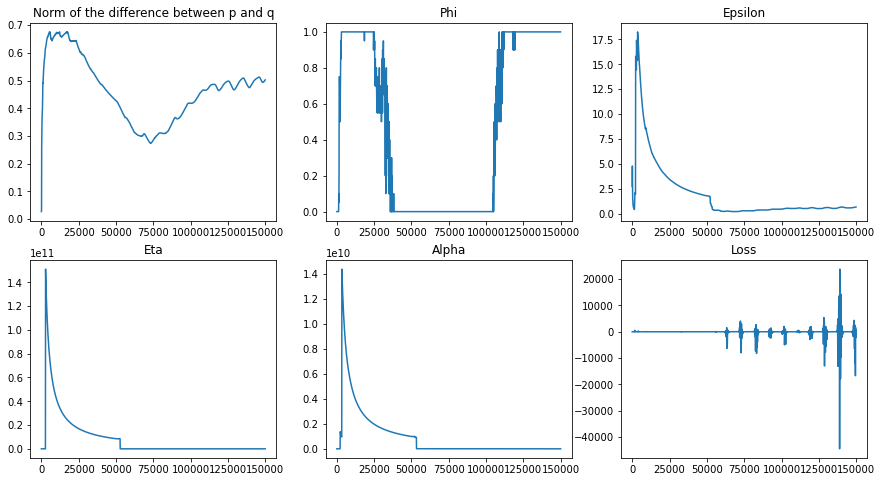

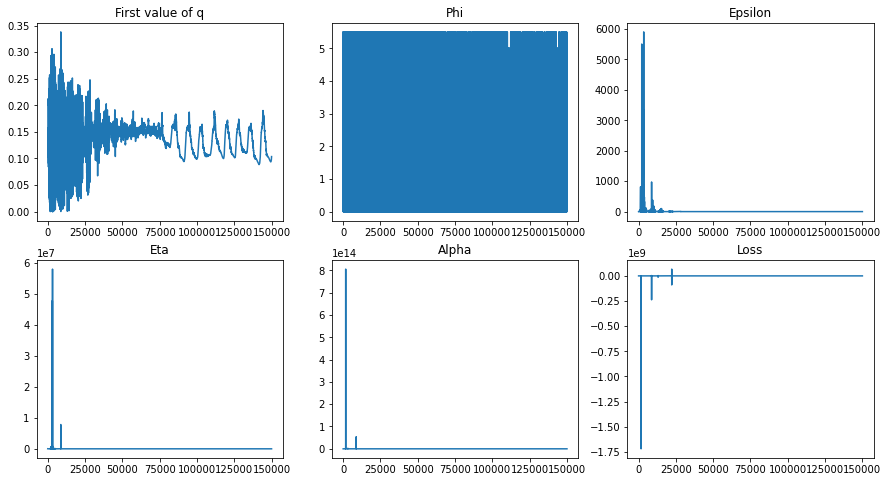


 


 	 EXP THRESHOLD 0.2 
 
 

epoch 0: 
 	 epsilon_=1.3205820322036743 and grad = 1.0 and lr = 0.011664999999999816 
 	 eta_=9.990045547485352 and grad = -1.0 and lr = 0.011664999999999816 
 	 alpha_=9.990045547485352 and grad = 9.685754776000977e-08 and lr = 0.011664999999999816 
 	 s_=tensor([-1.5512, -1.7335, -2.2178, -3.3809, -2.4466, -3.4275, -2.3862, -2.5685,
        -3.9956, -6.2782, -4.1960, -6.2962, -3.1846, -4.3478, -4.1474, -6.4300,
        -5.4729, -6.6124, -3.4275, -4.4083, -4.3618, -6.4620, -5.4869, -6.6263],
       requires_grad=True)
 	 q2=tensor([0.2011, 0.1701, 0.1101, 0.0356, 0.0885, 0.0341, 0.0937, 0.0787, 0.0194,
        0.0020, 0.0159, 0.0019, 0.0432, 0.0137, 0.0167, 0.0017, 0.0044, 0.0014,
        0.0341, 0.0129, 0.0135, 0.0016, 0.0043, 0.0014],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 1.0000,  1.0000, -0.7716, -0.2569, -0.6412, -0.2492, -0.5985, -0.6251,
        -0.1442, -0.0146, -0.1173, -0.0144, -0.3168, -0.1016, -0.1243, -0.0126,
     

epoch 10500: 
 	 epsilon_=0.058073997497558594 and grad = -0.18281735479831696 and lr = 1.257917499999999 
 	 eta_=0.001428048126399517 and grad = 0.0003158963518217206 and lr = 1.257917499999999 
 	 alpha_=5.087371349334717 and grad = 1.4551915228366852e-10 and lr = 1.257917499999999 
 	 s_=tensor([ 3.9219,  2.8815,  1.5766,  0.6580,  0.8652, -0.0723,  1.1987,  1.7655,
        -0.1371, -1.6219, -0.5075, -1.5708,  0.3855, -0.5599, -1.1757, -1.4429,
        -0.7555, -1.5606, -0.0747, -0.5432, -0.9393, -1.5282, -0.8973, -1.3864],
       requires_grad=True)
 	 q2=tensor([0.1909, 0.1450, 0.0863, 0.0491, 0.0617, 0.0318, 0.0745, 0.0928, 0.0282,
        0.0068, 0.0220, 0.0071, 0.0436, 0.0210, 0.0124, 0.0078, 0.0151, 0.0072,
        0.0316, 0.0211, 0.0151, 0.0073, 0.0134, 0.0083],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 1.9032e-04,  6.9611e-05,  8.9738e-05, -1.7006e-04,  9.7918e-05,
         9.6848e-05,  1.3735e-04, -2.5273e-04, -8.1832e-05, -3.1976e-05,
 

epoch 21000: 
 	 epsilon_=0.03729228675365448 and grad = -0.0154914241284132 and lr = 0.6341668749999998 
 	 eta_=0.6399460434913635 and grad = -0.010148949921131134 and lr = 0.6341668749999998 
 	 alpha_=3.7678558826446533 and grad = 0.06744012981653214 and lr = 0.6341668749999998 
 	 s_=tensor([ 1.2080,  1.2784,  1.7283, -0.3124,  1.0978, -0.4072,  1.3030,  0.6851,
        -0.9321, -0.8946, -1.1042, -0.8394, -0.2084, -1.0549, -1.2045, -0.8391,
        -0.9658, -0.9506, -0.3062, -1.1216, -1.0300, -0.9500, -0.8980, -0.7188],
       requires_grad=True)
 	 q2=tensor([0.0875, 0.0917, 0.1185, 0.0334, 0.0944, 0.0335, 0.0921, 0.0711, 0.0227,
        0.0219, 0.0187, 0.0226, 0.0398, 0.0205, 0.0184, 0.0249, 0.0206, 0.0221,
        0.0349, 0.0189, 0.0203, 0.0223, 0.0229, 0.0263],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 0.0346,  0.0340, -0.0293,  0.0182, -0.0311, -0.0133,  0.0349,  0.0354,
        -0.0088, -0.0078, -0.0076, -0.0093,  0.0210, -0.0085, -0.0077,

epoch 31500: 
 	 epsilon_=0.050512779504060745 and grad = -0.022466866299510002 and lr = 0.08809890625000007 
 	 eta_=0.589794397354126 and grad = 0.16252997517585754 and lr = 0.08809890625000007 
 	 alpha_=3.247159242630005 and grad = -0.027367206290364265 and lr = 0.08809890625000007 
 	 s_=tensor([ 2.2927,  2.0966,  1.4917, -0.2643,  1.0642, -0.3079,  1.2155,  0.9182,
        -1.0073, -1.1136, -1.1665, -1.1595, -0.0298, -1.1687, -1.1484, -1.1491,
        -1.1335, -1.1458, -0.3256, -1.1668, -1.1304, -1.1507, -1.1823, -1.1485],
       requires_grad=True)
 	 q2=tensor([0.1444, 0.1344, 0.1014, 0.0340, 0.0813, 0.0335, 0.0882, 0.0753, 0.0185,
        0.0171, 0.0163, 0.0163, 0.0409, 0.0161, 0.0165, 0.0166, 0.0169, 0.0168,
        0.0328, 0.0163, 0.0168, 0.0167, 0.0162, 0.0166],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0162,  0.0158,  0.0144,  0.0077,  0.0132, -0.0229,  0.0136,  0.0126,
         0.0047, -0.0133, -0.0127, -0.0128,  0.0088, -0.0126, -0.0129, -0.0130,
 

epoch 43500: 
 	 epsilon_=0.05916289985179901 and grad = -0.02728411927819252 and lr = 0.02952472656250002 
 	 eta_=0.5856953263282776 and grad = 0.0843210443854332 and lr = 0.02952472656250002 
 	 alpha_=3.2564380168914795 and grad = 5.21540641784668e-08 and lr = 0.02952472656250002 
 	 s_=tensor([ 1.9733,  2.2274,  1.6311, -0.2696,  1.1201, -0.3266,  1.2498,  0.9397,
        -1.0107, -1.1430, -1.1698, -1.1681, -0.0055, -1.1704, -1.1690, -1.1797,
        -1.1704, -1.1670, -0.3266, -1.1898, -1.1714, -1.2078, -1.1710, -1.1893],
       requires_grad=True)
 	 q2=tensor([0.1267, 0.1408, 0.1090, 0.0343, 0.0845, 0.0326, 0.0906, 0.0764, 0.0187,
        0.0168, 0.0163, 0.0165, 0.0417, 0.0163, 0.0163, 0.0162, 0.0164, 0.0164,
        0.0328, 0.0160, 0.0163, 0.0158, 0.0164, 0.0161],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0162,  0.0166,  0.0154,  0.0082,  0.0139,  0.0077,  0.0143,  0.0133,
        -0.0138, -0.0125, -0.0122, -0.0123,  0.0092, -0.0123, -0.0123, -0.0122,
   

epoch 55500: 
 	 epsilon_=0.09503263235092163 and grad = -0.02356564998626709 and lr = 0.014881181640625005 
 	 eta_=0.8416717648506165 and grad = 0.25691941380500793 and lr = 0.014881181640625005 
 	 alpha_=2.6749637126922607 and grad = -0.10909566283226013 and lr = 0.014881181640625005 
 	 s_=tensor([ 2.2486,  2.4903,  1.6205, -0.2787,  1.1624, -0.3368,  1.2747,  0.9271,
        -1.0306, -1.4542, -1.2569, -1.4249, -0.0129, -1.4231, -1.1973, -1.4411,
        -1.4553, -1.4523, -0.3358, -1.4492, -1.4011, -1.4402, -1.4411, -1.4376],
       requires_grad=True)
 	 q2=tensor([0.1429, 0.1565, 0.1097, 0.0342, 0.0874, 0.0327, 0.0927, 0.0767, 0.0186,
        0.0128, 0.0153, 0.0131, 0.0418, 0.0131, 0.0161, 0.0129, 0.0128, 0.0128,
        0.0328, 0.0128, 0.0134, 0.0130, 0.0129, 0.0130],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 0.0137,  0.0343,  0.0005,  0.0142,  0.0136,  0.0048,  0.0106,  0.0054,
        -0.0227, -0.0157, -0.0190, -0.0160,  0.0135,  0.0044, -0

epoch 67500: 
 	 epsilon_=0.08581429719924927 and grad = -0.02477947622537613 and lr = 0.011220295410156251 
 	 eta_=0.786171019077301 and grad = -0.16262677311897278 and lr = 0.011220295410156251 
 	 alpha_=2.6146233081817627 and grad = 0.10775043815374374 and lr = 0.011220295410156251 
 	 s_=tensor([ 2.4322,  2.3824,  1.6236, -0.2702,  1.1561, -0.3292,  1.2651,  0.9368,
        -1.0262, -1.4517, -1.2507, -1.4399, -0.0085, -1.4139, -1.1948, -1.4386,
        -1.4155, -1.4601, -0.3308, -1.4347, -1.4270, -1.4345, -1.4491, -1.4212],
       requires_grad=True)
 	 q2=tensor([0.1524, 0.1496, 0.1093, 0.0344, 0.0867, 0.0328, 0.0916, 0.0767, 0.0186,
        0.0127, 0.0153, 0.0129, 0.0418, 0.0132, 0.0160, 0.0129, 0.0131, 0.0126,
        0.0328, 0.0129, 0.0130, 0.0129, 0.0127, 0.0131],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0388,  0.0251,  0.0099, -0.0326,  0.0198,  0.0153,  0.0119,  0.0326,
        -0.0171, -0.0132, -0.0142, -0.0135, -0.0305, -0.0137, -0.0166, -0.0124,


epoch 78000: 
 	 epsilon_=0.08435860276222229 and grad = -0.024326905608177185 and lr = 0.010000203247070313 
 	 eta_=0.7870550155639648 and grad = -0.1389935165643692 and lr = 0.010000203247070313 
 	 alpha_=2.665300130844116 and grad = 0.10289479047060013 and lr = 0.010000203247070313 
 	 s_=tensor([ 2.3351,  2.1619,  1.6332, -0.2688,  1.1747, -0.3301,  1.2712,  0.9538,
        -1.0241, -1.3217, -1.2501, -1.3407, -0.0051, -1.3174, -1.1951, -1.3256,
        -1.3236, -1.3182, -0.3311, -1.3108, -1.3156, -1.3211, -1.3277, -1.3077],
       requires_grad=True)
 	 q2=tensor([0.1468, 0.1375, 0.1096, 0.0344, 0.0874, 0.0328, 0.0920, 0.0774, 0.0186,
        0.0143, 0.0153, 0.0141, 0.0418, 0.0144, 0.0160, 0.0143, 0.0143, 0.0144,
        0.0328, 0.0145, 0.0144, 0.0143, 0.0143, 0.0145],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 0.0363, -0.0362,  0.0147,  0.0139,  0.0213,  0.0094, -0.0022,  0.0120,
         0.0087, -0.0131, -0.0169, -0.0106,  0.0231, -0.0126, -0.

epoch 88500: 
 	 epsilon_=0.1071200892329216 and grad = -0.02167326956987381 and lr = 0.010152333679199219 
 	 eta_=0.8985552787780762 and grad = 0.036765724420547485 and lr = 0.010152333679199219 
 	 alpha_=2.337500810623169 and grad = 1.341104507446289e-07 and lr = 0.010152333679199219 
 	 s_=tensor([ 2.3059,  2.5264,  1.6299, -0.2760,  1.1653, -0.3382,  1.2311,  0.9362,
        -1.0274, -1.4626, -1.2532, -1.4703, -0.0079, -1.4240, -1.2016, -1.4674,
        -1.4500, -1.4652, -0.3346, -1.4561, -1.4350, -1.4537, -1.4543, -1.4686],
       requires_grad=True)
 	 q2=tensor([0.1458, 0.1580, 0.1100, 0.0343, 0.0874, 0.0327, 0.0903, 0.0770, 0.0186,
        0.0126, 0.0153, 0.0126, 0.0419, 0.0131, 0.0160, 0.0126, 0.0128, 0.0126,
        0.0327, 0.0127, 0.0130, 0.0128, 0.0128, 0.0126],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0573,  0.0010, -0.0897,  0.0085,  0.0217,  0.0220,  0.0654,  0.0066,
         0.0121, -0.0118, -0.0154, -0.0124, -0.0432, -0.0131,  0.0090, -0.0126,

epoch 100500: 
 	 epsilon_=0.08073940128087997 and grad = -0.02460368350148201 and lr = 0.010038083419799806 
 	 eta_=0.76838219165802 and grad = 0.16691240668296814 and lr = 0.010038083419799806 
 	 alpha_=2.585953712463379 and grad = -0.05314088240265846 and lr = 0.010038083419799806 
 	 s_=tensor([ 2.2451,  2.2832,  1.6072, -0.2712,  1.1603, -0.3374,  1.2855,  0.9444,
        -1.0243, -1.3294, -1.2543, -1.3396, -0.0110, -1.3160, -1.1944, -1.3541,
        -1.3462, -1.3602, -0.3365, -1.3500, -1.3317, -1.3603, -1.3204, -1.3130],
       requires_grad=True)
 	 q2=tensor([0.1425, 0.1448, 0.1088, 0.0344, 0.0871, 0.0327, 0.0928, 0.0772, 0.0186,
        0.0142, 0.0152, 0.0141, 0.0418, 0.0144, 0.0161, 0.0139, 0.0140, 0.0138,
        0.0327, 0.0140, 0.0142, 0.0138, 0.0144, 0.0144],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-0.0105, -0.0504,  0.0112, -0.0148,  0.0456,  0.0001,  0.0584,  0.0245,
        -0.0044, -0.0063, -0.0047, -0.0099,  0.0204, -0.0104, -0.0130, -0.0068,
 

epoch 111000: 
 	 epsilon_=0.10560186207294464 and grad = -0.02172531932592392 and lr = 0.01001904806137085 
 	 eta_=0.8959301710128784 and grad = 0.17428700625896454 and lr = 0.01001904806137085 
 	 alpha_=2.161818027496338 and grad = -0.08470294624567032 and lr = 0.01001904806137085 
 	 s_=tensor([ 2.4323,  2.4336,  1.5943, -0.2704,  1.1777, -0.3326,  1.2799,  0.9360,
        -1.0211, -1.4632, -1.2504, -1.4618, -0.0054, -1.4073, -1.1958, -1.4473,
        -1.4585, -1.4382, -0.3253, -1.4421, -1.4197, -1.4664, -1.4592, -1.4651],
       requires_grad=True)
 	 q2=tensor([0.1520, 0.1523, 0.1076, 0.0343, 0.0874, 0.0327, 0.0923, 0.0764, 0.0186,
        0.0126, 0.0152, 0.0126, 0.0418, 0.0132, 0.0160, 0.0128, 0.0126, 0.0129,
        0.0328, 0.0129, 0.0131, 0.0126, 0.0127, 0.0126],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0469, -0.0021,  0.0022,  0.0037, -0.0149,  0.0193, -0.0387,  0.0572,
         0.0063, -0.0140,  0.0151, -0.0158, -0.0184, -0.0132, -0.0186, -0.0144,
  

epoch 123000: 
 	 epsilon_=0.11201596260070801 and grad = -0.021120212972164154 and lr = 0.010004762015342712 
 	 eta_=0.9180435538291931 and grad = -0.6468504071235657 and lr = 0.010004762015342712 
 	 alpha_=2.229962110519409 and grad = 0.4131079316139221 and lr = 0.010004762015342712 
 	 s_=tensor([ 2.6168,  2.2141,  1.6132, -0.2855,  1.1521, -0.3416,  1.2703,  0.9333,
        -1.0341, -1.5037, -1.2635, -1.5585, -0.0196, -1.4147, -1.2102, -1.5230,
        -1.5124, -1.5067, -0.3425, -1.4862, -1.4482, -1.5115, -1.5221, -1.5352],
       requires_grad=True)
 	 q2=tensor([0.1645, 0.1417, 0.1099, 0.0343, 0.0874, 0.0329, 0.0927, 0.0774, 0.0186,
        0.0122, 0.0152, 0.0117, 0.0418, 0.0133, 0.0160, 0.0120, 0.0121, 0.0122,
        0.0328, 0.0125, 0.0129, 0.0122, 0.0120, 0.0119],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0332,  0.0102,  0.0173,  0.0068,  0.0041, -0.0371,  0.0190,  0.0093,
         0.0051, -0.0166, -0.0212, -0.0161,  0.0061, -0.0186,  0.0051, -0.0173,


epoch 133500: 
 	 epsilon_=0.08560466021299362 and grad = -0.02482740581035614 and lr = 0.01000059584736824 
 	 eta_=0.787251353263855 and grad = -0.29658859968185425 and lr = 0.01000059584736824 
 	 alpha_=2.3412513732910156 and grad = 0.19598102569580078 and lr = 0.01000059584736824 
 	 s_=tensor([ 2.6051e+00,  2.0741e+00,  1.6432e+00, -2.6693e-01,  1.1576e+00,
        -3.3038e-01,  1.2857e+00,  9.5666e-01, -1.0179e+00, -1.3747e+00,
        -1.2504e+00, -1.3781e+00,  2.5980e-03, -1.4014e+00, -1.1931e+00,
        -1.3795e+00, -1.3842e+00, -1.3822e+00, -3.2687e-01, -1.3865e+00,
        -1.3951e+00, -1.3766e+00, -1.3744e+00, -1.3773e+00],
       requires_grad=True)
 	 q2=tensor([0.1616, 0.1326, 0.1099, 0.0344, 0.0863, 0.0327, 0.0924, 0.0774, 0.0186,
        0.0135, 0.0152, 0.0135, 0.0419, 0.0133, 0.0160, 0.0135, 0.0135, 0.0135,
        0.0327, 0.0134, 0.0133, 0.0135, 0.0136, 0.0135],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 0.0256, -0.0365, -0.0145, 

epoch 144000: 
 	 epsilon_=0.10220082104206085 and grad = -0.022620588541030884 and lr = 0.010000000099241733 
 	 eta_=0.8726482391357422 and grad = -0.8400765061378479 and lr = 0.010000000099241733 
 	 alpha_=2.3165664672851562 and grad = 0.5143784880638123 and lr = 0.010000000099241733 
 	 s_=tensor([ 2.5059,  2.3037,  1.6271, -0.2670,  1.1704, -0.3324,  1.2556,  0.9395,
        -1.0267, -1.4445, -1.2433, -1.4550, -0.0069, -1.4206, -1.1947, -1.4519,
        -1.4490, -1.4597, -0.3304, -1.4283, -1.4214, -1.4427, -1.4606, -1.4458],
       requires_grad=True)
 	 q2=tensor([0.1565, 0.1453, 0.1094, 0.0345, 0.0872, 0.0328, 0.0912, 0.0769, 0.0185,
        0.0129, 0.0154, 0.0127, 0.0419, 0.0131, 0.0160, 0.0128, 0.0128, 0.0127,
        0.0328, 0.0131, 0.0131, 0.0129, 0.0127, 0.0129],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0241,  0.0237,  0.0218, -0.0340,  0.0200,  0.0114,  0.0203,  0.0188,
         0.0070, -0.0151, -0.0177, -0.0150, -0.0391, -0.0154, -0.0184, -0.0150,

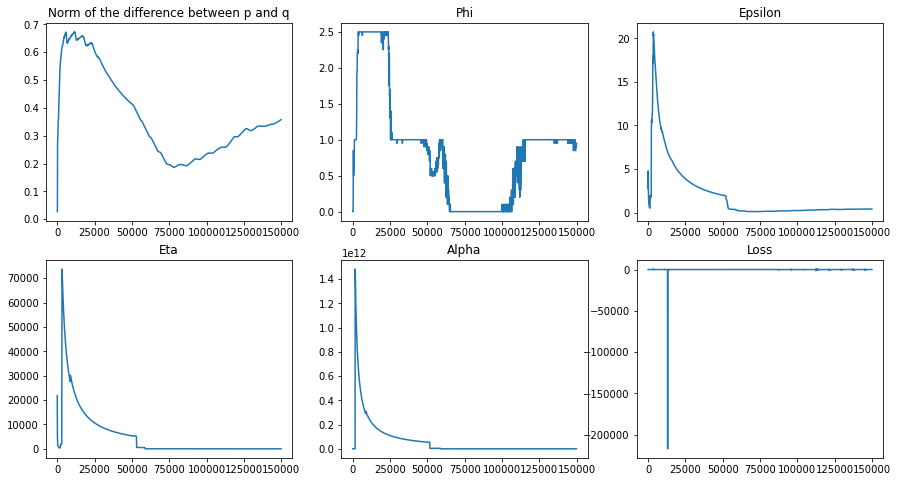

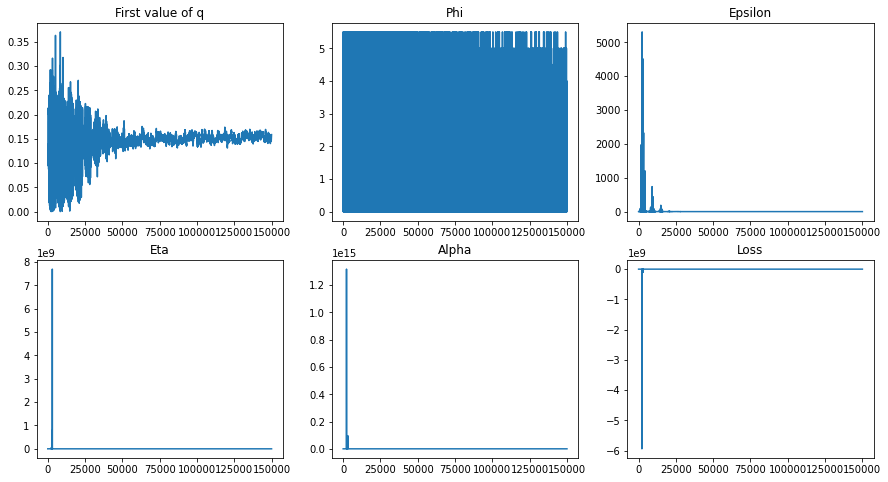


 


 	 EXP THRESHOLD 0.25 
 
 

epoch 0: 
 	 epsilon_=1.3205820322036743 and grad = 1.0 and lr = 0.011664999999999816 
 	 eta_=9.990045547485352 and grad = -1.0 and lr = 0.011664999999999816 
 	 alpha_=9.990045547485352 and grad = -0.04999740049242973 and lr = 0.011664999999999816 
 	 s_=tensor([-1.5512, -1.7335, -2.2178, -3.3809, -2.4466, -3.4275, -2.3862, -2.5685,
        -3.9956, -6.2782, -4.1960, -6.2962, -3.1846, -4.3478, -4.1474, -6.4300,
        -5.4729, -6.6124, -3.4275, -4.4083, -4.3618, -6.4620, -5.4869, -6.6263],
       requires_grad=True)
 	 q2=tensor([0.2011, 0.1701, 0.1101, 0.0356, 0.0885, 0.0341, 0.0937, 0.0787, 0.0194,
        0.0020, 0.0159, 0.0019, 0.0432, 0.0137, 0.0167, 0.0017, 0.0044, 0.0014,
        0.0341, 0.0129, 0.0135, 0.0016, 0.0043, 0.0014],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 1.0000,  1.0000, -0.7639, -0.2607, -0.6137, -0.2482, -0.6658, -0.5479,
        -0.1433, -0.0145, -0.1177, -0.0143, -0.3192, -0.1012, -0.1227, -0.0125,
     

epoch 10500: 
 	 epsilon_=0.003937144763767719 and grad = -0.0035028140991926193 and lr = 1.257917499999999 
 	 eta_=0.035823989659547806 and grad = -0.12794815003871918 and lr = 1.257917499999999 
 	 alpha_=1.054013729095459 and grad = 0.11465135961771011 and lr = 1.257917499999999 
 	 s_=tensor([-1.1845, -0.4989, -0.1909,  0.0816, -0.3692, -0.0418, -0.4917, -0.0879,
        -0.0507, -0.0697,  0.0796,  0.0781,  0.0332, -0.1777,  0.0561, -0.0463,
         0.0893, -0.0825,  0.1699, -0.2035, -0.3088,  0.0155,  0.0897, -0.0744],
       requires_grad=True)
 	 q2=tensor([0.0173, 0.0311, 0.0414, 0.0467, 0.0349, 0.0421, 0.0297, 0.0425, 0.0444,
        0.0416, 0.0484, 0.0459, 0.0466, 0.0397, 0.0482, 0.0447, 0.0458, 0.0426,
        0.0527, 0.0400, 0.0385, 0.0457, 0.0473, 0.0422],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 0.0016,  0.0032, -0.0030, -0.0008,  0.0017, -0.0003,  0.0006, -0.0022,
        -0.0017,  0.0003, -0.0002,  0.0041, -0.0012, -0.0006,  0.0017

epoch 22500: 
 	 epsilon_=0.013483553193509579 and grad = -0.011866160668432713 and lr = 0.32197937499999973 
 	 eta_=0.08816620707511902 and grad = 0.03173525631427765 and lr = 0.32197937499999973 
 	 alpha_=3.3830010890960693 and grad = 0.012781910598278046 and lr = 0.32197937499999973 
 	 s_=tensor([-0.0590, -0.1730,  0.1649,  0.0712,  0.0680,  0.0466,  0.1165,  0.0594,
         0.0556, -0.0172, -0.0005, -0.0176,  0.0064, -0.1382, -0.1489, -0.0564,
         0.0166,  0.0086, -0.0933, -0.2017, -0.1645,  0.0664, -0.0434,  0.0234],
       requires_grad=True)
 	 q2=tensor([0.0423, 0.0373, 0.0479, 0.0443, 0.0442, 0.0435, 0.0450, 0.0430, 0.0442,
        0.0406, 0.0429, 0.0403, 0.0427, 0.0388, 0.0380, 0.0400, 0.0424, 0.0417,
        0.0394, 0.0367, 0.0384, 0.0437, 0.0402, 0.0427],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0037,  0.0034,  0.0040, -0.0013,  0.0038, -0.0013,  0.0038,  0.0037,
        -0.0013, -0.0013, -0.0013, -0.0012, -0.0013, -0.0012, -0.0012, -0.0012,

epoch 34500: 
 	 epsilon_=0.06044221669435501 and grad = -0.029548730701208115 and lr = 0.08799484374999993 
 	 eta_=0.5512169003486633 and grad = -0.16454656422138214 and lr = 0.08799484374999993 
 	 alpha_=3.600762367248535 and grad = 0.08690811693668365 and lr = 0.08799484374999993 
 	 s_=tensor([ 2.3749,  1.9214,  1.5963, -0.2654,  1.1220, -0.3383,  1.2109,  0.8933,
        -1.0172, -1.1471, -1.1915, -1.1526, -0.0637, -1.2397, -1.1742, -1.2075,
        -1.2239, -1.2068, -0.3495, -1.2469, -1.2143, -1.1735, -1.2200, -1.1367],
       requires_grad=True)
 	 q2=tensor([0.1484, 0.1255, 0.1080, 0.0346, 0.0853, 0.0327, 0.0897, 0.0760, 0.0185,
        0.0167, 0.0162, 0.0166, 0.0403, 0.0155, 0.0164, 0.0156, 0.0156, 0.0159,
        0.0326, 0.0153, 0.0157, 0.0163, 0.0157, 0.0169],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0213,  0.0115,  0.0177, -0.0210,  0.0099,  0.0092,  0.0065,  0.0056,
         0.0052, -0.0126, -0.0120, -0.0122,  0.0104, -0.0115, -0.0115, -0.0112,
  

epoch 46500: 
 	 epsilon_=0.06384745985269547 and grad = -0.027217961847782135 and lr = 0.029498710937499985 
 	 eta_=0.626192569732666 and grad = 0.09332183003425598 and lr = 0.029498710937499985 
 	 alpha_=3.3859379291534424 and grad = 5.21540641784668e-08 and lr = 0.029498710937499985 
 	 s_=tensor([ 1.8190,  2.1290,  1.6069, -0.2800,  1.1408, -0.3434,  1.2525,  0.9246,
        -1.0295, -1.1288, -1.1758, -1.1429, -0.0206, -1.1523, -1.1523, -1.1382,
        -1.1258, -1.1314, -0.3330, -1.1656, -1.1355, -1.1642, -1.1405, -1.1618],
       requires_grad=True)
 	 q2=tensor([0.1197, 0.1362, 0.1095, 0.0342, 0.0863, 0.0326, 0.0918, 0.0771, 0.0187,
        0.0171, 0.0165, 0.0169, 0.0418, 0.0167, 0.0168, 0.0170, 0.0172, 0.0171,
        0.0328, 0.0166, 0.0172, 0.0165, 0.0170, 0.0166],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0193,  0.0113,  0.0137,  0.0137,  0.0135,  0.0124,  0.0214,  0.0168,
        -0.0133, -0.0125, -0.0123, -0.0126, -0.0268, -0.0124, -0.0125, -0.0128,

epoch 57000: 
 	 epsilon_=0.059861358255147934 and grad = -0.027835190296173096 and lr = 0.019752607421875 
 	 eta_=0.5822254419326782 and grad = 0.031762637197971344 and lr = 0.019752607421875 
 	 alpha_=3.462812900543213 and grad = 0.023362573236227036 and lr = 0.019752607421875 
 	 s_=tensor([ 2.0643,  1.7584,  1.6062, -0.2812,  1.1461, -0.3406,  1.2616,  0.9193,
        -1.0204, -1.1090, -1.0885, -1.1017, -0.0129, -1.1346, -1.1488, -1.1255,
        -1.1322, -1.1204, -0.3388, -1.1397, -1.0680, -1.1061, -1.0922, -1.1144],
       requires_grad=True)
 	 q2=tensor([0.1329, 0.1170, 0.1096, 0.0344, 0.0868, 0.0328, 0.0920, 0.0764, 0.0187,
        0.0174, 0.0176, 0.0175, 0.0418, 0.0170, 0.0168, 0.0171, 0.0170, 0.0172,
        0.0327, 0.0169, 0.0179, 0.0175, 0.0176, 0.0172],
       grad_fn=<DivBackward0>) and sum=0.9999998807907104 and grad = tensor([ 0.0267,  0.0059,  0.0149, -0.0194,  0.0222, -0.0162,  0.0286,  0.0125,
        -0.0107, -0.0116, -0.0110, -0.0113, -0.0149, -0.0111, -0.0107, 

epoch 69000: 
 	 epsilon_=0.06032120808959007 and grad = -0.027775857597589493 and lr = 0.01243815185546875 
 	 eta_=0.5872390866279602 and grad = 0.21965967118740082 and lr = 0.01243815185546875 
 	 alpha_=3.4490315914154053 and grad = -0.04750968515872955 and lr = 0.01243815185546875 
 	 s_=tensor([ 1.8330,  2.0923,  1.6347, -0.2675,  1.1787, -0.3295,  1.3017,  0.9585,
        -1.0188, -1.1247, -1.0929, -1.1359, -0.0057, -1.1797, -1.1155, -1.1268,
        -1.1217, -1.1283, -0.3309, -1.1412, -1.1319, -1.1194, -1.1260, -1.1181],
       requires_grad=True)
 	 q2=tensor([0.1196, 0.1333, 0.1093, 0.0343, 0.0872, 0.0327, 0.0929, 0.0775, 0.0186,
        0.0170, 0.0175, 0.0168, 0.0417, 0.0162, 0.0171, 0.0169, 0.0170, 0.0170,
        0.0326, 0.0167, 0.0169, 0.0170, 0.0169, 0.0171],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0276,  0.0115,  0.0133,  0.0097,  0.0262,  0.0096,  0.0235, -0.0403,
        -0.0135, -0.0128, -0.0125, -0.0125,  0.0087, -0.0119, -0.0125, -0.0110,
 

epoch 81000: 
 	 epsilon_=0.057193323969841 and grad = -0.02826789952814579 and lr = 0.010609537963867188 
 	 eta_=0.55071622133255 and grad = 0.09313566237688065 and lr = 0.010609537963867188 
 	 alpha_=3.486609935760498 and grad = 4.0978193283081055e-08 and lr = 0.010609537963867188 
 	 s_=tensor([ 1.8667e+00,  1.9448e+00,  1.6294e+00, -2.6739e-01,  1.1742e+00,
        -3.3065e-01,  1.2858e+00,  9.5466e-01, -1.0234e+00, -1.0887e+00,
        -1.0868e+00, -1.1106e+00, -1.0445e-03, -1.1260e+00, -1.1102e+00,
        -1.0839e+00, -1.0887e+00, -1.1261e+00, -3.2859e-01, -1.1020e+00,
        -1.1042e+00, -1.0941e+00, -1.0944e+00, -1.0936e+00],
       requires_grad=True)
 	 q2=tensor([0.1216, 0.1257, 0.1093, 0.0344, 0.0873, 0.0327, 0.0926, 0.0775, 0.0186,
        0.0175, 0.0176, 0.0172, 0.0419, 0.0170, 0.0172, 0.0176, 0.0176, 0.0170,
        0.0328, 0.0173, 0.0173, 0.0174, 0.0175, 0.0175],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 0.0259,  0.0269,  0.0297, 

epoch 91500: 
 	 epsilon_=0.06381505727767944 and grad = -0.027187425643205643 and lr = 0.010076268463134766 
 	 eta_=0.6259467601776123 and grad = 0.09193317592144012 and lr = 0.010076268463134766 
 	 alpha_=3.387759208679199 and grad = 5.960464477539063e-08 and lr = 0.010076268463134766 
 	 s_=tensor([ 1.8483,  2.1065,  1.6223, -0.2714,  1.1667, -0.3354,  1.2816,  0.9426,
        -1.0131, -1.1635, -1.1313, -1.1276, -0.0043, -1.1641, -1.1418, -1.1604,
        -1.1646, -1.1643, -0.3327, -1.1565, -1.1230, -1.1514, -1.1332, -1.1482],
       requires_grad=True)
 	 q2=tensor([0.1209, 0.1347, 0.1093, 0.0344, 0.0872, 0.0327, 0.0926, 0.0772, 0.0188,
        0.0165, 0.0170, 0.0170, 0.0419, 0.0165, 0.0168, 0.0166, 0.0165, 0.0165,
        0.0328, 0.0166, 0.0171, 0.0167, 0.0169, 0.0167],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0186,  0.0355,  0.0160, -0.0214,  0.0077,  0.0097,  0.0243,  0.0160,
        -0.0143, -0.0118, -0.0144, -0.0137, -0.0290, -0.0137, -0.0126, -0.0119

epoch 103500: 
 	 epsilon_=0.06849256157875061 and grad = -0.026596877723932266 and lr = 0.010019067115783691 
 	 eta_=0.6687125563621521 and grad = 0.15840762853622437 and lr = 0.010019067115783691 
 	 alpha_=3.3078269958496094 and grad = -0.02940201759338379 and lr = 0.010019067115783691 
 	 s_=tensor([ 2.1465,  1.9825,  1.5459, -0.2862,  1.1522, -0.3453,  1.2668,  0.9271,
        -1.0321, -1.2481, -1.1923, -1.1766, -0.0246, -1.2318, -1.2014, -1.2116,
        -1.2158, -1.2214, -0.3442, -1.2053, -1.2131, -1.2053, -1.1895, -1.2003],
       requires_grad=True)
 	 q2=tensor([0.1379, 0.1294, 0.1067, 0.0343, 0.0874, 0.0328, 0.0928, 0.0773, 0.0187,
        0.0155, 0.0162, 0.0165, 0.0417, 0.0157, 0.0161, 0.0160, 0.0159, 0.0158,
        0.0328, 0.0160, 0.0159, 0.0160, 0.0163, 0.0161],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 0.0164,  0.0349,  0.0180,  0.0139,  0.0344, -0.0231,  0.0041, -0.0153,
        -0.0128, -0.0132, -0.0130, -0.0126,  0.0228, -0.0150, 

epoch 114000: 
 	 epsilon_=0.06208469718694687 and grad = -0.027476832270622253 and lr = 0.010000003175735473 
 	 eta_=0.6060309410095215 and grad = -0.11665330827236176 and lr = 0.010000003175735473 
 	 alpha_=3.401888847351074 and grad = 0.0759703665971756 and lr = 0.010000003175735473 
 	 s_=tensor([ 1.9406,  2.1801,  1.5973, -0.2706,  1.1616, -0.3332,  1.2727,  0.9474,
        -1.0254, -1.2301, -1.1836, -1.1713, -0.0084, -1.2312, -1.1798, -1.1623,
        -1.1926, -1.1791, -0.3310, -1.1739, -1.1719, -1.1684, -1.1825, -1.1801],
       requires_grad=True)
 	 q2=tensor([0.1258, 0.1389, 0.1081, 0.0344, 0.0869, 0.0327, 0.0923, 0.0774, 0.0186,
        0.0155, 0.0162, 0.0164, 0.0418, 0.0155, 0.0163, 0.0165, 0.0161, 0.0163,
        0.0328, 0.0163, 0.0164, 0.0164, 0.0162, 0.0163],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0086,  0.0272,  0.0098,  0.0193,  0.0497,  0.0061,  0.0084, -0.0369,
        -0.0084, -0.0104, -0.0084, -0.0121, -0.0280, -0.0109, -0.0113, -0.0113,

epoch 124500: 
 	 epsilon_=0.059824369847774506 and grad = -0.027857735753059387 and lr = 0.010002380213737488 
 	 eta_=0.5816856622695923 and grad = 0.02485506236553192 and lr = 0.010002380213737488 
 	 alpha_=3.4463956356048584 and grad = 0.023716282099485397 and lr = 0.010002380213737488 
 	 s_=tensor([ 2.0662,  1.9425,  1.5954, -0.2657,  1.1789, -0.3290,  1.2926,  0.9495,
        -1.0178, -1.1780, -1.1440, -1.1304, -0.0024, -1.1214, -1.1396, -1.1442,
        -1.1309, -1.1307, -0.3279, -1.1367, -1.1227, -1.1642, -1.1521, -1.1298],
       requires_grad=True)
 	 q2=tensor([0.1321, 0.1253, 0.1074, 0.0344, 0.0874, 0.0328, 0.0926, 0.0771, 0.0186,
        0.0162, 0.0167, 0.0170, 0.0418, 0.0170, 0.0168, 0.0167, 0.0169, 0.0169,
        0.0328, 0.0168, 0.0170, 0.0164, 0.0166, 0.0169],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 0.0064,  0.0499,  0.0132, -0.0257,  0.0142,  0.0072,  0.0161,  0.0211,
        -0.0111, -0.0139, -0.0119, -0.0146, -0.0368, -0.0117,

epoch 135000: 
 	 epsilon_=0.0649929940700531 and grad = -0.02709442749619484 and lr = 0.010001190503835678 
 	 eta_=0.6366199254989624 and grad = 0.08604017645120621 and lr = 0.010001190503835678 
 	 alpha_=3.3375067710876465 and grad = 5.587935447692871e-08 and lr = 0.010001190503835678 
 	 s_=tensor([ 1.9791,  2.1070,  1.6314, -0.2726,  1.1628, -0.3320,  1.2854,  0.9419,
        -1.0195, -1.1690, -1.2006, -1.2039, -0.0045, -1.1971, -1.2003, -1.2156,
        -1.1685, -1.1661, -0.3335, -1.1227, -1.2005, -1.1587, -1.1803, -1.1824],
       requires_grad=True)
 	 q2=tensor([0.1278, 0.1346, 0.1096, 0.0344, 0.0870, 0.0327, 0.0927, 0.0770, 0.0187,
        0.0164, 0.0159, 0.0159, 0.0419, 0.0160, 0.0159, 0.0158, 0.0164, 0.0164,
        0.0328, 0.0170, 0.0160, 0.0165, 0.0163, 0.0162],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0206,  0.0218,  0.0233, -0.0219,  0.0201,  0.0103,  0.0205,  0.0131,
        -0.0145, -0.0123, -0.0116, -0.0119, -0.0244, -0.0116,  0.0054, -0.0123

epoch 145500: 
 	 epsilon_=0.06166929751634598 and grad = -0.027507539838552475 and lr = 0.01000014896184206 
 	 eta_=0.6042538285255432 and grad = 0.09331336617469788 and lr = 0.01000014896184206 
 	 alpha_=3.368596076965332 and grad = 4.842877388000488e-08 and lr = 0.01000014896184206 
 	 s_=tensor([ 1.9496,  2.1482,  1.5156, -0.2595,  1.1851, -0.3182,  1.2894,  0.9635,
        -1.0122, -1.0927, -1.1376, -1.1083,  0.0080, -1.1312, -1.1279, -1.1029,
        -1.1154, -1.0945, -0.3196, -1.0931, -1.1195, -1.1255, -1.1362, -1.1256],
       requires_grad=True)
 	 q2=tensor([0.1249, 0.1355, 0.1027, 0.0343, 0.0870, 0.0328, 0.0918, 0.0771, 0.0186,
        0.0173, 0.0167, 0.0171, 0.0419, 0.0167, 0.0168, 0.0172, 0.0170, 0.0173,
        0.0328, 0.0174, 0.0169, 0.0169, 0.0167, 0.0168],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0351,  0.0181,  0.0179,  0.0067,  0.0099,  0.0086,  0.0088,  0.0147,
         0.0050, -0.0135, -0.0128, -0.0123, -0.0268, -0.0134, -0.0136, -0.0138,


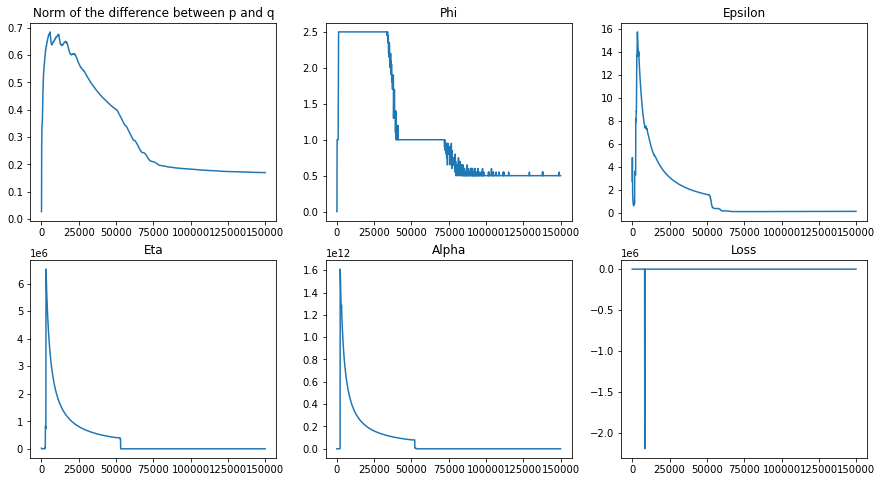

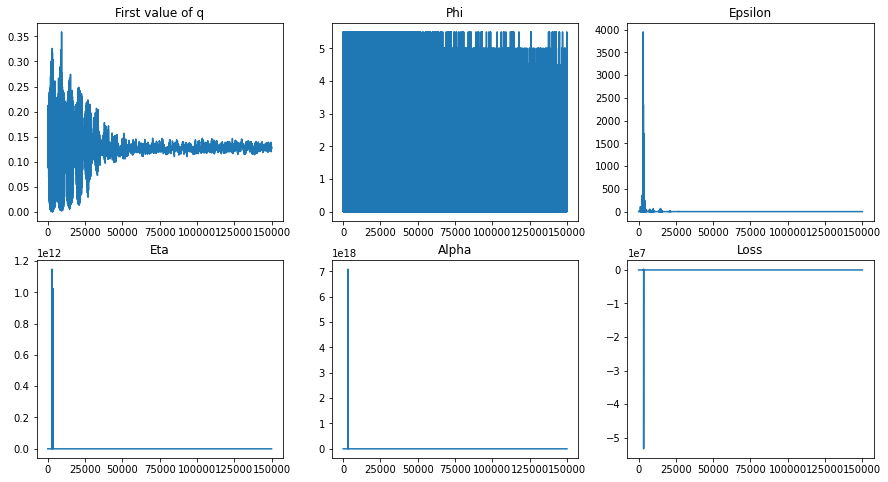


 


 	 EXP THRESHOLD 0.30000000000000004 
 
 

epoch 0: 
 	 epsilon_=1.3205820322036743 and grad = 1.0 and lr = 0.011664999999999816 
 	 eta_=9.990045547485352 and grad = -1.0 and lr = 0.011664999999999816 
 	 alpha_=9.990066528320312 and grad = 0.09999509155750275 and lr = 0.011664999999999816 
 	 s_=tensor([-1.5512, -1.7335, -2.2178, -3.3809, -2.4466, -3.4275, -2.3862, -2.5685,
        -3.9956, -6.2782, -4.1960, -6.2962, -3.1846, -4.3478, -4.1474, -6.4300,
        -5.4729, -6.6124, -3.4275, -4.4083, -4.3618, -6.4620, -5.4869, -6.6263],
       requires_grad=True)
 	 q2=tensor([0.2011, 0.1701, 0.1101, 0.0356, 0.0885, 0.0341, 0.0937, 0.0787, 0.0194,
        0.0020, 0.0159, 0.0019, 0.0432, 0.0137, 0.0167, 0.0017, 0.0044, 0.0014,
        0.0341, 0.0129, 0.0135, 0.0016, 0.0043, 0.0014],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 1.0000,  1.0000, -0.7819, -0.2574, -0.6075, -0.2471, -0.6537, -0.5664,
        -0.1418, -0.0145, -0.1169, -0.0142, -0.3126, -0.1003, -0.1229, 

epoch 10500: 
 	 epsilon_=0.015832385048270226 and grad = -0.020340995863080025 and lr = 1.257917499999999 
 	 eta_=0.036440666764974594 and grad = 0.005678931251168251 and lr = 1.257917499999999 
 	 alpha_=1.156642198562622 and grad = 0.01586994156241417 and lr = 1.257917499999999 
 	 s_=tensor([ 1.4522,  0.0891, -0.0776,  0.3441, -1.1461,  0.4829,  0.8939,  0.6376,
         0.0714, -0.0476,  0.3935, -0.1022,  0.0370,  0.2379,  0.5246, -0.0722,
         0.1360, -0.3362,  0.0678,  0.1432,  0.5373, -0.1026, -0.1954, -0.0836],
       requires_grad=True)
 	 q2=tensor([0.0981, 0.0424, 0.0365, 0.0446, 0.0141, 0.0478, 0.0670, 0.0564, 0.0327,
        0.0338, 0.0467, 0.0332, 0.0357, 0.0368, 0.0482, 0.0340, 0.0422, 0.0278,
        0.0354, 0.0374, 0.0492, 0.0332, 0.0334, 0.0335],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0013,  0.0025,  0.0010, -0.0012,  0.0006, -0.0009,  0.0022,  0.0018,
        -0.0008, -0.0008, -0.0010, -0.0005,  0.0020, -0.0005, -0.0007, -0.0009,
     

epoch 22500: 
 	 epsilon_=0.07374236732721329 and grad = 0.03802868723869324 and lr = 0.32197937499999973 
 	 eta_=1.6169077157974243 and grad = -0.10442820191383362 and lr = 0.32197937499999973 
 	 alpha_=3.146763801574707 and grad = 0.08524137735366821 and lr = 0.32197937499999973 
 	 s_=tensor([ 3.0835,  2.5243,  1.4607, -0.3214,  0.8981, -0.4094,  1.1240,  0.8979,
        -1.0534, -1.9303, -1.2972, -1.9521, -0.0706, -1.5035, -1.2006, -1.9214,
        -1.9744, -1.9579, -0.3865, -1.4220, -1.5504, -1.9789, -1.9579, -1.9217],
       requires_grad=True)
 	 q2=tensor([0.1912, 0.1623, 0.1056, 0.0348, 0.0757, 0.0323, 0.0913, 0.0763, 0.0185,
        0.0084, 0.0141, 0.0082, 0.0422, 0.0127, 0.0157, 0.0086, 0.0081, 0.0081,
        0.0328, 0.0148, 0.0133, 0.0080, 0.0082, 0.0086],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0835,  0.0015,  0.0353, -0.0731,  0.0496,  0.0026,  0.0161,  0.0118,
         0.0073, -0.0196,  0.0075, -0.0201, -0.0712,  0.0075,  0.0111, -0.0213,
    

epoch 33000: 
 	 epsilon_=0.05484717711806297 and grad = -0.03151814639568329 and lr = 0.16604171874999996 
 	 eta_=0.5034772157669067 and grad = 0.03594803065061569 and lr = 0.16604171874999996 
 	 alpha_=3.26660418510437 and grad = 0.022493254393339157 and lr = 0.16604171874999996 
 	 s_=tensor([ 2.0838e+00,  2.0875e+00,  1.5982e+00, -2.2351e-01,  8.8695e-01,
        -3.1627e-01,  1.3252e+00,  9.5464e-01, -9.5580e-01, -9.8713e-01,
        -1.1203e+00, -9.8077e-01,  7.8487e-04, -1.0141e+00, -1.0376e+00,
        -9.3048e-01, -9.5226e-01, -9.3225e-01, -3.1461e-01, -1.0318e+00,
        -9.6490e-01, -9.1687e-01, -9.5424e-01, -9.3295e-01],
       requires_grad=True)
 	 q2=tensor([0.1311, 0.1298, 0.1046, 0.0339, 0.0726, 0.0320, 0.0915, 0.0747, 0.0191,
        0.0181, 0.0161, 0.0182, 0.0411, 0.0174, 0.0177, 0.0195, 0.0190, 0.0191,
        0.0318, 0.0173, 0.0186, 0.0193, 0.0186, 0.0190],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0225,  0.0145,  0.0082,  0.0045,  0.0116,

epoch 43500: 
 	 epsilon_=0.07416719198226929 and grad = -0.025571171194314957 and lr = 0.02952472656250002 
 	 eta_=0.7163659334182739 and grad = 0.24842634797096252 and lr = 0.02952472656250002 
 	 alpha_=3.091388463973999 and grad = -0.07095179706811905 and lr = 0.02952472656250002 
 	 s_=tensor([ 2.1473,  2.0245,  1.6375, -0.2706,  1.1384, -0.3331,  1.2713,  0.9471,
        -1.0195, -1.1917, -1.1958, -1.1980, -0.0106, -1.2495, -1.1915, -1.2637,
        -1.2316, -1.2585, -0.3314, -1.2255, -1.2073, -1.2034, -1.1670, -1.2042],
       requires_grad=True)
 	 q2=tensor([0.1377, 0.1300, 0.1099, 0.0344, 0.0862, 0.0327, 0.0929, 0.0772, 0.0188,
        0.0161, 0.0160, 0.0160, 0.0417, 0.0153, 0.0161, 0.0151, 0.0156, 0.0153,
        0.0328, 0.0157, 0.0159, 0.0160, 0.0166, 0.0159],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 0.0036,  0.0188,  0.0660, -0.0240,  0.0210,  0.0217, -0.0502,  0.0295,
        -0.0136, -0.0100, -0.0118, -0.0119,  0.0186, -0.0109, -0.01

epoch 54000: 
 	 epsilon_=0.07555320113897324 and grad = -0.02534586191177368 and lr = 0.010003251953125004 
 	 eta_=0.7302238345146179 and grad = -0.022025853395462036 and lr = 0.010003251953125004 
 	 alpha_=2.9801580905914307 and grad = 0.03914312273263931 and lr = 0.010003251953125004 
 	 s_=tensor([ 2.2667,  2.2528,  1.6094, -0.2742,  1.1667, -0.3309,  1.2896,  0.9500,
        -1.0222, -1.3364, -1.2557, -1.3191, -0.0070, -1.3377, -1.1980, -1.3550,
        -1.3263, -1.3254, -0.3330, -1.3285, -1.3078, -1.3371, -1.3305, -1.3401],
       requires_grad=True)
 	 q2=tensor([0.1435, 0.1425, 0.1086, 0.0343, 0.0872, 0.0328, 0.0929, 0.0774, 0.0186,
        0.0141, 0.0152, 0.0144, 0.0418, 0.0142, 0.0160, 0.0139, 0.0143, 0.0143,
        0.0328, 0.0142, 0.0145, 0.0141, 0.0142, 0.0141],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0054,  0.0133,  0.0463,  0.0061,  0.0276,  0.0118,  0.0200,  0.0196,
        -0.0179, -0.0142, -0.0150, -0.0137, -0.0351, -0.0130, -0.0152, -0.0125

epoch 66000: 
 	 epsilon_=0.09462103992700577 and grad = -0.023570656776428223 and lr = 0.010000812988281252 
 	 eta_=0.8362368941307068 and grad = -0.05855245888233185 and lr = 0.010000812988281252 
 	 alpha_=2.800610065460205 and grad = 0.050184279680252075 and lr = 0.010000812988281252 
 	 s_=tensor([ 2.4580,  2.2911,  1.5925, -0.2862,  1.1462, -0.3457,  1.2542,  0.9274,
        -1.0400, -1.4672, -1.2679, -1.4636, -0.0293, -1.4277, -1.2120, -1.4821,
        -1.4683, -1.4606, -0.3452, -1.4696, -1.4353, -1.4679, -1.4770, -1.4627],
       requires_grad=True)
 	 q2=tensor([0.1558, 0.1464, 0.1090, 0.0344, 0.0871, 0.0329, 0.0923, 0.0773, 0.0186,
        0.0127, 0.0152, 0.0128, 0.0416, 0.0132, 0.0159, 0.0126, 0.0127, 0.0128,
        0.0328, 0.0127, 0.0131, 0.0127, 0.0126, 0.0128],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 0.0212,  0.0204,  0.0193,  0.0103,  0.0172, -0.0327,  0.0179,  0.0167,
        -0.0207, -0.0148,  0.0052, -0.0149,  0.0113, -0.0154,  

epoch 76500: 
 	 epsilon_=0.07270154356956482 and grad = -0.025949131697416306 and lr = 0.010609334716796875 
 	 eta_=0.7059770822525024 and grad = -0.019297540187835693 and lr = 0.010609334716796875 
 	 alpha_=2.918619394302368 and grad = 0.03921664506196976 and lr = 0.010609334716796875 
 	 s_=tensor([ 2.2619,  2.2406,  1.6411, -0.2654,  1.1816, -0.3259,  1.3002,  0.9521,
        -1.0181, -1.2952, -1.2432, -1.2957,  0.0029, -1.3189, -1.1909, -1.2971,
        -1.3201, -1.3095, -0.3243, -1.2923, -1.3140, -1.3046, -1.2921, -1.3151],
       requires_grad=True)
 	 q2=tensor([0.1424, 0.1410, 0.1095, 0.0343, 0.0873, 0.0327, 0.0927, 0.0769, 0.0186,
        0.0146, 0.0153, 0.0146, 0.0418, 0.0143, 0.0160, 0.0145, 0.0142, 0.0144,
        0.0328, 0.0146, 0.0143, 0.0144, 0.0146, 0.0143],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0058,  0.0109,  0.0314,  0.0123,  0.0071,  0.0065,  0.0237,  0.0178,
         0.0028, -0.0141, -0.0150, -0.0146,  0.0082, -0.0143, -0.0148, -0.0141

epoch 87000: 
 	 epsilon_=0.07978833466768265 and grad = -0.02479233592748642 and lr = 0.010304768981933594 
 	 eta_=0.761084794998169 and grad = 0.2429078221321106 and lr = 0.010304768981933594 
 	 alpha_=2.96730375289917 and grad = -0.08189995586872101 and lr = 0.010304768981933594 
 	 s_=tensor([ 2.3750,  2.1148,  1.6272, -0.2778,  1.1672, -0.3380,  1.2763,  0.9314,
        -1.0302, -1.3289, -1.2580, -1.3551, -0.0110, -1.3627, -1.2061, -1.3300,
        -1.3542, -1.3279, -0.3394, -1.3506, -1.3368, -1.3408, -1.3696, -1.3522],
       requires_grad=True)
 	 q2=tensor([0.1502, 0.1358, 0.1099, 0.0343, 0.0874, 0.0328, 0.0928, 0.0770, 0.0186,
        0.0144, 0.0152, 0.0140, 0.0418, 0.0139, 0.0160, 0.0144, 0.0140, 0.0144,
        0.0328, 0.0141, 0.0142, 0.0142, 0.0138, 0.0140],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-0.0130,  0.0341,  0.0352,  0.0111,  0.0242,  0.0078,  0.0048,  0.0136,
        -0.0184, -0.0171,  0.0065, -0.0134,  0.0176, -0.0159, -0.0152, -0.0170,
   

epoch 99000: 
 	 epsilon_=0.08242108672857285 and grad = -0.024265047162771225 and lr = 0.010076192245483399 
 	 eta_=0.7788605690002441 and grad = -0.0322638601064682 and lr = 0.010076192245483399 
 	 alpha_=2.894516944885254 and grad = 0.04382285475730896 and lr = 0.010076192245483399 
 	 s_=tensor([ 2.3152,  2.2640,  1.6127, -0.2713,  1.1561, -0.3347,  1.2600,  0.9294,
        -1.0277, -1.3644, -1.2579, -1.3499, -0.0115, -1.3557, -1.2053, -1.3648,
        -1.3474, -1.3550, -0.3371, -1.3629, -1.3594, -1.3558, -1.3725, -1.3389],
       requires_grad=True)
 	 q2=tensor([0.1466, 0.1436, 0.1092, 0.0344, 0.0871, 0.0329, 0.0918, 0.0768, 0.0186,
        0.0138, 0.0152, 0.0140, 0.0418, 0.0139, 0.0160, 0.0139, 0.0140, 0.0140,
        0.0328, 0.0138, 0.0140, 0.0140, 0.0137, 0.0142],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 0.0181,  0.0282,  0.0267, -0.0225,  0.0097, -0.0289,  0.0194,  0.0236,
         0.0072, -0.0129, -0.0141, -0.0138,  0.0131, -0.0116, -0.

epoch 111000: 
 	 epsilon_=0.07714033126831055 and grad = -0.025172792375087738 and lr = 0.01001904806137085 
 	 eta_=0.7432836890220642 and grad = 0.06494729965925217 and lr = 0.01001904806137085 
 	 alpha_=2.8854501247406006 and grad = 8.940696716308594e-08 and lr = 0.01001904806137085 
 	 s_=tensor([ 2.3167,  2.2134,  1.6249, -0.2664,  1.1768, -0.3286,  1.2780,  0.9541,
        -1.0213, -1.3112, -1.2411, -1.3084, -0.0060, -1.3223, -1.1940, -1.3407,
        -1.3323, -1.3220, -0.3301, -1.3393, -1.3255, -1.3321, -1.3417, -1.3129],
       requires_grad=True)
 	 q2=tensor([0.1458, 0.1402, 0.1091, 0.0343, 0.0875, 0.0328, 0.0921, 0.0774, 0.0186,
        0.0144, 0.0154, 0.0144, 0.0418, 0.0143, 0.0160, 0.0140, 0.0141, 0.0143,
        0.0327, 0.0140, 0.0142, 0.0141, 0.0140, 0.0144],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 0.0190,  0.0114,  0.0383,  0.0152, -0.0489,  0.0084,  0.0232,  0.0193,
        -0.0154, -0.0130, -0.0138, -0.0134,  0.0103, -0.0127, -0

epoch 121500: 
 	 epsilon_=0.08131764829158783 and grad = -0.02478208765387535 and lr = 0.010002383389472961 
 	 eta_=0.7676174640655518 and grad = -0.033372148871421814 and lr = 0.010002383389472961 
 	 alpha_=2.787102699279785 and grad = 0.04621100425720215 and lr = 0.010002383389472961 
 	 s_=tensor([ 2.1613,  2.3887,  1.6422, -0.2650,  1.1737, -0.3301,  1.2966,  0.9516,
        -1.0162, -1.3455, -1.2494, -1.3354, -0.0028, -1.3280, -1.1930, -1.3268,
        -1.3533, -1.3327, -0.3272, -1.3330, -1.3522, -1.3330, -1.3524, -1.3444],
       requires_grad=True)
 	 q2=tensor([0.1370, 0.1495, 0.1100, 0.0344, 0.0870, 0.0327, 0.0929, 0.0772, 0.0186,
        0.0140, 0.0152, 0.0141, 0.0418, 0.0142, 0.0160, 0.0143, 0.0139, 0.0142,
        0.0328, 0.0141, 0.0139, 0.0141, 0.0139, 0.0140],
       grad_fn=<DivBackward0>) and sum=0.9999998807907104 and grad = tensor([ 0.0608,  0.0351, -0.0842, -0.0181,  0.0111,  0.0068,  0.0457,  0.0059,
        -0.0118, -0.0106, -0.0127, -0.0127,  0.0235, -0.0125, -

epoch 132000: 
 	 epsilon_=0.08959070593118668 and grad = -0.023803509771823883 and lr = 0.010000000396966935 
 	 eta_=0.8151875734329224 and grad = -0.05290883779525757 and lr = 0.010000000396966935 
 	 alpha_=2.717353582382202 and grad = 0.05166611820459366 and lr = 0.010000000396966935 
 	 s_=tensor([ 2.4526,  2.2285,  1.6284, -0.2758,  1.1569, -0.3405,  1.2797,  0.9371,
        -1.0299, -1.3947, -1.2592, -1.4116, -0.0117, -1.3996, -1.1995, -1.3939,
        -1.4504, -1.4234, -0.3392, -1.4103, -1.4082, -1.4440, -1.4272, -1.4170],
       requires_grad=True)
 	 q2=tensor([0.1542, 0.1419, 0.1099, 0.0344, 0.0871, 0.0327, 0.0929, 0.0772, 0.0186,
        0.0135, 0.0152, 0.0133, 0.0419, 0.0134, 0.0160, 0.0135, 0.0128, 0.0131,
        0.0328, 0.0133, 0.0133, 0.0129, 0.0131, 0.0132],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0249, -0.0021,  0.0325, -0.0292,  0.0097,  0.0210,  0.0231,  0.0312,
         0.0068, -0.0134, -0.0143, -0.0122, -0.0466, -0.0125, -0.0154, -0.0132

epoch 142500: 
 	 epsilon_=0.09558514505624771 and grad = -0.023031488060951233 and lr = 0.010000297526717185 
 	 eta_=0.8472851514816284 and grad = -0.06240744888782501 and lr = 0.010000297526717185 
 	 alpha_=2.658796548843384 and grad = 0.055857643485069275 and lr = 0.010000297526717185 
 	 s_=tensor([ 2.2055,  2.5573,  1.6135, -0.2768,  1.1296, -0.3373,  1.2735,  0.9240,
        -1.0275, -1.4244, -1.2546, -1.4435, -0.0134, -1.4138, -1.2043, -1.4417,
        -1.4192, -1.4464, -0.3427, -1.4338, -1.4338, -1.4410, -1.4288, -1.4514],
       requires_grad=True)
 	 q2=tensor([0.1407, 0.1601, 0.1095, 0.0343, 0.0858, 0.0327, 0.0927, 0.0766, 0.0186,
        0.0131, 0.0153, 0.0129, 0.0418, 0.0133, 0.0160, 0.0129, 0.0132, 0.0129,
        0.0326, 0.0130, 0.0130, 0.0129, 0.0131, 0.0129],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0001, -0.0091,  0.0085,  0.0186,  0.0330,  0.0265,  0.0190,  0.0516,
        -0.0230, -0.0164, -0.0179, -0.0143, -0.0022, -0.0145, -0.0171, -0.018

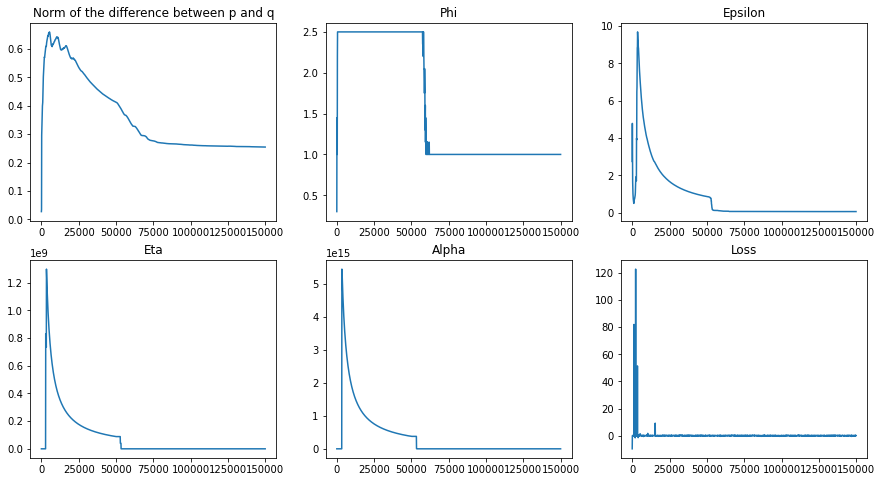

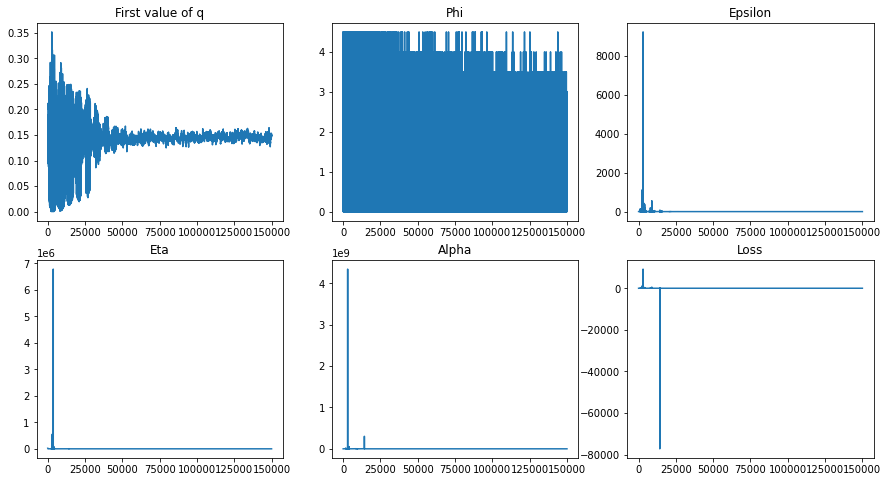


 


 	 EXP THRESHOLD 0.35000000000000003 
 
 

epoch 0: 
 	 epsilon_=1.3205820322036743 and grad = 1.0 and lr = 0.011664999999999816 
 	 eta_=9.990045547485352 and grad = -1.0 and lr = 0.011664999999999816 
 	 alpha_=10.010045051574707 and grad = 0.2999850809574127 and lr = 0.011664999999999816 
 	 s_=tensor([-1.5512, -1.7335, -2.2178, -3.3809, -2.4466, -3.4275, -2.3862, -2.5685,
        -3.9956, -6.2782, -4.1960, -6.2962, -3.1846, -4.3478, -4.1474, -6.4300,
        -5.4729, -6.6124, -3.4275, -4.4083, -4.3618, -6.4620, -5.4869, -6.6263],
       requires_grad=True)
 	 q2=tensor([0.2011, 0.1701, 0.1101, 0.0356, 0.0885, 0.0341, 0.0937, 0.0787, 0.0194,
        0.0020, 0.0159, 0.0019, 0.0432, 0.0137, 0.0167, 0.0017, 0.0044, 0.0014,
        0.0341, 0.0129, 0.0135, 0.0016, 0.0043, 0.0014],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 1.0000,  1.0000, -0.7586, -0.2597, -0.6149, -0.2466, -0.6701, -0.5583,
        -0.1430, -0.0145, -0.1172, -0.0142, -0.3163, -0.1005, -0.1227, 

epoch 10500: 
 	 epsilon_=0.0020603209268301725 and grad = -0.0017540655098855495 and lr = 1.257917499999999 
 	 eta_=0.00775576289743185 and grad = -0.0041542649269104 and lr = 1.257917499999999 
 	 alpha_=0.28189143538475037 and grad = 0.010389639064669609 and lr = 1.257917499999999 
 	 s_=tensor([-1.0040, -1.1061, -0.7975, -0.0929, -0.2397, -0.1663, -0.4856, -0.5476,
        -0.1952,  0.0230, -0.2014,  0.0235, -0.1799, -0.2796,  0.0572,  0.3375,
         0.0355,  0.3045,  0.0480, -0.2019, -0.2024, -0.2227,  0.1366, -0.1509],
       requires_grad=True)
 	 q2=tensor([0.0210, 0.0184, 0.0242, 0.0435, 0.0380, 0.0414, 0.0323, 0.0317, 0.0406,
        0.0450, 0.0427, 0.0535, 0.0420, 0.0396, 0.0527, 0.0627, 0.0458, 0.0581,
        0.0489, 0.0409, 0.0405, 0.0392, 0.0491, 0.0480],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 1.7904e-04, -1.3006e-05,  1.8418e-04, -3.9403e-04,  6.7341e-04,
         5.9984e-04,  4.2522e-04, -5.3640e-06, -3.1023e-04,  5.6145e-04,
         3.2385e

epoch 21000: 
 	 epsilon_=0.06498714536428452 and grad = 0.07894620299339294 and lr = 0.6341668749999998 
 	 eta_=2.6817049980163574 and grad = 0.003150850534439087 and lr = 0.6341668749999998 
 	 alpha_=4.522929668426514 and grad = 0.0639713853597641 and lr = 0.6341668749999998 
 	 s_=tensor([ 2.7514,  2.4163,  1.5179, -0.3200,  0.9618, -0.4321,  1.1239,  0.7952,
        -1.2554, -1.7865, -1.2939, -1.8357, -0.0246, -1.4930, -1.2189, -1.9768,
        -1.5289, -2.1164, -0.3472, -1.4613, -1.7215, -1.5740, -2.2021, -2.1532],
       requires_grad=True)
 	 q2=tensor([0.1649, 0.1421, 0.1176, 0.0360, 0.0873, 0.0316, 0.0907, 0.0717, 0.0176,
        0.0119, 0.0154, 0.0114, 0.0460, 0.0157, 0.0161, 0.0081, 0.0153, 0.0086,
        0.0317, 0.0163, 0.0129, 0.0148, 0.0083, 0.0081],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-0.0336,  0.0038, -0.1049, -0.0664,  0.1178,  0.0587,  0.1839,  0.1319,
         0.0289, -0.0319, -0.0351, -0.0258, -0.0687, -0.0435, -0.0347, -0.0207,
        

epoch 33000: 
 	 epsilon_=0.062109414488077164 and grad = -0.029070354998111725 and lr = 0.16604171874999996 
 	 eta_=0.6088104844093323 and grad = -0.1264646202325821 and lr = 0.16604171874999996 
 	 alpha_=3.052879571914673 and grad = 0.11760231852531433 and lr = 0.16604171874999996 
 	 s_=tensor([ 1.2380,  1.1809,  1.4176, -0.2831,  1.0831, -0.3930,  1.2345,  0.8292,
        -0.7077, -0.8875, -0.8115, -0.8713, -0.0551, -0.9141, -0.7666, -0.9128,
        -0.9041, -0.9378, -0.3738, -0.9135, -0.8812, -0.9133, -0.9257, -0.9136],
       requires_grad=True)
 	 q2=tensor([0.0917, 0.0885, 0.1011, 0.0351, 0.0888, 0.0326, 0.0952, 0.0779, 0.0257,
        0.0219, 0.0240, 0.0223, 0.0417, 0.0221, 0.0251, 0.0217, 0.0223, 0.0208,
        0.0332, 0.0218, 0.0224, 0.0215, 0.0212, 0.0213],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 0.0372,  0.0375,  0.0315, -0.0101, -0.0131,  0.0186, -0.0103, -0.0282,
        -0.0093, -0.0070, -0.0082, -0.0079,  0.0189, -0.0080, -0.00

epoch 45000: 
 	 epsilon_=0.08605973422527313 and grad = -0.023236669600009918 and lr = 0.04901042968749999 
 	 eta_=0.8034091591835022 and grad = -0.1404905617237091 and lr = 0.04901042968749999 
 	 alpha_=2.79603910446167 and grad = 0.0971413105726242 and lr = 0.04901042968749999 
 	 s_=tensor([ 2.2699e+00,  2.5146e+00,  1.5054e+00, -2.8280e-01,  1.1735e+00,
        -3.3907e-01,  1.2727e+00,  9.5114e-01, -1.0214e+00, -1.3900e+00,
        -1.2554e+00, -1.4173e+00,  1.5611e-03, -1.3410e+00, -1.1934e+00,
        -1.3943e+00, -1.3724e+00, -1.3779e+00, -3.4905e-01, -1.3880e+00,
        -1.3979e+00, -1.3674e+00, -1.3922e+00, -1.3685e+00],
       requires_grad=True)
 	 q2=tensor([0.1429, 0.1568, 0.1029, 0.0341, 0.0868, 0.0328, 0.0921, 0.0767, 0.0185,
        0.0137, 0.0151, 0.0133, 0.0421, 0.0142, 0.0161, 0.0136, 0.0138, 0.0137,
        0.0324, 0.0135, 0.0135, 0.0138, 0.0136, 0.0139],
       grad_fn=<DivBackward0>) and sum=0.9999997615814209 and grad = tensor([ 0.0178,  0.0370,  0.0279,  0.

epoch 55500: 
 	 epsilon_=0.07474261522293091 and grad = -0.02565614879131317 and lr = 0.014881181640625005 
 	 eta_=0.7215035557746887 and grad = -0.01722760498523712 and lr = 0.014881181640625005 
 	 alpha_=3.0274133682250977 and grad = 0.03747933357954025 and lr = 0.014881181640625005 
 	 s_=tensor([ 2.2123,  2.2383,  1.6311, -0.2700,  1.1587, -0.3389,  1.2778,  0.9420,
        -1.0222, -1.3336, -1.2524, -1.3270, -0.0134, -1.3296, -1.2004, -1.3289,
        -1.3160, -1.3146, -0.3357, -1.3067, -1.3113, -1.3126, -1.2764, -1.3193],
       requires_grad=True)
 	 q2=tensor([0.1406, 0.1421, 0.1099, 0.0344, 0.0869, 0.0326, 0.0926, 0.0773, 0.0186,
        0.0142, 0.0153, 0.0143, 0.0418, 0.0143, 0.0160, 0.0143, 0.0145, 0.0145,
        0.0328, 0.0146, 0.0145, 0.0145, 0.0150, 0.0144],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0257,  0.0140,  0.0292, -0.0251,  0.0182,  0.0127,  0.0211,  0.0309,
        -0.0162, -0.0124, -0.0124, -0.0123, -0.0310, -0.0119, -0.0142, -0.0128,

epoch 67500: 
 	 epsilon_=0.067022405564785 and grad = -0.026260916143655777 and lr = 0.011220295410156251 
 	 eta_=0.6649275422096252 and grad = -0.005329445004463196 and lr = 0.011220295410156251 
 	 alpha_=3.064159631729126 and grad = 0.03361315280199051 and lr = 0.011220295410156251 
 	 s_=tensor([ 2.3356e+00,  2.0679e+00,  1.6097e+00, -2.6624e-01,  1.1796e+00,
        -3.2477e-01,  1.2894e+00,  9.5960e-01, -1.0188e+00, -1.2747e+00,
        -1.2372e+00, -1.2569e+00,  8.9067e-04, -1.2630e+00, -1.1924e+00,
        -1.2651e+00, -1.2777e+00, -1.2532e+00, -3.2588e-01, -1.2696e+00,
        -1.2660e+00, -1.2664e+00, -1.2630e+00, -1.2599e+00],
       requires_grad=True)
 	 q2=tensor([0.1465, 0.1318, 0.1080, 0.0343, 0.0872, 0.0328, 0.0923, 0.0775, 0.0186,
        0.0149, 0.0154, 0.0151, 0.0418, 0.0150, 0.0160, 0.0150, 0.0149, 0.0152,
        0.0328, 0.0150, 0.0150, 0.0150, 0.0151, 0.0151],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 0.0304,  0.0174,  0.0224

epoch 78000: 
 	 epsilon_=0.07533577084541321 and grad = -0.025744348764419556 and lr = 0.010000203247070313 
 	 eta_=0.7222586870193481 and grad = -0.028758421540260315 and lr = 0.010000203247070313 
 	 alpha_=2.9404120445251465 and grad = 0.03961363434791565 and lr = 0.010000203247070313 
 	 s_=tensor([ 2.3031,  2.3277,  1.6209, -0.2711,  1.1470, -0.3319,  1.2882,  0.9400,
        -1.0220, -1.3775, -1.2545, -1.3733, -0.0073, -1.3663, -1.1957, -1.3687,
        -1.3637, -1.3805, -0.3320, -1.3854, -1.3781, -1.3655, -1.3574, -1.3633],
       requires_grad=True)
 	 q2=tensor([0.1456, 0.1472, 0.1091, 0.0344, 0.0863, 0.0328, 0.0928, 0.0769, 0.0186,
        0.0136, 0.0152, 0.0137, 0.0418, 0.0137, 0.0160, 0.0137, 0.0138, 0.0135,
        0.0328, 0.0135, 0.0136, 0.0137, 0.0138, 0.0138],
       grad_fn=<DivBackward0>) and sum=0.9999998807907104 and grad = tensor([-0.0096,  0.0249,  0.0157, -0.0197,  0.0109, -0.0216,  0.0208,  0.0424,
        -0.0092, -0.0125, -0.0118, -0.0099,  0.0084, -0.0098, 

epoch 88500: 
 	 epsilon_=0.07119861990213394 and grad = -0.026405278593301773 and lr = 0.010152333679199219 
 	 eta_=0.6894574165344238 and grad = -0.015389055013656616 and lr = 0.010152333679199219 
 	 alpha_=2.987471103668213 and grad = 0.03684728592634201 and lr = 0.010152333679199219 
 	 s_=tensor([ 2.3521e+00,  2.1843e+00,  1.5771e+00, -2.6214e-01,  1.1757e+00,
        -3.2455e-01,  1.3007e+00,  9.5622e-01, -1.0172e+00, -1.2982e+00,
        -1.2415e+00, -1.3076e+00,  4.5390e-07, -1.2975e+00, -1.1843e+00,
        -1.2970e+00, -1.2778e+00, -1.3006e+00, -3.2332e-01, -1.3071e+00,
        -1.3109e+00, -1.2973e+00, -1.3042e+00, -1.3049e+00],
       requires_grad=True)
 	 q2=tensor([0.1474, 0.1380, 0.1062, 0.0344, 0.0870, 0.0328, 0.0928, 0.0771, 0.0186,
        0.0146, 0.0153, 0.0144, 0.0417, 0.0145, 0.0161, 0.0146, 0.0148, 0.0145,
        0.0328, 0.0145, 0.0144, 0.0146, 0.0145, 0.0145],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 0.0032,  0.0242,  0.02

epoch 99000: 
 	 epsilon_=0.07526519149541855 and grad = -0.02551715448498726 and lr = 0.010076192245483399 
 	 eta_=0.7279218435287476 and grad = 0.23756158351898193 and lr = 0.010076192245483399 
 	 alpha_=2.9499902725219727 and grad = -0.07894650846719742 and lr = 0.010076192245483399 
 	 s_=tensor([ 2.3123,  2.2607,  1.6182, -0.2726,  1.1633, -0.3331,  1.2710,  0.9395,
        -1.0271, -1.3678, -1.2563, -1.3621, -0.0157, -1.3467, -1.2021, -1.3491,
        -1.3373, -1.3413, -0.3310, -1.3525, -1.3404, -1.3231, -1.3421, -1.3513],
       requires_grad=True)
 	 q2=tensor([0.1461, 0.1432, 0.1091, 0.0344, 0.0869, 0.0327, 0.0921, 0.0770, 0.0186,
        0.0138, 0.0152, 0.0139, 0.0416, 0.0140, 0.0160, 0.0140, 0.0141, 0.0141,
        0.0328, 0.0140, 0.0141, 0.0143, 0.0141, 0.0140],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 0.0201,  0.0200,  0.0185, -0.0282,  0.0169,  0.0093,  0.0173,  0.0159,
         0.0060, -0.0133, -0.0145, -0.0134,  0.0110, -0.0135, -0

epoch 109500: 
 	 epsilon_=0.0754634365439415 and grad = -0.025635331869125366 and lr = 0.010009533557891847 
 	 eta_=0.7266945838928223 and grad = 0.23713824152946472 and lr = 0.010009533557891847 
 	 alpha_=2.9914004802703857 and grad = -0.07699678838253021 and lr = 0.010009533557891847 
 	 s_=tensor([ 2.2492,  2.3048,  1.6373, -0.2774,  1.1313, -0.3359,  1.2646,  0.9308,
        -1.0239, -1.3339, -1.2527, -1.3405, -0.0081, -1.3136, -1.1991, -1.3235,
        -1.3313, -1.3377, -0.3345, -1.3344, -1.3362, -1.3311, -1.3519, -1.3274],
       requires_grad=True)
 	 q2=tensor([0.1426, 0.1456, 0.1102, 0.0343, 0.0857, 0.0327, 0.0918, 0.0766, 0.0186,
        0.0142, 0.0153, 0.0141, 0.0418, 0.0144, 0.0160, 0.0143, 0.0142, 0.0141,
        0.0328, 0.0142, 0.0141, 0.0142, 0.0140, 0.0142],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0300,  0.0446, -0.0393,  0.0132,  0.0249,  0.0181, -0.0039,  0.0117,
        -0.0141, -0.0105, -0.0116, -0.0108, -0.0198, -0.0109, -0.0111, -0.0103

epoch 120000: 
 	 epsilon_=0.08011913299560547 and grad = -0.02469760924577713 and lr = 0.010000001587867737 
 	 eta_=0.762597918510437 and grad = -0.03467109799385071 and lr = 0.010000001587867737 
 	 alpha_=2.8086013793945312 and grad = 0.04543577879667282 and lr = 0.010000001587867737 
 	 s_=tensor([ 2.3368,  2.2930,  1.6132, -0.2713,  1.1754, -0.3282,  1.2876,  0.9503,
        -1.0201, -1.3528, -1.2498, -1.3496, -0.0028, -1.3464, -1.1948, -1.3436,
        -1.3609, -1.3448, -0.3298, -1.3528, -1.3472, -1.3673, -1.3633, -1.3591],
       requires_grad=True)
 	 q2=tensor([0.1465, 0.1445, 0.1084, 0.0342, 0.0872, 0.0328, 0.0926, 0.0771, 0.0186,
        0.0139, 0.0152, 0.0139, 0.0418, 0.0140, 0.0160, 0.0140, 0.0138, 0.0140,
        0.0328, 0.0139, 0.0139, 0.0137, 0.0138, 0.0138],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 0.0406, -0.0141,  0.0389, -0.0033,  0.0247, -0.0324,  0.0036,  0.0150,
        -0.0193, -0.0144,  0.0059, -0.0146,  0.0105, -0.0121, -0

epoch 130500: 
 	 epsilon_=0.0750533938407898 and grad = -0.02566833794116974 and lr = 0.010001190106868745 
 	 eta_=0.7244523763656616 and grad = -0.024830088019371033 and lr = 0.010001190106868745 
 	 alpha_=2.853663206100464 and grad = 0.041766583919525146 and lr = 0.010001190106868745 
 	 s_=tensor([ 2.1558,  2.4226,  1.6376, -0.2663,  1.1560, -0.3270,  1.2768,  0.9583,
        -1.0186, -1.3170, -1.2467, -1.3071,  0.0031, -1.3423, -1.1848, -1.3199,
        -1.3288, -1.3170, -0.3260, -1.3321, -1.3250, -1.2915, -1.3055, -1.3240],
       requires_grad=True)
 	 q2=tensor([0.1364, 0.1510, 0.1093, 0.0342, 0.0861, 0.0327, 0.0918, 0.0773, 0.0186,
        0.0143, 0.0152, 0.0144, 0.0419, 0.0140, 0.0161, 0.0142, 0.0141, 0.0143,
        0.0327, 0.0141, 0.0142, 0.0146, 0.0144, 0.0142],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 0.0311,  0.0261,  0.0216,  0.0188, -0.0119,  0.0067,  0.0211,  0.0089,
        -0.0173, -0.0145, -0.0156, -0.0150, -0.0306, -0.0165, -

epoch 141000: 
 	 epsilon_=0.07385233044624329 and grad = -0.025339916348457336 and lr = 0.01000059525191784 
 	 eta_=0.7202048897743225 and grad = -0.11574143171310425 and lr = 0.01000059525191784 
 	 alpha_=2.888834238052368 and grad = 0.08151685446500778 and lr = 0.01000059525191784 
 	 s_=tensor([ 2.2926,  2.3166,  1.6193, -0.2671,  1.1664, -0.3309,  1.2950,  0.9495,
        -1.0181, -1.3418, -1.2448, -1.3509, -0.0057, -1.3591, -1.1923, -1.3417,
        -1.3617, -1.3533, -0.3263, -1.3632, -1.3471, -1.3373, -1.3393, -1.3474],
       requires_grad=True)
 	 q2=tensor([0.1442, 0.1458, 0.1089, 0.0344, 0.0868, 0.0327, 0.0926, 0.0771, 0.0186,
        0.0140, 0.0153, 0.0139, 0.0416, 0.0138, 0.0160, 0.0140, 0.0137, 0.0139,
        0.0328, 0.0138, 0.0139, 0.0141, 0.0140, 0.0139],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0143,  0.0242, -0.0065, -0.0259,  0.0082,  0.0098,  0.0381,  0.0126,
        -0.0141, -0.0163, -0.0158, -0.0143,  0.0178, -0.0130, -0.0155, -0.0124,
 

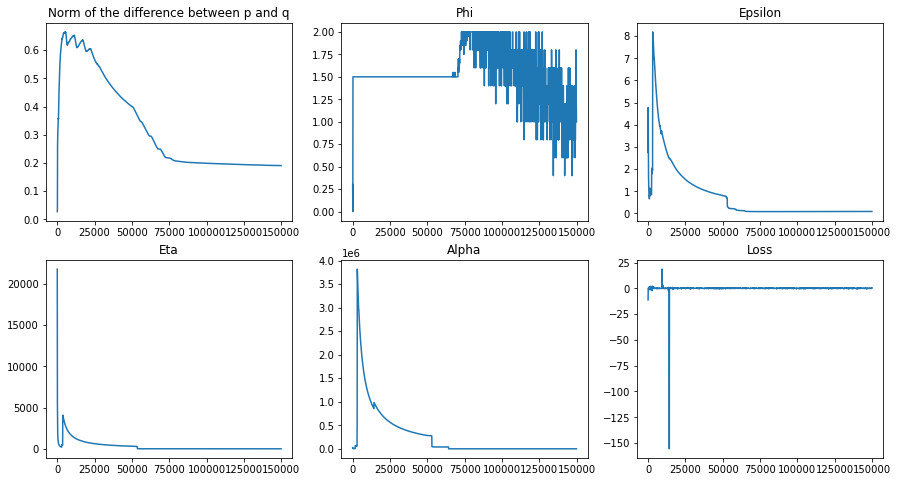

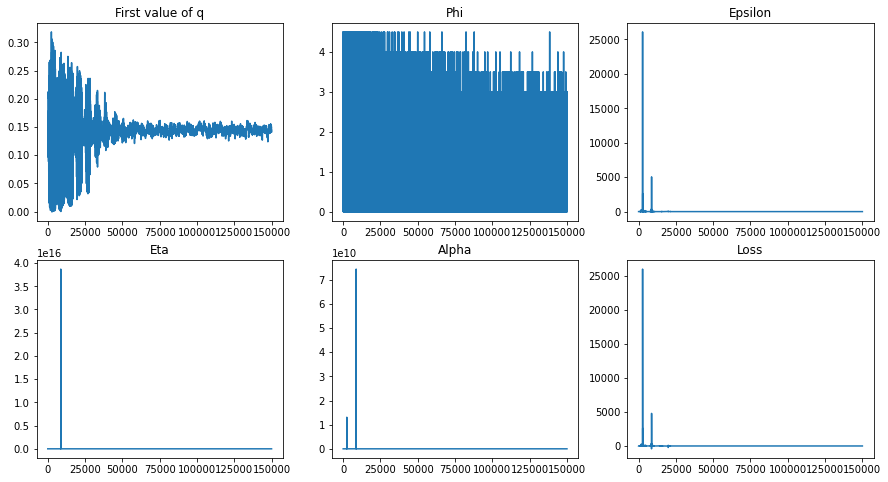


 


 	 EXP THRESHOLD 0.4 
 
 

epoch 0: 
 	 epsilon_=1.3139928579330444 and grad = 1.0 and lr = 0.0026664999999998166 
 	 eta_=9.999045372009277 and grad = -1.0 and lr = 0.0026664999999998166 
 	 alpha_=10.001046180725098 and grad = 0.24998760223388672 and lr = 0.0026664999999998166 
 	 s_=tensor([-1.5602, -1.7425, -2.2088, -3.3719, -2.4376, -3.4185, -2.3772, -2.5595,
        -3.9866, -6.2872, -4.1870, -6.3052, -3.1756, -4.3388, -4.1384, -6.4390,
        -5.4819, -6.6214, -3.4185, -4.3993, -4.3528, -6.4710, -5.4959, -6.6353],
       requires_grad=True)
 	 q2=tensor([0.2011, 0.1701, 0.1101, 0.0356, 0.0885, 0.0341, 0.0937, 0.0787, 0.0194,
        0.0020, 0.0159, 0.0019, 0.0432, 0.0137, 0.0167, 0.0017, 0.0044, 0.0014,
        0.0341, 0.0129, 0.0135, 0.0016, 0.0043, 0.0014],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 1.0000,  1.0000, -0.7851, -0.2444, -0.5975, -0.2423, -0.6356, -0.5814,
        -0.1374, -0.0142, -0.1140, -0.0139, -0.2921, -0.0985, -0.1218, -0.0122,
   

epoch 10500: 
 	 epsilon_=0.002373605500906706 and grad = -0.0026518080849200487 and lr = 1.250041749999999 
 	 eta_=0.003905409248545766 and grad = -0.00024233944714069366 and lr = 1.250041749999999 
 	 alpha_=0.377940833568573 and grad = 0.0035612047649919987 and lr = 1.250041749999999 
 	 s_=tensor([-0.9010, -0.3106,  0.0523, -0.0672, -0.4539,  0.1143, -0.3959, -0.2001,
         0.2910, -0.2073, -0.0805, -0.2116, -0.2466, -0.1608,  0.1795, -0.1741,
        -0.3663, -0.1138, -0.0590, -0.1719,  0.4256, -0.1230, -0.4070, -0.2287],
       requires_grad=True)
 	 q2=tensor([0.0271, 0.0433, 0.0557, 0.0444, 0.0336, 0.0477, 0.0339, 0.0397, 0.0540,
        0.0366, 0.0456, 0.0363, 0.0351, 0.0431, 0.0584, 0.0374, 0.0325, 0.0393,
        0.0440, 0.0426, 0.0619, 0.0380, 0.0336, 0.0363],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 1.8611e-04, -3.3766e-05,  2.8679e-04,  6.1733e-05,  1.5461e-04,
        -2.0593e-04,  4.0086e-04,  2.1116e-04, -2.0843e-04,  4.2763e-05

epoch 21000: 
 	 epsilon_=0.02002641186118126 and grad = -0.0526733435690403 and lr = 0.6257291874999997 
 	 eta_=0.0008183786412701011 and grad = 0.0009850487112998962 and lr = 0.6257291874999997 
 	 alpha_=7.562708377838135 and grad = 1.4767598258913495e-05 and lr = 0.6257291874999997 
 	 s_=tensor([ 4.0081,  2.7181,  0.7182,  0.5695,  1.8859,  0.9638,  1.7651,  1.9572,
         0.8015,  1.2091, -0.3474,  1.0900,  0.7762, -0.3934,  0.4605,  1.3648,
         1.1703,  1.1525,  0.5183, -0.7648, -0.2429,  1.3141,  0.9932,  1.1174],
       requires_grad=True)
 	 q2=tensor([0.1272, 0.0899, 0.0366, 0.0315, 0.0625, 0.0374, 0.0604, 0.0640, 0.0325,
        0.0415, 0.0142, 0.0348, 0.0343, 0.0138, 0.0266, 0.0415, 0.0386, 0.0399,
        0.0306, 0.0101, 0.0152, 0.0415, 0.0375, 0.0379],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 5.4372e-05,  3.8169e-05,  2.4543e-05,  2.8816e-05,  4.3774e-05,
        -4.0259e-05,  3.8988e-05,  4.2785e-05, -3.4312e-05, -4.6533e-05,

epoch 31500: 
 	 epsilon_=0.05632845684885979 and grad = -0.02650155872106552 and lr = 0.07916926562500007 
 	 eta_=0.5819751024246216 and grad = 0.230162113904953 and lr = 0.07916926562500007 
 	 alpha_=3.4085583686828613 and grad = -0.046918150037527084 and lr = 0.07916926562500007 
 	 s_=tensor([ 1.8015,  1.8559,  1.6129, -0.2822,  1.1686, -0.3336,  1.2990,  0.9458,
        -1.0138, -1.0738, -1.0752, -1.1287, -0.0113, -1.1001, -1.0648, -1.0896,
        -1.0260, -1.1262, -0.3256, -1.0738, -1.0703, -1.0964, -1.1034, -1.0581],
       requires_grad=True)
 	 q2=tensor([0.1183, 0.1213, 0.1092, 0.0343, 0.0872, 0.0326, 0.0928, 0.0773, 0.0187,
        0.0184, 0.0181, 0.0173, 0.0415, 0.0177, 0.0181, 0.0177, 0.0187, 0.0174,
        0.0330, 0.0183, 0.0181, 0.0179, 0.0175, 0.0188],
       grad_fn=<DivBackward0>) and sum=0.9999998807907104 and grad = tensor([ 0.0230,  0.0212,  0.0164,  0.0070,  0.0145,  0.0094,  0.0127,  0.0102,
        -0.0132, -0.0143, -0.0139, -0.0122,  0.0064, -0.0129, -0.012

epoch 42000: 
 	 epsilon_=0.06360343098640442 and grad = -0.02720363438129425 and lr = 0.001013019531250016 
 	 eta_=0.6242815852165222 and grad = -0.05710500478744507 and lr = 0.001013019531250016 
 	 alpha_=3.3067874908447266 and grad = 0.05499252304434776 and lr = 0.001013019531250016 
 	 s_=tensor([ 2.0682,  2.0421,  1.6384, -0.2694,  1.1755, -0.3302,  1.2907,  0.9516,
        -1.0230, -1.1939, -1.1919, -1.1843, -0.0053, -1.1916, -1.1941, -1.2018,
        -1.1902, -1.1876, -0.3298, -1.1951, -1.1954, -1.1826, -1.1940, -1.1968],
       requires_grad=True)
 	 q2=tensor([0.1324, 0.1310, 0.1099, 0.0344, 0.0874, 0.0328, 0.0929, 0.0774, 0.0186,
        0.0160, 0.0160, 0.0162, 0.0418, 0.0161, 0.0160, 0.0159, 0.0161, 0.0161,
        0.0328, 0.0160, 0.0160, 0.0162, 0.0160, 0.0160],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0374,  0.0250, -0.0104,  0.0066,  0.0101,  0.0086,  0.0233,  0.0083,
        -0.0151, -0.0136, -0.0134, -0.0139,  0.0137, -0.0139, -0.0130, -0.0133,

epoch 52500: 
 	 epsilon_=0.06757862120866776 and grad = -0.026644356548786163 and lr = 0.010758138671874994 
 	 eta_=0.6616913080215454 and grad = 0.006474003195762634 and lr = 0.010758138671874994 
 	 alpha_=3.232734441757202 and grad = 0.030372481793165207 and lr = 0.010758138671874994 
 	 s_=tensor([ 2.0537,  2.1244,  1.6275, -0.2747,  1.1651, -0.3383,  1.2663,  0.9389,
        -1.0222, -1.2478, -1.2173, -1.2284, -0.0132, -1.2140, -1.1998, -1.2172,
        -1.1928, -1.2168, -0.3389, -1.2074, -1.2198, -1.2336, -1.2396, -1.2346],
       requires_grad=True)
 	 q2=tensor([0.1321, 0.1360, 0.1101, 0.0344, 0.0875, 0.0327, 0.0922, 0.0773, 0.0187,
        0.0153, 0.0158, 0.0157, 0.0418, 0.0158, 0.0160, 0.0158, 0.0161, 0.0158,
        0.0327, 0.0160, 0.0157, 0.0156, 0.0154, 0.0155],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 0.0345,  0.0324, -0.0180, -0.0153, -0.0356,  0.0187,  0.0172,  0.0080,
        -0.0118, -0.0087, -0.0070, -0.0115,  0.0132, -0.0102, -

epoch 63000: 
 	 epsilon_=0.06422539055347443 and grad = -0.027101770043373108 and lr = 0.005880696777343748 
 	 eta_=0.6300960183143616 and grad = 0.010080575942993164 and lr = 0.005880696777343748 
 	 alpha_=3.302438974380493 and grad = 0.02784624695777893 and lr = 0.005880696777343748 
 	 s_=tensor([ 1.9964,  2.1911,  1.6313, -0.2688,  1.1768, -0.3275,  1.2865,  0.9542,
        -1.0229, -1.2022, -1.2090, -1.2044, -0.0039, -1.2166, -1.1812, -1.1987,
        -1.2166, -1.2141, -0.3282, -1.2172, -1.2064, -1.2025, -1.2177, -1.2136],
       requires_grad=True)
 	 q2=tensor([0.1283, 0.1389, 0.1095, 0.0343, 0.0875, 0.0328, 0.0925, 0.0774, 0.0186,
        0.0159, 0.0158, 0.0159, 0.0418, 0.0157, 0.0162, 0.0160, 0.0157, 0.0157,
        0.0328, 0.0157, 0.0158, 0.0159, 0.0157, 0.0158],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0126,  0.0313,  0.0070,  0.0082,  0.0019, -0.0222,  0.0200,  0.0184,
        -0.0135, -0.0128, -0.0140, -0.0121,  0.0086, -0.0139, -0.0126, -0.0138,

epoch 75000: 
 	 epsilon_=0.06268790364265442 and grad = -0.027422025799751282 and lr = 0.002220174194335937 
 	 eta_=0.6135321259498596 and grad = 0.012867018580436707 and lr = 0.002220174194335937 
 	 alpha_=3.302097797393799 and grad = 0.027103383094072342 and lr = 0.002220174194335937 
 	 s_=tensor([ 1.9973,  2.1419,  1.6419, -0.2659,  1.1765, -0.3268,  1.2972,  0.9588,
        -1.0200, -1.1930, -1.1877, -1.1921, -0.0024, -1.1914, -1.1856, -1.1862,
        -1.1952, -1.1970, -0.3255, -1.1812, -1.1938, -1.1982, -1.1895, -1.1876],
       requires_grad=True)
 	 q2=tensor([0.1282, 0.1360, 0.1098, 0.0343, 0.0872, 0.0328, 0.0929, 0.0774, 0.0186,
        0.0160, 0.0161, 0.0160, 0.0418, 0.0160, 0.0161, 0.0161, 0.0160, 0.0159,
        0.0328, 0.0161, 0.0160, 0.0159, 0.0160, 0.0161],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 0.0059,  0.0209,  0.0325,  0.0111,  0.0317,  0.0131,  0.0085, -0.0511,
        -0.0116, -0.0088, -0.0099, -0.0094,  0.0209, -0.0092, -

epoch 85500: 
 	 epsilon_=0.06442990154027939 and grad = -0.027117598801851273 and lr = 0.0011526743469238282 
 	 eta_=0.6320189833641052 and grad = 0.007031470537185669 and lr = 0.0011526743469238282 
 	 alpha_=3.261143445968628 and grad = 0.028580721467733383 and lr = 0.0011526743469238282 
 	 s_=tensor([ 2.1032,  2.1087,  1.6363, -0.2685,  1.1773, -0.3288,  1.2928,  0.9517,
        -1.0228, -1.2201, -1.2126, -1.2235, -0.0037, -1.2231, -1.1949, -1.2267,
        -1.2215, -1.2226, -0.3290, -1.2228, -1.2241, -1.2224, -1.2255, -1.2126],
       requires_grad=True)
 	 q2=tensor([0.1342, 0.1345, 0.1097, 0.0344, 0.0875, 0.0328, 0.0929, 0.0773, 0.0186,
        0.0156, 0.0157, 0.0156, 0.0418, 0.0156, 0.0160, 0.0156, 0.0156, 0.0156,
        0.0328, 0.0156, 0.0156, 0.0156, 0.0156, 0.0157],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0086,  0.0409,  0.0272,  0.0159, -0.0371, -0.0113,  0.0119,  0.0327,
        -0.0111, -0.0107, -0.0097, -0.0101, -0.0153, -0.0101, -0.0096, -0.0

epoch 96000: 
 	 epsilon_=0.06591877341270447 and grad = -0.02686411514878273 and lr = 0.0010000254287719724 
 	 eta_=0.6471563577651978 and grad = 0.0035984814167022705 and lr = 0.0010000254287719724 
 	 alpha_=3.2365317344665527 and grad = 0.029664620757102966 and lr = 0.0010000254287719724 
 	 s_=tensor([ 2.0801,  2.1647,  1.6360, -0.2704,  1.1739, -0.3314,  1.2899,  0.9508,
        -1.0249, -1.2395, -1.2403, -1.2380, -0.0068, -1.2446, -1.1987, -1.2345,
        -1.2304, -1.2346, -0.3310, -1.2370, -1.2354, -1.2390, -1.2370, -1.2457],
       requires_grad=True)
 	 q2=tensor([0.1332, 0.1377, 0.1099, 0.0344, 0.0874, 0.0328, 0.0929, 0.0774, 0.0186,
        0.0154, 0.0154, 0.0154, 0.0418, 0.0153, 0.0160, 0.0155, 0.0155, 0.0155,
        0.0328, 0.0154, 0.0155, 0.0154, 0.0154, 0.0153],
       grad_fn=<DivBackward0>) and sum=0.9999998807907104 and grad = tensor([ 0.0311,  0.0225, -0.0010, -0.0248,  0.0231,  0.0086,  0.0046,  0.0157,
        -0.0160, -0.0150, -0.0125, -0.0138,  0.0151, -0.014

epoch 106500: 
 	 epsilon_=0.06776222586631775 and grad = -0.026577390730381012 and lr = 0.001019058864593506 
 	 eta_=0.6644851565361023 and grad = -0.0019855797290802 and lr = 0.001019058864593506 
 	 alpha_=3.187148094177246 and grad = 0.03136269003152847 and lr = 0.001019058864593506 
 	 s_=tensor([ 2.1103,  2.2005,  1.6321, -0.2719,  1.1716, -0.3322,  1.2864,  0.9487,
        -1.0258, -1.2628, -1.2546, -1.2610, -0.0078, -1.2626, -1.2001, -1.2642,
        -1.2728, -1.2589, -0.3328, -1.2641, -1.2558, -1.2603, -1.2670, -1.2612],
       requires_grad=True)
 	 q2=tensor([0.1349, 0.1398, 0.1098, 0.0344, 0.0874, 0.0328, 0.0928, 0.0774, 0.0186,
        0.0151, 0.0152, 0.0151, 0.0418, 0.0151, 0.0160, 0.0151, 0.0150, 0.0152,
        0.0328, 0.0151, 0.0152, 0.0151, 0.0151, 0.0151],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0238,  0.0061,  0.0155, -0.0331,  0.0140, -0.0191,  0.0206,  0.0239,
        -0.0154, -0.0121, -0.0108, -0.0122,  0.0248, -0.0129, -0.0122, -0.0119,

epoch 117000: 
 	 epsilon_=0.06401759386062622 and grad = -0.02716531977057457 and lr = 0.0010095326108932497 
 	 eta_=0.628158688545227 and grad = 0.2228819578886032 and lr = 0.0010095326108932497 
 	 alpha_=3.256787061691284 and grad = -0.056931667029857635 and lr = 0.0010095326108932497 
 	 s_=tensor([ 2.0455,  2.1505,  1.6410, -0.2668,  1.1792, -0.3274,  1.2949,  0.9555,
        -1.0216, -1.2180, -1.2175, -1.2158, -0.0026, -1.2166, -1.1942, -1.2153,
        -1.2125, -1.2162, -0.3274, -1.2121, -1.2050, -1.2117, -1.2120, -1.2123],
       requires_grad=True)
 	 q2=tensor([0.1310, 0.1366, 0.1099, 0.0344, 0.0875, 0.0328, 0.0929, 0.0774, 0.0186,
        0.0157, 0.0157, 0.0157, 0.0418, 0.0157, 0.0160, 0.0157, 0.0157, 0.0157,
        0.0328, 0.0157, 0.0158, 0.0157, 0.0157, 0.0157],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0047,  0.0383,  0.0331, -0.0289,  0.0147, -0.0239,  0.0365,  0.0082,
        -0.0106, -0.0119, -0.0119, -0.0114, -0.0330, -0.0138, -0.0126, -0.012

epoch 129000: 
 	 epsilon_=0.0670568123459816 and grad = -0.026683051139116287 and lr = 0.0010023831527233124 
 	 eta_=0.6578646302223206 and grad = -0.00047966837882995605 and lr = 0.0010023831527233124 
 	 alpha_=3.1945836544036865 and grad = 0.030917569994926453 and lr = 0.0010023831527233124 
 	 s_=tensor([ 2.0961,  2.1974,  1.6355, -0.2706,  1.1724, -0.3315,  1.2895,  0.9508,
        -1.0248, -1.2488, -1.2548, -1.2634, -0.0063, -1.2582, -1.1995, -1.2587,
        -1.2587, -1.2555, -0.3313, -1.2491, -1.2516, -1.2543, -1.2539, -1.2529],
       requires_grad=True)
 	 q2=tensor([0.1341, 0.1396, 0.1099, 0.0344, 0.0874, 0.0328, 0.0929, 0.0774, 0.0186,
        0.0153, 0.0152, 0.0151, 0.0418, 0.0152, 0.0160, 0.0152, 0.0152, 0.0152,
        0.0328, 0.0153, 0.0152, 0.0152, 0.0152, 0.0152],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0196,  0.0252,  0.0359, -0.0024,  0.0240,  0.0068,  0.0108,  0.0173,
        -0.0169, -0.0146, -0.0154, -0.0139, -0.0301, -0.0121, -0.0162, 

epoch 139500: 
 	 epsilon_=0.06762794405221939 and grad = -0.026612497866153717 and lr = 0.0010002981920838355 
 	 eta_=0.6630418300628662 and grad = -0.07350397109985352 and lr = 0.0010002981920838355 
 	 alpha_=3.19770884513855 and grad = 0.0621957965195179 and lr = 0.0010002981920838355 
 	 s_=tensor([ 2.0800,  2.1638,  1.6377, -0.2690,  1.1762, -0.3297,  1.2915,  0.9521,
        -1.0236, -1.2312, -1.2296, -1.2324, -0.0050, -1.2344, -1.1961, -1.2418,
        -1.2365, -1.2343, -0.3294, -1.2293, -1.2345, -1.2367, -1.2331, -1.2431],
       requires_grad=True)
 	 q2=tensor([0.1330, 0.1376, 0.1099, 0.0344, 0.0875, 0.0328, 0.0929, 0.0774, 0.0186,
        0.0155, 0.0155, 0.0155, 0.0418, 0.0155, 0.0160, 0.0154, 0.0154, 0.0155,
        0.0328, 0.0155, 0.0155, 0.0154, 0.0155, 0.0153],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-0.0049,  0.0296,  0.0298,  0.0042,  0.0474, -0.0286,  0.0069,  0.0133,
        -0.0160, -0.0140, -0.0146, -0.0140,  0.0191, -0.0126, -0.0145, -0.013

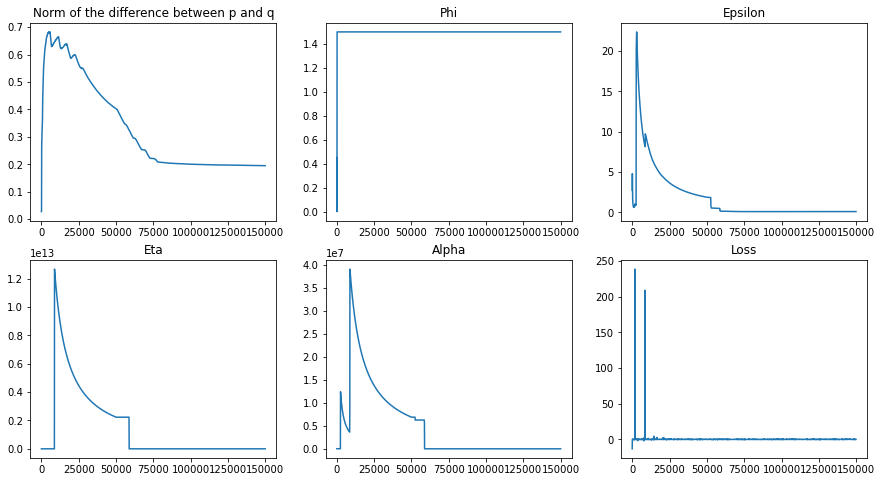

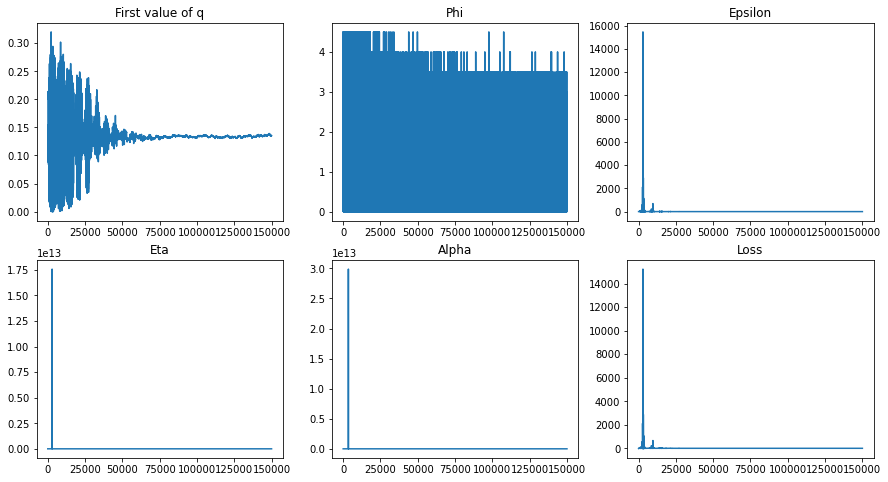


 


 	 EXP THRESHOLD 0.45 
 
 

epoch 0: 
 	 epsilon_=1.3139928579330444 and grad = 1.0 and lr = 0.0026664999999998166 
 	 eta_=9.999045372009277 and grad = -1.0 and lr = 0.0026664999999998166 
 	 alpha_=10.001046180725098 and grad = 0.19999009370803833 and lr = 0.0026664999999998166 
 	 s_=tensor([-1.5602, -1.7425, -2.2088, -3.3719, -2.4376, -3.4185, -2.3772, -2.5595,
        -3.9866, -6.2872, -4.1870, -6.3052, -3.1756, -4.3388, -4.1384, -6.4390,
        -5.4819, -6.6214, -3.4185, -4.3993, -4.3528, -6.4710, -5.4959, -6.6353],
       requires_grad=True)
 	 q2=tensor([0.2011, 0.1701, 0.1101, 0.0356, 0.0885, 0.0341, 0.0937, 0.0787, 0.0194,
        0.0020, 0.0159, 0.0019, 0.0432, 0.0137, 0.0167, 0.0017, 0.0044, 0.0014,
        0.0341, 0.0129, 0.0135, 0.0016, 0.0043, 0.0014],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 1.0000,  1.0000, -0.7551, -0.2585, -0.6468, -0.2514, -0.6787, -0.5667,
        -0.1428, -0.0146, -0.1185, -0.0143, -0.3118, -0.1010, -0.1239, -0.0125,
  

epoch 10500: 
 	 epsilon_=2.1253388695186004e-05 and grad = -2.4519822545698844e-05 and lr = 1.250041749999999 
 	 eta_=9.170790690404829e-06 and grad = 1.9890132989530684e-06 and lr = 1.250041749999999 
 	 alpha_=5.006190299987793 and grad = 1.9637829495877668e-07 and lr = 1.250041749999999 
 	 s_=tensor([ 3.9516,  3.3631,  2.1226,  0.4186,  1.2235, -0.1502,  1.6683,  1.5620,
         0.5911, -2.1008,  0.4054, -2.1399,  0.7717,  0.0043,  0.0924, -2.1723,
        -1.6830, -2.1216,  0.3738, -0.1043,  0.4650, -2.1712, -1.7008, -2.1118],
       requires_grad=True)
 	 q2=tensor([0.1670, 0.1426, 0.0941, 0.0377, 0.0622, 0.0254, 0.0771, 0.0728, 0.0420,
        0.0042, 0.0371, 0.0041, 0.0476, 0.0274, 0.0299, 0.0040, 0.0063, 0.0041,
        0.0367, 0.0253, 0.0381, 0.0040, 0.0062, 0.0042],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 2.5196e-07,  2.5373e-07,  3.5712e-07, -3.0476e-07,  2.3528e-07,
         1.6383e-07,  2.3971e-07,  3.2290e-07, -3.8002e-07, -5.4308

epoch 21000: 
 	 epsilon_=3.0015835762023926 and grad = -0.16060447692871094 and lr = 0.6257291874999997 
 	 eta_=20.12230682373047 and grad = 1.0 and lr = 0.6257291874999997 
 	 alpha_=1.5765749816765151e-09 and grad = -1.0 and lr = 0.6257291874999997 
 	 s_=tensor([-1.3650,  0.1627, -0.7170,  0.8151, -0.2080, -0.0491,  2.1817,  1.6162,
         0.8435, -1.0050, -0.0503,  2.8770, -0.1075, -0.2080, -0.4554,  2.0907,
         0.2062, -0.0294, -0.1574,  0.1001, -0.0857, -0.1583, -0.0377,  0.9134],
       requires_grad=True)
 	 q2=tensor([0.0092, 0.0323, 0.0163, 0.0506, 0.0271, 0.0306, 0.1005, 0.0744, 0.0554,
        0.0151, 0.0306, 0.1273, 0.0292, 0.0250, 0.0207, 0.0986, 0.0332, 0.0312,
        0.0282, 0.0307, 0.0268, 0.0253, 0.0277, 0.0539],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 1.,  1.,  1.,  1., -1., -1.,  1.,  1., -1., -1., -1.,  1., -1.,  1.,
         1., -1.,  1., -1., -1.,  1.,  1.,  1.,  1., -1.]) and lr = 0.6257291874999997 
 	 phi = 0.0 a

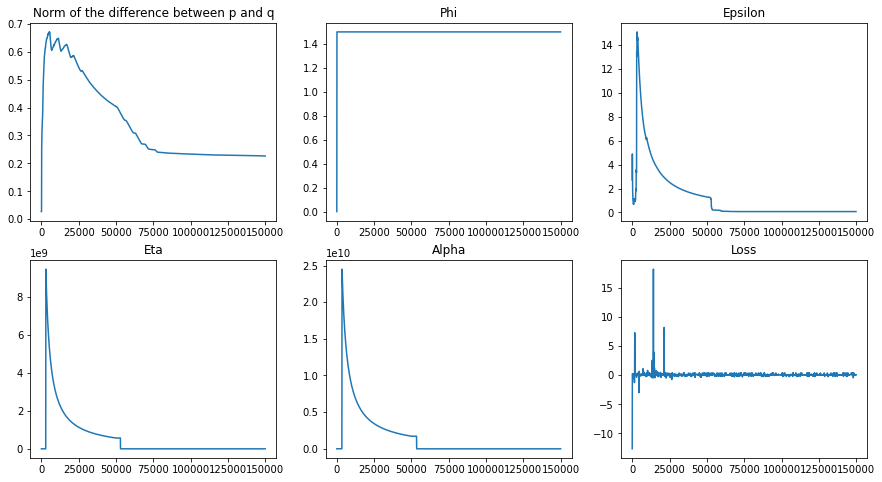

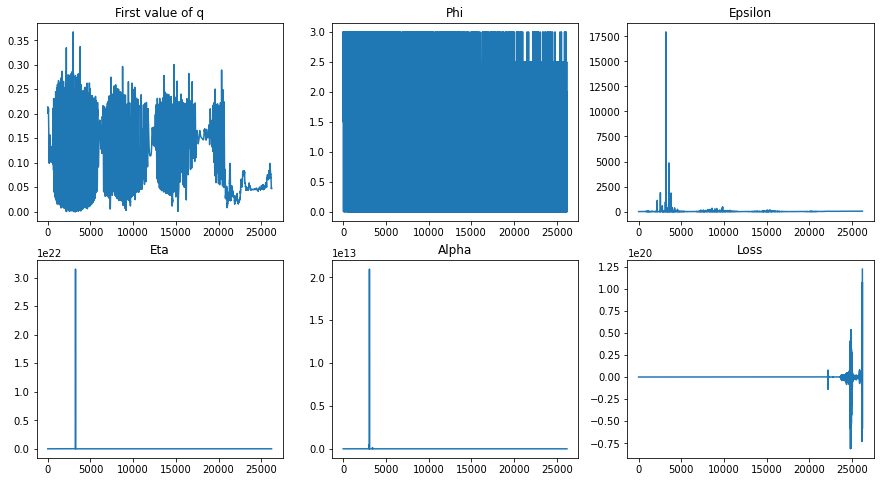


 


 	 EXP THRESHOLD 0.5 
 
 

epoch 0: 
 	 epsilon_=1.3139928579330444 and grad = 1.0 and lr = 0.0026664999999998166 
 	 eta_=9.999045372009277 and grad = -1.0 and lr = 0.0026664999999998166 
 	 alpha_=9.999045372009277 and grad = -0.09999489784240723 and lr = 0.0026664999999998166 
 	 s_=tensor([-1.5602, -1.7425, -2.2088, -3.3719, -2.4376, -3.4185, -2.3772, -2.5595,
        -3.9866, -6.2872, -4.1870, -6.3052, -3.1756, -4.3388, -4.1384, -6.4390,
        -5.4819, -6.6214, -3.4185, -4.3993, -4.3528, -6.4710, -5.4959, -6.6353],
       requires_grad=True)
 	 q2=tensor([0.2011, 0.1701, 0.1101, 0.0356, 0.0885, 0.0341, 0.0937, 0.0787, 0.0194,
        0.0020, 0.0159, 0.0019, 0.0432, 0.0137, 0.0167, 0.0017, 0.0044, 0.0014,
        0.0341, 0.0129, 0.0135, 0.0016, 0.0043, 0.0014],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 1.0000,  1.0000, -0.7760, -0.2602, -0.6300, -0.2488, -0.6659, -0.5629,
        -0.1429, -0.0145, -0.1173, -0.0143, -0.3144, -0.1010, -0.1231, -0.0125,
   

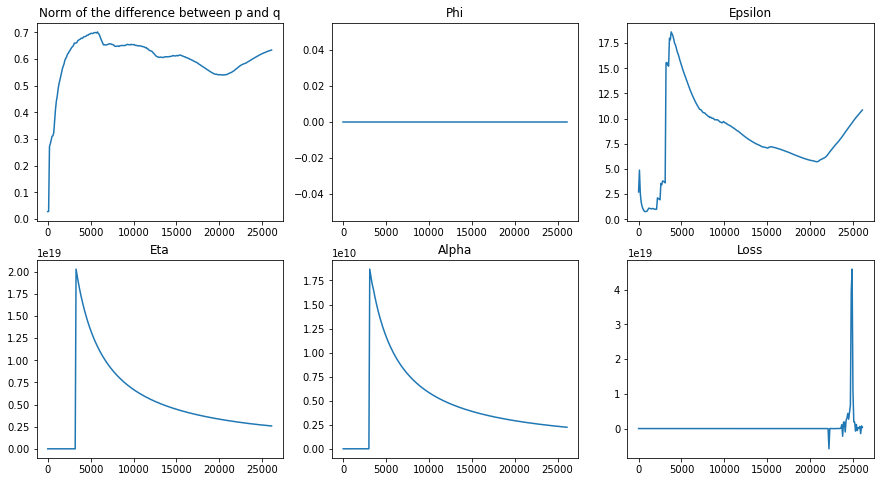

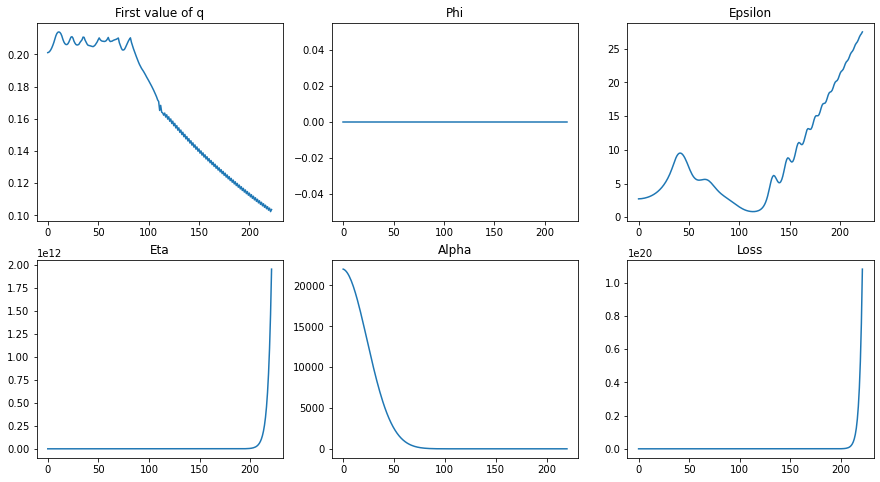

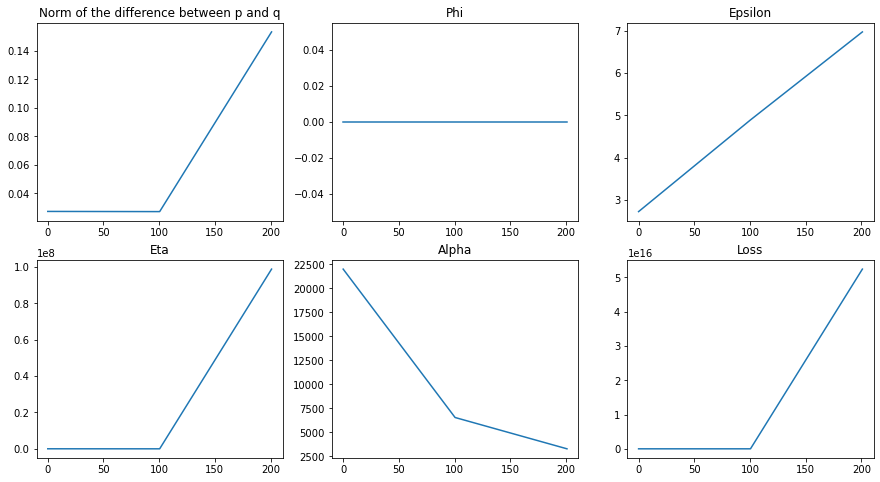

In [38]:
# Maxpair
dist = "maxpair"
perf_list_maxpair, eps_list_maxpair1, eps_list_maxpair2 = launch_exp(dist, w, delta, thresholds_, epochs)

perf_list = [1.4058440923690796, 2.451298713684082, 2.451298713684082, 2.451298713684082, 2.451298713684082, 2.6331167221069336, 3.440476179122925, 3.440476179122925, 3.7835497856140137, 5.0, 5.0] and eps_list1 = [0.4203777993775159, 1.176438456827253, 0.6772711100175232, 0.3935861525684595, 0.11070595979824663, 0.0638129639969021, 0.08681173767149448, 0.08390807083830237, 0.06927288258180023, 10.96401702850252, 8.704631596135451] and eps_list2 = [tensor(0.3057, dtype=torch.float64), tensor(0.5848, dtype=torch.float64), tensor(0.5032, dtype=torch.float64), tensor(0.3580, dtype=torch.float64), tensor(0.1702, dtype=torch.float64), tensor(0.2546, dtype=torch.float64), tensor(0.1905, dtype=torch.float64), tensor(0.1947, dtype=torch.float64), tensor(0.2265, dtype=torch.float64), tensor(0.6354, dtype=torch.float64), tensor(0.1878, dtype=torch.float64)]


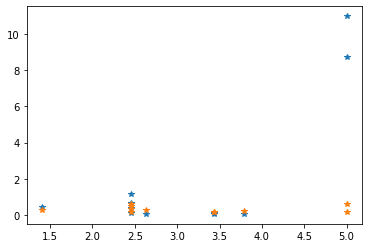

In [39]:
print(f"perf_list = {perf_list_maxpair} and eps_list1 = {eps_list_maxpair1} and eps_list2 = {eps_list_maxpair2}")
plt.plot(perf_list_maxpair, eps_list_maxpair1, '*')
plt.plot(perf_list_maxpair, eps_list_maxpair2, '*')
plt.show()


 	 EXP THRESHOLD 0.0 
 
 

epoch 0: 
 	 epsilon_=1.3205820322036743 and grad = 1.0 and lr = 0.011664999999999816 
 	 eta_=9.990045547485352 and grad = -1.0 and lr = 0.011664999999999816 
 	 alpha_=10.010045051574707 and grad = 1.0 and lr = 0.011664999999999816 
 	 s_=tensor([-1.5512, -1.7335, -2.2178, -3.3809, -2.4466, -3.4275, -2.3862, -2.5685,
        -3.9956, -6.2782, -4.1960, -6.2962, -3.1846, -4.3478, -4.1474, -6.4300,
        -5.4729, -6.6124, -3.4275, -4.4083, -4.3618, -6.4620, -5.4869, -6.6263],
       requires_grad=True)
 	 q2=tensor([0.2011, 0.1701, 0.1101, 0.0356, 0.0885, 0.0341, 0.0937, 0.0787, 0.0194,
        0.0020, 0.0159, 0.0019, 0.0432, 0.0137, 0.0167, 0.0017, 0.0044, 0.0014,
        0.0341, 0.0129, 0.0135, 0.0016, 0.0043, 0.0014],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 1.0000,  1.0000, -0.8038, -0.2600, -0.6841, -0.2524, -0.6721, -0.5356,
        -0.1357, -0.0145, -0.1148, -0.0142, -0.2992, -0.1009, -0.1209, -0.0124,
        -0.0318, -0.0103, 

epoch 12000: 
 	 epsilon_=0.06817614287137985 and grad = -0.026384152472019196 and lr = 0.010416250000000508 
 	 eta_=0.6707067489624023 and grad = -0.08253370225429535 and lr = 0.010416250000000508 
 	 alpha_=3.193096876144409 and grad = 0.0665937289595604 and lr = 0.010416250000000508 
 	 s_=tensor([ 2.1388,  2.1308,  1.6153, -0.2673,  1.1764, -0.3280,  1.2830,  0.9486,
        -1.0213, -1.2424, -1.2187, -1.2417, -0.0044, -1.2210, -1.1925, -1.2463,
        -1.2284, -1.2254, -0.3303, -1.2252, -1.2178, -1.2262, -1.2410, -1.2284],
       requires_grad=True)
 	 q2=tensor([0.1362, 0.1356, 0.1086, 0.0344, 0.0874, 0.0328, 0.0925, 0.0772, 0.0186,
        0.0153, 0.0157, 0.0154, 0.0418, 0.0156, 0.0160, 0.0153, 0.0155, 0.0156,
        0.0328, 0.0156, 0.0157, 0.0156, 0.0154, 0.0155],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 0.0172,  0.0132,  0.0138, -0.0236,  0.0232,  0.0094,  0.0215,  0.0205,
        -0.0134, -0.0120, -0.0130, -0.0131,  0.0133, -0.0129, -0.

epoch 22500: 
 	 epsilon_=0.014508760534226894 and grad = -0.013328682631254196 and lr = 0.32197937499999973 
 	 eta_=0.08919210731983185 and grad = -0.03069620579481125 and lr = 0.32197937499999973 
 	 alpha_=1.5070706605911255 and grad = 0.05363147705793381 and lr = 0.32197937499999973 
 	 s_=tensor([ 0.5259,  0.3222,  0.6057, -0.0038,  0.3352,  0.0099,  0.0142,  0.2583,
        -0.0138, -0.1229,  0.0314, -0.0995,  0.1385, -0.0293,  0.0301, -0.0871,
        -0.1296, -0.1649, -0.1055, -0.0292,  0.0152, -0.0845, -0.0542, -0.0666],
       requires_grad=True)
 	 q2=tensor([0.0584, 0.0508, 0.0609, 0.0400, 0.0506, 0.0402, 0.0400, 0.0478, 0.0395,
        0.0357, 0.0411, 0.0363, 0.0441, 0.0396, 0.0413, 0.0363, 0.0350, 0.0345,
        0.0370, 0.0394, 0.0412, 0.0364, 0.0372, 0.0368],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 6.0215e-03,  8.1739e-04,  4.2274e-03,  6.0367e-05,  3.0192e-03,
        -1.2414e-04,  2.4650e-03,  1.5822e-03, -2.7429e-03, -1.6518e-03,
        -1.30

epoch 33000: 
 	 epsilon_=0.06807409226894379 and grad = -0.036682337522506714 and lr = 0.16604171874999996 
 	 eta_=0.562059223651886 and grad = -0.0972152054309845 and lr = 0.16604171874999996 
 	 alpha_=2.7443926334381104 and grad = 0.08096943795681 and lr = 0.16604171874999996 
 	 s_=tensor([ 2.4308,  2.1852,  1.7768, -0.1847,  1.2241, -0.2021,  1.0503,  0.9480,
        -0.8768, -1.0011, -0.9747, -1.0387,  0.1109, -1.1625, -1.0132, -1.0410,
        -1.0688, -0.9837, -0.2275, -1.1584, -1.1063, -1.0158, -0.9945, -1.0568],
       requires_grad=True)
 	 q2=tensor([0.1462, 0.1309, 0.1103, 0.0347, 0.0834, 0.0334, 0.0761, 0.0723, 0.0195,
        0.0174, 0.0177, 0.0169, 0.0427, 0.0151, 0.0174, 0.0168, 0.0165, 0.0176,
        0.0336, 0.0148, 0.0156, 0.0171, 0.0174, 0.0165],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0307,  0.0280, -0.0284, -0.0164,  0.0271, -0.0156,  0.0217,  0.0256,
        -0.0103, -0.0093, -0.0091, -0.0085, -0.0168, -0.0078, -0.0088, -0.0092,
      

epoch 43500: 
 	 epsilon_=0.07553384453058243 and grad = -0.025657806545495987 and lr = 0.02952472656250002 
 	 eta_=0.7298344969749451 and grad = 0.09016671776771545 and lr = 0.02952472656250002 
 	 alpha_=2.806051254272461 and grad = -0.012152984738349915 and lr = 0.02952472656250002 
 	 s_=tensor([ 2.2174,  2.3774,  1.6513, -0.2767,  1.1762, -0.3250,  1.2282,  0.9345,
        -1.0290, -1.3271, -1.2431, -1.3532, -0.0057, -1.3189, -1.1860, -1.3377,
        -1.3096, -1.3537, -0.3386, -1.3479, -1.3336, -1.3334, -1.3038, -1.3037],
       requires_grad=True)
 	 q2=tensor([0.1402, 0.1493, 0.1099, 0.0340, 0.0873, 0.0328, 0.0898, 0.0766, 0.0185,
        0.0142, 0.0153, 0.0139, 0.0418, 0.0143, 0.0160, 0.0141, 0.0144, 0.0139,
        0.0325, 0.0139, 0.0142, 0.0141, 0.0145, 0.0145],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0273, -0.0029,  0.0364,  0.0189, -0.0036, -0.0265, -0.0057,  0.0303,
         0.0056, -0.0133, -0.0152, -0.0136,  0.0110, -0.0141, -0.0144, -0.0151,
 

epoch 54000: 
 	 epsilon_=0.10793787986040115 and grad = -0.02085728943347931 and lr = 0.010003251953125004 
 	 eta_=0.9122433066368103 and grad = 0.16380712389945984 and lr = 0.010003251953125004 
 	 alpha_=2.261870861053467 and grad = -0.07744328677654266 and lr = 0.010003251953125004 
 	 s_=tensor([ 2.4808,  2.3537,  1.6205, -0.2785,  1.1523, -0.3364,  1.2704,  0.9352,
        -1.0293, -1.4656, -1.2532, -1.4518, -0.0125, -1.4239, -1.2039, -1.4738,
        -1.4560, -1.4861, -0.3360, -1.4773, -1.4393, -1.4719, -1.4838, -1.4965],
       requires_grad=True)
 	 q2=tensor([0.1555, 0.1486, 0.1094, 0.0342, 0.0867, 0.0328, 0.0923, 0.0769, 0.0186,
        0.0127, 0.0152, 0.0129, 0.0417, 0.0132, 0.0159, 0.0126, 0.0128, 0.0124,
        0.0328, 0.0125, 0.0129, 0.0126, 0.0125, 0.0123],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 0.0308,  0.0117, -0.0026,  0.0012,  0.0064, -0.0419,  0.0260,  0.0396,
         0.0045, -0.0164, -0.0205, -0.0173,  0.0106, -0.0155,  0.

epoch 64500: 
 	 epsilon_=0.11346670240163803 and grad = -0.021294623613357544 and lr = 0.012437338867187498 
 	 eta_=0.922827422618866 and grad = -0.09699895977973938 and lr = 0.012437338867187498 
 	 alpha_=2.043454647064209 and grad = 0.08528365194797516 and lr = 0.012437338867187498 
 	 s_=tensor([ 2.3834,  2.4482,  1.6001, -0.2712,  1.1740, -0.3309,  1.2811,  0.9479,
        -1.0203, -1.4745, -1.2557, -1.4542, -0.0043, -1.4147, -1.1937, -1.4619,
        -1.4634, -1.4428, -0.3280, -1.4423, -1.4386, -1.4309, -1.4279, -1.4637],
       requires_grad=True)
 	 q2=tensor([0.1495, 0.1530, 0.1080, 0.0343, 0.0874, 0.0327, 0.0924, 0.0773, 0.0187,
        0.0125, 0.0152, 0.0127, 0.0418, 0.0132, 0.0160, 0.0126, 0.0126, 0.0129,
        0.0328, 0.0128, 0.0129, 0.0130, 0.0130, 0.0126],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 0.0374, -0.0033,  0.0069,  0.0172,  0.0074,  0.0096,  0.0238,  0.0387,
        -0.0233, -0.0146, -0.0164, -0.0157, -0.0326, -0.0169, -0.

epoch 75000: 
 	 epsilon_=0.11431065946817398 and grad = -0.02104322612285614 and lr = 0.011219075927734374 
 	 eta_=0.9276175498962402 and grad = -0.1765543520450592 and lr = 0.011219075927734374 
 	 alpha_=1.303135633468628 and grad = 0.1763841211795807 and lr = 0.011219075927734374 
 	 s_=tensor([ 2.1266e+00,  2.7524e+00,  1.6251e+00, -2.6239e-01,  1.1833e+00,
        -3.2386e-01,  1.2969e+00,  9.5209e-01, -1.0172e+00, -1.4395e+00,
        -1.2364e+00, -1.4866e+00,  9.3709e-05, -1.4119e+00, -1.1938e+00,
        -1.5202e+00, -1.5153e+00, -1.4702e+00, -3.2336e-01, -1.4714e+00,
        -1.4317e+00, -1.4888e+00, -1.4630e+00, -1.4715e+00],
       requires_grad=True)
 	 q2=tensor([0.1351, 0.1698, 0.1087, 0.0344, 0.0873, 0.0328, 0.0929, 0.0772, 0.0186,
        0.0128, 0.0154, 0.0123, 0.0418, 0.0131, 0.0160, 0.0119, 0.0119, 0.0125,
        0.0329, 0.0125, 0.0129, 0.0123, 0.0125, 0.0124],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0465,  0.0554,  0.0362, -0.0302,  0.023

epoch 85500: 
 	 epsilon_=0.11334048211574554 and grad = -0.021950289607048035 and lr = 0.010152536926269532 
 	 eta_=0.9167879223823547 and grad = -0.6302146911621094 and lr = 0.010152536926269532 
 	 alpha_=0.884781539440155 and grad = 0.6671596765518188 and lr = 0.010152536926269532 
 	 s_=tensor([ 2.5699,  2.4669,  1.6118, -0.2549,  1.1472, -0.3180,  1.2690,  0.9634,
        -1.0139, -1.4995, -1.2431, -1.4748, -0.0028, -1.4080, -1.1883, -1.4422,
        -1.5049, -1.4938, -0.3206, -1.4814, -1.4241, -1.5097, -1.5173, -1.5132],
       requires_grad=True)
 	 q2=tensor([0.1588, 0.1529, 0.1076, 0.0344, 0.0854, 0.0328, 0.0910, 0.0772, 0.0186,
        0.0121, 0.0152, 0.0124, 0.0415, 0.0131, 0.0160, 0.0128, 0.0120, 0.0122,
        0.0328, 0.0123, 0.0129, 0.0120, 0.0120, 0.0120],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-0.0156, -0.0062,  0.0208, -0.0332,  0.0601, -0.0139,  0.0347,  0.0186,
         0.0052, -0.0122,  0.0072, -0.0165,  0.0073, -0.0150, -0.0183, -0.0126,
 

epoch 97500: 
 	 epsilon_=0.5117807388305664 and grad = -0.0031186342239379883 and lr = 0.010038134231567382 
 	 eta_=1.6625888347625732 and grad = 1.0 and lr = 0.010038134231567382 
 	 alpha_=0.05620880797505379 and grad = -1.0 and lr = 0.010038134231567382 
 	 s_=tensor([ 1.3161,  1.3856,  1.1115, -0.5116,  0.7750, -0.5043,  0.9716,  0.6130,
        -1.0938, -1.2275, -1.4276, -1.4773, -0.2463, -1.3705, -1.3242, -1.0409,
        -1.2699, -1.2432, -0.5641, -1.3457, -1.2721, -1.3354, -0.9044, -1.0685],
       requires_grad=True)
 	 q2=tensor([0.1143, 0.1183, 0.1026, 0.0345, 0.0849, 0.0347, 0.0950, 0.0769, 0.0212,
        0.0189, 0.0158, 0.0151, 0.0425, 0.0167, 0.0173, 0.0222, 0.0182, 0.0186,
        0.0331, 0.0170, 0.0182, 0.0172, 0.0250, 0.0217],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-1.0000,  1.0000, -0.7196,  0.8238,  0.9985,  0.0779, -1.0000,  1.0000,
        -0.0992,  0.1168, -0.1967,  0.0468,  1.0000,  0.2296, -0.1712,  0.2610,
         0.1619,  0.3640,  0.

epoch 109500: 
 	 epsilon_=0.26493507623672485 and grad = -0.011450767517089844 and lr = 0.010009533557891847 
 	 eta_=1.2567564249038696 and grad = 1.0 and lr = 0.010009533557891847 
 	 alpha_=0.34980809688568115 and grad = -1.0 and lr = 0.010009533557891847 
 	 s_=tensor([ 1.7925,  1.6407,  1.4712, -0.3727,  1.0189, -0.4336,  1.1008,  0.8137,
        -1.1161, -1.2168, -1.2099, -1.3042, -0.1163, -1.3179, -1.1149, -1.0498,
        -1.2282, -1.1335, -0.4324, -1.2164, -1.2127, -1.0940, -1.1665, -1.1709],
       requires_grad=True)
 	 q2=tensor([0.1276, 0.1191, 0.1100, 0.0344, 0.0871, 0.0328, 0.0910, 0.0774, 0.0186,
        0.0170, 0.0171, 0.0158, 0.0418, 0.0156, 0.0186, 0.0197, 0.0168, 0.0183,
        0.0328, 0.0170, 0.0171, 0.0189, 0.0178, 0.0177],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 0.0529,  0.0360, -0.0291, -0.0502,  0.0833, -0.0072,  0.0313,  0.0754,
        -0.0190, -0.0306, -0.0206, -0.0232,  0.0331, -0.0233, -0.0303, -0.0264,
        -0.02

epoch 121500: 
 	 epsilon_=0.4407240152359009 and grad = -0.006219387054443359 and lr = 0.010002383389472961 
 	 eta_=1.5377975702285767 and grad = 1.0 and lr = 0.010002383389472961 
 	 alpha_=0.08680006116628647 and grad = -1.0 and lr = 0.010002383389472961 
 	 s_=tensor([ 2.0871,  1.2198,  1.3970, -0.2759,  0.8780, -0.3335,  1.1169,  0.9582,
        -0.7860, -0.9092, -1.2585, -0.9636,  0.0478, -1.0708, -1.1506, -0.6444,
        -0.7963, -0.8191, -0.3449, -1.0228, -1.1249, -0.9255, -0.9181, -0.2544],
       requires_grad=True)
 	 q2=tensor([0.1343, 0.0901, 0.0985, 0.0344, 0.0746, 0.0329, 0.0853, 0.0782, 0.0229,
        0.0206, 0.0152, 0.0197, 0.0438, 0.0180, 0.0167, 0.0257, 0.0227, 0.0223,
        0.0326, 0.0187, 0.0171, 0.0203, 0.0205, 0.0349],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 4.5384e-01,  1.0000e+00, -1.0000e+00, -4.6559e-01,  9.3434e-01,
        -4.2949e-01, -1.0000e+00,  1.0000e+00,  3.1336e-02,  6.6273e-02,
         7.4682e-02,  1.2838e-01, -1.0000e+

epoch 132000: 
 	 epsilon_=0.31809788942337036 and grad = -0.01236492395401001 and lr = 0.010000000396966935 
 	 eta_=1.3283216953277588 and grad = -1.0 and lr = 0.010000000396966935 
 	 alpha_=0.13613228499889374 and grad = 1.0 and lr = 0.010000000396966935 
 	 s_=tensor([ 1.4205,  1.4687,  1.5222, -0.3261,  1.1117, -0.3890,  1.1865,  0.8903,
        -1.0683, -1.1445, -1.1391, -1.1033, -0.0715, -1.1992, -0.9857, -0.9727,
        -1.0337, -0.5983, -0.3861, -1.2324, -1.2226, -1.0428, -0.8567, -0.5985],
       requires_grad=True)
 	 q2=tensor([0.1039, 0.1065, 0.1093, 0.0345, 0.0887, 0.0329, 0.0923, 0.0784, 0.0188,
        0.0176, 0.0176, 0.0182, 0.0418, 0.0167, 0.0202, 0.0204, 0.0194, 0.0278,
        0.0330, 0.0163, 0.0164, 0.0192, 0.0225, 0.0278],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 1.0000, -0.4393, -0.0211, -0.1461, -0.0329, -0.0491, -0.2647,  0.1688,
         0.0292, -0.0245, -0.0173, -0.0819,  0.1116,  0.0523, -0.0369, -0.0973,
        -0.1863,  0.0460, -0.

epoch 144000: 
 	 epsilon_=0.8958739638328552 and grad = 0.002805352210998535 and lr = 0.010000000099241733 
 	 eta_=2.4546186923980713 and grad = 1.0 and lr = 0.010000000099241733 
 	 alpha_=0.03266766667366028 and grad = -1.0 and lr = 0.010000000099241733 
 	 s_=tensor([ 1.3959,  1.3403,  1.3499, -0.2294,  0.7562, -0.1932,  1.2127,  0.7953,
        -0.7363, -0.8735, -1.0926, -0.8878,  0.0954, -0.7015, -0.7561, -0.8763,
        -0.8131, -0.5094, -0.3832, -0.9623, -0.9070, -0.7788, -0.6685, -0.7226],
       requires_grad=True)
 	 q2=tensor([0.0998, 0.0970, 0.0975, 0.0361, 0.0705, 0.0371, 0.0910, 0.0722, 0.0242,
        0.0215, 0.0178, 0.0213, 0.0457, 0.0249, 0.0238, 0.0214, 0.0227, 0.0291,
        0.0321, 0.0200, 0.0210, 0.0233, 0.0255, 0.0244],
       grad_fn=<DivBackward0>) and sum=1.000000238418579 and grad = tensor([ 0.0964,  1.0000,  1.0000, -0.9342, -1.0000, -1.0000, -1.0000, -1.0000,
        -0.9849, -0.8789,  0.2834, -1.0000,  1.0000, -1.0000, -1.0000,  1.0000,
        -1.0000,

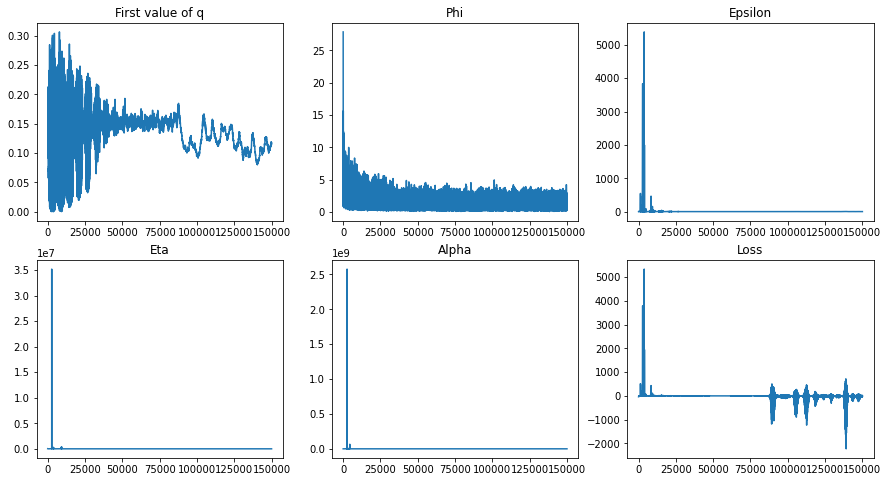


 


 	 EXP THRESHOLD 0.05 
 
 

epoch 0: 
 	 epsilon_=1.3205820322036743 and grad = 1.0 and lr = 0.011664999999999816 
 	 eta_=9.990045547485352 and grad = -1.0 and lr = 0.011664999999999816 
 	 alpha_=10.010045051574707 and grad = 1.0 and lr = 0.011664999999999816 
 	 s_=tensor([-1.5512, -1.7335, -2.2178, -3.3809, -2.4466, -3.4275, -2.3862, -2.5685,
        -3.9956, -6.2782, -4.1960, -6.2962, -3.1846, -4.3478, -4.1474, -6.4300,
        -5.4729, -6.6124, -3.4275, -4.4083, -4.3618, -6.4620, -5.4869, -6.6263],
       requires_grad=True)
 	 q2=tensor([0.2011, 0.1701, 0.1101, 0.0356, 0.0885, 0.0341, 0.0937, 0.0787, 0.0194,
        0.0020, 0.0159, 0.0019, 0.0432, 0.0137, 0.0167, 0.0017, 0.0044, 0.0014,
        0.0341, 0.0129, 0.0135, 0.0016, 0.0043, 0.0014],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 1.0000,  1.0000, -0.8664, -0.2724, -0.6874, -0.2398, -0.5851, -0.4985,
        -0.1221, -0.0142, -0.1158, -0.0139, -0.2883, -0.0984, -0.1168, -0.0123,
        -0.0314, -0.0

epoch 10500: 
 	 epsilon_=0.005652809981256723 and grad = -0.0042019677348434925 and lr = 1.257917499999999 
 	 eta_=0.010950164869427681 and grad = 0.002632507123053074 and lr = 1.257917499999999 
 	 alpha_=0.7626833319664001 and grad = 0.0032526878640055656 and lr = 1.257917499999999 
 	 s_=tensor([ 0.6518,  0.3707,  0.1823, -0.3271,  0.1758, -0.0264,  0.1686,  0.2488,
         0.0573, -0.0765,  0.0892, -0.0863, -0.1136,  0.0691,  0.0666, -0.0695,
         0.1062, -0.0906,  0.0545, -0.0650,  0.1732, -0.1168,  0.0658, -0.1182],
       requires_grad=True)
 	 q2=tensor([0.0606, 0.0485, 0.0425, 0.0308, 0.0429, 0.0393, 0.0429, 0.0471, 0.0411,
        0.0383, 0.0419, 0.0383, 0.0370, 0.0426, 0.0422, 0.0394, 0.0422, 0.0380,
        0.0424, 0.0389, 0.0455, 0.0381, 0.0417, 0.0377],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 6.2997e-06,  4.4854e-04,  2.5495e-04,  2.5755e-04,  1.5497e-04,
        -1.9725e-04,  4.6362e-04,  6.0794e-04,  7.6970e-05,  1.1990e-04,


epoch 21000: 
 	 epsilon_=0.01594715192914009 and grad = -0.013946915045380592 and lr = 0.6341668749999998 
 	 eta_=0.021766284480690956 and grad = -0.005038512870669365 and lr = 0.6341668749999998 
 	 alpha_=0.7987097501754761 and grad = 0.016495682299137115 and lr = 0.6341668749999998 
 	 s_=tensor([ 0.0716,  0.0111,  0.0472, -0.0317,  0.0366, -0.0582,  0.1048,  0.0725,
        -0.0005,  0.0284, -0.0363,  0.0085,  0.0561,  0.0454,  0.0424, -0.0180,
        -0.1033,  0.0447,  0.0074, -0.0118, -0.0453,  0.0216,  0.0469,  0.0500],
       requires_grad=True)
 	 q2=tensor([0.0424, 0.0408, 0.0423, 0.0405, 0.0419, 0.0398, 0.0444, 0.0433, 0.0417,
        0.0419, 0.0409, 0.0406, 0.0431, 0.0435, 0.0431, 0.0404, 0.0381, 0.0422,
        0.0419, 0.0418, 0.0404, 0.0409, 0.0420, 0.0421],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 8.8773e-04,  4.7878e-04,  1.1171e-03, -5.7696e-04,  9.5301e-04,
        -3.8650e-04,  1.2942e-03,  8.3208e-04, -4.9887e-04, -3.4822e-04,
        -8.445

epoch 31500: 
 	 epsilon_=0.10772735625505447 and grad = -0.03587400168180466 and lr = 0.08809890625000007 
 	 eta_=0.761631429195404 and grad = -0.3777291476726532 and lr = 0.08809890625000007 
 	 alpha_=2.0599019527435303 and grad = 0.2584860920906067 and lr = 0.08809890625000007 
 	 s_=tensor([ 2.6300,  2.6904,  1.3807, -0.2589,  0.8577, -0.3368,  1.2207,  0.9337,
        -1.0163, -1.3852, -1.2290, -1.3671,  0.0196, -1.3077, -1.1607, -1.3551,
        -1.3827, -1.3352, -0.3157, -1.4397, -1.3084, -1.3973, -1.3100, -1.3570],
       requires_grad=True)
 	 q2=tensor([0.1626, 0.1653, 0.0954, 0.0339, 0.0716, 0.0324, 0.0880, 0.0756, 0.0184,
        0.0133, 0.0152, 0.0138, 0.0413, 0.0140, 0.0163, 0.0139, 0.0136, 0.0141,
        0.0326, 0.0127, 0.0142, 0.0135, 0.0145, 0.0136],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0273, -0.0064,  0.0185,  0.0107,  0.0194,  0.0069,  0.0097,  0.0002,
         0.0044, -0.0144,  0.0041, -0.0162,  0.0180, -0.0162, -0.0191, -0.0154,
     

epoch 42000: 
 	 epsilon_=0.09670109301805496 and grad = -0.02348397672176361 and lr = 0.010013007812500016 
 	 eta_=0.8468092083930969 and grad = -0.11637598276138306 and lr = 0.010013007812500016 
 	 alpha_=2.2486813068389893 and grad = 0.09300272166728973 and lr = 0.010013007812500016 
 	 s_=tensor([ 2.4417,  2.4191,  1.6021, -0.2730,  1.1552, -0.3374,  1.2657,  0.9510,
        -1.0216, -1.4570, -1.2496, -1.4254, -0.0060, -1.4216, -1.1992, -1.4503,
        -1.4582, -1.4566, -0.3283, -1.4849, -1.4172, -1.4592, -1.4425, -1.4661],
       requires_grad=True)
 	 q2=tensor([0.1531, 0.1517, 0.1082, 0.0342, 0.0864, 0.0326, 0.0917, 0.0773, 0.0186,
        0.0127, 0.0152, 0.0130, 0.0418, 0.0131, 0.0159, 0.0128, 0.0127, 0.0127,
        0.0328, 0.0124, 0.0132, 0.0126, 0.0128, 0.0126],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0252,  0.0183,  0.0236,  0.0082,  0.0157,  0.0087,  0.0112,  0.0080,
        -0.0204, -0.0152, -0.0177, -0.0159,  0.0091, -0.0158,  0.0053, -0.0157,

epoch 52500: 
 	 epsilon_=0.09526980668306351 and grad = -0.021869271993637085 and lr = 0.019749355468749993 
 	 eta_=0.8622578382492065 and grad = 0.12344682216644287 and lr = 0.019749355468749993 
 	 alpha_=2.1671559810638428 and grad = -0.056194961071014404 and lr = 0.019749355468749993 
 	 s_=tensor([ 2.6622,  2.4118,  1.5102, -0.2784,  1.1608, -0.3377,  1.2506,  0.8908,
        -1.0247, -1.5720, -1.2614, -1.5591, -0.0349, -1.4308, -1.2050, -1.5469,
        -1.5628, -1.5669, -0.3429, -1.4575, -1.4318, -1.5721, -1.5826, -1.5489],
       requires_grad=True)
 	 q2=tensor([0.1663, 0.1527, 0.1046, 0.0344, 0.0872, 0.0328, 0.0916, 0.0755, 0.0187,
        0.0114, 0.0152, 0.0115, 0.0412, 0.0130, 0.0159, 0.0117, 0.0116, 0.0115,
        0.0328, 0.0128, 0.0131, 0.0114, 0.0113, 0.0117],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0579, -0.0425,  0.0420, -0.0398,  0.0363, -0.0175,  0.0067,  0.0109,
        -0.0170, -0.0136, -0.0134, -0.0113,  0.0298,  0.0037,  0.0062, -0.014

epoch 63000: 
 	 epsilon_=0.1307154893875122 and grad = -0.01751631498336792 and lr = 0.014876303710937499 
 	 eta_=0.9967268109321594 and grad = -0.010433614253997803 and lr = 0.014876303710937499 
 	 alpha_=1.1280757188796997 and grad = 0.02409154176712036 and lr = 0.014876303710937499 
 	 s_=tensor([ 2.8071e+00,  2.1955e+00,  1.6244e+00, -2.6482e-01,  1.1765e+00,
        -3.1702e-01,  1.3063e+00,  9.1283e-01, -1.0176e+00, -1.5257e+00,
        -1.2440e+00, -1.5428e+00,  1.7806e-03, -1.4142e+00, -1.1906e+00,
        -1.5066e+00, -1.5453e+00, -1.5657e+00, -3.2602e-01, -1.4716e+00,
        -1.3977e+00, -1.5376e+00, -1.5470e+00, -1.5135e+00],
       requires_grad=True)
 	 q2=tensor([0.1726, 0.1387, 0.1091, 0.0343, 0.0871, 0.0329, 0.0930, 0.0753, 0.0186,
        0.0118, 0.0153, 0.0117, 0.0419, 0.0131, 0.0160, 0.0120, 0.0116, 0.0114,
        0.0327, 0.0125, 0.0133, 0.0117, 0.0116, 0.0119],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 0.0292,  0.0905, -0.021

epoch 73500: 
 	 epsilon_=1.149668574333191 and grad = 0.005658149719238281 and lr = 0.010610147705078126 
 	 eta_=3.164515972137451 and grad = 1.0 and lr = 0.010610147705078126 
 	 alpha_=0.012141525745391846 and grad = -1.0 and lr = 0.010610147705078126 
 	 s_=tensor([ 1.9125,  1.9629,  1.3088, -0.4097,  0.6732, -0.5057,  0.9334,  0.6780,
        -1.0203, -1.6782, -1.2156, -1.6198, -0.2342, -1.3668, -1.1693, -1.4332,
        -1.6606, -1.7246, -0.2722, -1.3341, -1.3240, -1.5223, -1.5899, -1.5314],
       requires_grad=True)
 	 q2=tensor([0.1437, 0.1467, 0.1084, 0.0357, 0.0760, 0.0331, 0.0886, 0.0762, 0.0215,
        0.0120, 0.0182, 0.0127, 0.0408, 0.0159, 0.0189, 0.0150, 0.0122, 0.0115,
        0.0396, 0.0164, 0.0165, 0.0138, 0.0130, 0.0137],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 1., -1., -1.,  1.,  1., -1., -1., -1.,  1., -1., -1., -1.,  1., -1.,
        -1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.]) and lr = 0.010610147705078126 
 	 phi = 

epoch 85500: 
 	 epsilon_=0.29826751351356506 and grad = -0.012012630701065063 and lr = 0.010152536926269532 
 	 eta_=1.2999736070632935 and grad = 1.0 and lr = 0.010152536926269532 
 	 alpha_=0.10425978899002075 and grad = -1.0 and lr = 0.010152536926269532 
 	 s_=tensor([ 1.5833,  1.2907,  1.4218, -0.4046,  0.9743, -0.4657,  1.0716,  0.7101,
        -1.0564, -0.9700, -1.3526, -1.2281, -0.1747, -1.1731, -1.0549, -0.8765,
        -0.9670, -0.8340, -0.4670, -1.3857, -1.3559, -1.1224, -1.1308, -0.9120],
       requires_grad=True)
 	 q2=tensor([0.1191, 0.1032, 0.1102, 0.0344, 0.0870, 0.0328, 0.0919, 0.0747, 0.0201,
        0.0216, 0.0155, 0.0173, 0.0410, 0.0181, 0.0201, 0.0234, 0.0217, 0.0243,
        0.0327, 0.0150, 0.0154, 0.0189, 0.0188, 0.0227],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-1.0000, -1.0000,  0.5853,  0.5282,  1.0000,  0.2638,  1.0000,  0.2822,
         0.0905, -0.0291,  0.0400,  0.0728,  0.1751,  0.2619, -0.1308,  0.3068,
         0.1824,  0.1047,  0.

epoch 97500: 
 	 epsilon_=0.48765993118286133 and grad = -0.005086183547973633 and lr = 0.010038134231567382 
 	 eta_=1.6110258102416992 and grad = -1.0 and lr = 0.010038134231567382 
 	 alpha_=0.06009175628423691 and grad = 1.0 and lr = 0.010038134231567382 
 	 s_=tensor([ 0.9781,  1.3613,  1.0316, -0.4966,  0.6011, -0.6265,  0.7508,  0.4731,
        -1.1160, -0.8974, -1.4558, -1.2264, -0.3328, -1.3420, -1.2701, -0.6791,
        -0.8647, -0.9392, -0.6401, -1.2427, -1.6491, -1.4842, -1.1157, -1.1686],
       requires_grad=True)
 	 q2=tensor([0.0992, 0.1215, 0.1022, 0.0363, 0.0794, 0.0327, 0.0870, 0.0732, 0.0217,
        0.0261, 0.0160, 0.0197, 0.0414, 0.0178, 0.0190, 0.0314, 0.0269, 0.0252,
        0.0324, 0.0194, 0.0135, 0.0156, 0.0217, 0.0207],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([-0.5248,  1.0000, -1.0000,  0.6952, -0.1564, -0.1240, -1.0000,  1.0000,
         0.2522,  0.4579,  0.0067, -0.0857, -0.8659,  0.0840, -0.0588, -0.1682,
         0.154

epoch 109500: 
 	 epsilon_=0.2889368236064911 and grad = -0.010733425617218018 and lr = 0.010009533557891847 
 	 eta_=1.2926815748214722 and grad = 1.0 and lr = 0.010009533557891847 
 	 alpha_=0.11875717341899872 and grad = -1.0 and lr = 0.010009533557891847 
 	 s_=tensor([ 1.3169,  1.0894,  1.3948, -0.3798,  0.9775, -0.4376,  1.0055,  0.6880,
        -0.9481, -1.0004, -1.2745, -1.1918,  0.1056, -0.9922, -0.9339, -0.6494,
        -0.7672, -0.6179, -0.4021, -1.3014, -1.1135, -0.9881, -0.9309, -0.6110],
       requires_grad=True)
 	 q2=tensor([0.1024, 0.0909, 0.1066, 0.0343, 0.0854, 0.0328, 0.0869, 0.0721, 0.0216,
        0.0206, 0.0162, 0.0175, 0.0492, 0.0208, 0.0218, 0.0277, 0.0251, 0.0284,
        0.0338, 0.0159, 0.0187, 0.0209, 0.0219, 0.0286],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.1946,  0.1680,  0.1343, -0.1788,  0.1617, -0.0651,  0.0692, -0.1244,
        -0.1525, -0.0591, -0.0125, -0.0818, -0.0247, -0.0009, -0.0016, -0.0084,
        -0.0521, -0.1825,  0.

epoch 121500: 
 	 epsilon_=0.328197181224823 and grad = -0.012462854385375977 and lr = 0.010002383389472961 
 	 eta_=1.3416118621826172 and grad = -1.0 and lr = 0.010002383389472961 
 	 alpha_=0.09276887029409409 and grad = 1.0 and lr = 0.010002383389472961 
 	 s_=tensor([ 1.5712,  0.8538,  1.4667, -0.3781,  0.8757, -0.4557,  1.0683,  0.7197,
        -0.9996, -0.9197, -1.2413, -1.2399, -0.1286, -1.1595, -1.0762, -0.6089,
        -0.6126, -0.7252, -0.4322, -1.1589, -1.2166, -1.0808, -0.7502, -0.6783],
       requires_grad=True)
 	 q2=tensor([0.1165, 0.0801, 0.1109, 0.0346, 0.0811, 0.0325, 0.0903, 0.0739, 0.0208,
        0.0222, 0.0168, 0.0168, 0.0418, 0.0181, 0.0194, 0.0288, 0.0286, 0.0262,
        0.0331, 0.0181, 0.0172, 0.0194, 0.0256, 0.0272],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 0.9203,  0.0584, -0.4362,  0.2450, -0.5961,  0.0102, -0.0541,  0.3451,
        -0.1193,  0.0968, -0.0329,  0.0144, -0.2217,  0.0427,  0.0221,  0.0861,
        -0.0091

epoch 133500: 
 	 epsilon_=0.49869707226753235 and grad = -0.00048214197158813477 and lr = 0.01000059584736824 
 	 eta_=1.6475754976272583 and grad = 1.0 and lr = 0.01000059584736824 
 	 alpha_=0.05759160593152046 and grad = -1.0 and lr = 0.01000059584736824 
 	 s_=tensor([ 1.6619,  0.5998,  1.3856, -0.3942,  0.7275, -0.4427,  0.9484,  0.7457,
        -1.0514, -0.8958, -1.1859, -1.1711, -0.1131, -0.9912, -0.8934, -0.8813,
        -0.7238, -0.6142, -0.4649, -1.1919, -1.1677, -0.9962, -1.1178, -0.8775],
       requires_grad=True)
 	 q2=tensor([0.1253, 0.0708, 0.1099, 0.0352, 0.0767, 0.0339, 0.0870, 0.0774, 0.0205,
        0.0234, 0.0182, 0.0184, 0.0436, 0.0216, 0.0234, 0.0237, 0.0270, 0.0295,
        0.0333, 0.0181, 0.0185, 0.0214, 0.0193, 0.0237],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 1.0000,  1.0000, -1.0000, -0.0329, -0.8623,  0.1093,  0.7759, -0.5157,
        -0.1229, -0.0019, -0.1021,  0.0324,  0.3215,  0.2399,  0.0564, -0.6320,
        -0.477

epoch 145500: 
 	 epsilon_=0.12291774898767471 and grad = -0.019642159342765808 and lr = 0.01000014896184206 
 	 eta_=0.960822582244873 and grad = 0.06253623962402344 and lr = 0.01000014896184206 
 	 alpha_=0.2672168016433716 and grad = 0.19164800643920898 and lr = 0.01000014896184206 
 	 s_=tensor([ 1.7290,  0.6450,  1.0976, -0.3744,  0.9642, -0.4308,  0.9892,  0.7093,
        -0.9278, -0.9762, -1.3141, -0.8792, -0.1091, -0.9644, -0.8849, -0.4547,
        -0.6671, -0.1049, -0.4303, -1.3062, -1.2946, -0.9662, -0.7689, -0.6584],
       requires_grad=True)
 	 q2=tensor([0.1239, 0.0699, 0.0907, 0.0343, 0.0843, 0.0328, 0.0855, 0.0727, 0.0218,
        0.0209, 0.0156, 0.0227, 0.0419, 0.0212, 0.0226, 0.0322, 0.0271, 0.0421,
        0.0328, 0.0157, 0.0159, 0.0211, 0.0249, 0.0273],
       grad_fn=<DivBackward0>) and sum=0.9999998807907104 and grad = tensor([ 0.0967,  0.0849, -0.0604, -0.0158, -0.0266, -0.0928,  0.2328,  0.0628,
        -0.0584, -0.0541, -0.0444, -0.0324, -0.0455, -0.0173, -0.03

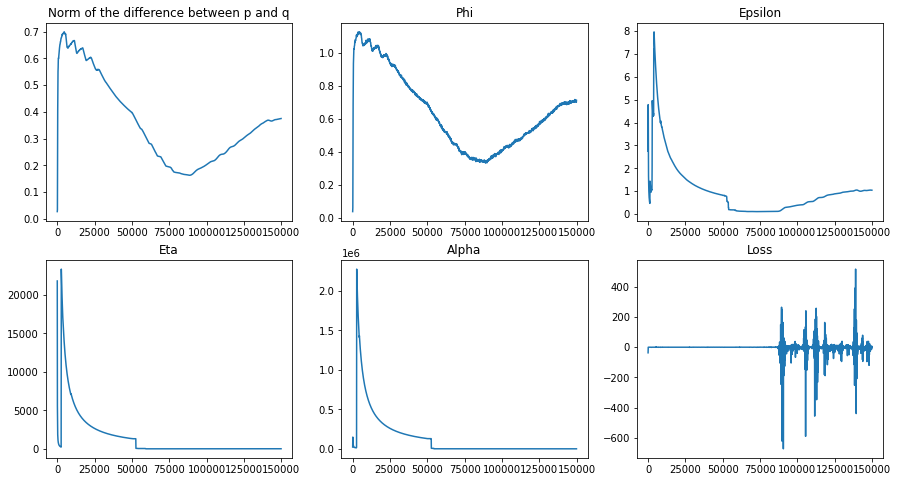

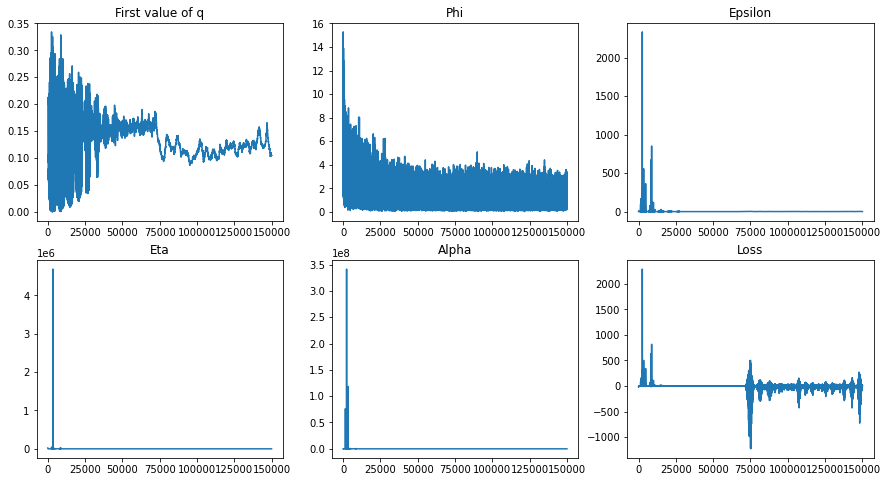


 


 	 EXP THRESHOLD 0.1 
 
 

epoch 0: 
 	 epsilon_=1.3205820322036743 and grad = 1.0 and lr = 0.011664999999999816 
 	 eta_=9.990045547485352 and grad = -1.0 and lr = 0.011664999999999816 
 	 alpha_=10.010045051574707 and grad = 1.0 and lr = 0.011664999999999816 
 	 s_=tensor([-1.5512, -1.7335, -2.2178, -3.3809, -2.4466, -3.4275, -2.3862, -2.5685,
        -3.9956, -6.2782, -4.1960, -6.2962, -3.1846, -4.3478, -4.1474, -6.4300,
        -5.4729, -6.6124, -3.4275, -4.4083, -4.3618, -6.4620, -5.4869, -6.6263],
       requires_grad=True)
 	 q2=tensor([0.2011, 0.1701, 0.1101, 0.0356, 0.0885, 0.0341, 0.0937, 0.0787, 0.0194,
        0.0020, 0.0159, 0.0019, 0.0432, 0.0137, 0.0167, 0.0017, 0.0044, 0.0014,
        0.0341, 0.0129, 0.0135, 0.0016, 0.0043, 0.0014],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 1.0000,  1.0000, -0.7518, -0.2529, -0.5218, -0.2225, -0.7357, -0.5959,
        -0.1360, -0.0140, -0.1059, -0.0138, -0.2857, -0.0963, -0.1231, -0.0121,
        -0.0314, -0.01

epoch 10500: 
 	 epsilon_=0.06475242227315903 and grad = -0.05992700159549713 and lr = 1.257917499999999 
 	 eta_=0.26192596554756165 and grad = -0.4496939182281494 and lr = 1.257917499999999 
 	 alpha_=1.239304780960083 and grad = 0.424940824508667 and lr = 1.257917499999999 
 	 s_=tensor([ 1.8081,  1.8935,  0.6984, -0.1258,  1.0421, -0.5920,  0.8558,  0.8057,
        -0.5608, -0.6031, -0.7543, -0.8284,  0.0768, -0.5790, -0.5427, -0.6621,
        -0.3568, -0.7749, -0.3120, -0.7209, -0.5441, -0.5499, -0.5557, -0.6681],
       requires_grad=True)
 	 q2=tensor([0.1230, 0.1228, 0.0645, 0.0347, 0.0769, 0.0210, 0.0715, 0.0691, 0.0259,
        0.0257, 0.0205, 0.0204, 0.0417, 0.0257, 0.0240, 0.0260, 0.0321, 0.0228,
        0.0306, 0.0197, 0.0240, 0.0263, 0.0279, 0.0231],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 0.0160,  0.0219,  0.0083, -0.0131, -0.0009,  0.0062, -0.0011,  0.0081,
        -0.0054, -0.0083, -0.0069, -0.0054,  0.0068, -0.0081, -0.0081, -0.00

epoch 21000: 
 	 epsilon_=0.03861203044652939 and grad = -0.03272131457924843 and lr = 0.6341668749999998 
 	 eta_=0.1456667184829712 and grad = 0.057261671870946884 and lr = 0.6341668749999998 
 	 alpha_=2.239481210708618 and grad = 0.020538363605737686 and lr = 0.6341668749999998 
 	 s_=tensor([ 0.2176,  0.2629,  0.2039, -0.1703,  0.3224, -0.1558,  0.2972,  0.3211,
        -0.0971, -0.1850, -0.1115, -0.1399, -0.0097, -0.2216, -0.1156,  0.0335,
        -0.2123, -0.1771, -0.1235, -0.1737, -0.0840, -0.1487, -0.3640, -0.2160],
       requires_grad=True)
 	 q2=tensor([0.0480, 0.0499, 0.0481, 0.0380, 0.0526, 0.0384, 0.0518, 0.0523, 0.0404,
        0.0368, 0.0397, 0.0379, 0.0421, 0.0373, 0.0396, 0.0463, 0.0361, 0.0383,
        0.0392, 0.0383, 0.0408, 0.0381, 0.0328, 0.0374],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0059,  0.0059,  0.0075, -0.0018,  0.0053, -0.0017,  0.0065,  0.0055,
        -0.0006, -0.0027, -0.0021, -0.0030, -0.0019, -0.0035, -0.0029, -0.0010,
     

epoch 31500: 
 	 epsilon_=0.07792633771896362 and grad = -0.03404795005917549 and lr = 0.08809890625000007 
 	 eta_=0.6576639413833618 and grad = 0.1161675825715065 and lr = 0.08809890625000007 
 	 alpha_=2.1103389263153076 and grad = -0.025869399309158325 and lr = 0.08809890625000007 
 	 s_=tensor([ 2.4748,  2.4135,  1.5812, -0.2297,  0.8848, -0.2641,  1.3349,  0.9833,
        -0.9871, -1.1828, -1.1826, -1.1401,  0.0325, -1.3084, -1.1503, -1.1400,
        -1.1597, -1.1982, -0.2828, -1.2661, -1.2936, -1.1402, -1.1734, -1.0895],
       requires_grad=True)
 	 q2=tensor([0.1509, 0.1464, 0.1028, 0.0345, 0.0713, 0.0330, 0.0907, 0.0758, 0.0187,
        0.0155, 0.0156, 0.0160, 0.0419, 0.0138, 0.0160, 0.0160, 0.0157, 0.0154,
        0.0328, 0.0144, 0.0139, 0.0161, 0.0159, 0.0167],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0288,  0.0266,  0.0147, -0.0230,  0.0239, -0.0212,  0.0192,  0.0137,
        -0.0132, -0.0127, -0.0116, -0.0121, -0.0252, -0.0110,  0.0061, -0.0117,
  

epoch 42000: 
 	 epsilon_=0.10004707425832748 and grad = -0.02129548043012619 and lr = 0.010013007812500016 
 	 eta_=0.8826124668121338 and grad = 0.1282484382390976 and lr = 0.010013007812500016 
 	 alpha_=2.2262353897094727 and grad = -0.05378108471632004 and lr = 0.010013007812500016 
 	 s_=tensor([ 2.3908,  2.4188,  1.6357, -0.2738,  1.1689, -0.3342,  1.2873,  0.9423,
        -1.0274, -1.4750, -1.2547, -1.4684, -0.0079, -1.4210, -1.1985, -1.4784,
        -1.4672, -1.4691, -0.3322, -1.4510, -1.4361, -1.4879, -1.4738, -1.4687],
       requires_grad=True)
 	 q2=tensor([0.1503, 0.1520, 0.1099, 0.0343, 0.0873, 0.0328, 0.0930, 0.0771, 0.0186,
        0.0125, 0.0152, 0.0126, 0.0418, 0.0131, 0.0160, 0.0125, 0.0126, 0.0126,
        0.0328, 0.0128, 0.0129, 0.0124, 0.0125, 0.0126],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 0.0545, -0.0029,  0.0178,  0.0169,  0.0281,  0.0123, -0.0478,  0.0077,
        -0.0209, -0.0150, -0.0137, -0.0148,  0.0183, -0.0146, -0.

epoch 52500: 
 	 epsilon_=0.10514119267463684 and grad = -0.02141382545232773 and lr = 0.019749355468749993 
 	 eta_=0.8991830945014954 and grad = 0.07580703496932983 and lr = 0.019749355468749993 
 	 alpha_=1.9569921493530273 and grad = -0.03073984384536743 and lr = 0.019749355468749993 
 	 s_=tensor([ 2.4420,  2.5263,  1.6109, -0.2879,  1.1695, -0.3360,  1.2511,  0.9320,
        -1.0285, -1.5344, -1.2501, -1.5211, -0.0095, -1.4266, -1.1974, -1.5158,
        -1.5200, -1.5259, -0.3383, -1.4800, -1.4244, -1.5226, -1.5392, -1.5345],
       requires_grad=True)
 	 q2=tensor([0.1536, 0.1579, 0.1088, 0.0340, 0.0874, 0.0327, 0.0912, 0.0766, 0.0186,
        0.0118, 0.0153, 0.0119, 0.0418, 0.0131, 0.0160, 0.0120, 0.0119, 0.0119,
        0.0327, 0.0124, 0.0130, 0.0119, 0.0117, 0.0118],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 0.0273,  0.0111,  0.0398,  0.0032,  0.0161,  0.0106,  0.0106,  0.0194,
         0.0032, -0.0155, -0.0208, -0.0161, -0.0484, -0.0179, -0

epoch 63000: 
 	 epsilon_=0.15660567581653595 and grad = -0.01862625777721405 and lr = 0.014876303710937499 
 	 eta_=1.0390057563781738 and grad = -0.6693534851074219 and lr = 0.014876303710937499 
 	 alpha_=1.140549898147583 and grad = 0.6351412534713745 and lr = 0.014876303710937499 
 	 s_=tensor([ 2.5591,  2.5324,  1.5978, -0.2942,  1.1606, -0.3383,  1.2085,  0.9221,
        -1.0314, -1.5933, -1.2632, -1.6157, -0.0186, -1.4245, -1.2113, -1.6009,
        -1.6190, -1.6380, -0.3427, -1.4814, -1.4388, -1.5695, -1.5903, -1.6373],
       requires_grad=True)
 	 q2=tensor([0.1602, 0.1588, 0.1084, 0.0340, 0.0873, 0.0328, 0.0897, 0.0767, 0.0186,
        0.0113, 0.0152, 0.0110, 0.0417, 0.0132, 0.0159, 0.0112, 0.0110, 0.0109,
        0.0328, 0.0125, 0.0130, 0.0116, 0.0113, 0.0108],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([-0.0168,  0.1002,  0.0562, -0.0002, -0.0169, -0.0125,  0.0397, -0.0285,
        -0.0223, -0.0205, -0.0302, -0.0166,  0.0388, -0.0229, -0.00

epoch 73500: 
 	 epsilon_=0.3777254819869995 and grad = -0.004671454429626465 and lr = 0.010610147705078126 
 	 eta_=1.445225477218628 and grad = -0.9087743759155273 and lr = 0.010610147705078126 
 	 alpha_=0.07283327728509903 and grad = 1.0 and lr = 0.010610147705078126 
 	 s_=tensor([ 1.6480,  1.4279,  1.3171, -0.4673,  0.8773, -0.5543,  1.0205,  0.6191,
        -1.1846, -1.3551, -1.3743, -1.3032, -0.2107, -1.1415, -1.0901, -1.3979,
        -1.2023, -1.1916, -0.5047, -1.1507, -1.3819, -1.3107, -1.3110, -1.1440],
       requires_grad=True)
 	 q2=tensor([0.1289, 0.1160, 0.1098, 0.0343, 0.0866, 0.0321, 0.0937, 0.0740, 0.0188,
        0.0162, 0.0159, 0.0170, 0.0418, 0.0195, 0.0204, 0.0156, 0.0186, 0.0187,
        0.0334, 0.0194, 0.0158, 0.0169, 0.0169, 0.0195],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-0.4371,  1.0000, -1.0000,  0.1423, -1.0000, -0.3540,  0.3890,  1.0000,
         0.1027,  0.4731,  0.0429, -0.0965,  1.0000,  0.2368,  0.4909,  0.1277,
         0.1747,

epoch 85500: 
 	 epsilon_=0.9001830816268921 and grad = 0.006601452827453613 and lr = 0.010152536926269532 
 	 eta_=2.4711458683013916 and grad = 1.0 and lr = 0.010152536926269532 
 	 alpha_=0.022311925888061523 and grad = -1.0 and lr = 0.010152536926269532 
 	 s_=tensor([ 1.6850,  1.1260,  1.1330, -0.5552,  0.6635, -0.6288,  0.8366,  0.5395,
        -1.1194, -1.3138, -1.4930, -1.5667, -0.1968, -1.4628, -1.3091, -1.2635,
        -1.1511, -1.0595, -0.6457, -1.6778, -1.5379, -1.6744, -1.3313, -1.0357],
       requires_grad=True)
 	 q2=tensor([0.1415, 0.1074, 0.1076, 0.0346, 0.0823, 0.0326, 0.0913, 0.0762, 0.0216,
        0.0182, 0.0155, 0.0145, 0.0458, 0.0159, 0.0182, 0.0190, 0.0210, 0.0227,
        0.0322, 0.0131, 0.0148, 0.0131, 0.0179, 0.0232],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 1.0000, -1.0000,  1.0000,  1.0000,  1.0000, -1.0000, -1.0000,  1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,  1.0000,  1.0000, -1.0000,
        -1.0000

epoch 96000: 
 	 epsilon_=0.7671306729316711 and grad = -0.0005862712860107422 and lr = 0.01000002540588379 
 	 eta_=2.152275323867798 and grad = -1.0 and lr = 0.01000002540588379 
 	 alpha_=0.04758130759000778 and grad = 1.0 and lr = 0.01000002540588379 
 	 s_=tensor([ 1.9800,  1.1118,  1.4961, -0.3740,  1.0095, -0.4329,  1.0161,  0.8241,
        -1.0320, -1.0801, -1.2781, -1.1830, -0.1213, -1.1341, -1.1577, -1.0153,
        -0.8285, -0.8491, -0.4170, -1.2754, -1.3605, -1.1459, -1.1452, -0.9388],
       requires_grad=True)
 	 q2=tensor([0.1386, 0.0915, 0.1113, 0.0343, 0.0866, 0.0328, 0.0869, 0.0778, 0.0200,
        0.0192, 0.0161, 0.0175, 0.0416, 0.0183, 0.0179, 0.0202, 0.0237, 0.0234,
        0.0332, 0.0162, 0.0150, 0.0181, 0.0181, 0.0217],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-1.0000,  0.9582,  1.0000,  0.3377,  0.6463, -1.0000, -0.6799, -1.0000,
        -0.7590, -0.8715, -0.3038, -0.0881,  0.6576, -0.8613,  0.1549,  0.3741,
        -0.2829, -0.4245, -1.0000

epoch 108000: 
 	 epsilon_=0.4818287193775177 and grad = -0.004246115684509277 and lr = 0.010000006351470947 
 	 eta_=1.6068090200424194 and grad = 1.0 and lr = 0.010000006351470947 
 	 alpha_=0.06193070858716965 and grad = -1.0 and lr = 0.010000006351470947 
 	 s_=tensor([ 1.2426,  0.9824,  1.2443, -0.2477,  0.8104, -0.3880,  0.9228,  0.4668,
        -0.8495, -0.7061, -0.8330, -0.9365, -0.1147, -0.8724, -0.6784, -0.5938,
        -0.6474, -0.4405, -0.3112, -0.9444, -1.0829, -0.7258, -0.7003, -0.1641],
       requires_grad=True)
 	 q2=tensor([0.0962, 0.0835, 0.0962, 0.0370, 0.0757, 0.0333, 0.0808, 0.0613, 0.0229,
        0.0258, 0.0232, 0.0212, 0.0409, 0.0224, 0.0264, 0.0282, 0.0271, 0.0320,
        0.0353, 0.0211, 0.0187, 0.0254, 0.0259, 0.0394],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 1.0000, -0.9464, -1.0000,  1.0000, -0.5734, -0.5927,  1.0000, -1.0000,
         0.0943,  0.0555, -0.3221,  0.4350,  0.1798, -0.0250, -0.6441,  0.6422,
         0.4686, -0.2286,  0.

epoch 120000: 
 	 epsilon_=0.8871237635612488 and grad = 0.0006983280181884766 and lr = 0.010000001587867737 
 	 eta_=2.4316892623901367 and grad = 1.0 and lr = 0.010000001587867737 
 	 alpha_=0.028146564960479736 and grad = -1.0 and lr = 0.010000001587867737 
 	 s_=tensor([ 1.3569,  1.3911,  1.1772, -0.3542,  1.0414, -0.4517,  0.9437,  0.7198,
        -1.0777, -0.9755, -1.3605, -1.2914, -0.0836, -0.6952, -1.2599, -1.1263,
        -0.6437, -0.7944, -0.4240, -1.3927, -1.4202, -0.9867, -1.1658, -0.8533],
       requires_grad=True)
 	 q2=tensor([0.1076, 0.1093, 0.0981, 0.0361, 0.0910, 0.0334, 0.0862, 0.0756, 0.0198,
        0.0217, 0.0155, 0.0165, 0.0442, 0.0275, 0.0169, 0.0190, 0.0286, 0.0253,
        0.0342, 0.0151, 0.0147, 0.0215, 0.0184, 0.0240],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([-1.,  1., -1., -1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1., -1.,
        -1.,  1., -1., -1., -1., -1., -1.,  1., -1.,  1.]) and lr = 0.010000001587867737 
 	 ph

epoch 132000: 
 	 epsilon_=0.40174004435539246 and grad = -0.008339136838912964 and lr = 0.010000000396966935 
 	 eta_=1.4676092863082886 and grad = -1.0 and lr = 0.010000000396966935 
 	 alpha_=0.08280159533023834 and grad = 1.0 and lr = 0.010000000396966935 
 	 s_=tensor([ 1.5265,  0.9400,  1.5436, -0.1881,  0.8765, -0.3280,  1.2904,  0.7884,
        -0.8738, -0.7332, -1.2049, -0.9366, -0.0277, -0.8752, -0.8105, -0.4029,
        -0.6582, -0.3454, -0.3204, -1.1869, -0.9262, -1.0403, -0.6966, -0.6303],
       requires_grad=True)
 	 q2=tensor([0.1060, 0.0781, 0.1068, 0.0371, 0.0752, 0.0333, 0.0942, 0.0714, 0.0214,
        0.0241, 0.0161, 0.0203, 0.0418, 0.0214, 0.0226, 0.0315, 0.0256, 0.0329,
        0.0335, 0.0164, 0.0205, 0.0186, 0.0248, 0.0262],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-0.7723,  0.0812,  0.3543,  0.0821, -0.4063, -0.0541, -0.7768,  0.7071,
         0.1870,  0.0061,  0.1029,  0.0381,  0.6400,  0.0841, -0.0214, -0.2054,
         0.0016, -0.0114,  0

epoch 144000: 
 	 epsilon_=0.6465469598770142 and grad = -0.0037851333618164062 and lr = 0.010000000099241733 
 	 eta_=1.901349425315857 and grad = 1.0 and lr = 0.010000000099241733 
 	 alpha_=0.04991726949810982 and grad = -1.0 and lr = 0.010000000099241733 
 	 s_=tensor([ 1.6152,  0.5620,  1.4043, -0.3303,  0.7284, -0.4786,  1.0047,  0.5253,
        -0.9470, -0.7789, -1.1945, -1.1289,  0.1056, -1.4280, -1.2074, -0.4149,
        -0.6309,  0.0738, -0.4391, -1.3028, -1.4566, -0.9513, -1.0508, -0.6499],
       requires_grad=True)
 	 q2=tensor([0.1197, 0.0674, 0.1082, 0.0360, 0.0747, 0.0321, 0.0876, 0.0659, 0.0218,
        0.0251, 0.0176, 0.0186, 0.0497, 0.0143, 0.0174, 0.0337, 0.0284, 0.0487,
        0.0331, 0.0160, 0.0139, 0.0218, 0.0200, 0.0280],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-1.0000,  0.9089, -1.0000,  0.1422, -0.6856, -0.7259,  1.0000, -0.2182,
        -0.2479,  0.8835,  0.3172,  0.2847,  1.0000,  0.2880,  0.0632,  1.0000,
         0.2585, -1.0000,  0.

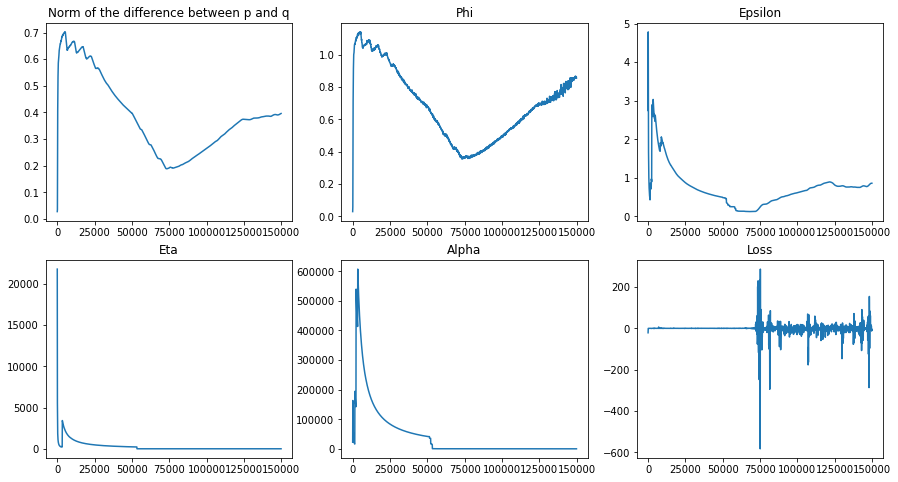

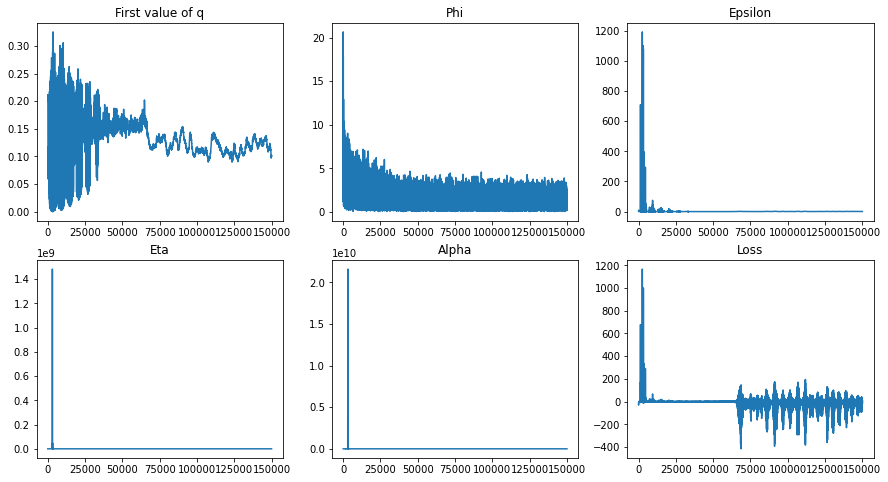


 


 	 EXP THRESHOLD 0.15000000000000002 
 
 

epoch 0: 
 	 epsilon_=1.3205820322036743 and grad = 1.0 and lr = 0.011664999999999816 
 	 eta_=9.990045547485352 and grad = -1.0 and lr = 0.011664999999999816 
 	 alpha_=10.010045051574707 and grad = 1.0 and lr = 0.011664999999999816 
 	 s_=tensor([-1.5512, -1.7335, -2.2178, -3.3809, -2.4466, -3.4275, -2.3862, -2.5685,
        -3.9956, -6.2782, -4.1960, -6.2962, -3.1846, -4.3478, -4.1474, -6.4300,
        -5.4729, -6.6124, -3.4275, -4.4083, -4.3618, -6.4620, -5.4869, -6.6263],
       requires_grad=True)
 	 q2=tensor([0.2011, 0.1701, 0.1101, 0.0356, 0.0885, 0.0341, 0.0937, 0.0787, 0.0194,
        0.0020, 0.0159, 0.0019, 0.0432, 0.0137, 0.0167, 0.0017, 0.0044, 0.0014,
        0.0341, 0.0129, 0.0135, 0.0016, 0.0043, 0.0014],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 1.0000,  1.0000, -0.7586, -0.2815, -0.6256, -0.2627, -0.8329, -0.5444,
        -0.1464, -0.0149, -0.1228, -0.0146, -0.3430, -0.1046, -0.1231, -0.0127,
      

epoch 10500: 
 	 epsilon_=0.0816848874092102 and grad = -0.021957699209451675 and lr = 1.257917499999999 
 	 eta_=1.045043706893921 and grad = 0.2616475224494934 and lr = 1.257917499999999 
 	 alpha_=4.10705041885376 and grad = -0.011070787906646729 and lr = 1.257917499999999 
 	 s_=tensor([ 1.2686,  1.0293,  0.6941, -0.4976,  0.9852, -0.6056,  1.1309,  0.9182,
        -0.9887, -1.4411, -0.7833, -1.6587, -0.1957, -0.9622, -0.8364, -1.2429,
        -1.3072, -1.3774, -0.6240, -1.0351, -1.0553, -1.3911, -1.1710, -1.3212],
       requires_grad=True)
 	 q2=tensor([0.0969, 0.0854, 0.0685, 0.0337, 0.0825, 0.0355, 0.0985, 0.0857, 0.0273,
        0.0214, 0.0319, 0.0166, 0.0405, 0.0277, 0.0320, 0.0236, 0.0230, 0.0204,
        0.0312, 0.0261, 0.0262, 0.0188, 0.0256, 0.0210],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0479,  0.0422,  0.0428,  0.0256,  0.0399, -0.0180, -0.0380, -0.0347,
        -0.0158, -0.0123, -0.0132, -0.0108,  0.0248, -0.0125, -0.0209, -0.0150,
        -0.

epoch 21000: 
 	 epsilon_=0.04406347870826721 and grad = -0.03959910199046135 and lr = 0.6341668749999998 
 	 eta_=0.11430656909942627 and grad = -0.010336890816688538 and lr = 0.6341668749999998 
 	 alpha_=1.7657291889190674 and grad = 0.04632159322500229 and lr = 0.6341668749999998 
 	 s_=tensor([ 0.3173,  0.2668,  0.1747, -0.0938,  0.2319, -0.0738,  0.2586,  0.1624,
        -0.0893, -0.1669, -0.0977, -0.1205, -0.0429, -0.1834, -0.1316, -0.2208,
        -0.1861, -0.2353, -0.0622, -0.0794, -0.1138, -0.2318, -0.2385, -0.1902],
       requires_grad=True)
 	 q2=tensor([0.0528, 0.0512, 0.0482, 0.0404, 0.0497, 0.0409, 0.0507, 0.0474, 0.0402,
        0.0381, 0.0399, 0.0396, 0.0416, 0.0378, 0.0389, 0.0360, 0.0374, 0.0367,
        0.0411, 0.0405, 0.0395, 0.0375, 0.0366, 0.0371],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0046,  0.0034,  0.0033, -0.0016,  0.0051, -0.0016,  0.0045,  0.0053,
        -0.0020, -0.0024, -0.0017, -0.0006,  0.0040, -0.0032, -0.0011, -0.0021,
   

epoch 31500: 
 	 epsilon_=0.1344233900308609 and grad = -0.0502510592341423 and lr = 0.08809890625000007 
 	 eta_=0.7364426851272583 and grad = 0.08451956510543823 and lr = 0.08809890625000007 
 	 alpha_=2.476710081100464 and grad = -0.036497436463832855 and lr = 0.08809890625000007 
 	 s_=tensor([ 2.3014,  2.8457,  1.4061, -0.2853,  1.0979, -0.3086,  1.2744,  0.9028,
        -0.9825, -1.4455, -1.1955, -1.4322,  0.0249, -1.3626, -1.1682, -1.4467,
        -1.4544, -1.4323, -0.3161, -1.4280, -1.3837, -1.4345, -1.4305, -1.3733],
       requires_grad=True)
 	 q2=tensor([0.1459, 0.1746, 0.0989, 0.0337, 0.0838, 0.0328, 0.0916, 0.0746, 0.0186,
        0.0124, 0.0155, 0.0124, 0.0417, 0.0133, 0.0162, 0.0122, 0.0121, 0.0123,
        0.0331, 0.0128, 0.0134, 0.0125, 0.0125, 0.0130],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0180,  0.0187,  0.0136,  0.0084,  0.0161, -0.0280,  0.0211,  0.0224,
         0.0055, -0.0133, -0.0158, -0.0128,  0.0067, -0.0138, -0.0163, -0.0120,
    

epoch 42000: 
 	 epsilon_=0.11434126645326614 and grad = -0.021121583878993988 and lr = 0.010013007812500016 
 	 eta_=0.9245214462280273 and grad = 0.11003746092319489 and lr = 0.010013007812500016 
 	 alpha_=1.999832034111023 and grad = -0.05467021465301514 and lr = 0.010013007812500016 
 	 s_=tensor([ 2.4618,  2.4338,  1.6282, -0.2694,  1.1645, -0.3323,  1.2878,  0.9454,
        -1.0249, -1.4944, -1.2552, -1.4998, -0.0142, -1.4231, -1.1959, -1.5069,
        -1.5066, -1.5087, -0.3358, -1.4688, -1.4338, -1.5387, -1.5055, -1.4730],
       requires_grad=True)
 	 q2=tensor([0.1539, 0.1526, 0.1095, 0.0343, 0.0872, 0.0328, 0.0928, 0.0771, 0.0186,
        0.0123, 0.0152, 0.0122, 0.0416, 0.0131, 0.0160, 0.0121, 0.0121, 0.0121,
        0.0326, 0.0126, 0.0130, 0.0118, 0.0122, 0.0125],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 0.0107,  0.0074,  0.0468,  0.0081,  0.0204,  0.0061,  0.0147, -0.0168,
         0.0052, -0.0187,  0.0030, -0.0177,  0.0144, -0.0193, -0

epoch 52500: 
 	 epsilon_=0.12351945787668228 and grad = -0.021397151052951813 and lr = 0.019749355468749993 
 	 eta_=0.9489730000495911 and grad = -0.09195306897163391 and lr = 0.019749355468749993 
 	 alpha_=1.821273684501648 and grad = 0.07996150851249695 and lr = 0.019749355468749993 
 	 s_=tensor([ 2.6453,  2.2460,  1.6333, -0.2846,  1.1664, -0.3340,  1.2691,  0.9534,
        -1.0241, -1.5230, -1.2514, -1.5176, -0.0088, -1.4266, -1.2022, -1.5094,
        -1.5225, -1.5525, -0.3325, -1.4809, -1.4421, -1.5331, -1.5089, -1.5346],
       requires_grad=True)
 	 q2=tensor([0.1647, 0.1426, 0.1101, 0.0341, 0.0875, 0.0328, 0.0922, 0.0774, 0.0186,
        0.0120, 0.0153, 0.0120, 0.0418, 0.0131, 0.0160, 0.0121, 0.0119, 0.0116,
        0.0328, 0.0125, 0.0129, 0.0119, 0.0121, 0.0119],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 0.0710,  0.0316, -0.0501,  0.0180, -0.0283, -0.0251,  0.0001,  0.0529,
         0.0153, -0.0107, -0.0132, -0.0116, -0.0256, -0.0131, -0

epoch 63000: 
 	 epsilon_=0.09719560295343399 and grad = -0.020780324935913086 and lr = 0.014876303710937499 
 	 eta_=0.879544198513031 and grad = 0.25148266553878784 and lr = 0.014876303710937499 
 	 alpha_=0.8520000576972961 and grad = -0.215736985206604 and lr = 0.014876303710937499 
 	 s_=tensor([ 2.5529,  2.4886,  1.6127, -0.2703,  1.1634, -0.3254,  1.1632,  0.9544,
        -1.0202, -1.4997, -1.2500, -1.4680, -0.0027, -1.4132, -1.1895, -1.5000,
        -1.4877, -1.4888, -0.3273, -1.4758, -1.4363, -1.4968, -1.4750, -1.4863],
       requires_grad=True)
 	 q2=tensor([0.1588, 0.1548, 0.1085, 0.0342, 0.0864, 0.0328, 0.0865, 0.0772, 0.0186,
        0.0121, 0.0152, 0.0125, 0.0417, 0.0131, 0.0160, 0.0122, 0.0123, 0.0122,
        0.0328, 0.0124, 0.0129, 0.0122, 0.0124, 0.0122],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([-0.0348,  0.0476, -0.0536,  0.0202,  0.0776, -0.0438,  0.0068,  0.0373,
         0.0026, -0.0130, -0.0214, -0.0097,  0.0415, -0.0072, -0.0

epoch 73500: 
 	 epsilon_=0.5477149486541748 and grad = -0.004436671733856201 and lr = 0.010610147705078126 
 	 eta_=1.7161839008331299 and grad = 1.0 and lr = 0.010610147705078126 
 	 alpha_=0.04626929387450218 and grad = -1.0 and lr = 0.010610147705078126 
 	 s_=tensor([ 2.0005,  1.1103,  1.1692, -0.5073,  0.6878, -0.5941,  0.9044,  0.6158,
        -1.2546, -1.2023, -1.3464, -1.1727, -0.2197, -1.4426, -1.3729, -1.0987,
        -1.4406, -1.4718, -0.5962, -1.5733, -1.5275, -1.4339, -1.3874, -1.3509],
       requires_grad=True)
 	 q2=tensor([0.1576, 0.1033, 0.1067, 0.0349, 0.0812, 0.0326, 0.0922, 0.0777, 0.0186,
        0.0195, 0.0171, 0.0199, 0.0436, 0.0157, 0.0167, 0.0213, 0.0157, 0.0153,
        0.0325, 0.0140, 0.0145, 0.0158, 0.0165, 0.0170],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([-1.0000,  1.0000,  0.9099,  0.4805, -0.4247, -0.6815,  0.8614, -0.2315,
         0.0186, -0.0783, -0.0811,  0.5105, -0.6429, -0.0289,  0.2818, -0.2080,
         0.1250

epoch 85500: 
 	 epsilon_=0.5945748090744019 and grad = -0.00504225492477417 and lr = 0.010152536926269532 
 	 eta_=1.8026317358016968 and grad = 1.0 and lr = 0.010152536926269532 
 	 alpha_=0.04381849616765976 and grad = -1.0 and lr = 0.010152536926269532 
 	 s_=tensor([ 1.1165,  0.9794,  1.0970, -0.5950,  0.5548, -0.6364,  0.7891,  0.2517,
        -1.3454, -1.2121, -1.5480, -1.3220, -0.3327, -1.1424, -1.3398, -1.0974,
        -1.0035, -1.1639, -0.6759, -1.5350, -1.5394, -1.4443, -1.0730, -1.1242],
       requires_grad=True)
 	 q2=tensor([0.1130, 0.1049, 0.1119, 0.0355, 0.0815, 0.0344, 0.0940, 0.0667, 0.0187,
        0.0211, 0.0156, 0.0191, 0.0436, 0.0224, 0.0188, 0.0233, 0.0253, 0.0220,
        0.0333, 0.0158, 0.0157, 0.0171, 0.0238, 0.0228],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 1.0000,  1.0000,  1.0000, -1.0000,  1.0000, -1.0000,  1.0000, -1.0000,
        -0.3474,  0.0117, -0.1043, -0.2378, -1.0000,  0.6340, -0.1464, -0.8965,
        -0.5870,

epoch 96000: 
 	 epsilon_=0.48607224225997925 and grad = -0.0018398761749267578 and lr = 0.01000002540588379 
 	 eta_=1.6214078664779663 and grad = -1.0 and lr = 0.01000002540588379 
 	 alpha_=0.06526259332895279 and grad = 1.0 and lr = 0.01000002540588379 
 	 s_=tensor([ 1.2194,  1.1667,  1.0940, -0.5929,  0.6398, -0.6721,  0.8191,  0.4953,
        -1.2788, -1.2523, -1.4542, -1.4096, -0.3346, -1.3698, -1.3207, -1.1571,
        -0.8081, -0.8814, -0.6395, -1.6852, -1.6234, -1.3543, -1.2561, -1.3136],
       requires_grad=True)
 	 q2=tensor([0.1157, 0.1127, 0.1081, 0.0344, 0.0831, 0.0323, 0.0927, 0.0761, 0.0192,
        0.0196, 0.0164, 0.0171, 0.0423, 0.0177, 0.0185, 0.0214, 0.0288, 0.0271,
        0.0332, 0.0133, 0.0141, 0.0179, 0.0196, 0.0186],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([-1.0000, -1.0000,  1.0000,  0.7281,  0.7994, -0.4539, -1.0000, -1.0000,
         0.1262,  0.5952,  0.4023,  0.1664,  0.2333,  0.2239,  0.0670,  0.2408,
        -0.3087,

epoch 106500: 
 	 epsilon_=0.8133733868598938 and grad = -0.0005799531936645508 and lr = 0.010019041709899902 
 	 eta_=2.254868268966675 and grad = -1.0 and lr = 0.010019041709899902 
 	 alpha_=0.028669988736510277 and grad = 1.0 and lr = 0.010019041709899902 
 	 s_=tensor([ 1.6652,  1.0018,  0.8814, -0.4572,  0.8607, -0.5194,  0.7479,  0.6081,
        -1.0607, -0.8520, -1.4064, -1.1200, -0.1626, -1.0891, -1.0406, -0.6816,
        -0.8087, -0.5676, -0.4710, -1.1383, -1.1445, -1.0209, -1.0581, -0.9959],
       requires_grad=True)
 	 q2=tensor([0.1288, 0.0920, 0.0861, 0.0343, 0.0850, 0.0327, 0.0795, 0.0731, 0.0208,
        0.0249, 0.0153, 0.0198, 0.0430, 0.0203, 0.0212, 0.0287, 0.0258, 0.0314,
        0.0340, 0.0195, 0.0194, 0.0216, 0.0209, 0.0220],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([-1.0000,  1.0000, -1.0000,  1.0000,  1.0000, -0.2780,  1.0000, -1.0000,
         1.0000, -0.0425,  1.0000, -1.0000,  1.0000,  1.0000,  1.0000, -1.0000,
         0.70

epoch 118500: 
 	 epsilon_=0.5631770491600037 and grad = -0.004398703575134277 and lr = 0.010004760427474975 
 	 eta_=1.7443302869796753 and grad = -1.0 and lr = 0.010004760427474975 
 	 alpha_=0.05213978514075279 and grad = 1.0 and lr = 0.010004760427474975 
 	 s_=tensor([ 1.8726,  0.4729,  1.1439, -0.4555,  0.8119, -0.4651,  0.8986,  0.7016,
        -1.0574, -0.9901, -1.3213, -1.3057, -0.2376, -1.0585, -0.8462, -0.7147,
        -0.7813, -0.4718, -0.5153, -1.4019, -1.3562, -1.3228, -1.0389, -1.0732],
       requires_grad=True)
 	 q2=tensor([0.1416, 0.0672, 0.0998, 0.0345, 0.0829, 0.0342, 0.0871, 0.0777, 0.0210,
        0.0222, 0.0166, 0.0168, 0.0409, 0.0209, 0.0251, 0.0279, 0.0265, 0.0340,
        0.0329, 0.0155, 0.0161, 0.0166, 0.0213, 0.0207],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 1.0000,  1.0000, -1.0000, -0.5874,  0.3819, -1.0000,  0.0158, -1.0000,
        -0.4467,  0.4267, -0.2590, -0.0010, -0.6056, -0.3227,  0.2600,  0.5113,
        -0.6602, -0.2114, -0.

epoch 130500: 
 	 epsilon_=0.7272429466247559 and grad = 0.0033785104751586914 and lr = 0.010001190106868745 
 	 eta_=2.072366714477539 and grad = -1.0 and lr = 0.010001190106868745 
 	 alpha_=0.062278538942337036 and grad = 1.0 and lr = 0.010001190106868745 
 	 s_=tensor([ 1.6568,  1.2783,  1.3613, -0.3754,  0.7384, -0.4677,  0.9981,  0.6866,
        -1.1199, -1.1588, -1.2692, -1.3330, -0.1839, -1.2075, -1.1866, -0.9993,
        -0.9461, -0.7856, -0.4421, -1.4727, -1.3763, -1.1669, -1.0917, -1.1135],
       requires_grad=True)
 	 q2=tensor([0.1268, 0.1055, 0.1100, 0.0362, 0.0781, 0.0336, 0.0908, 0.0758, 0.0195,
        0.0189, 0.0171, 0.0162, 0.0419, 0.0181, 0.0184, 0.0217, 0.0227, 0.0260,
        0.0343, 0.0143, 0.0156, 0.0187, 0.0200, 0.0196],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.8969, -1.0000, -0.4397, -0.1401,  1.0000,  0.8026, -1.0000,  1.0000,
        -0.2558, -0.0176, -0.1290, -0.0596, -0.3092,  0.1579, -0.0693, -0.0222,
        -0.0129, -0.1517,  0.

epoch 142500: 
 	 epsilon_=0.49951237440109253 and grad = -0.004074156284332275 and lr = 0.010000297526717185 
 	 eta_=1.6387094259262085 and grad = -1.0 and lr = 0.010000297526717185 
 	 alpha_=0.09117892384529114 and grad = 1.0 and lr = 0.010000297526717185 
 	 s_=tensor([ 1.5361,  1.3574,  1.6178, -0.2873,  1.0777, -0.3604,  1.2697,  0.9056,
        -1.0213, -0.8367, -1.1236, -1.0695, -0.0246, -1.0572, -0.9336, -0.6409,
        -0.7152, -0.2911, -0.3605, -1.1562, -1.1473, -0.9885, -0.9872, -0.8901],
       requires_grad=True)
 	 q2=tensor([0.1060, 0.0971, 0.1102, 0.0343, 0.0840, 0.0324, 0.0929, 0.0762, 0.0188,
        0.0220, 0.0172, 0.0181, 0.0417, 0.0183, 0.0203, 0.0259, 0.0244, 0.0342,
        0.0324, 0.0168, 0.0169, 0.0194, 0.0194, 0.0211],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 0.4642,  0.3906, -0.5024, -0.2819,  0.1283,  0.0771,  0.9604, -1.0000,
         0.0256,  0.1824,  0.1987,  0.0407, -0.0930,  0.1456, -0.2774, -0.1110,
        -0.17

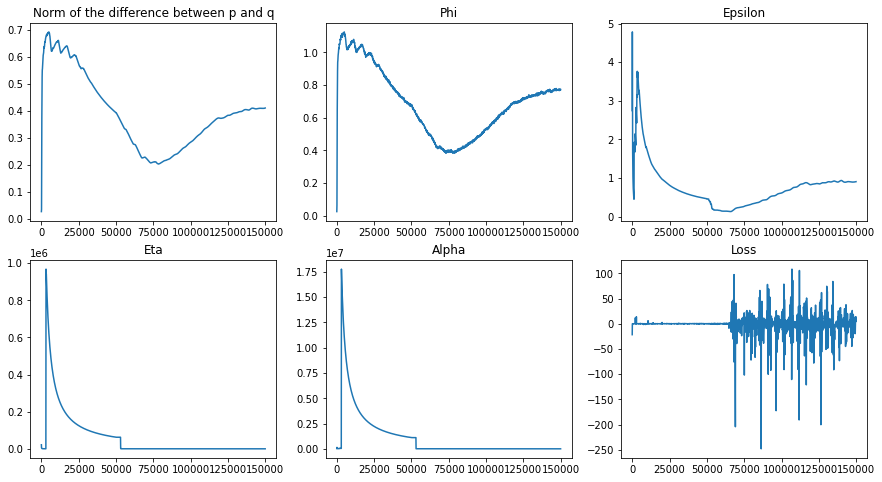

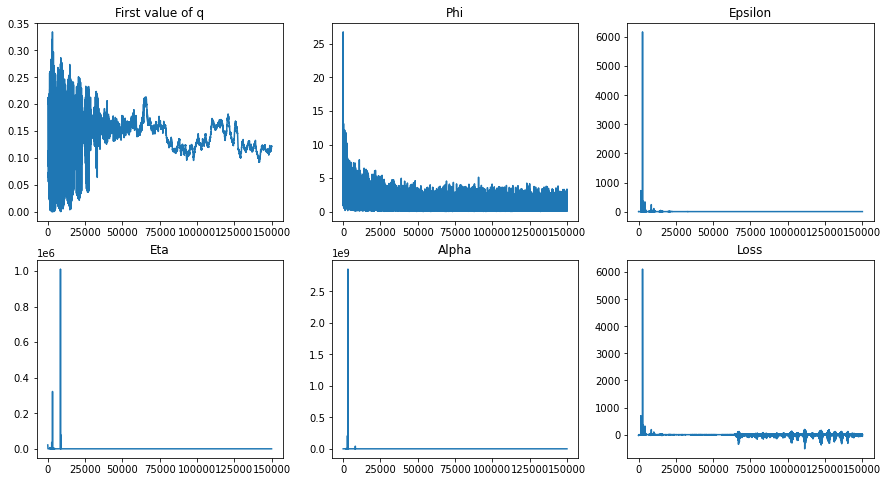


 


 	 EXP THRESHOLD 0.2 
 
 

epoch 0: 
 	 epsilon_=1.3205820322036743 and grad = 1.0 and lr = 0.011664999999999816 
 	 eta_=9.990045547485352 and grad = -1.0 and lr = 0.011664999999999816 
 	 alpha_=10.010045051574707 and grad = 1.0 and lr = 0.011664999999999816 
 	 s_=tensor([-1.5512, -1.7335, -2.2178, -3.3809, -2.4466, -3.4275, -2.3862, -2.5685,
        -3.9956, -6.2782, -4.1960, -6.2962, -3.1846, -4.3478, -4.1474, -6.4300,
        -5.4729, -6.6124, -3.4275, -4.4083, -4.3618, -6.4620, -5.4869, -6.6263],
       requires_grad=True)
 	 q2=tensor([0.2011, 0.1701, 0.1101, 0.0356, 0.0885, 0.0341, 0.0937, 0.0787, 0.0194,
        0.0020, 0.0159, 0.0019, 0.0432, 0.0137, 0.0167, 0.0017, 0.0044, 0.0014,
        0.0341, 0.0129, 0.0135, 0.0016, 0.0043, 0.0014],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 1.0000,  1.0000, -0.7281, -0.2811, -0.5331, -0.2225, -0.9888, -0.5686,
        -0.1359, -0.0148, -0.1163, -0.0146, -0.3156, -0.1021, -0.1277, -0.0127,
        -0.0339, -0.01

epoch 10500: 
 	 epsilon_=0.01215236634016037 and grad = -0.008724726736545563 and lr = 1.257917499999999 
 	 eta_=0.07655220478773117 and grad = 0.0021525993943214417 and lr = 1.257917499999999 
 	 alpha_=1.8071227073669434 and grad = 0.023891961202025414 and lr = 1.257917499999999 
 	 s_=tensor([ 0.6519,  0.4558,  0.1352, -0.0380,  0.1984,  0.1390,  0.4143,  0.0779,
        -0.0394, -0.0532, -0.1146, -0.1159,  0.0614, -0.0448, -0.0422, -0.1264,
         0.0139, -0.0265, -0.0372, -0.0628, -0.0021, -0.1166, -0.1717, -0.0639],
       requires_grad=True)
 	 q2=tensor([0.0614, 0.0541, 0.0437, 0.0390, 0.0455, 0.0429, 0.0523, 0.0418, 0.0389,
        0.0408, 0.0369, 0.0388, 0.0408, 0.0378, 0.0380, 0.0387, 0.0405, 0.0407,
        0.0389, 0.0376, 0.0390, 0.0384, 0.0334, 0.0401],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 1.5916e-03,  3.7597e-03,  2.7389e-03,  7.9372e-04,  1.0694e-03,
        -2.4017e-03,  2.7002e-03,  2.0401e-03, -8.9412e-04, -1.4224e-03,
   

epoch 21000: 
 	 epsilon_=1.232564091682434 and grad = -1.0 and lr = 0.6341668749999998 
 	 eta_=0.32137566804885864 and grad = -0.688437819480896 and lr = 0.6341668749999998 
 	 alpha_=4.889106273651123 and grad = -0.0006049256771802902 and lr = 0.6341668749999998 
 	 s_=tensor([ 3.9316,  3.6898,  2.3458,  0.1178,  2.0553,  0.0528,  1.4300,  1.5760,
        -0.3596, -1.0338, -0.9567, -0.9068,  0.7376, -0.7258, -0.4552, -0.9416,
        -1.0503, -0.9434, -0.0948, -1.0768, -0.1368, -0.9506, -0.9671, -0.9258],
       requires_grad=True)
 	 q2=tensor([0.1698, 0.1669, 0.1057, 0.0347, 0.0894, 0.0328, 0.0654, 0.0730, 0.0226,
        0.0099, 0.0139, 0.0109, 0.0459, 0.0151, 0.0196, 0.0109, 0.0098, 0.0107,
        0.0278, 0.0123, 0.0219, 0.0106, 0.0101, 0.0103],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 0.0211,  0.0248,  0.0213, -0.0227, -0.0353, -0.0231,  0.0197,  0.0227,
        -0.0157, -0.0083,  0.0072, -0.0091, -0.0257, -0.0117, -0.0143, -0.0090,
       

epoch 31500: 
 	 epsilon_=0.14221446216106415 and grad = -0.026690907776355743 and lr = 0.08809890625000007 
 	 eta_=0.9291627407073975 and grad = -0.024464264512062073 and lr = 0.08809890625000007 
 	 alpha_=2.474424362182617 and grad = 0.016633599996566772 and lr = 0.08809890625000007 
 	 s_=tensor([ 2.8391,  2.5763,  1.5323, -0.3115,  1.0002, -0.3785,  1.0907,  0.9013,
        -1.0189, -1.5518, -1.2349, -1.6094, -0.0130, -1.3857, -1.1874, -1.5541,
        -1.5847, -1.5390, -0.3233, -1.4632, -1.4108, -1.6063, -1.5925, -1.6082],
       requires_grad=True)
 	 q2=tensor([0.1747, 0.1614, 0.1053, 0.0336, 0.0796, 0.0316, 0.0848, 0.0750, 0.0188,
        0.0116, 0.0153, 0.0110, 0.0419, 0.0138, 0.0162, 0.0116, 0.0113, 0.0116,
        0.0326, 0.0125, 0.0128, 0.0111, 0.0111, 0.0110],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 0.0327,  0.0316,  0.0222,  0.0103, -0.0010,  0.0119,  0.0046,  0.0171,
        -0.0248, -0.0157, -0.0198, -0.0147, -0.0531, -0.0182, -0.

epoch 42000: 
 	 epsilon_=0.11763054132461548 and grad = -0.02091846615076065 and lr = 0.010013007812500016 
 	 eta_=0.9359874725341797 and grad = -0.096017986536026 and lr = 0.010013007812500016 
 	 alpha_=2.25518536567688 and grad = 0.07346799969673157 and lr = 0.010013007812500016 
 	 s_=tensor([ 2.4565,  2.4280,  1.6155, -0.2765,  1.1584, -0.3392,  1.2653,  0.9344,
        -1.0288, -1.5171, -1.2608, -1.5224, -0.0175, -1.4285, -1.2057, -1.5316,
        -1.5084, -1.5291, -0.3387, -1.4911, -1.4435, -1.5200, -1.5193, -1.5285],
       requires_grad=True)
 	 q2=tensor([0.1548, 0.1531, 0.1095, 0.0344, 0.0872, 0.0328, 0.0922, 0.0771, 0.0186,
        0.0121, 0.0152, 0.0120, 0.0417, 0.0131, 0.0159, 0.0119, 0.0122, 0.0119,
        0.0328, 0.0123, 0.0129, 0.0121, 0.0121, 0.0120],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-0.0331,  0.0520,  0.0271, -0.0332,  0.0377,  0.0100,  0.0207,  0.0061,
        -0.0232, -0.0165, -0.0227, -0.0158,  0.0210, -0.0172,  0.0048, -0.0182,
   

epoch 52500: 
 	 epsilon_=0.09672589600086212 and grad = -0.02117796242237091 and lr = 0.019749355468749993 
 	 eta_=0.8714255690574646 and grad = 0.31441015005111694 and lr = 0.019749355468749993 
 	 alpha_=1.786705732345581 and grad = -0.18824616074562073 and lr = 0.019749355468749993 
 	 s_=tensor([ 2.5444,  2.2365,  1.6263, -0.2722,  1.1685, -0.3359,  1.2823,  0.9475,
        -1.0251, -1.4422, -1.2425, -1.4243, -0.0065, -1.4069, -1.1889, -1.4357,
        -1.4314, -1.4550, -0.3285, -1.4641, -1.4175, -1.4352, -1.4397, -1.4483],
       requires_grad=True)
 	 q2=tensor([0.1587, 0.1413, 0.1092, 0.0343, 0.0872, 0.0327, 0.0927, 0.0772, 0.0186,
        0.0128, 0.0153, 0.0130, 0.0418, 0.0133, 0.0161, 0.0129, 0.0130, 0.0127,
        0.0328, 0.0126, 0.0132, 0.0130, 0.0129, 0.0128],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0250,  0.0284, -0.0059, -0.0006,  0.0126,  0.0144,  0.0223, -0.0014,
         0.0069, -0.0147, -0.0179, -0.0175,  0.0095, -0.0173, -0.0189, -0.0176,


epoch 63000: 
 	 epsilon_=0.10340673476457596 and grad = -0.020724870264530182 and lr = 0.014876303710937499 
 	 eta_=0.8975886106491089 and grad = -0.4953600764274597 and lr = 0.014876303710937499 
 	 alpha_=1.2909889221191406 and grad = 0.4631304442882538 and lr = 0.014876303710937499 
 	 s_=tensor([ 2.3623,  2.4175,  1.6702, -0.2448,  1.2061, -0.3061,  1.2971,  0.9611,
        -0.9991, -1.3320, -1.2339, -1.3326,  0.0232, -1.3729, -1.1742, -1.3785,
        -1.3366, -1.3633, -0.3034, -1.4151, -1.3628, -1.3722, -1.3703, -1.3536],
       requires_grad=True)
 	 q2=tensor([0.1460, 0.1487, 0.1096, 0.0344, 0.0873, 0.0328, 0.0914, 0.0764, 0.0186,
        0.0139, 0.0152, 0.0138, 0.0418, 0.0134, 0.0160, 0.0134, 0.0138, 0.0135,
        0.0329, 0.0129, 0.0135, 0.0135, 0.0135, 0.0137],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0641, -0.0141,  0.0490, -0.0457, -0.0128,  0.0199,  0.0299, -0.0083,
        -0.0145, -0.0170,  0.0085, -0.0130,  0.0260, -0.0135, -0.0169, -0.0136,


epoch 73500: 
 	 epsilon_=0.6374228000640869 and grad = -0.004364073276519775 and lr = 0.010610147705078126 
 	 eta_=1.8834753036499023 and grad = -1.0 and lr = 0.010610147705078126 
 	 alpha_=0.031788118183612823 and grad = 1.0 and lr = 0.010610147705078126 
 	 s_=tensor([ 2.2569,  2.0330,  1.3840, -0.2176,  1.0365, -0.3406,  1.1452,  0.8656,
        -1.0817, -1.1563, -1.2561, -1.5880, -0.0197, -1.3469, -1.1913, -1.4040,
        -1.2322, -1.2054, -0.3681, -1.5524, -1.4855, -1.3580, -1.3633, -1.3772],
       requires_grad=True)
 	 q2=tensor([0.1496, 0.1369, 0.1021, 0.0375, 0.0850, 0.0341, 0.0903, 0.0772, 0.0185,
        0.0174, 0.0160, 0.0118, 0.0434, 0.0147, 0.0169, 0.0140, 0.0162, 0.0167,
        0.0333, 0.0122, 0.0129, 0.0145, 0.0145, 0.0143],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 1.0000, -1.0000, -1.0000, -1.0000,  1.0000, -1.0000,  1.0000, -1.0000,
         1.0000,  0.2335, -0.2190, -0.4271, -1.0000,  0.4282, -0.6061, -0.0474,
         0.726

epoch 85500: 
 	 epsilon_=0.3793773651123047 and grad = -0.007072031497955322 and lr = 0.010152536926269532 
 	 eta_=1.4394599199295044 and grad = 1.0 and lr = 0.010152536926269532 
 	 alpha_=0.08775287866592407 and grad = -1.0 and lr = 0.010152536926269532 
 	 s_=tensor([ 2.0696,  1.5297,  1.2856, -0.5381,  0.6946, -0.5778,  0.9242,  0.6446,
        -1.2228, -1.3831, -1.4399, -1.5843, -0.2511, -1.5620, -1.3400, -1.4640,
        -1.2057, -1.3074, -0.5758, -1.5502, -1.5875, -1.4469, -1.4919, -1.4749],
       requires_grad=True)
 	 q2=tensor([0.1586, 0.1249, 0.1108, 0.0333, 0.0797, 0.0322, 0.0912, 0.0771, 0.0187,
        0.0162, 0.0154, 0.0135, 0.0417, 0.0138, 0.0168, 0.0151, 0.0190, 0.0173,
        0.0323, 0.0139, 0.0135, 0.0153, 0.0147, 0.0149],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-0.3268,  1.0000, -0.9622, -0.0548, -0.5918,  0.0975, -0.3831,  1.0000,
        -0.0526,  0.0100, -0.0500, -0.0478,  0.1913,  0.0345,  0.0517, -0.0037,
        -0.0868,  0.0542,  0.1

epoch 97500: 
 	 epsilon_=0.6906399726867676 and grad = -0.003915131092071533 and lr = 0.010038134231567382 
 	 eta_=1.9890309572219849 and grad = -1.0 and lr = 0.010038134231567382 
 	 alpha_=0.036788687109947205 and grad = 1.0 and lr = 0.010038134231567382 
 	 s_=tensor([ 1.4663,  1.3172,  1.2583, -0.4879,  0.6724, -0.5792,  0.8928,  0.4271,
        -1.1751, -1.3823, -1.4524, -1.5174, -0.2741, -1.4936, -1.2920, -1.1206,
        -1.2269, -0.7614, -0.5567, -1.6131, -1.6143, -1.3767, -1.3272, -1.0928],
       requires_grad=True)
 	 q2=tensor([0.1256, 0.1168, 0.1132, 0.0360, 0.0816, 0.0334, 0.0929, 0.0698, 0.0202,
        0.0168, 0.0158, 0.0149, 0.0426, 0.0152, 0.0183, 0.0212, 0.0193, 0.0288,
        0.0340, 0.0137, 0.0136, 0.0169, 0.0177, 0.0217],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 1.0000, -1.0000,  1.0000, -1.0000, -1.0000,  0.3429, -0.4630,  1.0000,
         0.2239, -0.8553, -0.3767,  0.3217, -1.0000, -0.3728, -0.4164,  0.3143,
        -0.3061, -0.9724, -0.

epoch 109500: 
 	 epsilon_=1.1282544136047363 and grad = 0.008587837219238281 and lr = 0.010009533557891847 
 	 eta_=3.1014835834503174 and grad = -1.0 and lr = 0.010009533557891847 
 	 alpha_=0.01395305898040533 and grad = 1.0 and lr = 0.010009533557891847 
 	 s_=tensor([ 1.6046,  1.2072,  1.1788, -0.0406,  0.3492, -0.3850,  0.9009,  0.7965,
        -1.0210, -1.2377, -1.1475, -1.4408, -0.2382, -1.1824, -1.2033, -0.8880,
        -1.1066, -0.8802, -0.5670, -1.3262, -1.3867, -1.3671, -1.3017, -1.1770],
       requires_grad=True)
 	 q2=tensor([0.1279, 0.1051, 0.1035, 0.0482, 0.0632, 0.0372, 0.0889, 0.0836, 0.0220,
        0.0182, 0.0197, 0.0152, 0.0416, 0.0191, 0.0188, 0.0247, 0.0204, 0.0248,
        0.0322, 0.0168, 0.0160, 0.0163, 0.0172, 0.0192],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 1.,  1.,  1., -1., -1., -1.,  1.,  1., -1., -1., -1., -1., -1.,  1.,
        -1., -1.,  1.,  1., -1.,  1., -1., -1., -1., -1.]) and lr = 0.010009533557891847 
 	 phi = 1.56154167652

epoch 121500: 
 	 epsilon_=0.8058332204818726 and grad = 0.0024018287658691406 and lr = 0.010002383389472961 
 	 eta_=2.2418675422668457 and grad = -1.0 and lr = 0.010002383389472961 
 	 alpha_=0.04736141115427017 and grad = 1.0 and lr = 0.010002383389472961 
 	 s_=tensor([ 2.2734,  1.5980,  1.5937, -0.2863,  1.1070, -0.3472,  1.2192,  0.7903,
        -0.9942, -1.2377, -1.2779, -1.3228, -0.0871, -1.3111, -1.0685, -1.0167,
        -0.9339, -0.9352, -0.3231, -1.3352, -1.2753, -1.1349, -1.1568, -1.1438],
       requires_grad=True)
 	 q2=tensor([0.1471, 0.1104, 0.1104, 0.0348, 0.0863, 0.0332, 0.0918, 0.0723, 0.0195,
        0.0158, 0.0152, 0.0147, 0.0403, 0.0148, 0.0183, 0.0191, 0.0205, 0.0205,
        0.0338, 0.0145, 0.0153, 0.0173, 0.0170, 0.0171],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 1.0000,  0.4028, -0.1260, -1.0000,  0.9911, -1.0000, -1.0000, -1.0000,
        -0.0055, -0.1630,  0.1548, -0.2004, -0.7441,  0.0386, -0.4457,  0.0851,
         0.5902,  0.4243,  0.

epoch 133500: 
 	 epsilon_=0.6622914671897888 and grad = -0.0010193586349487305 and lr = 0.01000059584736824 
 	 eta_=1.9406400918960571 and grad = 1.0 and lr = 0.01000059584736824 
 	 alpha_=0.045660775154829025 and grad = -1.0 and lr = 0.01000059584736824 
 	 s_=tensor([ 1.4043,  0.9660,  1.3977, -0.2639,  0.7618, -0.4060,  0.8975,  0.1590,
        -0.4906, -0.9470, -1.0432, -1.1354,  0.0749, -0.7355, -0.8685, -0.4493,
        -0.4460, -0.3534, -0.3782, -1.1401, -1.2493, -0.9806, -0.4552, -0.6230],
       requires_grad=True)
 	 q2=tensor([0.1051, 0.0834, 0.1048, 0.0369, 0.0742, 0.0331, 0.0803, 0.0502, 0.0309,
        0.0212, 0.0196, 0.0180, 0.0474, 0.0254, 0.0227, 0.0320, 0.0321, 0.0345,
        0.0338, 0.0180, 0.0163, 0.0206, 0.0318, 0.0278],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 1.0000,  0.2649,  1.0000,  1.0000, -1.0000, -0.4245,  0.1132,  0.0996,
         0.4431, -0.4343,  0.4086, -0.2081, -1.0000,  1.0000,  0.5375,  0.2963,
        -1.0000, -1.0000, -1.0

epoch 145500: 
 	 epsilon_=0.2681226432323456 and grad = -0.012861669063568115 and lr = 0.01000014896184206 
 	 eta_=1.254424810409546 and grad = 0.3523554801940918 and lr = 0.01000014896184206 
 	 alpha_=0.11105212569236755 and grad = -0.45259666442871094 and lr = 0.01000014896184206 
 	 s_=tensor([ 1.9569,  0.7738,  1.3980, -0.3980,  0.8633, -0.4502,  1.0463,  0.4763,
        -1.0639, -1.1304, -1.3624, -1.4033, -0.1408, -1.0262, -1.0627, -0.4566,
        -0.3631, -0.7320, -0.4511, -1.2009, -1.2121, -1.1652, -1.1762, -1.0240],
       requires_grad=True)
 	 q2=tensor([0.1400, 0.0774, 0.1085, 0.0344, 0.0814, 0.0331, 0.0903, 0.0644, 0.0199,
        0.0188, 0.0153, 0.0147, 0.0419, 0.0205, 0.0199, 0.0329, 0.0354, 0.0263,
        0.0330, 0.0176, 0.0175, 0.0182, 0.0180, 0.0206],
       grad_fn=<DivBackward0>) and sum=0.9999998807907104 and grad = tensor([-0.4205, -0.7329, -0.0684, -0.2416,  0.6047, -0.0882,  1.0000,  0.0102,
         0.1241, -0.0247, -0.1581,  0.0511, -0.1057,  0.1766,  0.10

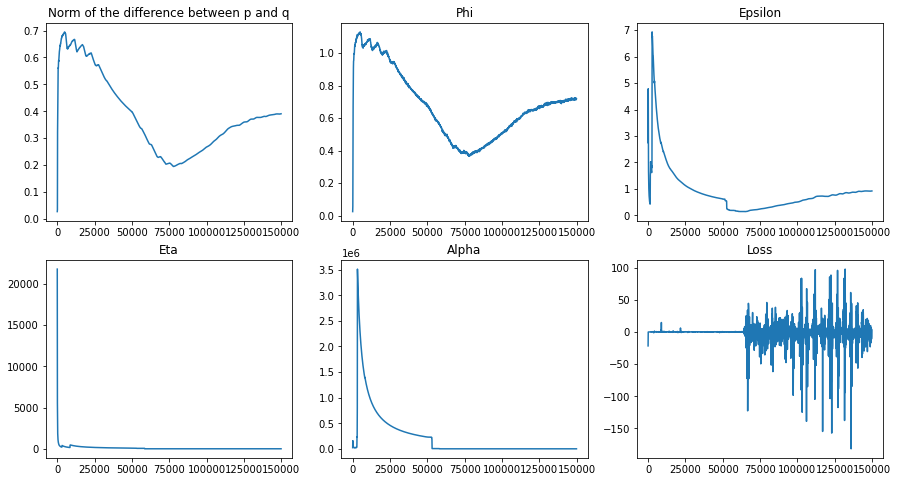

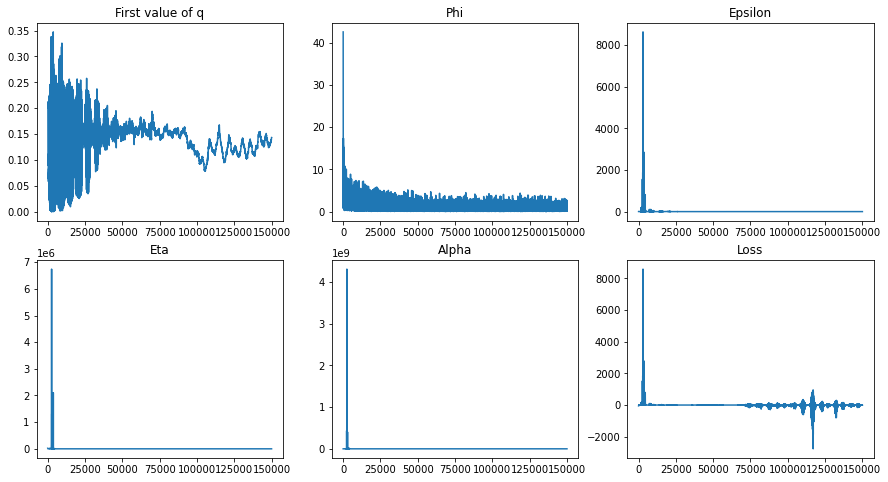


 


 	 EXP THRESHOLD 0.25 
 
 

epoch 0: 
 	 epsilon_=1.3205820322036743 and grad = 1.0 and lr = 0.011664999999999816 
 	 eta_=9.990045547485352 and grad = -1.0 and lr = 0.011664999999999816 
 	 alpha_=10.010045051574707 and grad = 0.661475658416748 and lr = 0.011664999999999816 
 	 s_=tensor([-1.5512, -1.7335, -2.2178, -3.3809, -2.4466, -3.4275, -2.3862, -2.5685,
        -3.9956, -6.2782, -4.1960, -6.2962, -3.1846, -4.3478, -4.1474, -6.4300,
        -5.4729, -6.6124, -3.4275, -4.4083, -4.3618, -6.4620, -5.4869, -6.6263],
       requires_grad=True)
 	 q2=tensor([0.2011, 0.1701, 0.1101, 0.0356, 0.0885, 0.0341, 0.0937, 0.0787, 0.0194,
        0.0020, 0.0159, 0.0019, 0.0432, 0.0137, 0.0167, 0.0017, 0.0044, 0.0014,
        0.0341, 0.0129, 0.0135, 0.0016, 0.0043, 0.0014],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 1.0000,  1.0000, -0.7345, -0.2562, -0.4993, -0.2365, -0.5558, -0.6024,
        -0.1456, -0.0142, -0.1153, -0.0139, -0.2827, -0.0995, -0.1208, -0.0122,
       

epoch 10500: 
 	 epsilon_=0.5420281887054443 and grad = 0.6305872797966003 and lr = 1.257917499999999 
 	 eta_=4.090978145599365 and grad = -0.02262696623802185 and lr = 1.257917499999999 
 	 alpha_=4.345702171325684 and grad = 0.01173238456249237 and lr = 1.257917499999999 
 	 s_=tensor([ 4.0275,  3.5368,  1.9008,  0.0615,  2.4662,  0.5662,  1.1911,  2.0893,
        -0.6921, -1.6223, -0.3791, -1.6194,  0.3931, -0.2809, -0.2457, -1.6211,
        -1.3487, -1.5331,  0.3334, -0.6105, -1.1963, -1.5172, -1.4095, -1.4927],
       requires_grad=True)
 	 q2=tensor([0.1778, 0.1582, 0.0700, 0.0411, 0.1018, 0.0514, 0.0468, 0.0729, 0.0148,
        0.0101, 0.0227, 0.0087, 0.0493, 0.0254, 0.0268, 0.0094, 0.0095, 0.0096,
        0.0294, 0.0201, 0.0136, 0.0116, 0.0089, 0.0099],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 0.1424,  0.1397,  0.1356, -0.1196, -0.2177, -0.1192,  0.0808,  0.1179,
         0.0411, -0.0387, -0.0662, -0.0360, -0.1213, -0.0710, -0.0713, -0.0373

epoch 21000: 
 	 epsilon_=0.9321356415748596 and grad = 0.23549318313598633 and lr = 0.6341668749999998 
 	 eta_=2.0950682163238525 and grad = -0.42247065901756287 and lr = 0.6341668749999998 
 	 alpha_=8.031140327453613 and grad = -0.016557563096284866 and lr = 0.6341668749999998 
 	 s_=tensor([ 4.5222,  3.5497,  2.7125, -0.1240,  1.2154, -0.1755,  1.6479,  1.5755,
        -0.5536, -2.0026, -0.5824, -1.9334,  0.2824, -1.4563, -0.9438, -2.0121,
        -2.0096, -2.1147,  0.2099, -1.2427, -1.5495, -2.0404, -2.0453, -1.9813],
       requires_grad=True)
 	 q2=tensor([0.1959, 0.1758, 0.1360, 0.0305, 0.0760, 0.0265, 0.0773, 0.0863, 0.0185,
        0.0054, 0.0211, 0.0057, 0.0379, 0.0083, 0.0139, 0.0054, 0.0057, 0.0047,
        0.0318, 0.0127, 0.0077, 0.0057, 0.0056, 0.0056],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.1122, -0.1170, -0.1108,  0.0561,  0.0998,  0.0413,  0.0949, -0.1291,
         0.0337, -0.0128, -0.0449, -0.0138,  0.0561,  0.0169,  0.0274, -0.0130,
      

epoch 31500: 
 	 epsilon_=0.11043938994407654 and grad = -0.03233800828456879 and lr = 0.08809890625000007 
 	 eta_=0.8004068732261658 and grad = -0.01214475929737091 and lr = 0.08809890625000007 
 	 alpha_=2.776554584503174 and grad = 0.023606441915035248 and lr = 0.08809890625000007 
 	 s_=tensor([ 2.8518e+00,  2.0624e+00,  1.6326e+00, -2.5280e-01,  1.1147e+00,
        -3.2086e-01,  1.1626e+00,  8.9123e-01, -1.0374e+00, -1.4897e+00,
        -1.2506e+00, -1.4101e+00, -1.0427e-03, -1.2920e+00, -1.1977e+00,
        -1.4590e+00, -1.4292e+00, -1.4513e+00, -3.3540e-01, -1.4085e+00,
        -1.3890e+00, -1.4990e+00, -1.4659e+00, -1.4424e+00],
       requires_grad=True)
 	 q2=tensor([0.1766, 0.1321, 0.1098, 0.0347, 0.0852, 0.0326, 0.0875, 0.0743, 0.0184,
        0.0125, 0.0152, 0.0131, 0.0416, 0.0148, 0.0160, 0.0126, 0.0129, 0.0128,
        0.0326, 0.0133, 0.0138, 0.0122, 0.0127, 0.0129],
       grad_fn=<DivBackward0>) and sum=0.9999998807907104 and grad = tensor([ 0.0187,  0.0197,  0.0240, 

epoch 42000: 
 	 epsilon_=0.08749847114086151 and grad = -0.026558905839920044 and lr = 0.010013007812500016 
 	 eta_=0.7739822864532471 and grad = -0.015514552593231201 and lr = 0.010013007812500016 
 	 alpha_=2.467561721801758 and grad = 0.03430023044347763 and lr = 0.010013007812500016 
 	 s_=tensor([ 2.3460e+00,  2.3710e+00,  1.6410e+00, -2.6876e-01,  1.1722e+00,
        -3.2986e-01,  1.2933e+00,  9.5152e-01, -1.0224e+00, -1.4061e+00,
        -1.2511e+00, -1.4101e+00, -6.5123e-04, -1.4004e+00, -1.1958e+00,
        -1.4280e+00, -1.4081e+00, -1.4164e+00, -3.2616e-01, -1.4267e+00,
        -1.4053e+00, -1.4057e+00, -1.3941e+00, -1.4157e+00],
       requires_grad=True)
 	 q2=tensor([0.1475, 0.1488, 0.1098, 0.0344, 0.0872, 0.0328, 0.0929, 0.0773, 0.0186,
        0.0132, 0.0152, 0.0132, 0.0419, 0.0133, 0.0159, 0.0130, 0.0132, 0.0131,
        0.0328, 0.0130, 0.0132, 0.0132, 0.0134, 0.0131],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 0.0383,  0.0294,  0.02

epoch 52500: 
 	 epsilon_=0.10567887872457504 and grad = -0.0218140110373497 and lr = 0.019749355468749993 
 	 eta_=0.8978952169418335 and grad = 0.11411407589912415 and lr = 0.019749355468749993 
 	 alpha_=1.8052899837493896 and grad = -0.05854034423828125 and lr = 0.019749355468749993 
 	 s_=tensor([ 2.5904,  2.3300,  1.6293, -0.2828,  1.1595, -0.3447,  1.2734,  0.9454,
        -1.0161, -1.5216, -1.2512, -1.5280, -0.0109, -1.4035, -1.1897, -1.5230,
        -1.5394, -1.5175, -0.3408, -1.4719, -1.4316, -1.5109, -1.5191, -1.5278],
       requires_grad=True)
 	 q2=tensor([0.1614, 0.1471, 0.1101, 0.0340, 0.0867, 0.0324, 0.0922, 0.0771, 0.0187,
        0.0119, 0.0153, 0.0119, 0.0418, 0.0134, 0.0161, 0.0120, 0.0118, 0.0120,
        0.0325, 0.0125, 0.0130, 0.0121, 0.0120, 0.0119],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 0.1106,  0.0014, -0.0920,  0.0114,  0.0229,  0.0157, -0.0052,  0.0625,
        -0.0232, -0.0133, -0.0197, -0.0102, -0.0463, -0.0147, -0.

epoch 63000: 
 	 epsilon_=0.12380266934633255 and grad = -0.020011454820632935 and lr = 0.014876303710937499 
 	 eta_=0.9614785313606262 and grad = 0.1996590793132782 and lr = 0.014876303710937499 
 	 alpha_=1.4481453895568848 and grad = -0.1495055854320526 and lr = 0.014876303710937499 
 	 s_=tensor([ 2.3474,  2.6062,  1.6026, -0.2774,  1.1602, -0.3393,  1.2696,  0.9295,
        -1.0225, -1.5705, -1.2570, -1.5536, -0.0101, -1.4277, -1.2050, -1.5582,
        -1.5318, -1.5635, -0.3382, -1.4984, -1.4435, -1.5829, -1.5303, -1.5478],
       requires_grad=True)
 	 q2=tensor([0.1486, 0.1628, 0.1087, 0.0343, 0.0873, 0.0327, 0.0922, 0.0770, 0.0187,
        0.0115, 0.0152, 0.0117, 0.0419, 0.0131, 0.0160, 0.0116, 0.0119, 0.0116,
        0.0328, 0.0123, 0.0129, 0.0114, 0.0119, 0.0118],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0430,  0.0169,  0.0553,  0.0023,  0.0201,  0.0031,  0.0026,  0.0161,
        -0.0242, -0.0155, -0.0229, -0.0155, -0.0312, -0.0175, -0.0244, -0.0161,


epoch 73500: 
 	 epsilon_=0.4833870828151703 and grad = -0.00490260124206543 and lr = 0.010610147705078126 
 	 eta_=1.6088579893112183 and grad = 1.0 and lr = 0.010610147705078126 
 	 alpha_=0.08297000825405121 and grad = -1.0 and lr = 0.010610147705078126 
 	 s_=tensor([ 2.9688,  2.5109,  1.6157, -0.1064,  0.9778, -0.2483,  1.2171,  0.8106,
        -1.0110, -1.4162, -1.1900, -1.6029,  0.0527, -1.1899, -1.1541, -1.5263,
        -1.6428, -1.6205, -0.2893, -1.3837, -1.4286, -1.5196, -1.6027, -1.5449],
       requires_grad=True)
 	 q2=tensor([0.1782, 0.1527, 0.1062, 0.0379, 0.0766, 0.0341, 0.0872, 0.0696, 0.0183,
        0.0128, 0.0157, 0.0108, 0.0425, 0.0157, 0.0162, 0.0116, 0.0105, 0.0107,
        0.0330, 0.0132, 0.0126, 0.0116, 0.0108, 0.0114],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 1.0000,  0.9225, -0.4515, -0.2240, -0.5722, -0.2236, -0.9062, -0.0678,
        -0.0575, -0.0522, -0.0904, -0.0505, -0.4355, -0.0417, -0.0488, -0.0366,
        -0.0468,

epoch 85500: 
 	 epsilon_=0.6604897975921631 and grad = 6.979703903198242e-05 and lr = 0.010152536926269532 
 	 eta_=1.940997838973999 and grad = 1.0 and lr = 0.010152536926269532 
 	 alpha_=0.03852154314517975 and grad = -1.0 and lr = 0.010152536926269532 
 	 s_=tensor([ 1.9667,  1.1237,  1.0594, -0.3620,  0.7779, -0.3498,  0.6945,  0.5506,
        -0.6833, -0.9816, -1.0703, -0.7764, -0.0447, -0.9257, -0.7670, -0.8912,
        -0.7864, -0.9856, -0.1704, -1.1102, -1.1149, -0.9276, -1.2080, -1.1980],
       requires_grad=True)
 	 q2=tensor([0.1395, 0.0935, 0.0902, 0.0351, 0.0769, 0.0354, 0.0730, 0.0669, 0.0272,
        0.0211, 0.0196, 0.0252, 0.0446, 0.0222, 0.0254, 0.0228, 0.0249, 0.0211,
        0.0406, 0.0189, 0.0188, 0.0222, 0.0174, 0.0175],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-0.2595, -1.0000, -1.0000,  0.9626, -1.0000,  0.7727,  1.0000, -1.0000,
         1.0000,  1.0000,  0.2675, -0.2357,  1.0000,  1.0000,  0.6618,  1.0000,
         1.0000,  0.1864,  1.00

epoch 97500: 
 	 epsilon_=0.5693516731262207 and grad = -0.004240512847900391 and lr = 0.010038134231567382 
 	 eta_=1.7583082914352417 and grad = -1.0 and lr = 0.010038134231567382 
 	 alpha_=0.05697069689631462 and grad = 1.0 and lr = 0.010038134231567382 
 	 s_=tensor([ 1.9130,  1.3545,  1.3775, -0.2774,  0.9249, -0.4811,  1.0803,  0.7795,
        -1.0653, -1.4172, -1.3608, -1.3207, -0.1516, -1.3315, -1.1186, -0.8651,
        -1.1015, -0.8701, -0.4492, -1.3187, -1.2617, -1.0433, -1.1318, -1.3958],
       requires_grad=True)
 	 q2=tensor([0.1371, 0.1060, 0.1071, 0.0378, 0.0841, 0.0322, 0.0917, 0.0774, 0.0198,
        0.0145, 0.0152, 0.0159, 0.0414, 0.0157, 0.0189, 0.0235, 0.0192, 0.0234,
        0.0330, 0.0158, 0.0167, 0.0202, 0.0187, 0.0148],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([-1.0000, -0.8923,  1.0000, -1.0000, -1.0000,  0.2769, -0.1232,  1.0000,
        -0.1603, -0.0264, -0.0605, -0.0024,  1.0000,  0.1800,  0.0229,  0.1248,
         0.1811

epoch 109500: 
 	 epsilon_=0.36186861991882324 and grad = -0.007388323545455933 and lr = 0.010009533557891847 
 	 eta_=1.4093451499938965 and grad = -1.0 and lr = 0.010009533557891847 
 	 alpha_=0.08304019272327423 and grad = 1.0 and lr = 0.010009533557891847 
 	 s_=tensor([ 1.6730,  1.0359,  1.0776, -0.5567,  0.8098, -0.5895,  0.7794,  0.5018,
        -1.2406, -1.2200, -1.4775, -1.3162, -0.2774, -1.2288, -1.4281, -0.6713,
        -1.0780, -0.8934, -0.5477, -1.5110, -1.4891, -1.2445, -1.4006, -1.0167],
       requires_grad=True)
 	 q2=tensor([0.1372, 0.0997, 0.1018, 0.0337, 0.0877, 0.0328, 0.0861, 0.0726, 0.0189,
        0.0193, 0.0153, 0.0177, 0.0420, 0.0191, 0.0160, 0.0307, 0.0218, 0.0255,
        0.0340, 0.0148, 0.0151, 0.0188, 0.0164, 0.0230],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 1.6429e-01, -5.5918e-01,  1.0000e+00,  1.4071e-01, -1.0000e+00,
        -8.0359e-02,  1.0000e+00, -1.0000e+00, -1.7983e-03, -1.6261e-02,
        -4.7001e-02, -5.676

epoch 120000: 
 	 epsilon_=0.39773550629615784 and grad = -0.006307274103164673 and lr = 0.010000001587867737 
 	 eta_=1.4695680141448975 and grad = 1.0 and lr = 0.010000001587867737 
 	 alpha_=0.08286572247743607 and grad = -1.0 and lr = 0.010000001587867737 
 	 s_=tensor([ 1.7570,  1.2184,  1.3051, -0.4921,  0.7522, -0.5400,  0.8809,  0.5076,
        -1.2232, -1.2165, -1.4349, -1.3478, -0.2225, -1.2120, -1.1970, -1.0497,
        -1.2679, -0.9011, -0.5528, -1.4004, -1.3569, -1.3109, -1.1643, -1.1705],
       requires_grad=True)
 	 q2=tensor([0.1384, 0.1065, 0.1114, 0.0344, 0.0821, 0.0331, 0.0884, 0.0707, 0.0186,
        0.0187, 0.0154, 0.0167, 0.0424, 0.0188, 0.0190, 0.0217, 0.0179, 0.0246,
        0.0328, 0.0159, 0.0165, 0.0172, 0.0196, 0.0195],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-1.0000,  0.7073,  1.0000, -0.3047, -0.2204, -0.2425,  1.0000, -1.0000,
        -0.1209, -0.1080, -0.1012, -0.0092, -0.4721, -0.1635, -0.1603, -0.1213,
        -0.1726, -0.1792,  0

epoch 130500: 
 	 epsilon_=0.7147274613380432 and grad = 0.0031554698944091797 and lr = 0.010001190106868745 
 	 eta_=2.0476858615875244 and grad = 1.0 and lr = 0.010001190106868745 
 	 alpha_=0.03545667231082916 and grad = -1.0 and lr = 0.010001190106868745 
 	 s_=tensor([ 1.7381,  0.6711,  1.2532, -0.4946,  0.8556, -0.5402,  1.0375,  0.5168,
        -0.8770, -1.1542, -1.3512, -1.3243, -0.0641, -1.1613, -1.1386, -0.9771,
        -0.9197, -0.9640, -0.4843, -1.1297, -1.4683, -1.1709, -1.3093, -0.9884],
       requires_grad=True)
 	 q2=tensor([0.1355, 0.0772, 0.1072, 0.0340, 0.0862, 0.0327, 0.0956, 0.0702, 0.0248,
        0.0195, 0.0164, 0.0168, 0.0472, 0.0194, 0.0198, 0.0228, 0.0239, 0.0230,
        0.0343, 0.0199, 0.0148, 0.0193, 0.0171, 0.0226],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-1.0000,  0.9328, -1.0000,  0.2844,  1.0000,  1.0000,  1.0000, -1.0000,
         1.0000,  1.0000,  0.6541,  1.0000, -0.8870,  0.2688,  1.0000,  1.0000,
        -0.1003,  0.5529,  0.

epoch 142500: 
 	 epsilon_=0.1930902600288391 and grad = -0.017403051257133484 and lr = 0.010000297526717185 
 	 eta_=1.112026333808899 and grad = 1.0 and lr = 0.010000297526717185 
 	 alpha_=0.12529397010803223 and grad = -1.0 and lr = 0.010000297526717185 
 	 s_=tensor([ 1.7540,  0.6743,  1.3429, -0.4156,  0.5625, -0.4937,  1.0000,  0.5961,
        -0.9940, -0.7633, -1.2751, -1.0786,  0.0090, -0.9739, -0.9684, -0.7508,
        -0.8062, -0.4081, -0.4887, -1.1817, -1.3886, -1.2301, -1.2380, -0.9930],
       requires_grad=True)
 	 q2=tensor([0.1314, 0.0746, 0.1082, 0.0348, 0.0696, 0.0327, 0.0902, 0.0711, 0.0216,
        0.0263, 0.0169, 0.0201, 0.0479, 0.0220, 0.0221, 0.0266, 0.0254, 0.0350,
        0.0329, 0.0184, 0.0153, 0.0176, 0.0175, 0.0217],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([-0.0637, -0.1103, -0.3552, -0.0184,  0.4887, -0.0228,  0.2451,  0.4308,
        -0.0155, -0.0413, -0.0185,  0.0049, -0.2128,  0.0369, -0.0440, -0.0081,
        -0.1138

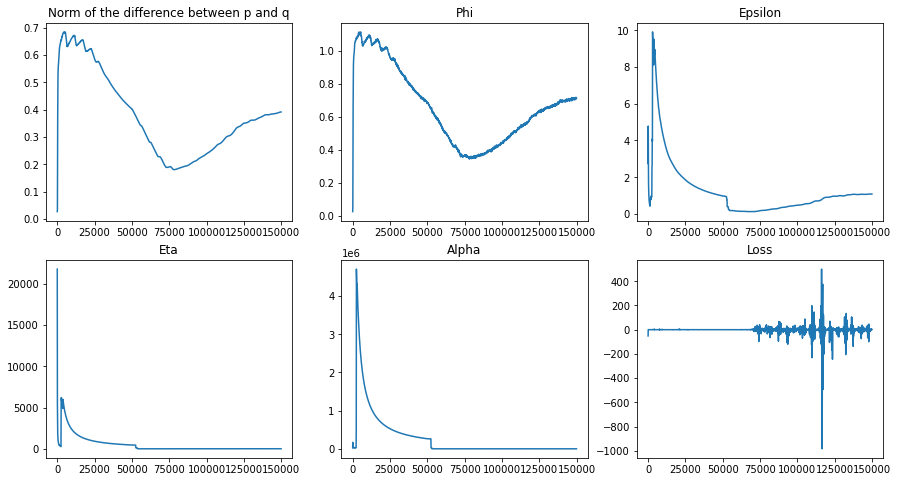

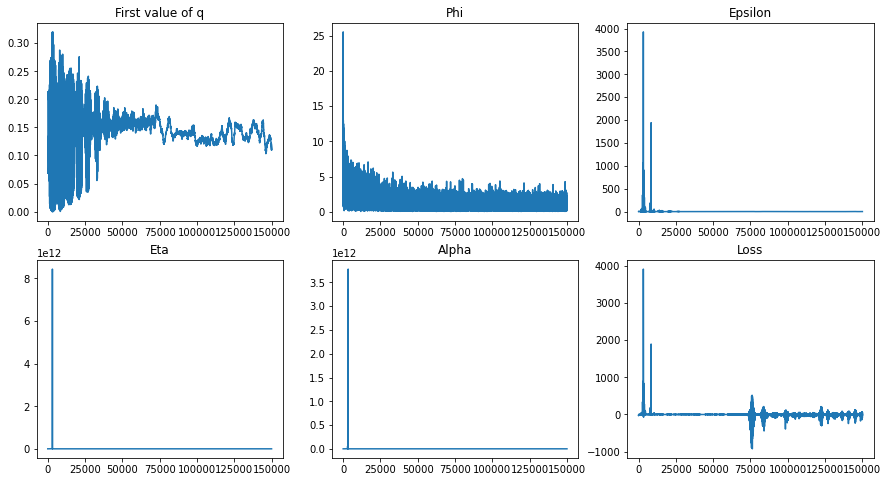


 


 	 EXP THRESHOLD 0.30000000000000004 
 
 

epoch 0: 
 	 epsilon_=1.3205820322036743 and grad = 1.0 and lr = 0.011664999999999816 
 	 eta_=9.990045547485352 and grad = -1.0 and lr = 0.011664999999999816 
 	 alpha_=10.010045051574707 and grad = 1.0 and lr = 0.011664999999999816 
 	 s_=tensor([-1.5512, -1.7335, -2.2178, -3.3809, -2.4466, -3.4275, -2.3862, -2.5685,
        -3.9956, -6.2782, -4.1960, -6.2962, -3.1846, -4.3478, -4.1474, -6.4300,
        -5.4729, -6.6124, -3.4275, -4.4083, -4.3618, -6.4620, -5.4869, -6.6263],
       requires_grad=True)
 	 q2=tensor([0.2011, 0.1701, 0.1101, 0.0356, 0.0885, 0.0341, 0.0937, 0.0787, 0.0194,
        0.0020, 0.0159, 0.0019, 0.0432, 0.0137, 0.0167, 0.0017, 0.0044, 0.0014,
        0.0341, 0.0129, 0.0135, 0.0016, 0.0043, 0.0014],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 1.0000,  1.0000, -0.6549, -0.2573, -0.5922, -0.2727, -0.7435, -0.5223,
        -0.1462, -0.0148, -0.1235, -0.0145, -0.3375, -0.1030, -0.1291, -0.0127,
      

epoch 10500: 
 	 epsilon_=0.052339423447847366 and grad = -0.0343221090734005 and lr = 1.257917499999999 
 	 eta_=0.40495336055755615 and grad = 0.20678381621837616 and lr = 1.257917499999999 
 	 alpha_=2.087291717529297 and grad = -0.005909103900194168 and lr = 1.257917499999999 
 	 s_=tensor([ 0.6799,  0.5549,  0.1147, -0.3016,  0.3137, -0.0774,  0.2332,  0.3163,
        -0.3242, -0.5704, -0.1307, -0.4328,  0.0357, -0.2902, -0.3567, -0.5036,
        -0.3574, -0.4368, -0.1756, -0.0864, -0.1923, -0.4992, -0.4260, -0.3577],
       requires_grad=True)
 	 q2=tensor([0.0675, 0.0621, 0.0454, 0.0356, 0.0515, 0.0431, 0.0487, 0.0529, 0.0362,
        0.0323, 0.0405, 0.0331, 0.0461, 0.0379, 0.0347, 0.0310, 0.0368, 0.0360,
        0.0400, 0.0421, 0.0398, 0.0345, 0.0359, 0.0362],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 0.0151,  0.0161,  0.0132, -0.0060,  0.0144, -0.0070,  0.0121,  0.0133,
        -0.0054, -0.0048, -0.0056, -0.0037, -0.0048, -0.0045, -0.0059, -

epoch 21000: 
 	 epsilon_=0.010975395329296589 and grad = -0.021106265485286713 and lr = 0.6341668749999998 
 	 eta_=0.0005220721941441298 and grad = 0.000498430454172194 and lr = 0.6341668749999998 
 	 alpha_=4.273550510406494 and grad = 3.424092210480012e-05 and lr = 0.6341668749999998 
 	 s_=tensor([ 3.5956,  2.3146,  2.3043, -0.0624,  0.0343, -0.5326,  0.5323,  0.7629,
        -0.1099,  0.7986, -0.5484,  0.8025, -0.0969, -0.3994, -0.6739,  0.7375,
         0.8493,  0.6713, -0.1915, -0.3237, -0.0604,  0.6813,  0.8501,  0.7543],
       requires_grad=True)
 	 q2=tensor([0.1430, 0.0954, 0.0930, 0.0252, 0.0276, 0.0170, 0.0408, 0.0447, 0.0223,
        0.0454, 0.0156, 0.0458, 0.0246, 0.0158, 0.0133, 0.0453, 0.0464, 0.0436,
        0.0222, 0.0171, 0.0214, 0.0433, 0.0463, 0.0449],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 2.9972e-05,  2.6130e-05,  3.0193e-05,  1.5090e-05,  1.5959e-05,
         9.8812e-06,  2.0583e-05,  2.5454e-05, -1.7994e-05, -2.8243e-05

epoch 31500: 
 	 epsilon_=0.04031478613615036 and grad = -0.01722167804837227 and lr = 0.08809890625000007 
 	 eta_=0.6237567663192749 and grad = 0.19741304218769073 and lr = 0.08809890625000007 
 	 alpha_=2.840775966644287 and grad = -0.028827033936977386 and lr = 0.08809890625000007 
 	 s_=tensor([ 1.7742,  1.6678,  1.5817, -0.2575,  1.1827, -0.3244,  1.2900,  0.9208,
        -0.9047, -1.0745, -0.8687, -1.0909,  0.0121, -0.8402, -0.8885, -1.0981,
        -1.0449, -1.1095, -0.3342, -0.9247, -0.8801, -1.0764, -1.0803, -1.1606],
       requires_grad=True)
 	 q2=tensor([0.1158, 0.1106, 0.1055, 0.0349, 0.0881, 0.0329, 0.0919, 0.0757, 0.0206,
        0.0181, 0.0213, 0.0178, 0.0418, 0.0222, 0.0209, 0.0178, 0.0185, 0.0176,
        0.0325, 0.0207, 0.0214, 0.0182, 0.0181, 0.0169],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 0.0222,  0.0250,  0.0456, -0.0181, -0.0398, -0.0216,  0.0266,  0.0152,
        -0.0114, -0.0094, -0.0123, -0.0103,  0.0197, -0.0160, -0.01

epoch 42000: 
 	 epsilon_=0.09716354310512543 and grad = -0.022866129875183105 and lr = 0.010013007812500016 
 	 eta_=0.8543424606323242 and grad = 0.005361706018447876 and lr = 0.010013007812500016 
 	 alpha_=2.187488079071045 and grad = 0.023633509874343872 and lr = 0.010013007812500016 
 	 s_=tensor([ 2.4951e+00,  2.2965e+00,  1.6337e+00, -2.6711e-01,  1.1756e+00,
        -3.2504e-01,  1.2904e+00,  9.3492e-01, -1.0202e+00, -1.4192e+00,
        -1.2495e+00, -1.4257e+00, -5.7623e-04, -1.4150e+00, -1.1923e+00,
        -1.4177e+00, -1.4350e+00, -1.4260e+00, -3.2771e-01, -1.4406e+00,
        -1.4187e+00, -1.4173e+00, -1.4385e+00, -1.4276e+00],
       requires_grad=True)
 	 q2=tensor([0.1554, 0.1444, 0.1093, 0.0344, 0.0872, 0.0328, 0.0926, 0.0764, 0.0186,
        0.0131, 0.0152, 0.0130, 0.0418, 0.0131, 0.0160, 0.0131, 0.0129, 0.0130,
        0.0327, 0.0128, 0.0131, 0.0131, 0.0128, 0.0130],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0019,  0.0480,  0.0147, -0.0274, -0

epoch 52500: 
 	 epsilon_=0.109769307076931 and grad = -0.02241944521665573 and lr = 0.019749355468749993 
 	 eta_=0.8970787525177002 and grad = 0.12445509433746338 and lr = 0.019749355468749993 
 	 alpha_=1.8942954540252686 and grad = -0.06405843794345856 and lr = 0.019749355468749993 
 	 s_=tensor([ 2.7940,  2.2391,  1.5377, -0.2759,  1.1339, -0.3287,  1.2460,  0.9447,
        -1.0230, -1.5290, -1.2400, -1.5170, -0.0133, -1.3915, -1.1991, -1.5058,
        -1.5317, -1.5084, -0.3282, -1.4740, -1.4352, -1.5069, -1.4757, -1.5166],
       requires_grad=True)
 	 q2=tensor([0.1727, 0.1418, 0.1051, 0.0342, 0.0855, 0.0327, 0.0907, 0.0772, 0.0186,
        0.0119, 0.0154, 0.0120, 0.0417, 0.0135, 0.0159, 0.0121, 0.0119, 0.0121,
        0.0329, 0.0125, 0.0130, 0.0121, 0.0124, 0.0120],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([-0.0175,  0.0568,  0.0339,  0.0038, -0.0105,  0.0100,  0.0591,  0.0070,
        -0.0262, -0.0185, -0.0224, -0.0150,  0.0005, -0.0162,  0.0

epoch 63000: 
 	 epsilon_=0.1420964151620865 and grad = -0.019064411520957947 and lr = 0.014876303710937499 
 	 eta_=1.0099878311157227 and grad = 0.38489168882369995 and lr = 0.014876303710937499 
 	 alpha_=1.3590922355651855 and grad = -0.33236390352249146 and lr = 0.014876303710937499 
 	 s_=tensor([ 2.5646,  2.4872,  1.5844, -0.2918,  1.1480, -0.3376,  1.2521,  0.9345,
        -1.0274, -1.5776, -1.2597, -1.5866, -0.0114, -1.4121, -1.2057, -1.5960,
        -1.6146, -1.5814, -0.3408, -1.4989, -1.4440, -1.5885, -1.5958, -1.5818],
       requires_grad=True)
 	 q2=tensor([0.1606, 0.1563, 0.1079, 0.0340, 0.0868, 0.0328, 0.0916, 0.0769, 0.0186,
        0.0114, 0.0152, 0.0113, 0.0418, 0.0133, 0.0160, 0.0113, 0.0110, 0.0114,
        0.0328, 0.0123, 0.0129, 0.0113, 0.0112, 0.0114],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-0.0441,  0.0634, -0.0189,  0.0082,  0.0039,  0.0284,  0.0755,  0.0302,
        -0.0262, -0.0164, -0.0199, -0.0178,  0.0071, -0.0178, -0.0238, -0.0170,

epoch 73500: 
 	 epsilon_=0.301888108253479 and grad = -0.012228578329086304 and lr = 0.010610147705078126 
 	 eta_=1.3063037395477295 and grad = -0.24949264526367188 and lr = 0.010610147705078126 
 	 alpha_=0.0839579626917839 and grad = 0.2482585906982422 and lr = 0.010610147705078126 
 	 s_=tensor([ 2.8322,  2.0571,  1.5966, -0.4055,  1.0448, -0.4204,  1.2600,  0.8114,
        -1.0403, -1.6019, -1.2847, -1.5877, -0.0538, -1.4657, -1.2360, -1.3887,
        -1.6245, -1.6794, -0.4173, -1.5073, -1.4650, -1.6236, -1.5677, -1.6223],
       requires_grad=True)
 	 q2=tensor([0.1807, 0.1362, 0.1115, 0.0320, 0.0843, 0.0316, 0.0945, 0.0738, 0.0189,
        0.0115, 0.0153, 0.0117, 0.0417, 0.0130, 0.0160, 0.0139, 0.0113, 0.0107,
        0.0317, 0.0125, 0.0130, 0.0113, 0.0119, 0.0113],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 1.0000, -0.0313, -0.7736, -0.1429, -0.2241,  0.0098, -0.7975,  0.2456,
        -0.0072, -0.0263, -0.0483, -0.0185,  0.0146, -0.0245, -0.0481, -0.0180,
 

epoch 84000: 
 	 epsilon_=0.832895815372467 and grad = 7.164478302001953e-05 and lr = 0.010000101623535157 
 	 eta_=2.3020756244659424 and grad = 1.0 and lr = 0.010000101623535157 
 	 alpha_=0.02221699431538582 and grad = -1.0 and lr = 0.010000101623535157 
 	 s_=tensor([ 1.7882,  1.1309,  0.8859, -0.4859,  0.8006, -0.6180,  0.7549,  0.4880,
        -1.2095, -1.3905, -1.2661, -1.4263, -0.2553, -1.3899, -1.1238, -1.3540,
        -1.3348, -1.4001, -0.6366, -1.4715, -1.5368, -1.6404, -1.5281, -1.4571],
       requires_grad=True)
 	 q2=tensor([0.1507, 0.1095, 0.0956, 0.0372, 0.0908, 0.0335, 0.0884, 0.0750, 0.0203,
        0.0172, 0.0193, 0.0167, 0.0445, 0.0173, 0.0218, 0.0178, 0.0181, 0.0171,
        0.0329, 0.0160, 0.0151, 0.0137, 0.0152, 0.0162],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([-1.0000, -1.0000, -1.0000, -0.6008,  1.0000, -0.2377,  1.0000,  1.0000,
        -1.0000,  1.0000,  1.0000, -1.0000, -1.0000, -1.0000, -1.0000,  1.0000,
         1.0000,

epoch 96000: 
 	 epsilon_=0.2976246476173401 and grad = -0.00989753007888794 and lr = 0.01000002540588379 
 	 eta_=1.309438943862915 and grad = 1.0 and lr = 0.01000002540588379 
 	 alpha_=0.12023477256298065 and grad = -1.0 and lr = 0.01000002540588379 
 	 s_=tensor([ 1.6874,  0.9917,  1.1845, -0.5200,  0.8163, -0.5747,  0.9363,  0.5673,
        -1.2502, -1.2234, -1.3351, -1.2900, -0.2701, -1.3286, -1.0503, -1.1547,
        -1.2207, -1.0242, -0.5727, -1.4738, -1.3386, -1.3756, -1.3352, -1.1978],
       requires_grad=True)
 	 q2=tensor([0.1372, 0.0966, 0.1072, 0.0344, 0.0875, 0.0330, 0.0937, 0.0751, 0.0186,
        0.0191, 0.0173, 0.0180, 0.0419, 0.0174, 0.0222, 0.0202, 0.0191, 0.0227,
        0.0331, 0.0152, 0.0172, 0.0167, 0.0173, 0.0195],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 1.0000, -0.9432,  0.4028,  0.3173, -1.0000,  0.4436, -0.3680,  0.7525,
        -0.0049,  0.1724, -0.1135,  0.1044,  0.1040, -0.1891,  0.0778,  0.0790,
        -0.0589, -0.

epoch 106500: 
 	 epsilon_=0.5592507719993591 and grad = -0.003585338592529297 and lr = 0.010019041709899902 
 	 eta_=1.738680124282837 and grad = -1.0 and lr = 0.010019041709899902 
 	 alpha_=0.04170510172843933 and grad = 1.0 and lr = 0.010019041709899902 
 	 s_=tensor([ 2.1159,  0.2326,  1.0082, -0.5867,  0.8725, -0.6528,  0.7736,  0.3739,
        -1.2160, -1.4800, -1.4282, -1.4882, -0.3014, -1.4254, -1.2963, -0.8496,
        -1.1231, -0.9403, -0.6107, -1.5725, -1.5340, -1.4245, -1.4018, -1.3137],
       requires_grad=True)
 	 q2=tensor([0.1736, 0.0636, 0.1026, 0.0344, 0.0952, 0.0326, 0.0897, 0.0698, 0.0201,
        0.0159, 0.0167, 0.0159, 0.0431, 0.0168, 0.0188, 0.0277, 0.0220, 0.0256,
        0.0337, 0.0147, 0.0152, 0.0168, 0.0171, 0.0185],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-1.0000, -0.9958, -1.0000,  1.0000,  1.0000,  0.4318,  0.3505,  1.0000,
         0.3758,  0.3447,  0.0658,  0.0269,  0.1105,  0.2066,  0.0249,  0.0342,
        -0.5529,  0.3894,  0.2

epoch 118500: 
 	 epsilon_=0.2916947603225708 and grad = -0.01139068603515625 and lr = 0.010004760427474975 
 	 eta_=1.2930690050125122 and grad = -1.0 and lr = 0.010004760427474975 
 	 alpha_=0.09841623157262802 and grad = 1.0 and lr = 0.010004760427474975 
 	 s_=tensor([ 1.7527,  1.0622,  1.1987, -0.5228,  0.6195, -0.5617,  0.8589,  0.3993,
        -1.2110, -1.4009, -1.3687, -1.3863, -0.2561, -0.9066, -1.1760, -0.8269,
        -1.0556, -0.4178, -0.5702, -1.5728, -1.5135, -1.2086, -1.4012, -1.3156],
       requires_grad=True)
 	 q2=tensor([0.1400, 0.0995, 0.1071, 0.0341, 0.0769, 0.0330, 0.0887, 0.0668, 0.0191,
        0.0161, 0.0166, 0.0163, 0.0420, 0.0248, 0.0197, 0.0266, 0.0218, 0.0370,
        0.0328, 0.0138, 0.0146, 0.0191, 0.0161, 0.0174],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.9414, -0.4467,  0.3440,  0.2291,  0.1272, -0.1338, -1.0000,  0.3367,
        -0.0434, -0.1171, -0.1345, -0.0246, -0.1951, -0.0481, -0.0757, -0.0546,
        -0.0615,  0.2248,  0.1

epoch 129000: 
 	 epsilon_=0.32407650351524353 and grad = -0.011585831642150879 and lr = 0.010002381007671356 
 	 eta_=1.3400747776031494 and grad = -1.0 and lr = 0.010002381007671356 
 	 alpha_=0.13239699602127075 and grad = 1.0 and lr = 0.010002381007671356 
 	 s_=tensor([ 1.4271,  1.1466,  1.2470, -0.5127,  0.8244, -0.5632,  0.9158,  0.6292,
        -1.2419, -1.2905, -1.4280, -1.3918, -0.2696, -1.2089, -1.2746, -0.9010,
        -1.0451, -0.8700, -0.5903, -1.3939, -1.4102, -1.3912, -1.2656, -1.2232],
       requires_grad=True)
 	 q2=tensor([0.1206, 0.1046, 0.1102, 0.0345, 0.0874, 0.0332, 0.0922, 0.0778, 0.0187,
        0.0179, 0.0158, 0.0163, 0.0418, 0.0192, 0.0181, 0.0251, 0.0222, 0.0258,
        0.0325, 0.0163, 0.0161, 0.0164, 0.0183, 0.0190],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 7.1867e-01, -6.0162e-01,  1.0000e+00, -9.5915e-02,  1.0119e-01,
        -2.6106e-01, -8.1361e-01,  6.1325e-02, -1.0494e-01,  4.1974e-02,
        -1.3061e-03,  2.0477e-02, -1.2833e

epoch 139500: 
 	 epsilon_=0.2512930631637573 and grad = -0.012604981660842896 and lr = 0.01000029792368412 
 	 eta_=1.2299346923828125 and grad = -0.8544588088989258 and lr = 0.01000029792368412 
 	 alpha_=0.14252156019210815 and grad = 1.0 and lr = 0.01000029792368412 
 	 s_=tensor([ 1.7383,  1.0239,  1.4438, -0.3852,  0.6332, -0.4452,  1.1254,  0.5815,
        -0.9775, -0.8111, -1.2526, -1.0447, -0.1127, -1.1119, -0.8788, -0.3483,
        -0.7791, -0.6121, -0.4344, -1.3258, -1.1968, -1.0450, -1.1728, -1.0090],
       requires_grad=True)
 	 q2=tensor([0.1256, 0.0880, 0.1095, 0.0343, 0.0701, 0.0327, 0.0929, 0.0678, 0.0211,
        0.0243, 0.0166, 0.0199, 0.0422, 0.0188, 0.0230, 0.0353, 0.0250, 0.0286,
        0.0330, 0.0156, 0.0174, 0.0199, 0.0178, 0.0205],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 0.3189, -0.0254, -0.1690,  0.0104,  0.0790, -0.0008, -0.1225,  0.0740,
        -0.0130, -0.0201, -0.0156, -0.0132, -0.0281, -0.0106, -0.0229, -0.0224,
  

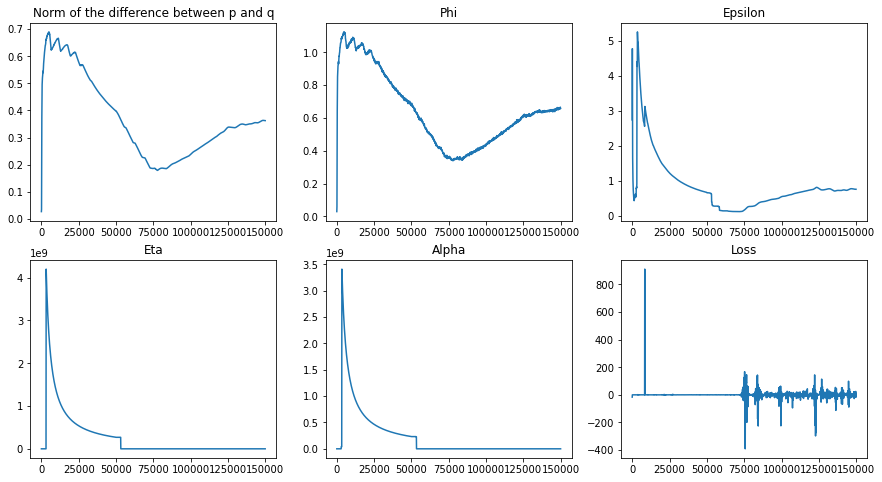

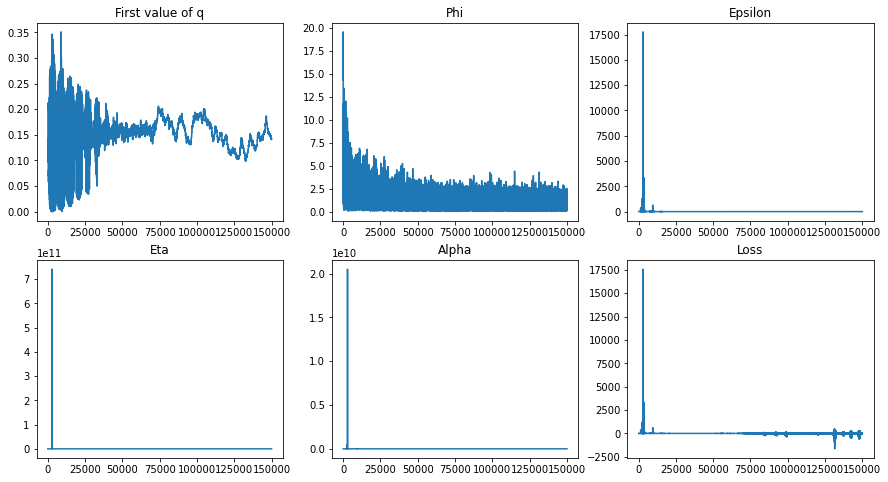


 


 	 EXP THRESHOLD 0.35000000000000003 
 
 

epoch 0: 
 	 epsilon_=1.3205820322036743 and grad = 1.0 and lr = 0.011664999999999816 
 	 eta_=9.990045547485352 and grad = -1.0 and lr = 0.011664999999999816 
 	 alpha_=10.010045051574707 and grad = 1.0 and lr = 0.011664999999999816 
 	 s_=tensor([-1.5512, -1.7335, -2.2178, -3.3809, -2.4466, -3.4275, -2.3862, -2.5685,
        -3.9956, -6.2782, -4.1960, -6.2962, -3.1846, -4.3478, -4.1474, -6.4300,
        -5.4729, -6.6124, -3.4275, -4.4083, -4.3618, -6.4620, -5.4869, -6.6263],
       requires_grad=True)
 	 q2=tensor([0.2011, 0.1701, 0.1101, 0.0356, 0.0885, 0.0341, 0.0937, 0.0787, 0.0194,
        0.0020, 0.0159, 0.0019, 0.0432, 0.0137, 0.0167, 0.0017, 0.0044, 0.0014,
        0.0341, 0.0129, 0.0135, 0.0016, 0.0043, 0.0014],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 1.0000,  1.0000, -0.8966, -0.2485, -0.6911, -0.2595, -0.6170, -0.7599,
        -0.1253, -0.0139, -0.1065, -0.0134, -0.2426, -0.0870, -0.1053, -0.0117,
      

epoch 10500: 
 	 epsilon_=0.06604963541030884 and grad = -0.036708660423755646 and lr = 1.257917499999999 
 	 eta_=0.5607426166534424 and grad = 0.1041710376739502 and lr = 1.257917499999999 
 	 alpha_=3.042306900024414 and grad = 0.05795838683843613 and lr = 1.257917499999999 
 	 s_=tensor([ 0.6787,  0.7529,  0.7195, -0.3155,  0.5851, -0.4436,  0.5533,  0.6695,
        -0.6253, -1.0641, -0.4467, -0.6570, -0.1090, -0.5316, -0.4853, -0.7895,
        -0.8647, -0.6818, -0.4898, -0.4527, -0.5352, -0.5956, -0.5471, -0.8058],
       requires_grad=True)
 	 q2=tensor([0.0677, 0.0707, 0.0698, 0.0396, 0.0631, 0.0359, 0.0608, 0.0644, 0.0320,
        0.0237, 0.0347, 0.0295, 0.0452, 0.0347, 0.0360, 0.0313, 0.0306, 0.0318,
        0.0342, 0.0359, 0.0361, 0.0296, 0.0355, 0.0272],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0239,  0.0365,  0.0169, -0.0197,  0.0223, -0.0117,  0.0170,  0.0277,
        -0.0111, -0.0088, -0.0095, -0.0036, -0.0100, -0.0086, -0.0125, -0.0089,
        -0

epoch 21000: 
 	 epsilon_=0.024336371570825577 and grad = -0.02176862582564354 and lr = 0.6341668749999998 
 	 eta_=0.04041857272386551 and grad = 0.017501693218946457 and lr = 0.6341668749999998 
 	 alpha_=1.1342447996139526 and grad = 0.009647607803344727 and lr = 0.6341668749999998 
 	 s_=tensor([ 0.1660,  0.1293,  0.0714,  0.0062,  0.1008,  0.0104,  0.1105,  0.0947,
         0.0153,  0.0155, -0.0075,  0.1039, -0.0311, -0.0385, -0.0020,  0.0411,
        -0.0415, -0.0089, -0.0367, -0.0337, -0.0643, -0.0886,  0.0615,  0.0287],
       requires_grad=True)
 	 q2=tensor([0.0453, 0.0441, 0.0424, 0.0413, 0.0437, 0.0414, 0.0439, 0.0437, 0.0416,
        0.0405, 0.0415, 0.0428, 0.0399, 0.0403, 0.0412, 0.0423, 0.0395, 0.0408,
        0.0403, 0.0405, 0.0394, 0.0384, 0.0427, 0.0425],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0023,  0.0020,  0.0012, -0.0012,  0.0011, -0.0014,  0.0022,  0.0014,
         0.0010,  0.0014, -0.0025,  0.0005,  0.0008, -0.0005, -0.0006,  0.0003,
  

epoch 31500: 
 	 epsilon_=0.03916466608643532 and grad = -0.011405602097511292 and lr = 0.08809890625000007 
 	 eta_=0.7527039647102356 and grad = -0.12665632367134094 and lr = 0.08809890625000007 
 	 alpha_=2.7145745754241943 and grad = 0.1301831305027008 and lr = 0.08809890625000007 
 	 s_=tensor([ 1.7143,  1.7843,  1.6151, -0.3110,  1.0622, -0.3576,  1.2383,  0.8904,
        -0.9472, -1.1108, -0.9971, -1.1578, -0.0242, -1.1061, -0.9802, -1.1373,
        -1.2003, -1.1546, -0.3562, -1.1517, -1.0656, -1.1526, -1.0879, -1.0587],
       requires_grad=True)
 	 q2=tensor([0.1147, 0.1193, 0.1121, 0.0346, 0.0846, 0.0328, 0.0936, 0.0763, 0.0207,
        0.0180, 0.0200, 0.0172, 0.0427, 0.0182, 0.0203, 0.0175, 0.0165, 0.0173,
        0.0333, 0.0176, 0.0189, 0.0171, 0.0186, 0.0184],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0706,  0.0398, -0.0294, -0.0245,  0.0287,  0.0183, -0.0245,  0.0199,
        -0.0098, -0.0096, -0.0114, -0.0085, -0.0215, -0.0070, -0.0138, -0.0096,
  

epoch 42000: 
 	 epsilon_=0.10178857296705246 and grad = -0.02429431676864624 and lr = 0.010013007812500016 
 	 eta_=0.8569651246070862 and grad = 0.04609380662441254 and lr = 0.010013007812500016 
 	 alpha_=2.1998507976531982 and grad = -0.005892902612686157 and lr = 0.010013007812500016 
 	 s_=tensor([ 2.4193,  2.4233,  1.6327, -0.2701,  1.1721, -0.3321,  1.2890,  0.9546,
        -1.0234, -1.4629, -1.2492, -1.4600, -0.0027, -1.4147, -1.1970, -1.4806,
        -1.4613, -1.4862, -0.3256, -1.4765, -1.4344, -1.4769, -1.4699, -1.4713],
       requires_grad=True)
 	 q2=tensor([0.1516, 0.1518, 0.1094, 0.0343, 0.0872, 0.0327, 0.0927, 0.0774, 0.0185,
        0.0126, 0.0153, 0.0126, 0.0418, 0.0132, 0.0160, 0.0124, 0.0126, 0.0123,
        0.0329, 0.0124, 0.0129, 0.0124, 0.0125, 0.0125],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 0.0149,  0.0109,  0.0271,  0.0099,  0.0077,  0.0110,  0.0153,  0.0174,
         0.0060, -0.0154, -0.0181, -0.0154,  0.0174, -0.0145, -

epoch 52500: 
 	 epsilon_=0.09671831876039505 and grad = -0.023425541818141937 and lr = 0.019749355468749993 
 	 eta_=0.8455471992492676 and grad = 0.18954800069332123 and lr = 0.019749355468749993 
 	 alpha_=2.1869113445281982 and grad = -0.08844383805990219 and lr = 0.019749355468749993 
 	 s_=tensor([ 2.2753e+00,  2.5067e+00,  1.6377e+00, -2.6774e-01,  1.1745e+00,
        -3.3581e-01,  1.2941e+00,  9.5766e-01, -1.0204e+00, -1.4233e+00,
        -1.2509e+00, -1.4341e+00, -1.4879e-03, -1.4104e+00, -1.1961e+00,
        -1.4369e+00, -1.4576e+00, -1.4386e+00, -3.2889e-01, -1.4410e+00,
        -1.4262e+00, -1.4854e+00, -1.4608e+00, -1.4491e+00],
       requires_grad=True)
 	 q2=tensor([0.1434, 0.1569, 0.1095, 0.0344, 0.0873, 0.0326, 0.0928, 0.0774, 0.0186,
        0.0130, 0.0152, 0.0129, 0.0418, 0.0132, 0.0160, 0.0129, 0.0127, 0.0129,
        0.0328, 0.0129, 0.0130, 0.0124, 0.0126, 0.0127],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0228,  0.0153,  0.0242, -0.0330, -0

epoch 63000: 
 	 epsilon_=0.1499049961566925 and grad = -0.017590060830116272 and lr = 0.014876303710937499 
 	 eta_=1.0348259210586548 and grad = -0.1768304705619812 and lr = 0.014876303710937499 
 	 alpha_=1.3327122926712036 and grad = 0.15578866004943848 and lr = 0.014876303710937499 
 	 s_=tensor([ 2.2390,  2.7209,  1.6222, -0.2820,  1.1719, -0.3333,  1.2791,  0.9371,
        -1.0290, -1.5800, -1.2583, -1.5575, -0.0110, -1.4309, -1.1940, -1.6038,
        -1.6108, -1.5848, -0.3355, -1.4904, -1.4479, -1.5825, -1.5530, -1.6007],
       requires_grad=True)
 	 q2=tensor([0.1423, 0.1697, 0.1098, 0.0343, 0.0878, 0.0328, 0.0926, 0.0772, 0.0186,
        0.0114, 0.0152, 0.0116, 0.0418, 0.0131, 0.0161, 0.0112, 0.0111, 0.0113,
        0.0327, 0.0124, 0.0129, 0.0114, 0.0117, 0.0112],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 0.0221,  0.0152,  0.0055,  0.0099, -0.0630,  0.0201,  0.0619,  0.0191,
        -0.0198, -0.0144, -0.0156, -0.0139,  0.0295, -0.0183, -0.

epoch 73500: 
 	 epsilon_=0.21926884353160858 and grad = -0.015344366431236267 and lr = 0.010610147705078126 
 	 eta_=1.1674060821533203 and grad = -0.22099757194519043 and lr = 0.010610147705078126 
 	 alpha_=0.6612691879272461 and grad = 0.19343233108520508 and lr = 0.010610147705078126 
 	 s_=tensor([ 2.8358,  2.3688,  1.5884, -0.2878,  1.0897, -0.3443,  1.2715,  0.9191,
        -1.0420, -1.6929, -1.2607, -1.7359, -0.0206, -1.4318, -1.2089, -1.7388,
        -1.7354, -1.7338, -0.3689, -1.5004, -1.4395, -1.7182, -1.7020, -1.7304],
       requires_grad=True)
 	 q2=tensor([0.1773, 0.1503, 0.1088, 0.0342, 0.0846, 0.0328, 0.0928, 0.0767, 0.0185,
        0.0104, 0.0153, 0.0099, 0.0417, 0.0131, 0.0160, 0.0099, 0.0099, 0.0099,
        0.0321, 0.0123, 0.0130, 0.0101, 0.0103, 0.0100],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 5.3344e-02,  3.9258e-02,  7.5911e-03,  3.7737e-05, -4.4665e-02,
        -5.1612e-02,  7.2853e-02, -2.6548e-02,  1.6835e-02, -1.7352e-02,
        -2.5

epoch 84000: 
 	 epsilon_=0.6419268250465393 and grad = -0.0013734698295593262 and lr = 0.010000101623535157 
 	 eta_=1.8973368406295776 and grad = 1.0 and lr = 0.010000101623535157 
 	 alpha_=0.0482633039355278 and grad = -1.0 and lr = 0.010000101623535157 
 	 s_=tensor([ 2.5576,  2.0420,  1.2711, -0.4787,  0.8351, -0.5349,  0.9459,  0.5395,
        -1.1577, -1.8189, -1.3400, -1.7820, -0.2007, -1.5619, -1.3635, -1.7400,
        -1.8200, -1.7862, -0.5271, -1.6464, -1.6060, -1.8222, -1.8816, -1.7317],
       requires_grad=True)
 	 q2=tensor([0.1840, 0.1513, 0.1064, 0.0337, 0.0835, 0.0323, 0.0891, 0.0698, 0.0192,
        0.0105, 0.0162, 0.0109, 0.0417, 0.0133, 0.0160, 0.0113, 0.0105, 0.0108,
        0.0325, 0.0124, 0.0128, 0.0105, 0.0100, 0.0114],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 1.0000, -0.0686, -1.0000,  0.5733,  1.0000,  0.4707, -1.0000, -0.1558,
        -0.2282,  0.0280,  0.3428, -0.0397, -0.7876,  0.0109, -0.1913, -0.0057,
         0.0468

epoch 96000: 
 	 epsilon_=0.30444571375846863 and grad = -0.007902055978775024 and lr = 0.01000002540588379 
 	 eta_=1.3281360864639282 and grad = 1.0 and lr = 0.01000002540588379 
 	 alpha_=0.07064646482467651 and grad = -1.0 and lr = 0.01000002540588379 
 	 s_=tensor([ 1.5978,  1.1291,  1.3382, -0.4304,  0.6319, -0.5530,  1.0217,  0.6902,
        -1.0420, -1.1498, -1.2278, -1.3355, -0.1940, -1.0987, -0.9712, -1.0502,
        -0.9634, -1.0415, -0.4943, -1.3260, -1.3004, -1.0952, -1.2213, -0.9031],
       requires_grad=True)
 	 q2=tensor([0.1251, 0.0989, 0.1102, 0.0352, 0.0743, 0.0319, 0.0933, 0.0770, 0.0212,
        0.0193, 0.0180, 0.0164, 0.0422, 0.0202, 0.0225, 0.0211, 0.0227, 0.0212,
        0.0335, 0.0165, 0.0169, 0.0203, 0.0182, 0.0239],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-7.6717e-01,  1.0000e+00,  6.6624e-01, -1.9035e-01, -1.0000e+00,
         1.3517e-01,  1.0000e+00, -5.4003e-01,  9.5757e-04,  3.2934e-02,
        -9.9595e-04, -2.3627e-02, -1.3101e-01,

epoch 108000: 
 	 epsilon_=0.2889956831932068 and grad = -0.01205974817276001 and lr = 0.010000006351470947 
 	 eta_=1.2889293432235718 and grad = 1.0 and lr = 0.010000006351470947 
 	 alpha_=0.08540864288806915 and grad = -1.0 and lr = 0.010000006351470947 
 	 s_=tensor([ 1.8167,  0.5422,  1.2112, -0.4902,  0.8563, -0.4951,  0.9598,  0.6789,
        -1.1204, -1.1023, -1.3968, -1.2162, -0.1085, -1.2426, -1.0577, -0.5071,
        -0.8719, -0.8508, -0.5401, -1.3994, -1.4055, -1.4318, -1.2906, -1.1942],
       requires_grad=True)
 	 q2=tensor([0.1403, 0.0714, 0.1050, 0.0341, 0.0863, 0.0340, 0.0916, 0.0778, 0.0201,
        0.0205, 0.0158, 0.0185, 0.0457, 0.0181, 0.0213, 0.0337, 0.0250, 0.0254,
        0.0327, 0.0157, 0.0156, 0.0153, 0.0173, 0.0189],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-0.1642,  0.1897, -0.1297, -0.0936,  0.0153, -0.3443,  1.0000, -1.0000,
         0.0520, -0.0450, -0.1047, -0.1465,  0.6345,  0.0840,  0.0296, -0.0735,
         0.1343,  0.2296,  0.0

epoch 118500: 
 	 epsilon_=1.0683484077453613 and grad = 0.00610196590423584 and lr = 0.010004760427474975 
 	 eta_=2.9191386699676514 and grad = -1.0 and lr = 0.010004760427474975 
 	 alpha_=0.014673312194645405 and grad = 1.0 and lr = 0.010004760427474975 
 	 s_=tensor([ 2.2803e+00,  7.1821e-01,  1.2193e+00, -3.2039e-01,  6.3347e-01,
        -5.4838e-01,  1.0112e+00,  6.4236e-01, -1.0265e+00, -1.1931e+00,
        -1.1658e+00, -1.2347e+00,  2.5343e-04, -1.1483e+00, -9.1597e-01,
        -8.9892e-01, -1.1380e+00, -9.1228e-01, -3.7128e-01, -1.2460e+00,
        -1.2618e+00, -1.0696e+00, -1.1407e+00, -1.2451e+00],
       requires_grad=True)
 	 q2=tensor([0.1625, 0.0763, 0.1011, 0.0373, 0.0724, 0.0312, 0.0903, 0.0728, 0.0209,
        0.0181, 0.0185, 0.0174, 0.0474, 0.0188, 0.0230, 0.0233, 0.0190, 0.0231,
        0.0359, 0.0173, 0.0170, 0.0201, 0.0189, 0.0173],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 1.0000, -1.0000, -1.0000,  1.0000, -1.0000, -1.0000, -1.0000, -1.0000

epoch 129000: 
 	 epsilon_=0.7128990888595581 and grad = 0.0015257596969604492 and lr = 0.010002381007671356 
 	 eta_=2.0447893142700195 and grad = 1.0 and lr = 0.010002381007671356 
 	 alpha_=0.029456866905093193 and grad = -1.0 and lr = 0.010002381007671356 
 	 s_=tensor([ 2.0947,  0.4123,  1.1509, -0.4582,  0.4813, -0.6654,  0.9491,  0.3858,
        -1.0740, -1.0962, -1.4061, -1.6048, -0.1668, -1.1631, -1.1621, -0.9829,
        -1.1663, -0.6353, -0.6286, -1.6045, -1.5036, -1.4735, -1.5341, -1.4013],
       requires_grad=True)
 	 q2=tensor([0.1675, 0.0697, 0.1080, 0.0372, 0.0729, 0.0314, 0.0967, 0.0685, 0.0223,
        0.0218, 0.0166, 0.0139, 0.0465, 0.0206, 0.0206, 0.0241, 0.0206, 0.0323,
        0.0324, 0.0139, 0.0152, 0.0156, 0.0148, 0.0167],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-1.0000,  1.0000,  1.0000, -1.0000, -1.0000, -1.0000,  1.0000,  1.0000,
        -1.0000,  0.6605, -1.0000, -0.6921, -1.0000, -1.0000,  0.8379, -0.6917,
        -1.0000, -1.0000, -1

epoch 141000: 
 	 epsilon_=0.49273690581321716 and grad = -0.00472104549407959 and lr = 0.01000059525191784 
 	 eta_=1.6218183040618896 and grad = 1.0 and lr = 0.01000059525191784 
 	 alpha_=0.05905911698937416 and grad = -1.0 and lr = 0.01000059525191784 
 	 s_=tensor([ 1.8242,  0.1294,  1.1376, -0.4800,  0.6403, -0.6473,  0.7971,  0.5158,
        -1.2763, -1.1585, -1.5182, -1.5116, -0.3307, -1.3003, -1.2569, -0.9728,
        -1.1095, -0.7156, -0.6285, -1.5465, -1.4088, -1.4196, -1.3642, -1.2227],
       requires_grad=True)
 	 q2=tensor([0.1548, 0.0595, 0.1110, 0.0377, 0.0833, 0.0330, 0.0915, 0.0771, 0.0193,
        0.0214, 0.0155, 0.0156, 0.0424, 0.0189, 0.0196, 0.0251, 0.0223, 0.0312,
        0.0335, 0.0151, 0.0171, 0.0170, 0.0178, 0.0202],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-1.0000,  1.0000, -1.0000,  0.6227,  1.0000, -0.6865,  1.0000, -0.5782,
        -0.0705, -0.3760, -0.0805, -0.0073, -0.4553,  0.1508,  0.3196,  0.3986,
        -0.1836, -0.3550,  0.187

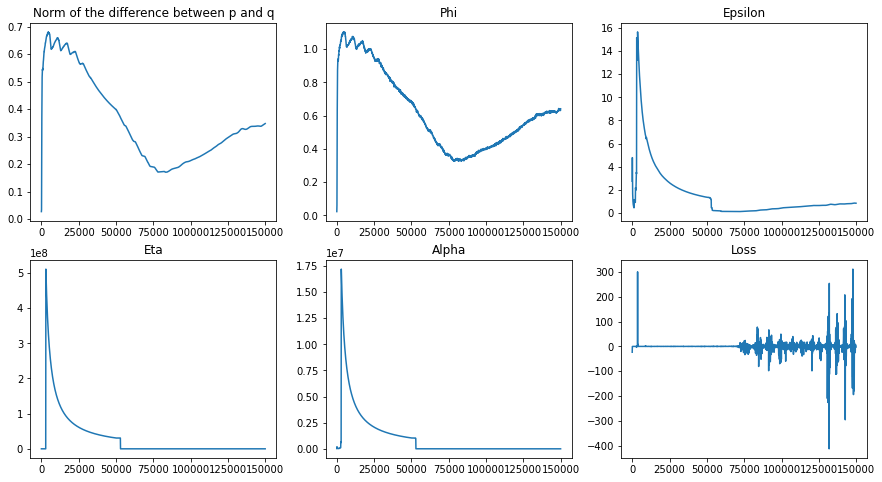

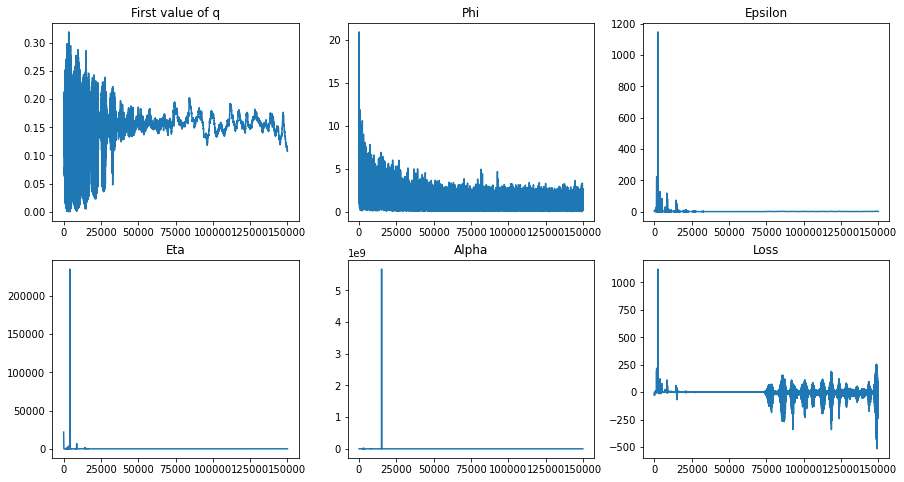


 


 	 EXP THRESHOLD 0.4 
 
 

epoch 0: 
 	 epsilon_=1.3139928579330444 and grad = 1.0 and lr = 0.0026664999999998166 
 	 eta_=9.999045372009277 and grad = -1.0 and lr = 0.0026664999999998166 
 	 alpha_=10.001046180725098 and grad = 0.7192694544792175 and lr = 0.0026664999999998166 
 	 s_=tensor([-1.5602, -1.7425, -2.2088, -3.3719, -2.4376, -3.4185, -2.3772, -2.5595,
        -3.9866, -6.2872, -4.1870, -6.3052, -3.1756, -4.3388, -4.1384, -6.4390,
        -5.4819, -6.6214, -3.4185, -4.3993, -4.3528, -6.4710, -5.4959, -6.6353],
       requires_grad=True)
 	 q2=tensor([0.2011, 0.1701, 0.1101, 0.0356, 0.0885, 0.0341, 0.0937, 0.0787, 0.0194,
        0.0020, 0.0159, 0.0019, 0.0432, 0.0137, 0.0167, 0.0017, 0.0044, 0.0014,
        0.0341, 0.0129, 0.0135, 0.0016, 0.0043, 0.0014],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 1.0000,  1.0000, -0.6997, -0.2848, -0.9301, -0.2717, -0.8882, -0.7676,
        -0.1776, -0.0163, -0.1318, -0.0159, -0.4466, -0.1113, -0.1408, -0.0140,
    

epoch 10500: 
 	 epsilon_=0.002742221811786294 and grad = -0.0022520781494677067 and lr = 1.250041749999999 
 	 eta_=0.004619470797479153 and grad = -0.009050118736922741 and lr = 1.250041749999999 
 	 alpha_=0.3315088748931885 and grad = 0.01132025383412838 and lr = 1.250041749999999 
 	 s_=tensor([-9.2473e-01, -9.8858e-01, -7.9691e-02,  1.1322e-01,  3.9141e-02,
        -6.4438e-04, -2.8583e-01, -2.2049e-01, -1.7555e-01, -3.1511e-01,
        -4.0146e-01, -3.1886e-01,  1.6504e-01,  8.7323e-02, -2.7773e-01,
        -3.0177e-01,  1.1110e-01, -8.9061e-02,  3.4834e-02, -1.4124e-01,
        -3.3126e-01, -2.2747e-01,  1.9758e-01, -7.5783e-02],
       requires_grad=True)
 	 q2=tensor([0.0204, 0.0207, 0.0431, 0.0536, 0.0480, 0.0483, 0.0373, 0.0387, 0.0412,
        0.0370, 0.0343, 0.0368, 0.0536, 0.0494, 0.0378, 0.0378, 0.0563, 0.0408,
        0.0498, 0.0411, 0.0357, 0.0378, 0.0590, 0.0417],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 2.5662e-04,  1.9111e-04,  2.4770e-04, -2.

epoch 21000: 
 	 epsilon_=0.0012394767254590988 and grad = -0.0016437203157693148 and lr = 0.6257291874999997 
 	 eta_=0.00018349604215472937 and grad = 0.00013817648869007826 and lr = 0.6257291874999997 
 	 alpha_=2.5428740978240967 and grad = 1.0125319022336043e-05 and lr = 0.6257291874999997 
 	 s_=tensor([ 1.1852,  0.8517,  0.5005, -0.1893,  0.6938, -0.0624,  1.5574,  0.7471,
        -0.0298, -0.5703,  0.2380, -0.4692, -0.1575,  0.5780,  0.3871, -0.5301,
        -0.2329, -0.5016,  0.2931,  0.6523,  0.5677, -0.5507, -0.4485, -0.4608],
       requires_grad=True)
 	 q2=tensor([0.0778, 0.0631, 0.0501, 0.0281, 0.0559, 0.0314, 0.0881, 0.0568, 0.0313,
        0.0251, 0.0368, 0.0279, 0.0293, 0.0468, 0.0430, 0.0264, 0.0336, 0.0265,
        0.0409, 0.0521, 0.0461, 0.0263, 0.0284, 0.0281],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 7.9399e-06,  9.8199e-06,  6.9423e-06,  4.1117e-06,  6.9452e-06,
         5.7929e-06,  1.2502e-05,  5.2467e-06, -5.1100e-06, -4.5437e-06,
      

epoch 31500: 
 	 epsilon_=0.09934855252504349 and grad = -0.004193879663944244 and lr = 0.07916926562500007 
 	 eta_=1.068410038948059 and grad = 0.021109774708747864 and lr = 0.07916926562500007 
 	 alpha_=2.414736747741699 and grad = 0.012629389762878418 and lr = 0.07916926562500007 
 	 s_=tensor([ 2.7091,  2.2926,  1.5092, -0.2848,  1.1445, -0.3563,  1.1522,  0.9069,
        -1.0286, -1.5363, -1.2568, -1.5666, -0.0314, -1.4057, -1.1949, -1.5453,
        -1.5391, -1.5446, -0.3309, -1.4874, -1.4100, -1.5749, -1.4597, -1.5717],
       requires_grad=True)
 	 q2=tensor([0.1684, 0.1457, 0.1064, 0.0341, 0.0877, 0.0327, 0.0881, 0.0765, 0.0190,
        0.0119, 0.0151, 0.0117, 0.0417, 0.0134, 0.0164, 0.0120, 0.0120, 0.0120,
        0.0331, 0.0127, 0.0133, 0.0116, 0.0128, 0.0117],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 0.0259,  0.0375,  0.0187,  0.0332, -0.0808,  0.0122,  0.0299,  0.0295,
        -0.0207, -0.0152,  0.0107, -0.0153,  0.0298, -0.0174, -0.02

epoch 42000: 
 	 epsilon_=0.10425546765327454 and grad = -0.02137906104326248 and lr = 0.001013019531250016 
 	 eta_=0.8938568830490112 and grad = -0.12330913543701172 and lr = 0.001013019531250016 
 	 alpha_=2.335944890975952 and grad = 0.0938393771648407 and lr = 0.001013019531250016 
 	 s_=tensor([ 2.4448,  2.3392,  1.6262, -0.2747,  1.1662, -0.3356,  1.2829,  0.9448,
        -1.0287, -1.4645, -1.2581, -1.4699, -0.0111, -1.4276, -1.2032, -1.4662,
        -1.4785, -1.4694, -0.3354, -1.4633, -1.4402, -1.4599, -1.4613, -1.4787],
       requires_grad=True)
 	 q2=tensor([0.1537, 0.1478, 0.1098, 0.0344, 0.0874, 0.0328, 0.0929, 0.0774, 0.0186,
        0.0126, 0.0152, 0.0126, 0.0418, 0.0131, 0.0160, 0.0126, 0.0125, 0.0126,
        0.0328, 0.0127, 0.0129, 0.0127, 0.0127, 0.0125],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 0.0429,  0.0341,  0.0258, -0.0364,  0.0104, -0.0302,  0.0315,  0.0041,
         0.0111, -0.0127, -0.0165, -0.0130, -0.0321, -0.0139, -0.0

epoch 52500: 
 	 epsilon_=0.11751280725002289 and grad = -0.021449893712997437 and lr = 0.010758138671874994 
 	 eta_=0.9297047257423401 and grad = 0.0007846951484680176 and lr = 0.010758138671874994 
 	 alpha_=1.8540104627609253 and grad = 0.010396003723144531 and lr = 0.010758138671874994 
 	 s_=tensor([ 2.6200,  2.3968,  1.5875, -0.2832,  1.1389, -0.3413,  1.2734,  0.9379,
        -1.0295, -1.5912, -1.2615, -1.6104, -0.0184, -1.4276, -1.2073, -1.6084,
        -1.5912, -1.6086, -0.3404, -1.4918, -1.4473, -1.6303, -1.6225, -1.5987],
       requires_grad=True)
 	 q2=tensor([0.1641, 0.1518, 0.1084, 0.0343, 0.0864, 0.0328, 0.0927, 0.0774, 0.0186,
        0.0113, 0.0152, 0.0111, 0.0418, 0.0131, 0.0160, 0.0111, 0.0113, 0.0112,
        0.0328, 0.0124, 0.0129, 0.0109, 0.0110, 0.0112],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 1.1829e-02, -1.9105e-02,  2.1414e-02,  3.7892e-03,  2.7683e-02,
         1.3825e-02,  6.4611e-02, -4.4781e-04, -2.5472e-02, -1.7660e

epoch 63000: 
 	 epsilon_=0.12909427285194397 and grad = -0.019831545650959015 and lr = 0.005880696777343748 
 	 eta_=0.9735739827156067 and grad = 0.08600425720214844 and lr = 0.005880696777343748 
 	 alpha_=1.4572752714157104 and grad = -0.057555973529815674 and lr = 0.005880696777343748 
 	 s_=tensor([ 2.5292,  2.4062,  1.6369, -0.2702,  1.1715, -0.3314,  1.2915,  0.9558,
        -1.0209, -1.5465, -1.2520, -1.5235, -0.0052, -1.4186, -1.1940, -1.5423,
        -1.5185, -1.5295, -0.3285, -1.4839, -1.4375, -1.5195, -1.5307, -1.5407],
       requires_grad=True)
 	 q2=tensor([0.1576, 0.1508, 0.1098, 0.0343, 0.0871, 0.0327, 0.0928, 0.0775, 0.0186,
        0.0117, 0.0152, 0.0119, 0.0417, 0.0131, 0.0160, 0.0117, 0.0120, 0.0118,
        0.0328, 0.0124, 0.0129, 0.0119, 0.0118, 0.0117],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 0.0273,  0.0176,  0.0416,  0.0095,  0.0160,  0.0173,  0.0206, -0.0553,
        -0.0211, -0.0154, -0.0184, -0.0145,  0.0180, -0.0187, 

epoch 73500: 
 	 epsilon_=0.13920408487319946 and grad = -0.018920212984085083 and lr = 0.001610697387695313 
 	 eta_=1.0035920143127441 and grad = -0.38985663652420044 and lr = 0.001610697387695313 
 	 alpha_=1.0624948740005493 and grad = 0.3858320116996765 and lr = 0.001610697387695313 
 	 s_=tensor([ 2.5088,  2.4760,  1.6332, -0.2699,  1.1739, -0.3304,  1.2840,  0.9488,
        -1.0244, -1.5642, -1.2529, -1.5730, -0.0069, -1.4238, -1.1994, -1.5579,
        -1.5651, -1.5674, -0.3306, -1.4906, -1.4384, -1.5744, -1.5716, -1.5803],
       requires_grad=True)
 	 q2=tensor([0.1567, 0.1549, 0.1097, 0.0344, 0.0874, 0.0328, 0.0926, 0.0773, 0.0186,
        0.0115, 0.0152, 0.0114, 0.0418, 0.0131, 0.0160, 0.0116, 0.0115, 0.0115,
        0.0328, 0.0123, 0.0129, 0.0114, 0.0114, 0.0113],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0593, -0.0118,  0.0324, -0.0482, -0.0022, -0.0405,  0.0203,  0.0276,
         0.0124, -0.0181, -0.0204, -0.0177,  0.0140, -0.0193,  0.0073, -0.0157,

epoch 84000: 
 	 epsilon_=0.1998315304517746 and grad = -0.01512669026851654 and lr = 0.0010001017150878908 
 	 eta_=1.1377365589141846 and grad = 0.7931123971939087 and lr = 0.0010001017150878908 
 	 alpha_=0.47310787439346313 and grad = -1.0 and lr = 0.0010001017150878908 
 	 s_=tensor([ 2.6532,  2.4130,  1.6346, -0.2722,  1.1682, -0.3325,  1.2841,  0.9459,
        -1.0255, -1.6348, -1.2550, -1.6401, -0.0084, -1.4243, -1.2000, -1.6145,
        -1.6398, -1.6230, -0.3323, -1.4920, -1.4411, -1.6314, -1.6385, -1.6394],
       requires_grad=True)
 	 q2=tensor([0.1650, 0.1515, 0.1099, 0.0343, 0.0873, 0.0328, 0.0927, 0.0773, 0.0186,
        0.0108, 0.0152, 0.0108, 0.0418, 0.0131, 0.0160, 0.0110, 0.0108, 0.0109,
        0.0328, 0.0123, 0.0129, 0.0108, 0.0108, 0.0108],
       grad_fn=<DivBackward0>) and sum=0.9999998807907104 and grad = tensor([ 0.0593, -0.1915, -0.0310,  0.0391,  0.1822,  0.0073,  0.1122, -0.0149,
        -0.0430, -0.0142, -0.0087, -0.0193,  0.0371, -0.0283, -0.0163, -0.0093

epoch 94500: 
 	 epsilon_=0.5631411075592041 and grad = -0.0027091503143310547 and lr = 0.0010762354583740239 
 	 eta_=1.750022530555725 and grad = 1.0 and lr = 0.0010762354583740239 
 	 alpha_=0.08674844354391098 and grad = -1.0 and lr = 0.0010762354583740239 
 	 s_=tensor([ 2.7465,  2.3098,  1.5973, -0.2836,  1.1428, -0.3509,  1.2580,  0.9146,
        -1.0414, -1.7115, -1.2713, -1.7249, -0.0258, -1.4389, -1.2172, -1.6366,
        -1.7119, -1.6722, -0.3526, -1.5030, -1.4579, -1.7282, -1.7235, -1.7234],
       requires_grad=True)
 	 q2=tensor([0.1728, 0.1480, 0.1096, 0.0346, 0.0874, 0.0328, 0.0928, 0.0770, 0.0186,
        0.0102, 0.0152, 0.0101, 0.0419, 0.0131, 0.0160, 0.0109, 0.0102, 0.0106,
        0.0328, 0.0124, 0.0129, 0.0101, 0.0101, 0.0101],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-0.2131, -0.0878, -0.1390, -0.2273,  1.0000, -0.2568,  1.0000, -1.0000,
        -0.2097, -0.0020, -0.1784,  0.0023, -0.5110, -0.0127, -0.1010, -0.0582,
        -0.0269, -0.0171,  

epoch 106500: 
 	 epsilon_=1.2675505876541138 and grad = 0.009151458740234375 and lr = 0.001019058864593506 
 	 eta_=3.56476092338562 and grad = 1.0 and lr = 0.001019058864593506 
 	 alpha_=0.008563045412302017 and grad = -1.0 and lr = 0.001019058864593506 
 	 s_=tensor([ 2.5008,  2.0820,  1.4934, -0.2981,  1.0520, -0.3854,  1.2069,  0.8269,
        -0.9832, -1.5908, -1.2260, -1.6947,  0.0060, -1.3393, -1.1501, -1.5838,
        -1.5978, -1.5495, -0.3931, -1.4255, -1.4057, -1.6561, -1.6582, -1.5912],
       requires_grad=True)
 	 q2=tensor([0.1639, 0.1397, 0.1078, 0.0353, 0.0859, 0.0330, 0.0933, 0.0756, 0.0202,
        0.0118, 0.0163, 0.0107, 0.0442, 0.0148, 0.0175, 0.0119, 0.0117, 0.0122,
        0.0328, 0.0137, 0.0139, 0.0111, 0.0111, 0.0118],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 1., -1., -1.,  1., -1.,  1., -1.,  1.,  1., -1., -1., -1., -1.,  1.,
         1.,  1., -1., -1.,  1., -1.,  1.,  1.,  1.,  1.]) and lr = 0.001019058864593506 
 	 phi =

epoch 118500: 
 	 epsilon_=1.7203686237335205 and grad = 0.015148639678955078 and lr = 0.0010047647161483765 
 	 eta_=5.605294227600098 and grad = 1.0 and lr = 0.0010047647161483765 
 	 alpha_=0.001123171765357256 and grad = -1.0 and lr = 0.0010047647161483765 
 	 s_=tensor([ 2.2503,  1.7941,  1.3919, -0.2224,  0.9053, -0.3277,  1.1501,  0.6198,
        -0.8263, -1.3935, -1.1085, -1.5022,  0.0949, -1.1564, -0.9604, -1.3894,
        -1.3974, -1.3620, -0.3524, -1.2500, -1.2507, -1.4662, -1.4705, -1.4014],
       requires_grad=True)
 	 q2=tensor([0.1515, 0.1255, 0.1040, 0.0379, 0.0802, 0.0350, 0.0918, 0.0677, 0.0234,
        0.0143, 0.0184, 0.0130, 0.0478, 0.0176, 0.0209, 0.0143, 0.0142, 0.0147,
        0.0343, 0.0162, 0.0162, 0.0134, 0.0133, 0.0142],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 1., -1., -1., -1., -1.,  1.,  1.,  1., -1., -1., -1., -1., -1.,  1.,
        -1., -1., -1., -1., -1.,  1.,  1., -1., -1.,  1.]) and lr = 0.0010047647161483765 
 	 phi = 0.5237507

epoch 130500: 
 	 epsilon_=1.9081676006317139 and grad = 0.01772785186767578 and lr = 0.0010011911790370942 
 	 eta_=6.760767459869385 and grad = 1.0 and lr = 0.0010011911790370942 
 	 alpha_=0.0003970600664615631 and grad = -1.0 and lr = 0.0010011911790370942 
 	 s_=tensor([ 1.9847,  1.4235,  1.3305, -0.1631,  0.7055, -0.3253,  1.0775,  0.5092,
        -0.7082, -1.2023, -1.0081, -1.3175,  0.2145, -0.9996, -0.8012, -1.1979,
        -1.1966, -1.1654, -0.3186, -1.0923, -1.0877, -1.2761, -1.2861, -1.2339],
       requires_grad=True)
 	 q2=tensor([0.1381, 0.1071, 0.1022, 0.0402, 0.0723, 0.0355, 0.0895, 0.0640, 0.0262,
        0.0172, 0.0203, 0.0155, 0.0527, 0.0205, 0.0242, 0.0172, 0.0173, 0.0177,
        0.0357, 0.0189, 0.0190, 0.0161, 0.0159, 0.0167],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([-1., -1.,  1.,  1., -1.,  1.,  1., -1., -1., -1., -1., -1.,  1.,  1.,
        -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]) and lr = 0.0010011911790370942 
 	 

epoch 142500: 
 	 epsilon_=1.898392677307129 and grad = 0.017185211181640625 and lr = 0.0010002977947592736 
 	 eta_=6.6957478523254395 and grad = 1.0 and lr = 0.0010002977947592736 
 	 alpha_=0.0004733188252430409 and grad = -1.0 and lr = 0.0010002977947592736 
 	 s_=tensor([ 1.7020,  1.0990,  1.1709, -0.1167,  0.5228, -0.2988,  1.0244,  0.3114,
        -0.5454, -1.0032, -0.8801, -1.1288,  0.3093, -0.8211, -0.6332, -0.9840,
        -0.9894, -0.9387, -0.2557, -0.9355, -0.9330, -1.0906, -1.0896, -1.0538],
       requires_grad=True)
 	 q2=tensor([0.1230, 0.0913, 0.0948, 0.0419, 0.0651, 0.0365, 0.0876, 0.0567, 0.0301,
        0.0206, 0.0228, 0.0184, 0.0566, 0.0240, 0.0280, 0.0209, 0.0208, 0.0217,
        0.0377, 0.0218, 0.0218, 0.0191, 0.0191, 0.0197],
       grad_fn=<DivBackward0>) and sum=0.9999998807907104 and grad = tensor([-1.,  1., -1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  1., -1.,
         1.,  1., -1., -1., -1., -1.,  1.,  1., -1.,  1.]) and lr = 0.0010002977947592736 
 	

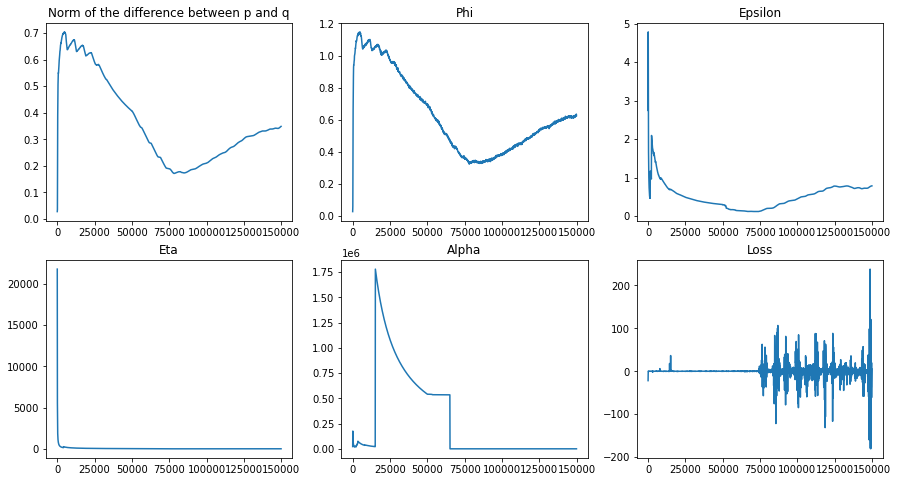

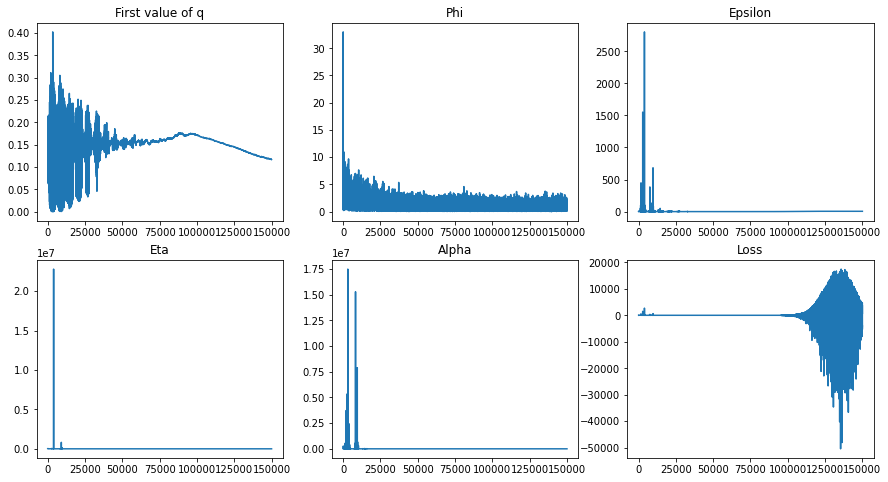


 


 	 EXP THRESHOLD 0.45 
 
 

epoch 0: 
 	 epsilon_=1.3139928579330444 and grad = 1.0 and lr = 0.0026664999999998166 
 	 eta_=9.999045372009277 and grad = -1.0 and lr = 0.0026664999999998166 
 	 alpha_=10.001046180725098 and grad = 0.8117480874061584 and lr = 0.0026664999999998166 
 	 s_=tensor([-1.5602, -1.7425, -2.2088, -3.3719, -2.4376, -3.4185, -2.3772, -2.5595,
        -3.9866, -6.2872, -4.1870, -6.3052, -3.1756, -4.3388, -4.1384, -6.4390,
        -5.4819, -6.6214, -3.4185, -4.3993, -4.3528, -6.4710, -5.4959, -6.6353],
       requires_grad=True)
 	 q2=tensor([0.2011, 0.1701, 0.1101, 0.0356, 0.0885, 0.0341, 0.0937, 0.0787, 0.0194,
        0.0020, 0.0159, 0.0019, 0.0432, 0.0137, 0.0167, 0.0017, 0.0044, 0.0014,
        0.0341, 0.0129, 0.0135, 0.0016, 0.0043, 0.0014],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 1.0000,  1.0000, -0.8978, -0.2711, -0.6463, -0.2079, -0.6574, -0.6169,
        -0.1297, -0.0138, -0.1086, -0.0136, -0.3049, -0.0966, -0.1102, -0.0119,
   

epoch 10500: 
 	 epsilon_=0.048553913831710815 and grad = -0.02976263500750065 and lr = 1.250041749999999 
 	 eta_=0.47415509819984436 and grad = -0.014065533876419067 and lr = 1.250041749999999 
 	 alpha_=2.3921256065368652 and grad = 0.10208502411842346 and lr = 1.250041749999999 
 	 s_=tensor([ 0.8520,  0.9056,  0.6614, -0.2624,  0.6241, -0.3006,  0.6756,  0.5592,
        -0.3437, -0.6641, -0.3279, -0.6001, -0.0213, -0.4299, -0.3692, -0.5684,
        -0.6634, -0.4405, -0.2776, -0.5037, -0.4446, -0.6354, -0.5442, -0.5727],
       requires_grad=True)
 	 q2=tensor([0.0699, 0.0730, 0.0653, 0.0360, 0.0632, 0.0375, 0.0632, 0.0595, 0.0367,
        0.0310, 0.0355, 0.0291, 0.0446, 0.0341, 0.0356, 0.0303, 0.0315, 0.0306,
        0.0377, 0.0324, 0.0322, 0.0291, 0.0341, 0.0279],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0239,  0.0144,  0.0045,  0.0008,  0.0148, -0.0147,  0.0241,  0.0198,
        -0.0119, -0.0105,  0.0017, -0.0063, -0.0094, -0.0083, -0.0104, -0.0045,
     

epoch 21000: 
 	 epsilon_=0.24739903211593628 and grad = 0.38553357124328613 and lr = 0.6257291874999997 
 	 eta_=3.823094606399536 and grad = 0.17329198122024536 and lr = 0.6257291874999997 
 	 alpha_=5.554091453552246 and grad = -0.078807033598423 and lr = 0.6257291874999997 
 	 s_=tensor([ 4.1355e+00,  2.8852e+00,  2.1897e+00,  3.8228e-02,  1.1523e+00,
         1.8799e-03,  1.8228e+00,  1.9871e+00, -5.1792e-01, -1.6723e+00,
        -1.1045e+00, -1.5853e+00,  5.1810e-01, -1.1543e+00, -7.1581e-01,
        -1.5714e+00, -1.6608e+00, -1.6503e+00,  1.9593e-02, -1.2048e+00,
        -1.2849e+00, -1.6212e+00, -1.6551e+00, -1.7396e+00],
       requires_grad=True)
 	 q2=tensor([0.1868, 0.1394, 0.0896, 0.0359, 0.0536, 0.0307, 0.1053, 0.1019, 0.0176,
        0.0084, 0.0178, 0.0080, 0.0503, 0.0165, 0.0215, 0.0074, 0.0083, 0.0079,
        0.0400, 0.0160, 0.0143, 0.0079, 0.0073, 0.0077],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 0.1481,  0.1674,  0.1365, -0.0957,

epoch 31500: 
 	 epsilon_=0.07597841322422028 and grad = -0.030900415033102036 and lr = 0.07916926562500007 
 	 eta_=0.6589033603668213 and grad = -0.22339795529842377 and lr = 0.07916926562500007 
 	 alpha_=2.73519229888916 and grad = 0.14087703824043274 and lr = 0.07916926562500007 
 	 s_=tensor([ 2.1763,  2.1558,  1.6668, -0.2497,  1.1767, -0.2999,  1.3250,  0.9691,
        -0.9974, -1.2557, -1.2142, -1.2232,  0.0100, -1.1510, -1.0891, -1.2479,
        -1.2620, -1.2489, -0.3129, -1.2011, -1.1935, -1.2316, -1.2287, -1.2436],
       requires_grad=True)
 	 q2=tensor([0.1366, 0.1349, 0.1105, 0.0343, 0.0854, 0.0330, 0.0928, 0.0770, 0.0189,
        0.0150, 0.0155, 0.0155, 0.0418, 0.0163, 0.0173, 0.0153, 0.0150, 0.0151,
        0.0329, 0.0155, 0.0157, 0.0153, 0.0153, 0.0151],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 0.0251,  0.0239, -0.0352,  0.0125,  0.0238, -0.0191,  0.0257,  0.0246,
        -0.0120, -0.0109, -0.0106, -0.0109,  0.0172, -0.0115, -0.011

epoch 42000: 
 	 epsilon_=0.08904190361499786 and grad = -0.023457862436771393 and lr = 0.001013019531250016 
 	 eta_=0.8180074691772461 and grad = 0.1155821830034256 and lr = 0.001013019531250016 
 	 alpha_=2.245760440826416 and grad = -0.03903932869434357 and lr = 0.001013019531250016 
 	 s_=tensor([ 2.4534e+00,  2.2850e+00,  1.6441e+00, -2.6572e-01,  1.1794e+00,
        -3.2617e-01,  1.2971e+00,  9.5745e-01, -1.0203e+00, -1.4211e+00,
        -1.2494e+00, -1.4193e+00, -1.5677e-03, -1.4158e+00, -1.1951e+00,
        -1.4189e+00, -1.4118e+00, -1.4130e+00, -3.2649e-01, -1.4214e+00,
        -1.4243e+00, -1.4158e+00, -1.4154e+00, -1.4247e+00],
       requires_grad=True)
 	 q2=tensor([0.1531, 0.1438, 0.1099, 0.0344, 0.0874, 0.0328, 0.0929, 0.0774, 0.0186,
        0.0131, 0.0152, 0.0131, 0.0418, 0.0131, 0.0160, 0.0131, 0.0132, 0.0132,
        0.0328, 0.0131, 0.0130, 0.0131, 0.0131, 0.0130],
       grad_fn=<DivBackward0>) and sum=0.9999998807907104 and grad = tensor([ 0.0371,  0.0325,  0.0288

epoch 52500: 
 	 epsilon_=0.09664091467857361 and grad = -0.02288202941417694 and lr = 0.010758138671874994 
 	 eta_=0.8516263961791992 and grad = -0.11907196044921875 and lr = 0.010758138671874994 
 	 alpha_=2.1139883995056152 and grad = 0.10189822316169739 and lr = 0.010758138671874994 
 	 s_=tensor([ 2.3603e+00,  2.4151e+00,  1.6385e+00, -2.6475e-01,  1.1831e+00,
        -3.3045e-01,  1.2861e+00,  9.4032e-01, -1.0169e+00, -1.4285e+00,
        -1.2491e+00, -1.4182e+00, -9.7090e-04, -1.4080e+00, -1.1929e+00,
        -1.4445e+00, -1.4174e+00, -1.4178e+00, -3.2559e-01, -1.4231e+00,
        -1.4133e+00, -1.4168e+00, -1.4029e+00, -1.4304e+00],
       requires_grad=True)
 	 q2=tensor([0.1479, 0.1509, 0.1095, 0.0343, 0.0875, 0.0327, 0.0923, 0.0766, 0.0186,
        0.0130, 0.0152, 0.0131, 0.0418, 0.0132, 0.0160, 0.0128, 0.0131, 0.0131,
        0.0328, 0.0130, 0.0132, 0.0131, 0.0133, 0.0130],
       grad_fn=<DivBackward0>) and sum=0.9999998807907104 and grad = tensor([ 0.0115,  0.0291,  0.031

epoch 63000: 
 	 epsilon_=0.13311375677585602 and grad = -0.019602298736572266 and lr = 0.005880696777343748 
 	 eta_=0.9850857257843018 and grad = 0.0661400854587555 and lr = 0.005880696777343748 
 	 alpha_=1.4072157144546509 and grad = -0.048652440309524536 and lr = 0.005880696777343748 
 	 s_=tensor([ 2.5111,  2.4671,  1.6321, -0.2726,  1.1694, -0.3336,  1.2852,  0.9453,
        -1.0281, -1.5750, -1.2567, -1.5979, -0.0155, -1.4256, -1.1996, -1.5770,
        -1.5679, -1.5818, -0.3340, -1.4908, -1.4356, -1.5896, -1.5696, -1.5857],
       requires_grad=True)
 	 q2=tensor([0.1572, 0.1549, 0.1100, 0.0344, 0.0874, 0.0328, 0.0928, 0.0773, 0.0186,
        0.0114, 0.0152, 0.0112, 0.0416, 0.0131, 0.0160, 0.0114, 0.0115, 0.0114,
        0.0328, 0.0123, 0.0129, 0.0113, 0.0115, 0.0113],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-0.0460,  0.0496, -0.0535, -0.0154,  0.0767,  0.0156,  0.0261,  0.0013,
         0.0083, -0.0105, -0.0086, -0.0098,  0.0309, -0.0173, -0.0151, -0.0125

epoch 73500: 
 	 epsilon_=0.13025623559951782 and grad = -0.01975049078464508 and lr = 0.001610697387695313 
 	 eta_=0.9774560332298279 and grad = 0.2827214300632477 and lr = 0.001610697387695313 
 	 alpha_=1.3168193101882935 and grad = -0.23514589667320251 and lr = 0.001610697387695313 
 	 s_=tensor([ 2.5344,  2.4164,  1.6356, -0.2704,  1.1727, -0.3315,  1.2900,  0.9496,
        -1.0247, -1.5622, -1.2545, -1.5539, -0.0064, -1.4239, -1.1991, -1.5495,
        -1.5511, -1.5523, -0.3311, -1.4907, -1.4400, -1.5447, -1.5541, -1.5524],
       requires_grad=True)
 	 q2=tensor([0.1582, 0.1516, 0.1099, 0.0344, 0.0874, 0.0328, 0.0929, 0.0773, 0.0186,
        0.0115, 0.0152, 0.0116, 0.0418, 0.0131, 0.0160, 0.0117, 0.0116, 0.0116,
        0.0328, 0.0123, 0.0129, 0.0117, 0.0116, 0.0116],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 0.0060,  0.0373,  0.0293, -0.0365,  0.0184,  0.0008,  0.0256,  0.0155,
        -0.0215, -0.0175,  0.0038, -0.0165,  0.0019, -0.0180, -0.

epoch 84000: 
 	 epsilon_=0.16677887737751007 and grad = -0.01705607771873474 and lr = 0.0010001017150878908 
 	 eta_=1.0703964233398438 and grad = -0.16316348314285278 and lr = 0.0010001017150878908 
 	 alpha_=0.8074963688850403 and grad = 0.16362226009368896 and lr = 0.0010001017150878908 
 	 s_=tensor([ 2.7453,  2.2696,  1.6265, -0.2750,  1.1665, -0.3362,  1.2800,  0.9447,
        -1.0283, -1.6104, -1.2580, -1.6100, -0.0108, -1.4279, -1.2021, -1.6133,
        -1.6164, -1.6212, -0.3356, -1.4933, -1.4439, -1.6107, -1.6150, -1.6158],
       requires_grad=True)
 	 q2=tensor([0.1707, 0.1440, 0.1098, 0.0344, 0.0874, 0.0328, 0.0927, 0.0774, 0.0186,
        0.0111, 0.0152, 0.0111, 0.0418, 0.0131, 0.0160, 0.0110, 0.0110, 0.0110,
        0.0328, 0.0123, 0.0129, 0.0111, 0.0110, 0.0110],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0063,  0.0619,  0.0077,  0.0103,  0.0312,  0.0019,  0.0425, -0.0002,
        -0.0203, -0.0193, -0.0223, -0.0155, -0.0507, -0.0192, -0.0274, -0.01

epoch 94500: 
 	 epsilon_=0.391405314207077 and grad = -0.007170319557189941 and lr = 0.0010762354583740239 
 	 eta_=1.4570271968841553 and grad = 0.9401845932006836 and lr = 0.0010762354583740239 
 	 alpha_=0.17161956429481506 and grad = -1.0 and lr = 0.0010762354583740239 
 	 s_=tensor([ 2.7726,  2.4099,  1.6290, -0.2748,  1.1490, -0.3363,  1.2823,  0.9362,
        -1.0268, -1.7250, -1.2581, -1.7265, -0.0095, -1.4255, -1.2025, -1.7206,
        -1.7273, -1.6961, -0.3364, -1.4891, -1.4424, -1.7346, -1.7356, -1.7527],
       requires_grad=True)
 	 q2=tensor([0.1723, 0.1518, 0.1099, 0.0344, 0.0866, 0.0328, 0.0929, 0.0770, 0.0186,
        0.0100, 0.0152, 0.0100, 0.0419, 0.0131, 0.0160, 0.0100, 0.0099, 0.0102,
        0.0328, 0.0124, 0.0129, 0.0099, 0.0099, 0.0097],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([-0.2829,  0.2095, -0.2400,  0.0021,  0.4595,  0.0159, -0.0651, -0.0203,
        -0.0280, -0.0071,  0.0319, -0.0015, -0.0105, -0.0522, -0.0165, -0.0240

epoch 105000: 
 	 epsilon_=1.0389951467514038 and grad = 0.005554318428039551 and lr = 0.0010381304435729982 
 	 eta_=2.835137367248535 and grad = -1.0 and lr = 0.0010381304435729982 
 	 alpha_=0.021434837952256203 and grad = 1.0 and lr = 0.0010381304435729982 
 	 s_=tensor([ 2.6424,  2.2296,  1.5368, -0.2965,  1.0626, -0.3806,  1.2189,  0.8744,
        -1.0420, -1.6693, -1.2777, -1.7510, -0.0581, -1.4160, -1.2028, -1.6926,
        -1.7006, -1.6581, -0.3744, -1.5026, -1.4550, -1.7316, -1.7178, -1.7038],
       requires_grad=True)
 	 q2=tensor([0.1708, 0.1469, 0.1091, 0.0350, 0.0856, 0.0328, 0.0931, 0.0770, 0.0190,
        0.0109, 0.0155, 0.0101, 0.0419, 0.0137, 0.0165, 0.0106, 0.0106, 0.0110,
        0.0330, 0.0127, 0.0132, 0.0103, 0.0104, 0.0105],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([-1.0000,  1.0000,  1.0000, -1.0000, -1.0000, -1.0000, -1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  0.4033, -1.0000, -1.0000,  1.0000,  0.4151,
         1.0

epoch 117000: 
 	 epsilon_=1.5750181674957275 and grad = 0.01332712173461914 and lr = 0.0010095326108932497 
 	 eta_=4.8481903076171875 and grad = 1.0 and lr = 0.0010095326108932497 
 	 alpha_=0.0026370384730398655 and grad = -1.0 and lr = 0.0010095326108932497 
 	 s_=tensor([ 2.4208,  1.9107,  1.4783, -0.2583,  0.9300, -0.3714,  1.1036,  0.7001,
        -0.9144, -1.4746, -1.1311, -1.5447, -0.0142, -1.2433, -1.0643, -1.4794,
        -1.4842, -1.4526, -0.3596, -1.3306, -1.3001, -1.5220, -1.5116, -1.5120],
       requires_grad=True)
 	 q2=tensor([0.1610, 0.1316, 0.1082, 0.0368, 0.0811, 0.0337, 0.0893, 0.0709, 0.0217,
        0.0132, 0.0180, 0.0124, 0.0441, 0.0163, 0.0190, 0.0132, 0.0131, 0.0135,
        0.0340, 0.0151, 0.0155, 0.0127, 0.0128, 0.0128],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 1., -1., -1., -1.,  1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1., -1.,
         1.,  1., -1.,  1., -1., -1., -1.,  1.,  1.,  1.]) and lr = 0.0010095326108932497 
 	 phi = 0.284388

epoch 129000: 
 	 epsilon_=1.8619071245193481 and grad = 0.016989707946777344 and lr = 0.0010023831527233124 
 	 eta_=6.455276966094971 and grad = -1.0 and lr = 0.0010023831527233124 
 	 alpha_=0.0005708475364372134 and grad = 1.0 and lr = 0.0010023831527233124 
 	 s_=tensor([ 2.2407,  1.5717,  1.3332, -0.2322,  0.7142, -0.3275,  1.0654,  0.5399,
        -0.8054, -1.2906, -1.0246, -1.3680,  0.1057, -1.0519, -0.8948, -1.2796,
        -1.2841, -1.2583, -0.3615, -1.1728, -1.1297, -1.3362, -1.3175, -1.3268],
       requires_grad=True)
 	 q2=tensor([0.1528, 0.1148, 0.1022, 0.0381, 0.0726, 0.0354, 0.0888, 0.0652, 0.0241,
        0.0159, 0.0200, 0.0148, 0.0488, 0.0195, 0.0224, 0.0160, 0.0159, 0.0163,
        0.0345, 0.0176, 0.0183, 0.0152, 0.0155, 0.0154],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 1., -1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,  1., -1.,
         1.,  1., -1., -1.,  1., -1., -1., -1., -1., -1.]) and lr = 0.0010023831527233124 
 	 phi = 1.481424

epoch 141000: 
 	 epsilon_=1.9600372314453125 and grad = 0.018418312072753906 and lr = 0.001000595788180828 
 	 eta_=7.120306015014648 and grad = 1.0 and lr = 0.001000595788180828 
 	 alpha_=0.00032551391632296145 and grad = -1.0 and lr = 0.001000595788180828 
 	 s_=tensor([ 1.9929,  1.1934,  1.2481, -0.1890,  0.5625, -0.3438,  0.9756,  0.3440,
        -0.6619, -1.0869, -0.9139, -1.1780,  0.2120, -0.8712, -0.7184, -1.0731,
        -1.0421, -1.0723, -0.2928, -1.0228, -0.9785, -1.1513, -1.1209, -1.1406],
       requires_grad=True)
 	 q2=tensor([0.1397, 0.0961, 0.0988, 0.0397, 0.0668, 0.0353, 0.0853, 0.0580, 0.0274,
        0.0191, 0.0222, 0.0177, 0.0530, 0.0230, 0.0262, 0.0194, 0.0199, 0.0194,
        0.0367, 0.0202, 0.0210, 0.0181, 0.0186, 0.0183],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-1.,  1., -1., -1.,  1.,  1., -1., -1.,  1., -1., -1., -1., -1.,  1.,
         1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1.]) and lr = 0.001000595788180828 
 	 phi = 0.860645294

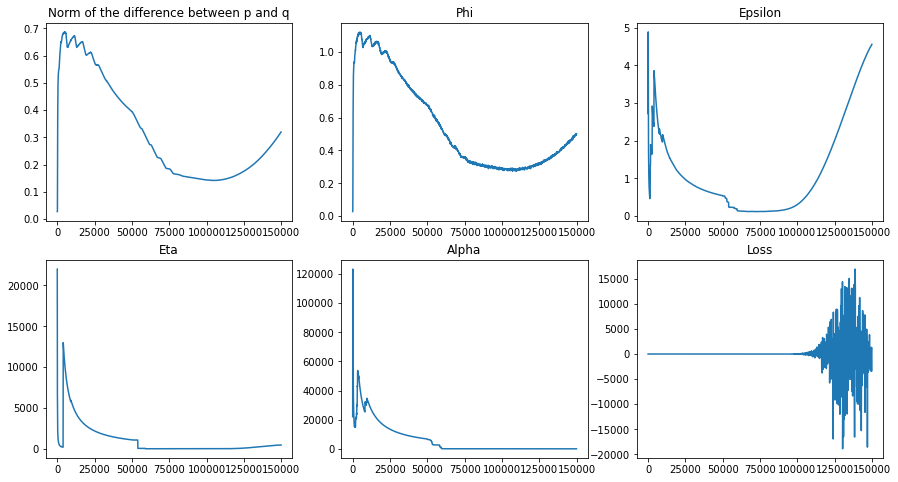

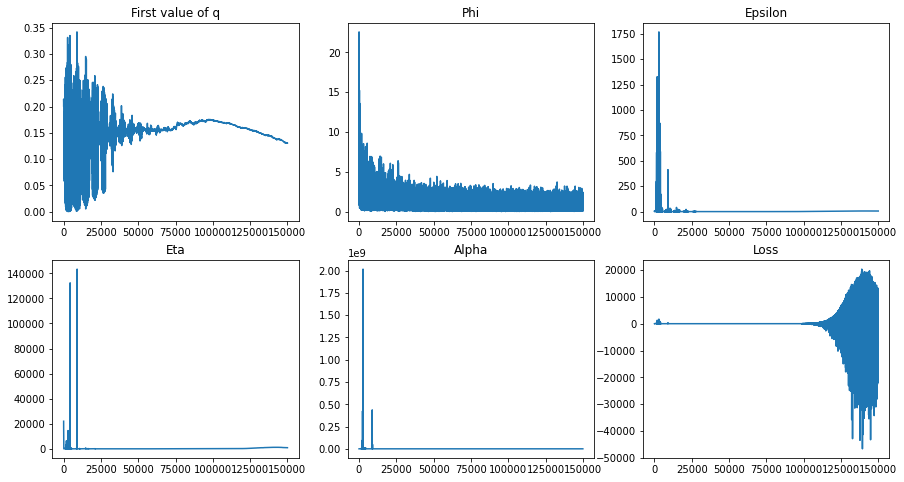


 


 	 EXP THRESHOLD 0.5 
 
 

epoch 0: 
 	 epsilon_=1.3139928579330444 and grad = 1.0 and lr = 0.0026664999999998166 
 	 eta_=9.999045372009277 and grad = -1.0 and lr = 0.0026664999999998166 
 	 alpha_=10.001046180725098 and grad = 1.0 and lr = 0.0026664999999998166 
 	 s_=tensor([-1.5602, -1.7425, -2.2088, -3.3719, -2.4376, -3.4185, -2.3772, -2.5595,
        -3.9866, -6.2872, -4.1870, -6.3052, -3.1756, -4.3388, -4.1384, -6.4390,
        -5.4819, -6.6214, -3.4185, -4.3993, -4.3528, -6.4710, -5.4959, -6.6353],
       requires_grad=True)
 	 q2=tensor([0.2011, 0.1701, 0.1101, 0.0356, 0.0885, 0.0341, 0.0937, 0.0787, 0.0194,
        0.0020, 0.0159, 0.0019, 0.0432, 0.0137, 0.0167, 0.0017, 0.0044, 0.0014,
        0.0341, 0.0129, 0.0135, 0.0016, 0.0043, 0.0014],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 1.0000,  1.0000, -0.8066, -0.2667, -0.6478, -0.2487, -0.6545, -0.5678,
        -0.1457, -0.0147, -0.1181, -0.0144, -0.3152, -0.1026, -0.1250, -0.0126,
        -0.0327, -0

epoch 10500: 
 	 epsilon_=0.06515680998563766 and grad = -0.029294796288013458 and lr = 1.250041749999999 
 	 eta_=0.7625529766082764 and grad = 0.27117741107940674 and lr = 1.250041749999999 
 	 alpha_=3.2518606185913086 and grad = -0.01683879643678665 and lr = 1.250041749999999 
 	 s_=tensor([ 1.0159,  0.9860,  0.8372, -0.4667,  0.7830, -0.5684,  0.8263,  0.8931,
        -0.6689, -0.9166, -0.7252, -1.1125, -0.1553, -0.5732, -0.7396, -1.0816,
        -0.8767, -0.7990, -0.5921, -0.8056, -0.6723, -1.1399, -0.8213, -1.0821],
       requires_grad=True)
 	 q2=tensor([0.0838, 0.0801, 0.0726, 0.0344, 0.0713, 0.0341, 0.0729, 0.0763, 0.0317,
        0.0249, 0.0300, 0.0263, 0.0455, 0.0341, 0.0294, 0.0247, 0.0270, 0.0277,
        0.0329, 0.0300, 0.0311, 0.0244, 0.0286, 0.0262],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0252,  0.0304,  0.0285, -0.0152,  0.0286, -0.0150,  0.0219,  0.0255,
        -0.0160, -0.0082, -0.0125, -0.0119, -0.0143, -0.0120, -0.0118, -0.0104,
       

epoch 21000: 
 	 epsilon_=0.10020681470632553 and grad = 0.1425536870956421 and lr = 0.6257291874999997 
 	 eta_=3.0261173248291016 and grad = 0.018370777368545532 and lr = 0.6257291874999997 
 	 alpha_=3.8673651218414307 and grad = 0.009305506944656372 and lr = 0.6257291874999997 
 	 s_=tensor([ 3.8644,  2.4979,  1.1076, -0.1136,  1.6392, -0.2650,  1.5886,  1.1443,
        -1.1251, -2.3061, -0.9895, -2.4390,  0.3484, -1.3218, -1.1447, -2.4453,
        -2.2509, -2.4807, -0.1066, -1.2694, -1.0931, -2.2280, -2.4016, -2.3999],
       requires_grad=True)
 	 q2=tensor([0.2313, 0.1560, 0.0793, 0.0363, 0.0871, 0.0333, 0.1012, 0.0757, 0.0160,
        0.0052, 0.0146, 0.0046, 0.0407, 0.0122, 0.0170, 0.0048, 0.0054, 0.0043,
        0.0304, 0.0122, 0.0175, 0.0053, 0.0049, 0.0047],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-0.1328,  0.1630,  0.1050, -0.0916,  0.1371, -0.0848, -0.1600,  0.0667,
         0.0356, -0.0153,  0.0328, -0.0130,  0.0651,  0.0289, -0.0470, -0.0140,
      

epoch 31500: 
 	 epsilon_=0.06778405606746674 and grad = 0.01700131595134735 and lr = 0.07916926562500007 
 	 eta_=1.3836748600006104 and grad = -0.054184556007385254 and lr = 0.07916926562500007 
 	 alpha_=2.452918529510498 and grad = 0.0719594806432724 and lr = 0.07916926562500007 
 	 s_=tensor([ 2.3573,  2.6971,  1.4518, -0.3474,  1.0696, -0.4030,  1.1144,  0.7645,
        -1.0706, -1.7936, -1.4365, -1.8064, -0.1403, -1.5705, -1.3407, -1.8343,
        -1.8182, -1.8593, -0.4368, -1.6169, -1.5752, -1.7697, -1.8022, -1.8087],
       requires_grad=True)
 	 q2=tensor([0.1543, 0.1771, 0.1074, 0.0343, 0.0872, 0.0327, 0.0905, 0.0749, 0.0189,
        0.0105, 0.0143, 0.0104, 0.0405, 0.0123, 0.0155, 0.0101, 0.0101, 0.0101,
        0.0329, 0.0118, 0.0125, 0.0109, 0.0104, 0.0104],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0747, -0.1279,  0.0404,  0.0171,  0.0575,  0.0238,  0.0289,  0.0380,
        -0.0308, -0.0170,  0.0120, -0.0186,  0.0182,  0.0078,  0.0107, -0.0171,
    

epoch 42000: 
 	 epsilon_=0.1022474616765976 and grad = -0.0225190669298172 and lr = 0.001013019531250016 
 	 eta_=0.876120388507843 and grad = 0.17569085955619812 and lr = 0.001013019531250016 
 	 alpha_=2.273404121398926 and grad = -0.08167394995689392 and lr = 0.001013019531250016 
 	 s_=tensor([ 2.3378,  2.4561,  1.6327, -0.2723,  1.1712, -0.3327,  1.2877,  0.9491,
        -1.0261, -1.4663, -1.2557, -1.4662, -0.0081, -1.4251, -1.2004, -1.4574,
        -1.4700, -1.4663, -0.3326, -1.4637, -1.4404, -1.4709, -1.4676, -1.4576],
       requires_grad=True)
 	 q2=tensor([0.1474, 0.1540, 0.1099, 0.0344, 0.0874, 0.0328, 0.0929, 0.0774, 0.0186,
        0.0126, 0.0152, 0.0126, 0.0418, 0.0131, 0.0160, 0.0127, 0.0126, 0.0126,
        0.0328, 0.0126, 0.0129, 0.0125, 0.0126, 0.0127],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 0.0425, -0.0671,  0.0349, -0.0006,  0.0404,  0.0180,  0.0118,  0.0348,
        -0.0217, -0.0164, -0.0174, -0.0161,  0.0234, -0.0159,  0.005

epoch 52500: 
 	 epsilon_=0.11880000680685043 and grad = -0.02128034085035324 and lr = 0.010758138671874994 
 	 eta_=0.9370902180671692 and grad = 0.29697832465171814 and lr = 0.010758138671874994 
 	 alpha_=1.835680365562439 and grad = -0.19415146112442017 and lr = 0.010758138671874994 
 	 s_=tensor([ 2.4877,  2.4815,  1.6299, -0.2736,  1.1597, -0.3362,  1.2765,  0.9037,
        -1.0290, -1.5595, -1.2527, -1.5551, -0.0111, -1.4181, -1.1977, -1.5272,
        -1.5425, -1.5267, -0.3360, -1.4930, -1.4401, -1.5273, -1.5224, -1.4927],
       requires_grad=True)
 	 q2=tensor([0.1558, 0.1553, 0.1097, 0.0344, 0.0869, 0.0327, 0.0923, 0.0753, 0.0186,
        0.0116, 0.0152, 0.0116, 0.0418, 0.0132, 0.0160, 0.0119, 0.0118, 0.0119,
        0.0327, 0.0123, 0.0129, 0.0119, 0.0120, 0.0123],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0289,  0.0126,  0.0381, -0.0422,  0.0004,  0.0102,  0.0314,  0.0359,
         0.0065, -0.0151, -0.0205, -0.0151, -0.0394, -0.0175, -0.0215, -0.0159,


epoch 63000: 
 	 epsilon_=0.1544785052537918 and grad = -0.017504215240478516 and lr = 0.005880696777343748 
 	 eta_=1.0453548431396484 and grad = 0.18418791890144348 and lr = 0.005880696777343748 
 	 alpha_=1.390357255935669 and grad = -0.16683517396450043 and lr = 0.005880696777343748 
 	 s_=tensor([ 2.5467,  2.4644,  1.6258, -0.2772,  1.1601, -0.3409,  1.2787,  0.9357,
        -1.0289, -1.6214, -1.2581, -1.6104, -0.0147, -1.4297, -1.2031, -1.6050,
        -1.6094, -1.6210, -0.3409, -1.4946, -1.4386, -1.5970, -1.6156, -1.6216],
       requires_grad=True)
 	 q2=tensor([0.1597, 0.1551, 0.1100, 0.0344, 0.0872, 0.0327, 0.0928, 0.0771, 0.0186,
        0.0109, 0.0152, 0.0111, 0.0417, 0.0131, 0.0160, 0.0111, 0.0111, 0.0110,
        0.0327, 0.0123, 0.0130, 0.0112, 0.0110, 0.0109],
       grad_fn=<DivBackward0>) and sum=0.9999999403953552 and grad = tensor([ 0.0140,  0.0510, -0.0456, -0.0358,  0.0381,  0.0160,  0.0126,  0.0214,
        -0.0201, -0.0147, -0.0195, -0.0135,  0.0058, -0.0161, -0.

epoch 73500: 
 	 epsilon_=0.1328336000442505 and grad = -0.019508153200149536 and lr = 0.001610697387695313 
 	 eta_=0.9851491451263428 and grad = 0.014950037002563477 and lr = 0.001610697387695313 
 	 alpha_=1.226763129234314 and grad = -0.0018143653869628906 and lr = 0.001610697387695313 
 	 s_=tensor([ 2.4794,  2.4474,  1.6359, -0.2699,  1.1725, -0.3302,  1.2907,  0.9520,
        -1.0247, -1.5460, -1.2536, -1.5451, -0.0059, -1.4226, -1.1992, -1.5377,
        -1.5340, -1.5351, -0.3310, -1.4910, -1.4395, -1.5337, -1.5325, -1.5352],
       requires_grad=True)
 	 q2=tensor([0.1550, 0.1533, 0.1099, 0.0343, 0.0873, 0.0328, 0.0929, 0.0774, 0.0186,
        0.0117, 0.0152, 0.0117, 0.0418, 0.0131, 0.0160, 0.0118, 0.0118, 0.0118,
        0.0328, 0.0123, 0.0129, 0.0118, 0.0119, 0.0118],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0147,  0.0263,  0.0350,  0.0185,  0.0741, -0.0157, -0.0084, -0.0307,
        -0.0206, -0.0131, -0.0185, -0.0133, -0.0463, -0.0160,  0.0114, -0.014

epoch 84000: 
 	 epsilon_=0.16957199573516846 and grad = -0.017033949494361877 and lr = 0.0010001017150878908 
 	 eta_=1.0754609107971191 and grad = 0.1834087371826172 and lr = 0.0010001017150878908 
 	 alpha_=0.7391533851623535 and grad = -0.23584473133087158 and lr = 0.0010001017150878908 
 	 s_=tensor([ 2.5621,  2.4921,  1.6298, -0.2745,  1.1655, -0.3355,  1.2760,  0.9465,
        -1.0283, -1.6426, -1.2577, -1.6342, -0.0109, -1.4278, -1.2026, -1.6368,
        -1.6335, -1.6413, -0.3353, -1.4944, -1.4437, -1.6373, -1.6372, -1.6269],
       requires_grad=True)
 	 q2=tensor([0.1602, 0.1563, 0.1099, 0.0344, 0.0873, 0.0328, 0.0925, 0.0775, 0.0186,
        0.0107, 0.0152, 0.0108, 0.0418, 0.0131, 0.0160, 0.0108, 0.0108, 0.0108,
        0.0328, 0.0123, 0.0129, 0.0108, 0.0108, 0.0109],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([ 0.0419, -0.0081, -0.0123,  0.0220,  0.0636,  0.0044,  0.0263, -0.0752,
        -0.0287, -0.0152, -0.0190, -0.0171,  0.0241,  0.0077,  0.0076, -0.01

epoch 94500: 
 	 epsilon_=0.41614004969596863 and grad = -0.006762266159057617 and lr = 0.0010762354583740239 
 	 eta_=1.4964709281921387 and grad = 0.5867490768432617 and lr = 0.0010762354583740239 
 	 alpha_=0.15797914564609528 and grad = -1.0 and lr = 0.0010762354583740239 
 	 s_=tensor([ 2.7148,  2.4586,  1.6152, -0.2811,  1.1481, -0.3409,  1.2726,  0.9333,
        -1.0312, -1.7556, -1.2631, -1.7398, -0.0200, -1.4297, -1.2090, -1.7276,
        -1.7626, -1.7317, -0.3410, -1.4983, -1.4481, -1.7741, -1.7588, -1.7571],
       requires_grad=True)
 	 q2=tensor([0.1698, 0.1552, 0.1098, 0.0344, 0.0870, 0.0328, 0.0928, 0.0773, 0.0186,
        0.0097, 0.0152, 0.0099, 0.0417, 0.0131, 0.0160, 0.0100, 0.0097, 0.0100,
        0.0328, 0.0123, 0.0129, 0.0096, 0.0097, 0.0097],
       grad_fn=<DivBackward0>) and sum=1.0000001192092896 and grad = tensor([ 0.3398, -0.2923,  0.0436, -0.0073,  0.2684,  0.0108, -0.2978,  0.0054,
        -0.0421, -0.0204, -0.0367, -0.0150,  0.0842, -0.0265,  0.0153, -0.01

epoch 106500: 
 	 epsilon_=1.1099485158920288 and grad = 0.007155179977416992 and lr = 0.001019058864593506 
 	 eta_=3.0446572303771973 and grad = -0.4688377380371094 and lr = 0.001019058864593506 
 	 alpha_=0.015598375350236893 and grad = -1.0 and lr = 0.001019058864593506 
 	 s_=tensor([ 2.5807,  2.2559,  1.5126, -0.3328,  1.0289, -0.3773,  1.1616,  0.8457,
        -1.0596, -1.7507, -1.2696, -1.8198, -0.0632, -1.4291, -1.2027, -1.7413,
        -1.7280, -1.7240, -0.4002, -1.5210, -1.4498, -1.7822, -1.7838, -1.7770],
       requires_grad=True)
 	 q2=tensor([0.1698, 0.1507, 0.1095, 0.0346, 0.0854, 0.0334, 0.0918, 0.0770, 0.0190,
        0.0102, 0.0158, 0.0096, 0.0424, 0.0137, 0.0168, 0.0103, 0.0105, 0.0105,
        0.0328, 0.0126, 0.0135, 0.0100, 0.0099, 0.0100],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-1.0000, -0.9409,  1.0000,  1.0000, -1.0000, -1.0000, -1.0000,  1.0000,
        -1.0000, -1.0000,  1.0000, -1.0000, -1.0000,  1.0000, -1.0000,  1.0000,
        -1.00

epoch 118500: 
 	 epsilon_=1.645917534828186 and grad = 0.014094829559326172 and lr = 0.0010047647161483765 
 	 eta_=5.203328609466553 and grad = -1.0 and lr = 0.0010047647161483765 
 	 alpha_=0.0017146323807537556 and grad = 1.0 and lr = 0.0010047647161483765 
 	 s_=tensor([ 2.2963,  2.0122,  1.3604, -0.3004,  0.8549, -0.3868,  1.0562,  0.6673,
        -0.9160, -1.5370, -1.1254, -1.6132,  0.0123, -1.2474, -1.0433, -1.5385,
        -1.5181, -1.5174, -0.3606, -1.3452, -1.2836, -1.5738, -1.5762, -1.5810],
       requires_grad=True)
 	 q2=tensor([0.1569, 0.1402, 0.1042, 0.0364, 0.0793, 0.0340, 0.0889, 0.0709, 0.0221,
        0.0128, 0.0184, 0.0119, 0.0459, 0.0166, 0.0198, 0.0128, 0.0130, 0.0130,
        0.0347, 0.0152, 0.0160, 0.0124, 0.0123, 0.0123],
       grad_fn=<DivBackward0>) and sum=0.9999998807907104 and grad = tensor([-1.,  1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1.,
        -1., -1., -1., -1., -1., -1.,  1., -1.,  1.,  1.]) and lr = 0.0010047647161483765 
 	 

epoch 130500: 
 	 epsilon_=1.9240689277648926 and grad = 0.018050193786621094 and lr = 0.0010011911790370942 
 	 eta_=6.869247913360596 and grad = -1.0 and lr = 0.0010011911790370942 
 	 alpha_=0.00035783680505119264 and grad = 1.0 and lr = 0.0010011911790370942 
 	 s_=tensor([ 2.0457,  1.7053,  1.3283, -0.1942,  0.7004, -0.3694,  0.9772,  0.5677,
        -0.7394, -1.3601, -1.0033, -1.4260,  0.1221, -1.0590, -0.8795, -1.3498,
        -1.3203, -1.3345, -0.3547, -1.1770, -1.1393, -1.3900, -1.3846, -1.3923],
       requires_grad=True)
 	 q2=tensor([0.1432, 0.1237, 0.1033, 0.0397, 0.0729, 0.0347, 0.0856, 0.0672, 0.0258,
        0.0151, 0.0206, 0.0142, 0.0499, 0.0197, 0.0229, 0.0152, 0.0156, 0.0154,
        0.0351, 0.0177, 0.0183, 0.0147, 0.0148, 0.0147],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-1.,  1.,  1.,  1., -1.,  1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1.,
         1.,  1.,  1.,  1., -1., -1., -1.,  1., -1.,  1.]) and lr = 0.0010011911790370942 
 	 phi = 1.15000

epoch 142500: 
 	 epsilon_=2.0545949935913086 and grad = 0.019010066986083984 and lr = 0.0010002977947592736 
 	 eta_=7.825789451599121 and grad = -1.0 and lr = 0.0010002977947592736 
 	 alpha_=0.00015369665925391018 and grad = 1.0 and lr = 0.0010002977947592736 
 	 s_=tensor([ 1.7961,  1.4015,  1.1958, -0.1143,  0.5329, -0.3250,  0.9415,  0.4214,
        -0.6053, -1.1698, -0.8921, -1.2498,  0.1848, -0.8615, -0.6983, -1.1444,
        -1.1116, -1.1260, -0.3142, -0.9910, -0.9976, -1.2028, -1.1848, -1.1894],
       requires_grad=True)
 	 q2=tensor([0.1294, 0.1076, 0.0969, 0.0423, 0.0660, 0.0361, 0.0844, 0.0615, 0.0289,
        0.0179, 0.0228, 0.0167, 0.0524, 0.0234, 0.0268, 0.0183, 0.0189, 0.0186,
        0.0364, 0.0210, 0.0208, 0.0174, 0.0177, 0.0176],
       grad_fn=<DivBackward0>) and sum=1.0 and grad = tensor([-1., -1.,  1., -1.,  1., -1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.,
         1., -1.,  1., -1.,  1.,  1.,  1., -1., -1., -1.]) and lr = 0.0010002977947592736 
 	 phi = 2.01987

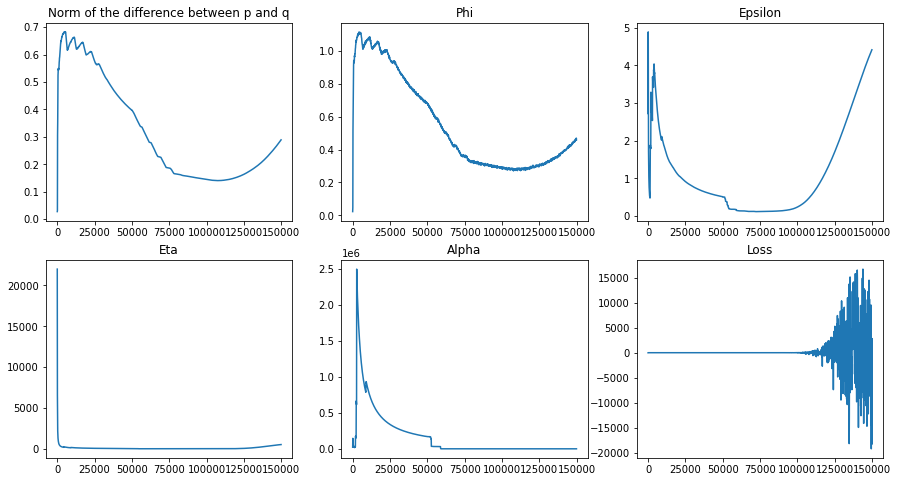

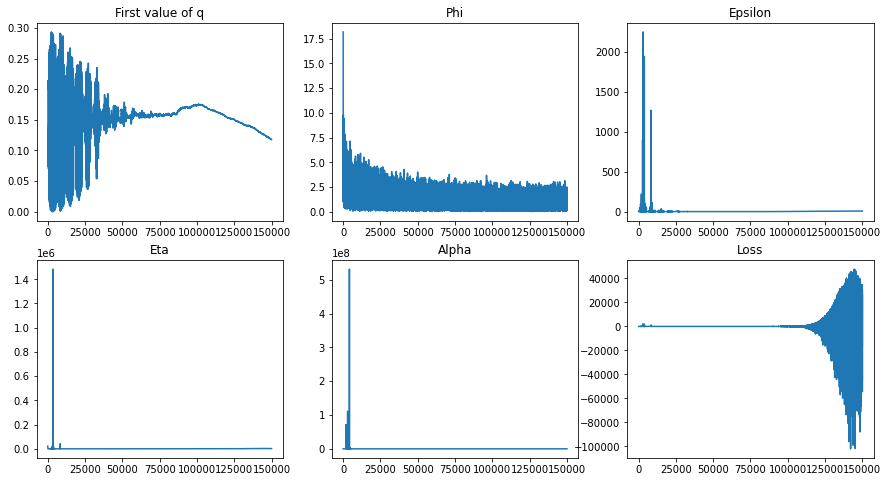

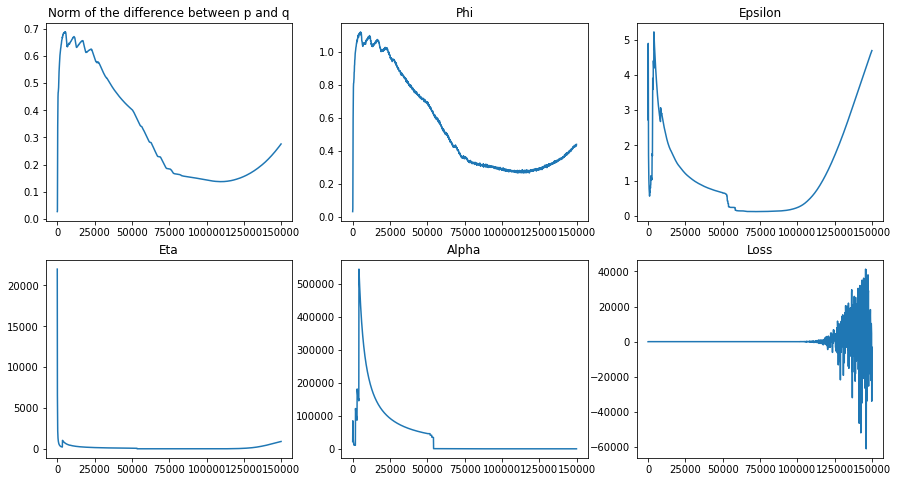

In [45]:
# Merge
dist = "merge"
perf_list_merge, eps_list_merge1, eps_list_merge2 = launch_exp(dist, w, delta, thresholds_, epochs)

perf_list = [1.9792989492416382, 2.9549341201782227, 2.9549341201782227, 2.9549341201782227, 2.9549341201782227, 2.9549341201782227, 2.9549341201782227, 2.9549341201782227, 2.9549341201782227, 2.9549341201782227, 2.9549341201782227] and eps_list1 = [1.043854867759943, 0.8580121505080164, 0.9064703736406565, 0.9227163281148673, 1.0846244297820329, 0.7611002617442608, 0.8446326604673267, 0.7867281204581261, 4.566870376939773, 4.424601924288273, 4.697023820487261] and eps_list2 = [tensor(0.3750, dtype=torch.float64), tensor(0.3962, dtype=torch.float64), tensor(0.4105, dtype=torch.float64), tensor(0.3910, dtype=torch.float64), tensor(0.3918, dtype=torch.float64), tensor(0.3626, dtype=torch.float64), tensor(0.3476, dtype=torch.float64), tensor(0.3491, dtype=torch.float64), tensor(0.3202, dtype=torch.float64), tensor(0.2896, dtype=torch.float64), tensor(0.2768, dtype=torch.float64)]


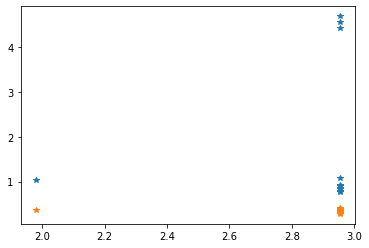

In [48]:
print(f"perf_list = {perf_list_merge} and eps_list1 = {eps_list_merge1} and eps_list2 = {eps_list_merge2}")
plt.plot(perf_list_merge, eps_list_merge1, '*')
plt.plot(perf_list_merge, eps_list_merge2, '*')
plt.show()

In [47]:
# Wasserstein
dist = "wasserstein"
perf_list_wasserstein, eps_list_wasserstein1, eps_list_wasserstein2 = launch_exp(dist, w, delta, thresholds_, epochs)


 	 EXP THRESHOLD 0 
 
 

CALL TO WASSERSTEIN
WASS i = 0 --> val: 0.9967532467532467 for [tensor([0, 1, 2, 3]), tensor([0, 1, 3, 2])] / q = tensor([[0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]], dtype=torch.float64) and p = tensor([[0.2099, 0.1749, 0.1099, 0.0344, 0.0875, 0.0328, 0.0929, 0.0774, 0.0186,
         0.0019, 0.0152, 0.0018, 0.0418, 0.0131, 0.0160, 0.0016, 0.0042, 0.0013,
         0.0328, 0.0123, 0.0129, 0.0015, 0.0041, 0.0013]], dtype=torch.float64)
WASS i = 1 --> val: 1.3603896103896107 for [tensor([0, 1, 2, 3]), tensor([0, 2, 1, 3])] / q = tensor([[0.5000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]], dtype=torch.float64) and p = tensor([[0.2099, 0.1749,

WASS i = 60 --> val: 2.853896103896104 for [tensor([3, 1, 0, 2]), tensor([1, 3, 0, 2])] / q = tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000]], dtype=torch.float64) and p = tensor([[0.2099, 0.1749, 0.1099, 0.0344, 0.0875, 0.0328, 0.0929, 0.0774, 0.0186,
         0.0019, 0.0152, 0.0018, 0.0418, 0.0131, 0.0160, 0.0016, 0.0042, 0.0013,
         0.0328, 0.0123, 0.0129, 0.0015, 0.0041, 0.0013]], dtype=torch.float64)
WASS i = 61 --> val: 2.853896103896104 for [tensor([3, 1, 0, 2]), tensor([3, 0, 1, 2])] / q = tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.5000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000]], dtype=torch.float64) and p = tensor([[0.2099, 0.1749, 0.1099, 0.0344, 0.0875, 0.0328, 0.0929, 0.077

AttributeError: 'NoneType' object has no attribute 'data'

In [ ]:
print(f"perf_list = {perf_list_wasserstein} and eps_list1 = {eps_list_wasserstein1} and eps_list2 = {eps_list_wasserstein2}")
plt.plot(perf_list_wasserstein, eps_list_wasserstein1, '*')
plt.plot(perf_list_wasserstein, eps_list_wasserstein2, '*')
plt.show()

In [ ]:
K = kendall_matrix(torch_all_ranks)
p = torch.tensor([[0.0369, 0.0388, 0.0497, 0.0311, 0.0455, 0.0496, 0.0381, 0.0308, 0.0266,
         0.0475, 0.0370, 0.0599, 0.0317, 0.0472, 0.0301, 0.0499, 0.0358, 0.0273,
         0.0548, 0.0422, 0.0442, 0.0240, 0.0388, 0.0448]])
print(torch.sum(p))
q = torch.tensor([[0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]], dtype=torch.float64)
val_ = wasserstein_dist(p, q, K, n=4)

In [ ]:
q

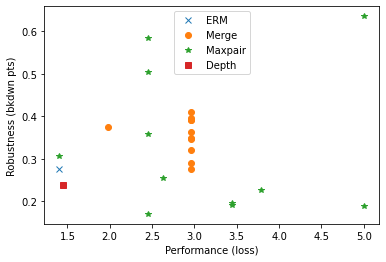

In [53]:
plt.plot(perf_list_erm, eps_list_erm2, 'x', label="ERM")
plt.plot(perf_list_merge, eps_list_merge2, 'o', label="Merge")
plt.plot(perf_list_maxpair, eps_list_maxpair2, '*', label="Maxpair")
plt.plot(perf_list_depth, eps_list_depth2, 's', label="Depth")
plt.xlabel("Performance (loss)")
plt.ylabel("Robustness (bkdwn pts)")
#plt.ylim(-0.05, 1.05)
plt.legend()
plt.show()

# UNUSED CODE

In [ ]:
def kendall_tau_numpy(y, sigma):
    y = torch.from_numpy(y)
    sigma = torch.from_numpy(sigma)
    n = sigma.size()[-1]
    sigma_inv = torch.argsort(sigma, dim=-1)
    y_inv = torch.argsort(y, dim=-1)
    sigma_pairs = (sigma_inv.unsqueeze(dim=-1) > sigma_inv.unsqueeze(dim=-2)).float()
    y_pairs = (y_inv.unsqueeze(dim=-1) > y_inv.unsqueeze(dim=-2)).float()
    return torch.sum(torch.abs(sigma_pairs-y_pairs), dim=[-2,-1])/2 #/(n*(n-1))

def kendall_matrix(all_ranks):
    K = np.zeros((len(all_ranks),len(all_ranks)))
    for i, rank1 in enumerate(all_ranks):
        for j, rank2 in enumerate(all_ranks):
            K[i,j] = kendall_tau_numpy(rank1,rank2)
    return K

def kendall_tau(y, sigma, norm=False):
    """
    Kendall Tau distance
    Permutations follow the convention rank -> item_id
    :param torch.Tensor y: permutation
    :param torch.Tensor sigma: permutation
    :return: value of the metric
    :rtype: torch.Tensor
    """
    with torch.no_grad():
        n = sigma.size()[-1]
        sigma_inv = torch.argsort(sigma, dim=-1).to(device).type(default_tensor_type)
        y_inv = torch.argsort(y, dim=-1).to(device).type(default_tensor_type)
        sigma_pairs = (sigma_inv.unsqueeze(dim=-1) > sigma_inv.unsqueeze(dim=-2)).to(device).type(default_tensor_type)
        y_pairs = (y_inv.unsqueeze(dim=-1) > y_inv.unsqueeze(dim=-2)).to(device).type(default_tensor_type)
        res = torch.sum(torch.abs(sigma_pairs-y_pairs), dim=[-2,-1])
        if norm:
            return res/(n*(n-1))
        else:
            return res/2

In [ ]:
K = kendall_matrix(all_ranks)

In [ ]:
def get_all_buckets(all_ranks, n_items=4):
    list_bucket = list()

    for rank1 in all_ranks:
        for rank2 in all_ranks:
            if kendall_tau_numpy(rank1,rank2) == 1.0:
                list_bucket.append( [rank1,rank2] )
    
    for i in np.arange(4):
        temp_ranks = list()
        for rank in all_ranks:
            if rank[3] == i:
                temp_ranks.append(rank)
        list_bucket.append(temp_ranks)
        
    list_bucket.append([np.array([0,1,2,3]), np.array([0,1,3,2]),np.array([1,0,2,3]),np.array([1,0,3,2])])
    list_bucket.append([np.array([0,2,1,3]), np.array([0,2,3,1]),np.array([2,0,1,3]),np.array([2,0,3,1])])
    list_bucket.append([np.array([0,3,1,2]), np.array([0,3,2,1]),np.array([3,0,1,2]),np.array([3,0,2,1])])
    list_bucket.append([np.array([1,2,0,3]), np.array([1,2,3,0]),np.array([2,1,0,3]),np.array([2,1,3,0])]) 
    list_bucket.append([np.array([1,3,0,2]), np.array([1,3,2,0]),np.array([3,1,0,2]),np.array([3,1,2,0])])
    list_bucket.append([np.array([2,3,0,1]), np.array([2,3,1,0]),np.array([3,2,0,1]),np.array([3,2,1,0])])

    list_bucket.append(all_ranks)
    for rank in all_ranks:
        list_bucket.append(list([rank]))
    
    return list_bucket

list_bucket = get_all_buckets(all_ranks)

In [ ]:
def bucket_distrib(all_ranks, list_bucket):
    l_ = list()
    div = len(list_bucket)
    for a_ in all_ranks:
        count = 0
        for b_ in list_bucket:
            count += 1
            if (b_ == a_).all():
                l_.append(1.0/div)
                count += 1
                continue
        if count == div:
            l_.append(0)
    return np.matrix(l_)